In [1]:
import os
import sys
sys.path.append('/home/fruitspec-lab/FruitSpec/Code/fsCounter')
from omegaconf import OmegaConf
import pyzed.sl as sl
import cv2
import numpy as np
from scipy.stats import gaussian_kde
import kornia as K
from tqdm import tqdm
import numpy as np
import collections
import pandas as pd
from vision.misc.help_func import get_repo_dir, scale_dets, validate_output_path, scale
from vision.depth.zed.svo_operations import get_frame, get_depth, get_point_cloud, get_dimensions, sl_get_dimensions

repo_dir = get_repo_dir()
sys.path.append(os.path.join(repo_dir, 'vision', 'detector', 'yolo_x'))

from vision.pipelines.detection_flow import counter_detection
from vision.pipelines.misc.filters import filter_by_distance, filter_by_size, filter_by_height, sort_out
from vision.tracker.fsTracker.score_func import compute_dist_on_vec
from vision.data.results_collector import ResultsCollector
from vision.tools.translation import translation as T
from vision.tools.camera import is_sturated
from vision.tools.color import get_hue
from vision.tools.video_wrapper import video_wrapper
from vision.tools.image_stitching import plot_2_imgs
import matplotlib.pyplot as plt
import seaborn as sns
import kornia as K


In [2]:
repo_dir = get_repo_dir()
pipeline_config = "/home/fruitspec-lab/FruitSpec/Code/fsCounter/vision/pipelines/config/pipeline_config.yaml"
runtime_config = "/home/fruitspec-lab/FruitSpec/Code/fsCounter/vision/pipelines/config/runtime_config.yaml"
cfg = OmegaConf.load(pipeline_config)
args = OmegaConf.load(runtime_config)

validate_output_path(args.output_folder)

In [3]:
detector = counter_detection(cfg, args)
results_collector = ResultsCollector(rotate=args.rotate)
translation = T(cfg.translation.translation_size, cfg.translation.dets_only, cfg.translation.mode)

cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)

# Read until video is completed
print(f'Inferencing on {args.movie_path}\n')
number_of_frames = cam.get_number_of_frames()


loading checkpoint from /home/fruitspec-lab/FruitSpec/weights/Run_6_Dec_2022_1Class_aug_tasqV2/best_ckpt.pth
loaded checkpoint done.
Inferencing on /home/fruitspec-lab/Downloads/0.8m1stm/ZED_1.svo



In [4]:
measures_path = "/home/fruitspec-lab/Downloads/0.8m1stm/output/measures.csv"
measures_frame = pd.read_csv(measures_path)

In [5]:
def plot_image_grid(images, nrows, ncols, titles=None, figsize=None, xlabels=None, ylabels=None, cmap='viridis'):
    """
    Plots a grid of images using matplotlib.

    Parameters:
    images (list): A list of numpy arrays representing the images to be plotted.
    nrows (int): The number of rows in the grid.
    ncols (int): The number of columns in the grid.
    titles (list, optional): A list of strings representing the titles of the images. Must have the same length as images.
    figsize (tuple, optional): A tuple representing the size of the figure. Defaults to (ncols * 5, nrows * 5).
    xlabels (list, optional): A list of strings representing the x-axis labels for each image. Must have the same length as images.
    ylabels (list, optional): A list of strings representing the y-axis labels for each image. Must have the same length as images.
    cmap (str, optional): The color map to use when plotting the images. Defaults to 'viridis'.

    Returns:
    None
    """
    n_images = len(images)
    if isinstance(figsize, type(None)):
        figsize = (ncols * 5, nrows * 5)
    titles, xlabels, ylabels = (np.full(n_images, "") if isinstance(titles, type(None)) else arr
                                for arr in [titles, xlabels, ylabels])
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        image = images[i]
        ax.imshow(image)
        ax.set_title(titles[i])
        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
    plt.tight_layout()
    plt.show()

def get_real_world_dims_with_correction(depth_map, fx = 1065.98388671875, fy = 1065.98388671875, resized = True):
    """
    calculates each pixel size based on trigo
    :param depth_map: distance_map to each point or an empty string
    :return: size for each pixel
    """
    pic_size = depth_map.shape
    if resized:
        resize_fator_x = 1080/pic_size[0]
        resize_fator_y = 1920/pic_size[1]
    else:
        resize_fator_x = 1
        resize_fator_y = 1
    x0 = pic_size[1] /2
    y0 = pic_size[0] /2
    pixel_mm = 0.002
    focal_len = (fx + fy) / 2 * pixel_mm
    x_range = np.arange(1, pic_size[1]+1)
    X_pix_dist_from_center = np.abs(np.array([x_range for i in range(pic_size[0])]) - x0)
    X_mm_dist_from_center = (X_pix_dist_from_center * (X_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (X_mm_dist_from_center/focal_len)))
    gamma = np.arctan((X_pix_dist_from_center+1)*pixel_mm/focal_len)
    size_x = (np.tan(gamma) - np.tan(gamma-beta))*depth_map*2*resize_fator_x
    size_y = (np.tan(gamma) - np.tan(gamma-beta))*depth_map*2*resize_fator_y
    return size_x, size_y, size_x*size_y

def get_pix_size(depth, box, fx = 1065.98388671875, fy = 1065.98388671875,
                 pixel_mm = 0.0002, org_size = np.array([1920,1080])):
    """
    Calculates the size of a pixel in millimeters given a distance from the camera and the intrinsic parameters of the camera.

    Args:
        depth (float): The depth from the camera to the object in meters.
        box (list): ROI for pixel size int hte following format: x1,y1,x2,y2.
        fx (float): The focal length of the camera in the x direction in pixels. Default is 1065.98388671875.
        fy (float): The focal length of the camera in the y direction in pixels. Default is 1065.98388671875.
        pixel_mm (float): The size of a pixel in millimeters. Default is 0.002.
        org_size (ndarray): The size of the image in pixels. Default is np.array([1920, 1080]).

    Returns:
        size_pix (float): The size of a pixel
    """
    x1,y1,x2,y2 = box
    y0, x0 = org_size/2
    focal_len = (fx + fy) / 2 * pixel_mm
    x_range = np.arange(x1, x2+1)
    x_pix_dist_from_center = np.abs(np.array([x_range for i in range(y2-y1)]) - x0)
    x_mm_dist_from_center = (x_pix_dist_from_center * (x_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (x_mm_dist_from_center/focal_len)))
    gamma = np.arctan((x_mm_dist_from_center+1)*pixel_mm/focal_len)
    size_pix_x = (np.tan(gamma) - np.tan(gamma-beta))*depth*2
    
    y_range = np.arange(y1, y2+1)
    y_pix_dist_from_center = np.abs(np.array([y_range for i in range(x2-x1)]) - y0).T
    y_mm_dist_from_center = (y_pix_dist_from_center * (y_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (y_mm_dist_from_center/focal_len)))
    gamma = np.arctan((y_mm_dist_from_center+1)*pixel_mm/focal_len)
    size_pix_y = (np.tan(gamma) - np.tan(gamma-beta))*depth*2
    return size_pix_x, size_pix_y


def cut_center_of_box(image, margin=0.05):
    """
    Cuts the center of the box.
    
    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - margin: A float representing the percentage of margin to remove from the center of the image.

    Returns:
    - A 3D Numpy array representing the cropped image with the outside of the box removed.
    """
    t, l, (b, r) = 0 ,0, image.shape[:2]
    y_max, x_max = image.shape[:2]
    h_m = int((b-t)*margin)
    w_m = int((r-l)*margin)
    cut_box = image[max(0, t+h_m):min(y_max, b-h_m), max(0, l+w_m):min(x_max, r-w_m)]
    return cut_box


def xyz_center_of_box(image, method="median"):
    """
    Calculates the median or mean x, y, and z coordinates of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A tuple of floats representing the x, y, and z coordinates of the center of the fruit.
    """
    if method=="median":
        cut_box = cut_center_of_box(image, 0.025)
        x_median = np.nanmedian(cut_box[:, :, 0])
        y_median = np.nanmedian(cut_box[:, :, 1])
        z_median = np.nanmedian(cut_box[:, :, 2])
    elif method=="mean":
        cut_box = cut_center_of_box(image, 0.4)
        x_median = np.nanmean(cut_box[:, :, 0])
        y_median = np.nanmean(cut_box[:, :, 1])
        z_median = np.nanmean(cut_box[:, :, 2])
    else: # calculates only on the edge of the cut box
        cut_box = cut_center_of_box(image, 0.25).copy()
        if cut_box.shape[0] > 10 and cut_box.shape[1] > 10:
            cut_box[5:-5,5:-5] = np.nan
        x_median = np.nanmedian(cut_box[:, :, 0])
        y_median = np.nanmedian(cut_box[:, :, 1])
        z_median = np.nanmedian(cut_box[:, :, 2])
    return x_median, y_median, z_median


def dist_to_box_center(image, method="median"):
    """
    Calculates the distance from the camera to the center of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A float representing the distance from the camera to the center of the fruit.
    """
    return np.sum(np.array(list(xyz_center_of_box(image, method)))**2)

def depth_to_box_center(image, method="median"):
    """
    Calculates the depth from the camera to the center of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A float representing the depth from the camera to the center of the fruit.
    """
    return xyz_center_of_box(image, method)[2]

def get_dims_w_pixel_size(pc_img, box, center_method="median"):
    """
    Calculates the width and height of a 2D bounding box in millimeters, based on the pixel size of the image.

    Args:
    - pc_img: A 3D Numpy array representing a point cloud image.
    - box: A tuple of integers representing the (x1, y1, x2, y2) coordinates of the bounding box.
    - center_method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A tuple of floats representing the width and height of the bounding box in millimeters.
    """
    dist = depth_to_box_center(pc_img, center_method)
    size_pix_x, size_pix_y = get_pix_size(dist, box)
    height_indx = np.argmax(np.sum(1 - np.isnan(pc_img[:, :, 1]), axis=1))
    width_indx = np.argmax(np.sum(1 - np.isnan(pc_img[:, :, 1]), axis=0))
    width = np.sum(size_pix_x[:, width_indx]) # to return in cm
    height = np.sum(size_pix_y[height_indx, :]) # to return in cm
    return width, height 

def hue_filtering(rgb_crop, nstds = 1):
    """
    Apply hue filtering to an RGB image crop.

    Parameters:
        rgb_crop (numpy.ndarray): Input RGB image crop as a numpy array.
        nstds (float): Number of standard deviations used to determine the upper and lower hue thresholds.
    
    Returns:
        numpy.ndarray: mask where True value indicated what was filtered out
    """
    rgb_c = rgb_crop.copy()
    hsv = cv2.cvtColor(rgb_c, cv2.COLOR_BGR2HSV)
    hue, sat, v = cv2.split(hsv.copy())
    hist_vals, hist_bins = np.histogram(hue, bins = 50)
    mode = hist_bins[np.argmax(hist_vals)]
    if mode > 35: # greener area
        nstds *= 1.5
    hue_std = np.std(hue)
    upper_limit = mode + nstds*hue_std
    lower_limit = mode - nstds*hue_std
    logical_vec = np.any([hue > upper_limit, hue < lower_limit], axis = 0)
    return logical_vec

In [6]:
def get_track_id_frames(measures_frame, track_id):
    """
    Returns a numpy array of frames associated with a given track ID.

    Parameters:
    measures_frame (pandas.DataFrame): A dataframe containing measurements data.
    track_id (int): The ID of the track to retrieve frames for.

    Returns:
    numpy.ndarray: A 1-dimensional array of frames associated with the given track ID.
    """
    return measures_frame[measures_frame["track_id"] == track_id]["frame"].values

def get_track_id_boxes(measures_frame, track_id):
    """
    Returns a numpy array of bounding boxes associated with a given track ID.

    Parameters:
    measures_frame (pandas.DataFrame): A dataframe containing measurements data.
    track_id (int): The ID of the track to retrieve bounding boxes for.

    Returns:
    numpy.ndarray: A 2-dimensional array of bounding boxes associated with the given track ID.
        Each row contains the x1, y1, x2, y2 coordinates of a bounding box in the format [x1, y1, x2, y2].
    """
    return measures_frame[measures_frame["track_id"] == track_id][["x1", "y1", "x2", "y2"]].values

def validate_bbox(crop, rgb_img):
    """
    Validates the given bounding box coordinates and ensures that they fall within the dimensions of the RGB image.

    Parameters:
    crop (tuple): A tuple containing the coordinates of the bounding box in the format (x1, y1, x2, y2).
        x1 and y1 are the coordinates of the top-left corner of the bounding box, and x2 and y2 are the coordinates of the bottom-right corner.
    rgb_img (numpy.ndarray): A numpy array representing the RGB image.

    Returns:
    tuple: A tuple containing the validated bounding box coordinates in the format (x1, y1, x2, y2).
        The returned coordinates ensure that the bounding box falls entirely within the dimensions of the RGB image.
    """
    x1, y1, x2, y2 = crop
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    h, w = rgb_img.shape[:2]
    x2 = min(x2, w-1)
    y2 = min(y2, h-1)
    return x1, y1, x2, y2


def get_track_id_images(measures_frame, track_id, args):
    cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
    frame_numbers = get_track_id_frames(measures_frame, track_id)
    boxes = get_track_id_boxes(measures_frame, track_id)
    rgb_images, pc_images = [], []
    for i in tqdm(range(len(frame_numbers))):
        frame, crop = frame_numbers[i], boxes[i]
        rgb_img, _, pc_img = cam.get_zed(frame)
        x1,y1,x2,y2 = validate_bbox(crop, rgb_img)
        rgb_images.append(rgb_img[y1:y2,x1:x2])
        pc_images.append(pc_img[y1:y2,x1:x2])
    cam.close()
    return rgb_images, pc_images

def kde_filtering(centers, thresh=0.5):
    """
    Applies a Kernel Density Estimation (KDE) filtering on a set of 3D points.

    Args:
        centers (np.ndarray): A numpy array of shape (n, 3) representing the 3D coordinates of the points to filter.
        thresh (float): A threshold value to filter out points with low density. Default is 0.5.

    Returns:
        np.ndarray: A numpy array of shape (n, 3) where each filtered 3D points is replaced with np.nan
    """
    finite_logical = np.all(np.isfinite(centers), axis=1)
    if not sum(finite_logical):
        return centers
    finite_centers = centers[finite_logical].copy()
    kernel = gaussian_kde(finite_centers.T)
    points_density = np.full(len(centers), np.nan)
    points_density[finite_logical] = kernel(finite_centers.T)
    points_density = points_density/np.nansum(points_density)
    filtered_center = centers.copy()
    filtered_center[points_density <thresh/ len(finite_logical)] = np.nan
    return filtered_center

In [7]:
# rgb_images, pc_images = get_track_id_images(measures_frame, 7)
# plot_2_imgs(rgb_images[0], pc_images[0][:,:,2])

In [8]:
# for track_id in [6,7,8,28]:
#     print(track_id)
#     frame_numbers = get_track_id_frames(measures_frame, track_id)
#     boxes = get_track_id_boxes(measures_frame, track_id)
#     rgb_images, pc_images = [], []
#     for frame, crop in tqdm(zip(frame_numbers, boxes)):
#         rgb_img, _, pc_img = cam.get_zed(frame)
#         x1,y1,x2,y2 = validate_bbox(crop, rgb_img)
#         rgb_images.append(rgb_img[y1:y2,x1:x2])
#         pc_images.append(pc_img[y1:y2,x1:x2])
#     plot_image_grid(rgb_images,5,5)

In [9]:
def filter_xyz_outliers(crop, nstd=2, as_points=True):
    """
    Filters out the outliers from the 3D points in the given crop.

    Args:
        crop (ndarray): A numpy array of shape (height, width, 3) containing the 3D points.
        nstd (float): The number of standard deviations to consider for defining the range of valid values.
        as_points (bool): Whether to return the filtered 3D points as an array of points or as an array of the same shape
            as the input crop.

    Returns:
        ndarray: A numpy array of filtered 3D points. If as_points is True, this is a numpy array of shape (n, 3),
            where n is the number of valid 3D points. Otherwise, it is a numpy array of the same shape as the input crop.
    """
    centers = crop.reshape(-1, 3)
    filtered_centers = centers.copy()
    channel_medians = np.nanmedian(centers, axis=0)
    channel_stddevs = np.nanstd(centers, axis=0)
    channel_max = channel_medians + nstd * channel_stddevs
    channel_min = channel_medians - nstd * channel_stddevs
    valid_mask = np.all((centers >= channel_min) & (centers <= channel_max), axis=1)
    filtered_centers[~valid_mask] = np.nan
    if as_points:
        return filtered_centers
    return filtered_centers.reshape(crop.shape)


def ellipsoid_fit(filtered_center):
    """
    Fits an ellipsoid to a set of 3D points using least squares estimation.

    Args:
    - filtered_center (numpy array): An N x 3 array of N 3D points in the form (x, y, z).

    Returns:
    - radius (float): The radius of the fitted ellipsoid.
    - semi_axis_1 (float): The length of the semi-major axis of the ellipsoid.
    - semi_axis_2 (float): The length of the semi-intermediate axis of the ellipsoid.
    - semi_axis_3 (float): The length of the semi-minor axis of the ellipsoid.
    """
    filtered_center[np.abs(filtered_center) > 2] = np.nan
    A = np.column_stack([filtered_center, np.ones(len(filtered_center))])
    good_rows = np.all(np.isfinite(A), axis=1)
    A = A[good_rows]

    #   Assemble the f matrix
    f = np.zeros((len(A),1))
    f[:,0] = np.sum(A[:,:3]**2, axis = 1)
    C, residules, rank, singval = np.linalg.lstsq(A,f)
    C = np.abs(C)
    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)
    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2])

In [10]:
from sklearn.linear_model import RANSACRegressor
def ellipsoid_fit_ransac(filtered_center, num_iterations=100, inlier_threshold=0.1):
    """
    Fits an ellipsoid to a set of 3D points using RANSAC.

    Args:
    - filtered_center (numpy array): An N x 3 array of N 3D points in the form (x, y, z).
    - num_iterations (int): The number of iterations to run RANSAC for.
    - inlier_threshold (float): The maximum distance from a point to the fitted ellipsoid to be considered an inlier.

    Returns:
    - radius (float): The radius of the fitted ellipsoid.
    - semi_axis_1 (float): The length of the semi-major axis of the ellipsoid.
    - semi_axis_2 (float): The length of the semi-intermediate axis of the ellipsoid.
    - semi_axis_3 (float): The length of the semi-minor axis of the ellipsoid.
    """
    filtered_center[np.abs(filtered_center) > 2] = np.nan
    A = np.column_stack([filtered_center, np.ones(len(filtered_center))])
    good_rows = np.all(np.isfinite(A), axis=1)
    A = A[good_rows]
    if len(A) < 5:
        return np.nan, np.nan, np.nan, np.nan
    f = np.zeros((len(A),1))
    f[:,0] = np.sum(A[:,:3]**2, axis = 1)

    model = RANSACRegressor(estimator=None, residual_threshold=inlier_threshold, max_trials=num_iterations)
    model.fit(A,f)

    # Extract the coefficients of the fitted ellipsoid
    coef = model.estimator_.coef_[0]
    C = np.abs(np.concatenate([coef[:3], [1], coef[3:]]))

    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)

    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2]) 

def get_width(crop, margin=0.2, fixed_z=True, max_z=1):
    h, w, c = crop.shape
    marginy = np.round(margin / 2 * h).astype(np.int16)
    crop_marg = crop[marginy:-marginy, :, :]
    crop_marg[crop_marg[:, :, 2] > max_z] = np.nan
    vec = np.nanmean(crop_marg, axis=0)
    vec = vec[np.isfinite(vec[:, 2])]
    if len(vec) < 2:
        return np.nan
    if fixed_z:
        width = np.sqrt(np.sum((vec[0, :-1] - vec[-1, :-1]) ** 2)) * 1000
    else:
        width = np.sqrt(np.sum((vec[0, :] - vec[-1, :]) ** 2)) * 1000
    return width


def get_height(crop, margin=0.2, fixed_z=True, max_z=1):
    h, w, c = crop.shape
    marginx = np.round(margin / 2 * w).astype(np.int16)
    crop_marg = crop[:, marginx:-marginx, :]
    crop_marg[crop_marg[:, :, 2] > max_z] = np.nan
    vec = np.nanmean(crop_marg, axis=1)
    vec = vec[np.isfinite(vec[:, 2])]
    if len(vec) < 2:
        return np.nan
    if fixed_z:
        height = np.sqrt(np.sum((vec[0, :-1] - vec[-1, :-1]) ** 2)) * 1000
    else:
        height = np.sqrt(np.sum((vec[0, :] - vec[-1, :]) ** 2)) * 1000
    return height

def get_cropped_point_cloud(bbox, point_cloud, margin=0.2):
    crop = point_cloud[max(int(bbox[1]), 0):int(bbox[3]), max(int(bbox[0]), 0): int(bbox[2]), :-1].copy()
    return crop

  0%|                                                                                                                                                                                                    | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)


pix size mean: width - 48.94715658889379, height - 38.84569880294546
pix size median: width - 49.031059283405135, height - 38.91228609885557
pix size mean filtered: width - 48.30021521618975, height - 38.406281206510364
pix size median filtered: width - 48.36451554138282, height - 38.457410096101874
margin 2: width - 21.37492038309574, height - 22.3844051361084
margin 5: width - 11.051214300096035, height - nan
margin 8: width - 4.553085658699274, height - nan
margin 2 filtered: width - 17.635919153690338, height - 22.3844051361084
margin 5 filtered: width - 11.051214300096035, height - nan
margin 8 filtered: width - 4.553085658699274, height - nan


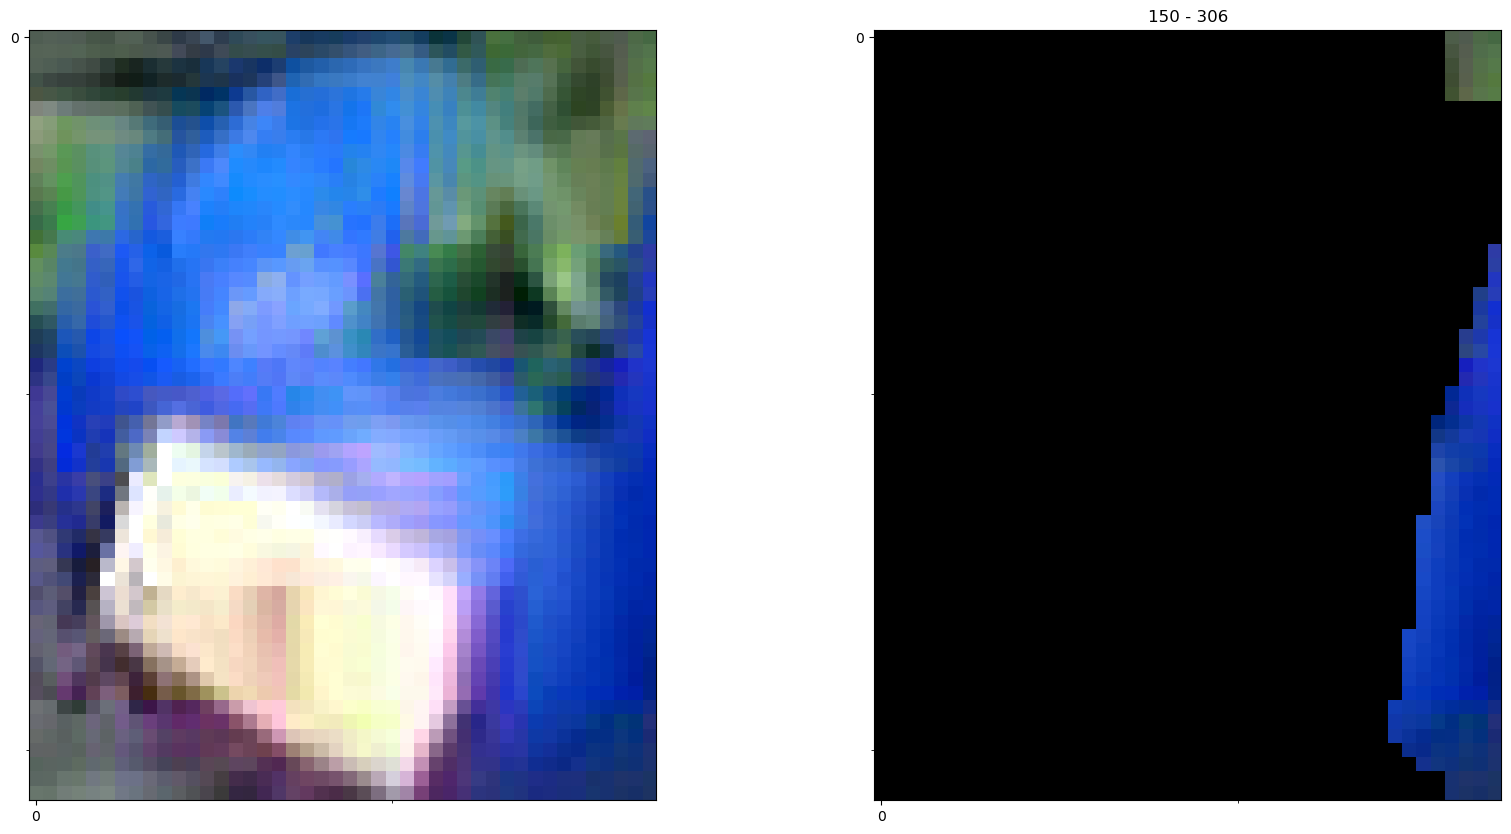

  6%|██████████▍                                                                                                                                                                                 | 1/18 [00:00<00:03,  4.69it/s]

pix size mean: width - 45.859117340978685, height - 35.46477384749147
pix size median: width - 45.970036400298866, height - 35.550552196100284
pix size mean filtered: width - 45.617382334120485, height - 35.14506001343196
pix size median filtered: width - 45.77032497724551, height - 35.26289181561369
margin 2: width - 31.42402693629265, height - 40.918536484241486
margin 5: width - 31.823907047510147, height - 40.54800048470497
margin 8: width - 24.038467556238174, height - 38.76630216836929
margin 2 filtered: width - 29.562558978796005, height - 39.029475301504135
margin 5 filtered: width - 31.9141186773777, height - 39.31119665503502
margin 8 filtered: width - 24.216512218117714, height - 38.76630216836929


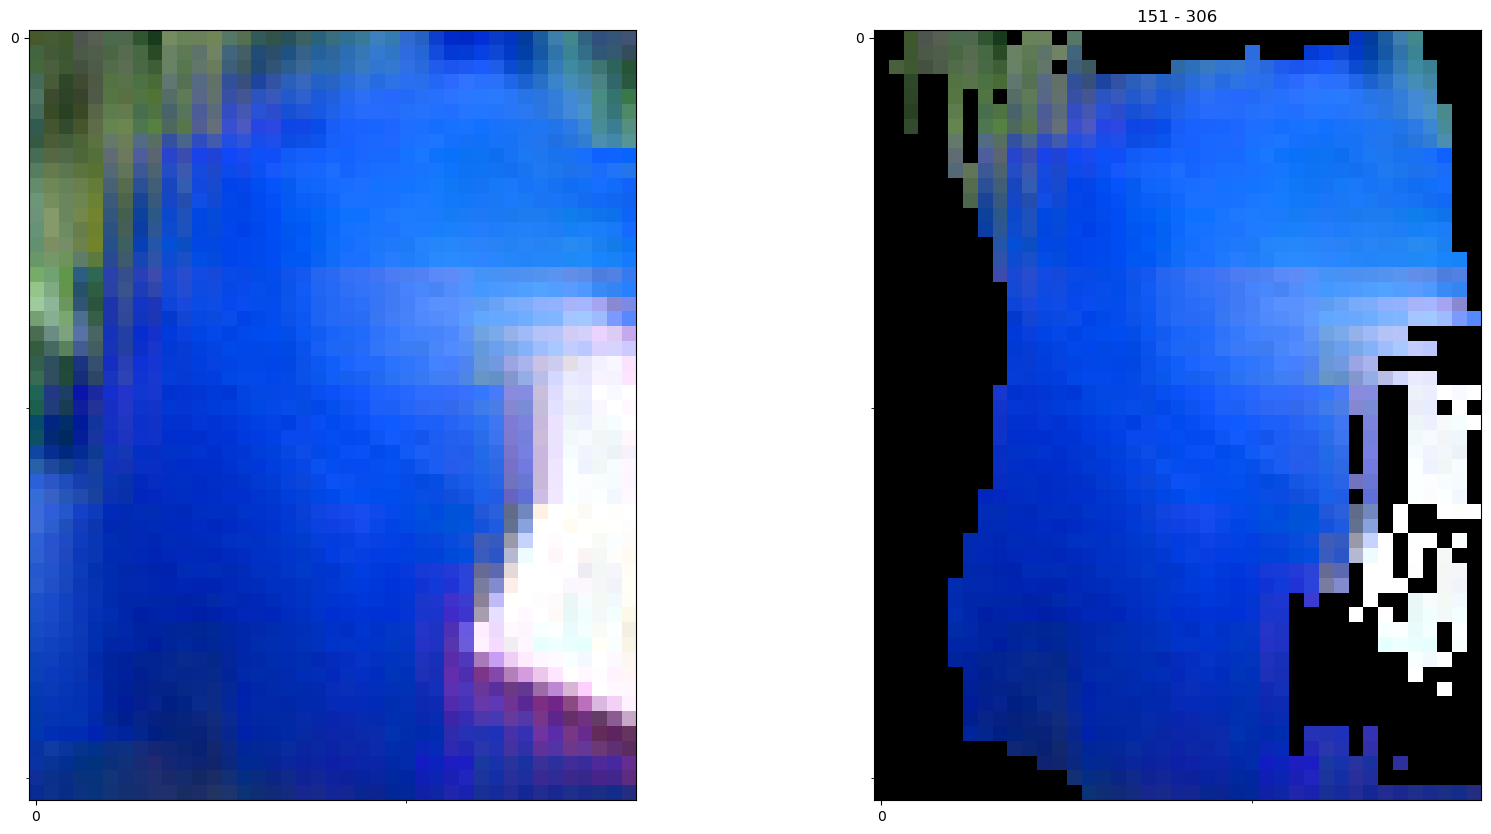

 11%|████████████████████▉                                                                                                                                                                       | 2/18 [00:00<00:02,  5.73it/s]

pix size mean: width - 50.502023142447385, height - 53.35959077392667
pix size median: width - 51.35092317286303, height - 54.25652431069186
pix size mean filtered: width - 50.123922560941025, height - 53.18446720873028
pix size median filtered: width - 51.054665686807255, height - 54.17204110016306
margin 2: width - 49.4873970746994, height - 53.59278991818428
margin 5: width - 49.4873970746994, height - 53.67659777402878
margin 8: width - 48.32623153924942, height - 53.14232036471367
margin 2 filtered: width - 62.143322080373764, height - 53.80406603217125
margin 5 filtered: width - 54.29127439856529, height - 53.67659777402878
margin 8 filtered: width - 50.81507936120033, height - 53.14232036471367


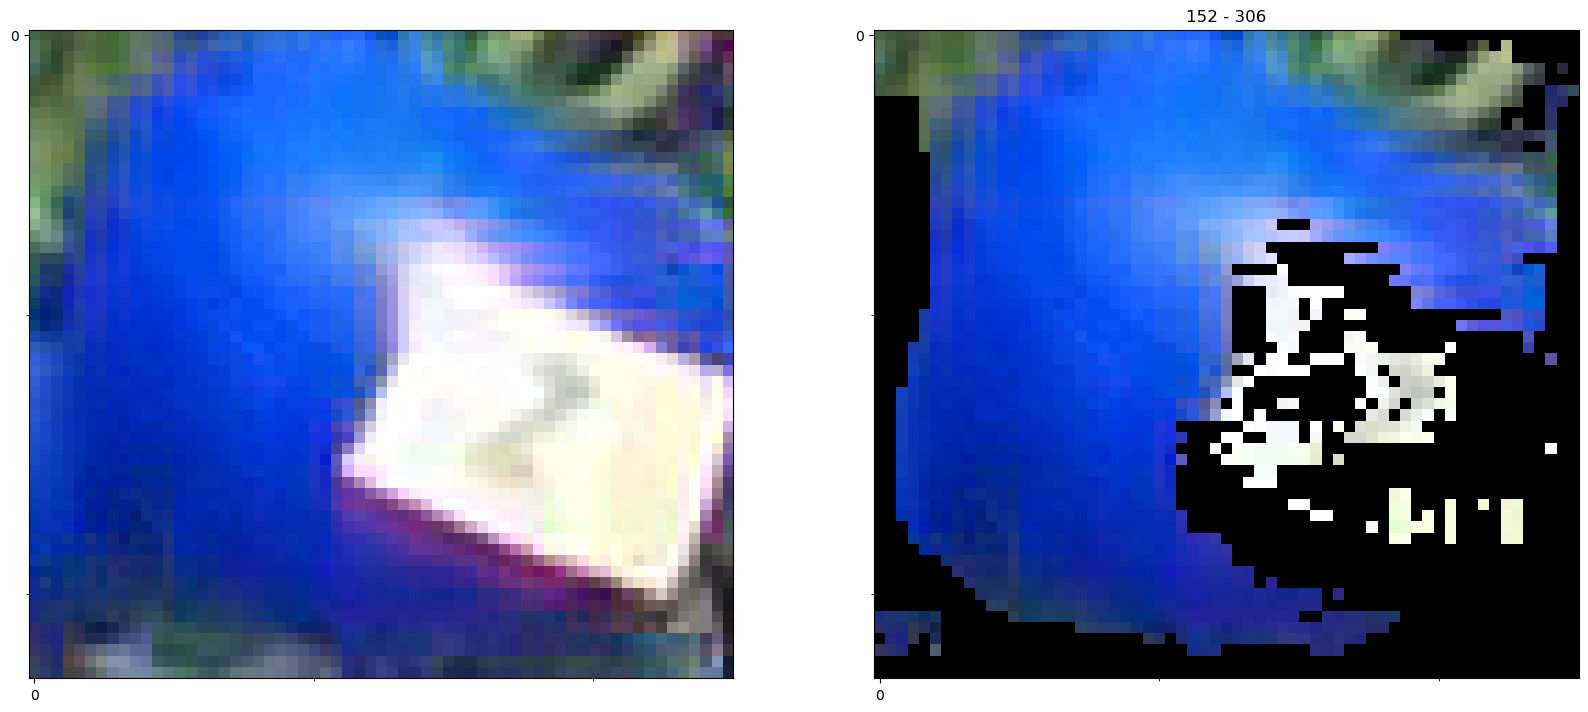

 17%|███████████████████████████████▎                                                                                                                                                            | 3/18 [00:00<00:02,  6.07it/s]

pix size mean: width - 55.242059999154925, height - 49.75112681669298
pix size median: width - 56.10905765140881, height - 50.53194690464257
pix size mean filtered: width - 55.417552360309884, height - 49.71950505593624
pix size median filtered: width - 56.214109143661204, height - 50.43415966138832
margin 2: width - 53.21396887302399, height - 56.519292294979095
margin 5: width - 50.79645663499832, height - 58.52802470326424
margin 8: width - 49.514349550008774, height - 54.20830845832825
margin 2 filtered: width - 54.971713572740555, height - 57.92565643787384
margin 5 filtered: width - 52.84538492560387, height - 58.52802470326424
margin 8 filtered: width - 50.54359883069992, height - 54.20830845832825


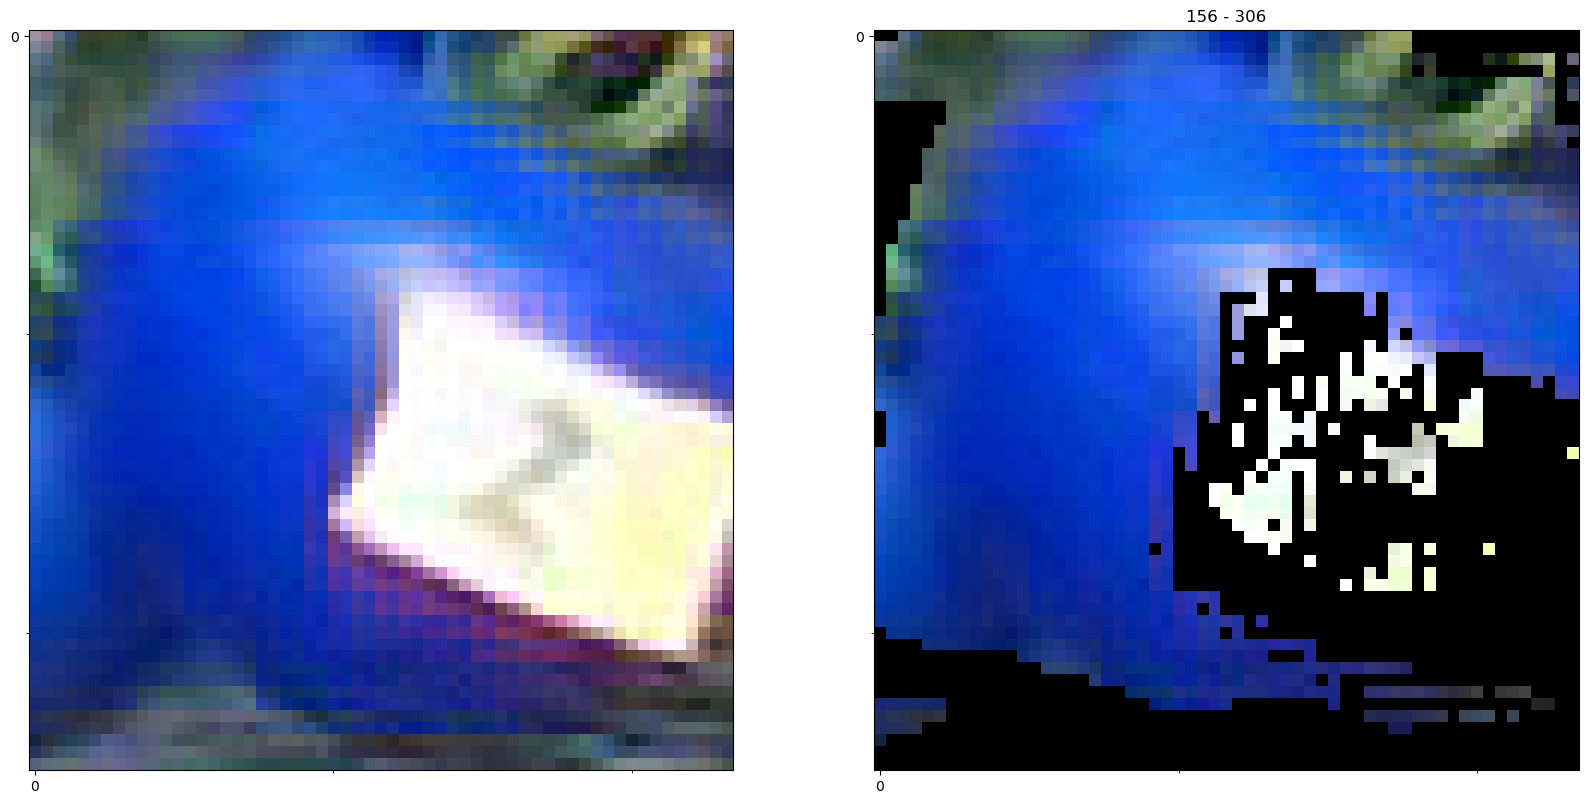

 22%|█████████████████████████████████████████▊                                                                                                                                                  | 4/18 [00:00<00:02,  5.90it/s]

pix size mean: width - 54.15717926187115, height - 50.128404720182886
pix size median: width - 55.55934040416044, height - 51.42625852611543
pix size mean filtered: width - 54.13776356271344, height - 49.75134222925456
pix size median filtered: width - 55.52110760865829, height - 51.02260314809317
margin 2: width - 56.984249502420425, height - 53.997885435819626
margin 5: width - 56.810133159160614, height - 54.37687411904335
margin 8: width - 53.837671875953674, height - 46.307891607284546
margin 2 filtered: width - 56.60033971071243, height - 53.32627892494202
margin 5 filtered: width - 56.810133159160614, height - 54.19047176837921
margin 8 filtered: width - 54.727647453546524, height - 46.91881313920021


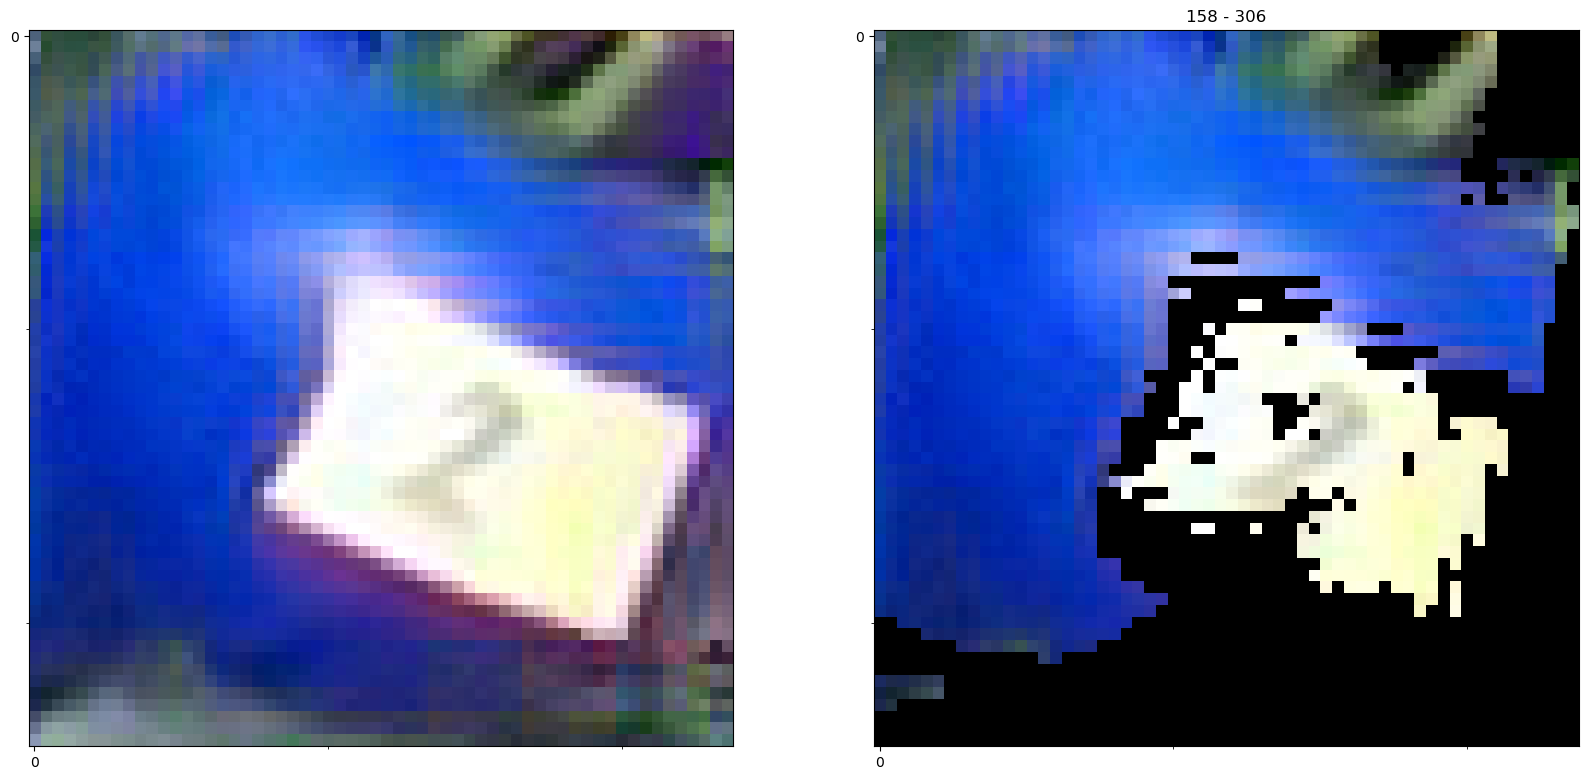

 28%|████████████████████████████████████████████████████▏                                                                                                                                       | 5/18 [00:00<00:02,  5.81it/s]

pix size mean: width - 54.33585536580537, height - 52.62160253075556
pix size median: width - 55.92045372516351, height - 54.156208077602344
pix size mean filtered: width - 54.160391070180644, height - 52.19179356837407
pix size median filtered: width - 55.67304721492465, height - 53.649468368840516
margin 2: width - 59.831567108631134, height - 51.601678133010864
margin 5: width - 55.66398799419403, height - 50.90548098087311
margin 8: width - 49.03768375515938, height - 44.39139738678932
margin 2 filtered: width - 58.16001072525978, height - 50.384264439344406
margin 5 filtered: width - 55.66398799419403, height - 50.735242664813995
margin 8 filtered: width - 48.84645715355873, height - 30.58829717338085


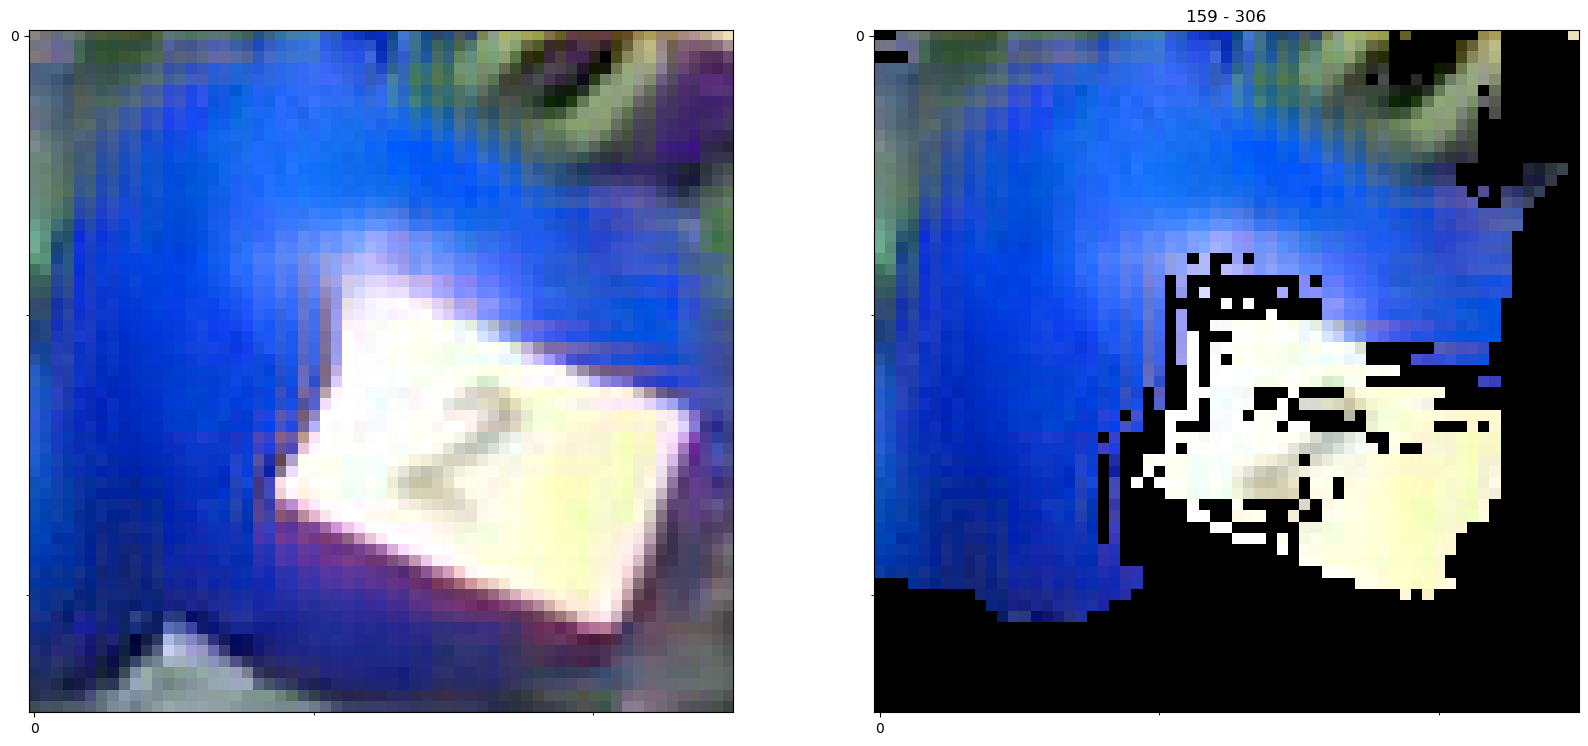

 33%|██████████████████████████████████████████████████████████████▋                                                                                                                             | 6/18 [00:01<00:02,  5.73it/s]

pix size mean: width - 56.0328940355607, height - 53.234154481834736
pix size median: width - 57.892378308638385, height - 55.000760950291195
pix size mean filtered: width - 56.00073359599613, height - 52.819882398369344
pix size median filtered: width - 57.79404917915355, height - 54.51133735124357
margin 2: width - 48.37002977728844, height - 59.00108069181442
margin 5: width - 48.3534075319767, height - 59.38578397035599
margin 8: width - 48.30968379974365, height - 54.14234474301338
margin 2 filtered: width - 48.74221235513687, height - 58.607976883649826
margin 5 filtered: width - 48.727717250585556, height - 59.38578397035599
margin 8 filtered: width - 48.71340095996857, height - 54.14234474301338


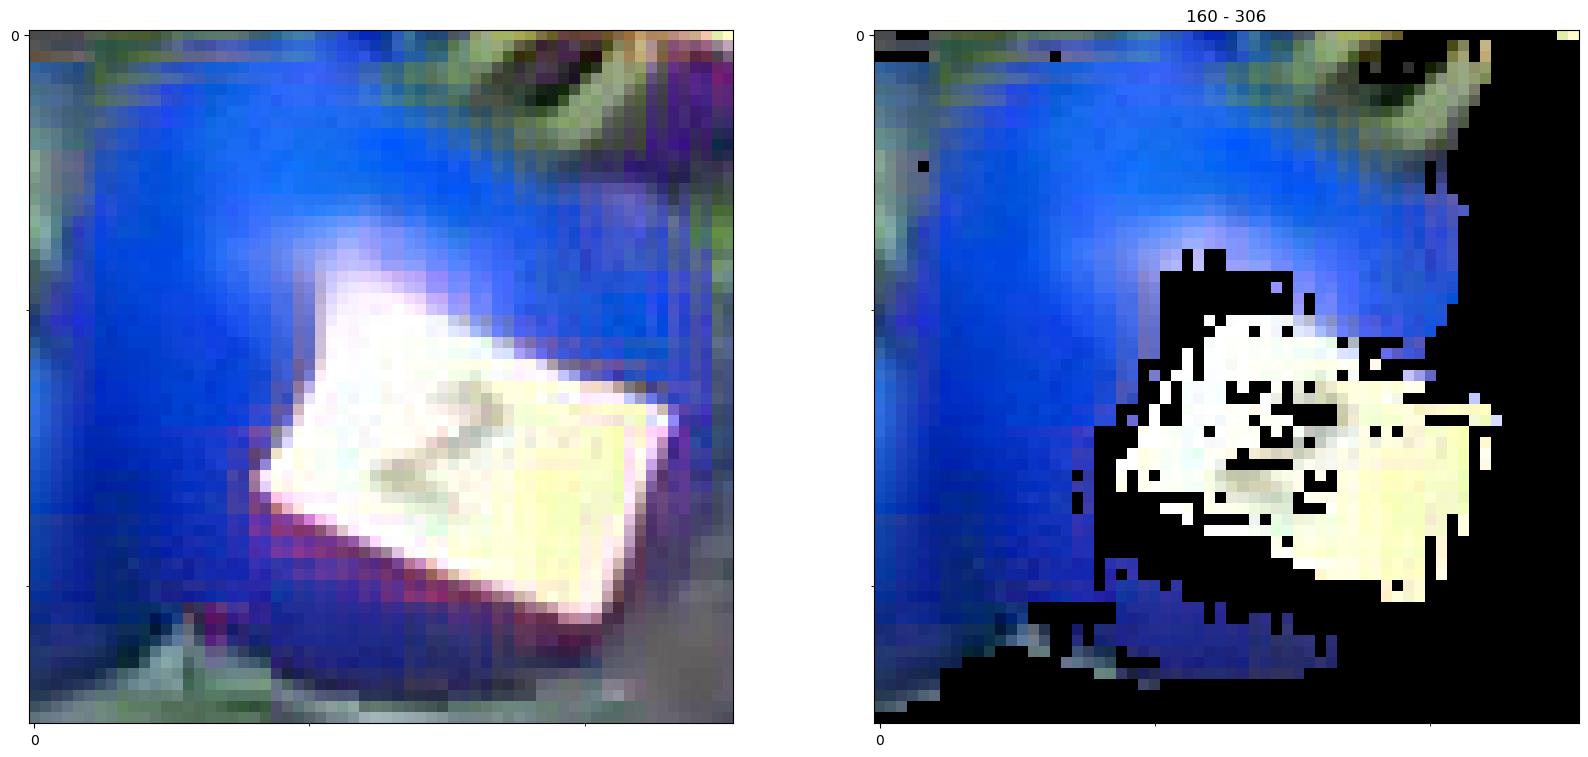

 39%|█████████████████████████████████████████████████████████████████████████                                                                                                                   | 7/18 [00:01<00:01,  5.61it/s]

pix size mean: width - 54.30286451925716, height - 51.54405668060018
pix size median: width - 56.421052076962376, height - 53.554631638313175
pix size mean filtered: width - 54.26281023403995, height - 51.148821294110256
pix size median filtered: width - 56.1479883114481, height - 52.92581434281225
margin 2: width - 49.94934797286987, height - 41.824739426374435
margin 5: width - 49.97054114937782, height - 45.88576406240463
margin 8: width - 49.982670694589615, height - 48.74296113848686
margin 2 filtered: width - 49.763135612010956, height - 40.543731302022934
margin 5 filtered: width - 49.790024757385254, height - 40.65427556633949
margin 8 filtered: width - 49.80054870247841, height - 30.906854197382927


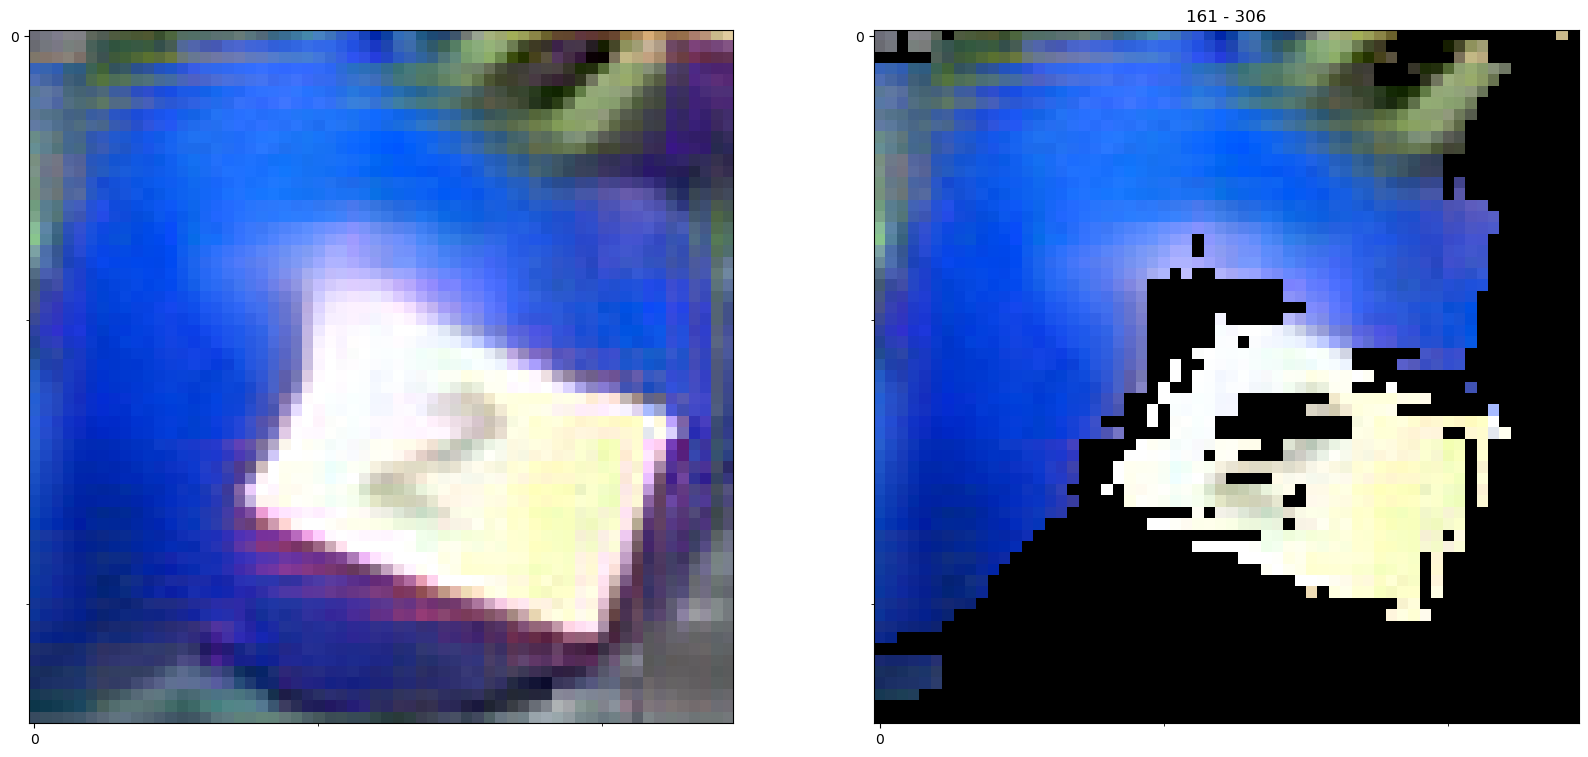

 44%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 8/18 [00:01<00:01,  5.53it/s]

pix size mean: width - 56.02533210170745, height - 55.59609745201926
pix size median: width - 58.06889652113985, height - 57.62400522784448
pix size mean filtered: width - 55.98633987148376, height - 55.07675428046495
pix size median filtered: width - 57.765518218699164, height - 56.827027094791575
margin 2: width - 65.15266001224518, height - 58.99486318230629
margin 5: width - 55.24929240345955, height - 39.15398567914963
margin 8: width - 54.3520450592041, height - 39.94515910744667
margin 2 filtered: width - 63.785821199417114, height - 58.00008773803711
margin 5 filtered: width - 55.50038069486618, height - 38.02979364991188
margin 8 filtered: width - 54.3520450592041, height - 31.852230429649353


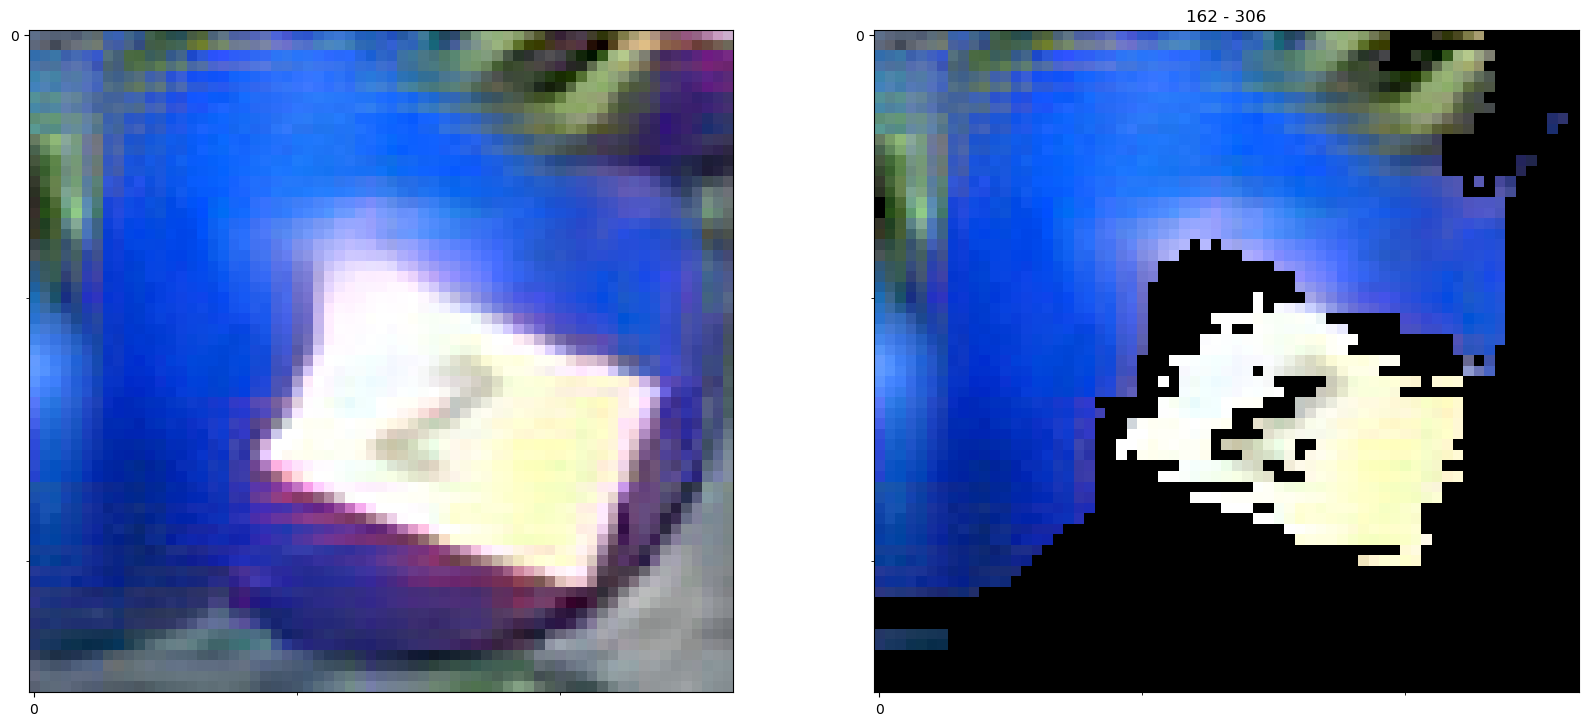

 50%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 9/18 [00:01<00:01,  5.52it/s]

pix size mean: width - 55.86257349385823, height - 52.158360164346874
pix size median: width - 57.5211275148558, height - 53.70693647525974
pix size mean filtered: width - 55.85051508615903, height - 51.68995494275499
pix size median filtered: width - 57.592267447502174, height - 53.301956209715186
margin 2: width - 61.38685718178749, height - 60.474880039691925
margin 5: width - 55.4056242108345, height - 60.5061873793602
margin 8: width - 53.32869663834572, height - 60.16860529780388
margin 2 filtered: width - 61.478134244680405, height - 60.206588357687
margin 5 filtered: width - 55.4056242108345, height - 60.5061873793602
margin 8 filtered: width - 53.32869663834572, height - 60.16860529780388


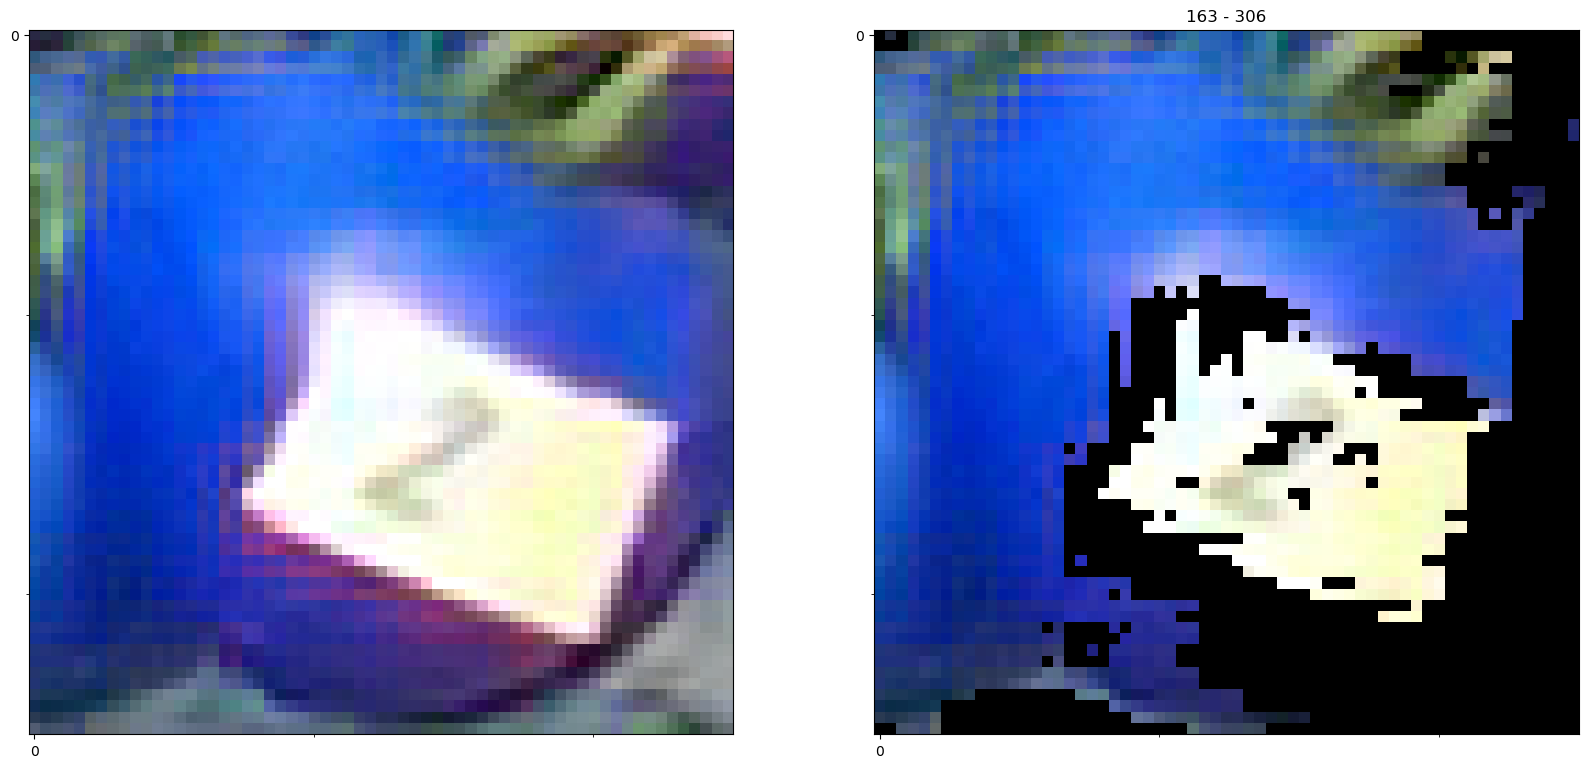

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10/18 [00:01<00:01,  5.51it/s]

pix size mean: width - 55.68419129655033, height - 51.247266185293725
pix size median: width - 57.42966755705133, height - 52.853662623119845
pix size mean filtered: width - 55.698935414786376, height - 50.851205246490906
pix size median filtered: width - 57.512034652563045, height - 52.50650226044351
margin 2: width - 60.71585416793823, height - 57.90020525455475
margin 5: width - 54.02282252907753, height - 57.71466717123985
margin 8: width - 50.72101950645447, height - 57.543251663446426
margin 2 filtered: width - 54.03536930680275, height - 57.63103812932968
margin 5 filtered: width - 54.02282252907753, height - 57.71466717123985
margin 8 filtered: width - 50.898227840662, height - 57.543251663446426


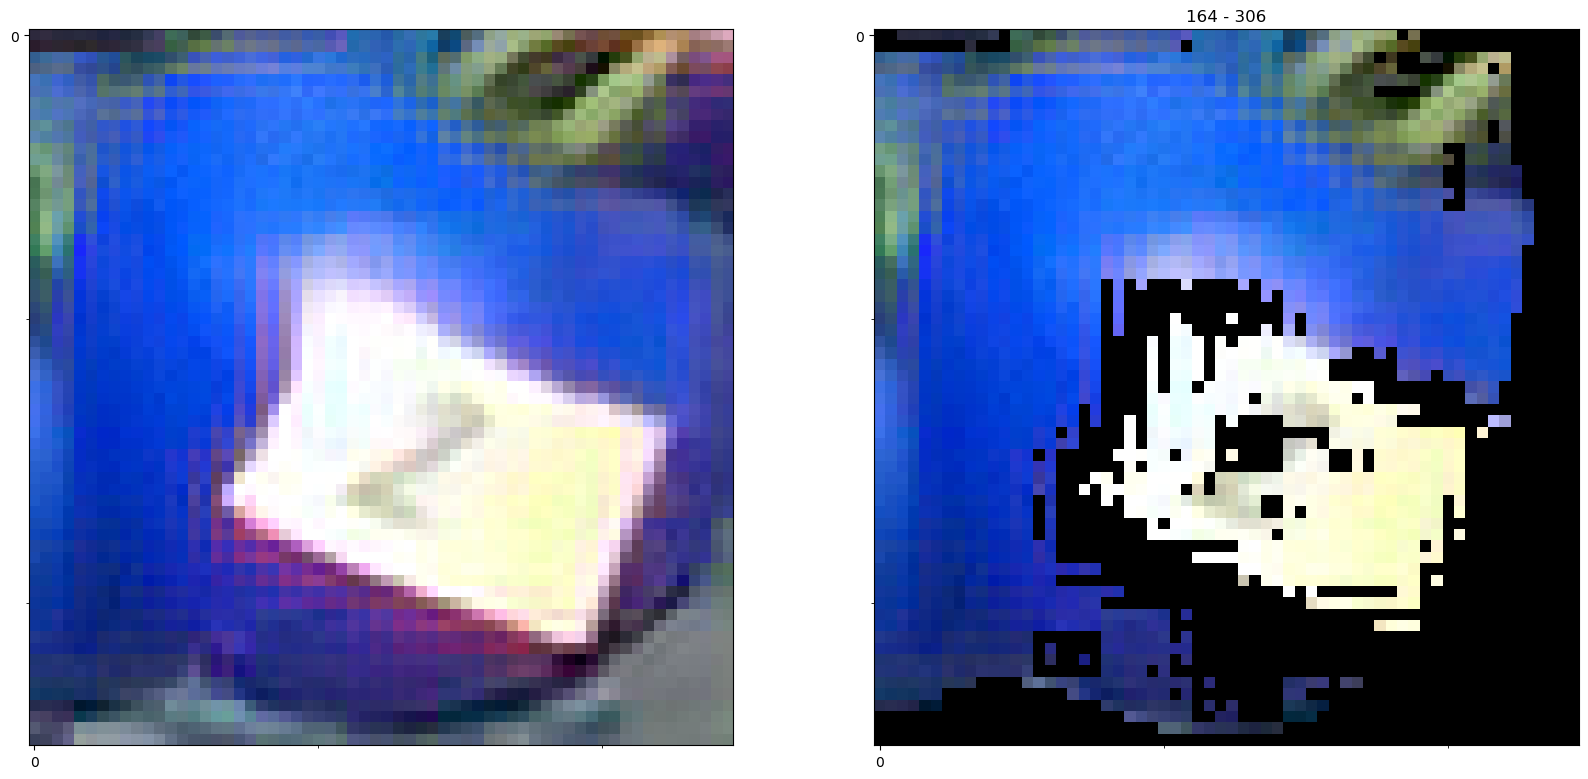

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11/18 [00:01<00:01,  5.48it/s]

pix size mean: width - 57.10017217475194, height - 51.79598476465536
pix size median: width - 57.30244597760175, height - 51.979468814031506
pix size mean filtered: width - 57.0825022316165, height - 51.77995622970397
pix size median filtered: width - 57.1866538854773, height - 51.87443295842691
margin 2: width - 49.76131394505501, height - 49.503643065690994
margin 5: width - 49.808792769908905, height - 49.280740320682526
margin 8: width - 49.808625131845474, height - 50.00900849699974
margin 2 filtered: width - 49.782540649175644, height - 49.503643065690994
margin 5 filtered: width - 49.82365295290947, height - 49.280740320682526
margin 8 filtered: width - 49.82307553291321, height - 50.00900849699974


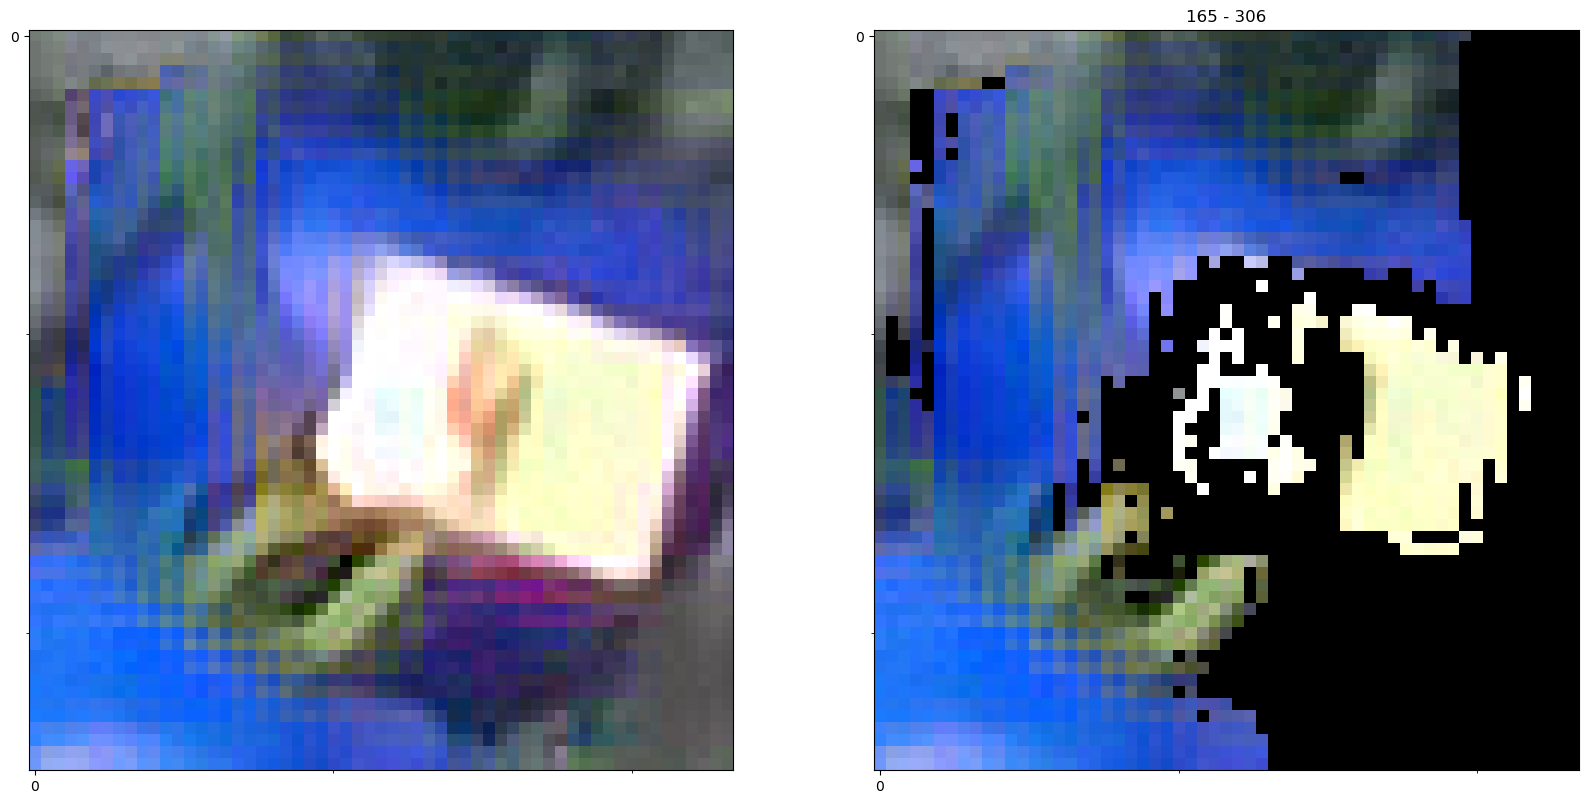

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12/18 [00:02<00:01,  5.42it/s]

pix size mean: width - 52.88456739909542, height - 51.1972800823597
pix size median: width - 53.33770523660982, height - 51.63596051266488
pix size mean filtered: width - 52.85042227963308, height - 50.95471618450147
pix size median filtered: width - 53.241505496905226, height - 51.331771532047895
margin 2: width - 47.31221869587898, height - 44.84153538942337
margin 5: width - 47.38757014274597, height - 44.9879951775074
margin 8: width - 47.449059784412384, height - 45.96414789557457
margin 2 filtered: width - 47.31221869587898, height - 44.84153538942337
margin 5 filtered: width - 47.38757014274597, height - 44.9879951775074
margin 8 filtered: width - 47.449059784412384, height - 45.96414789557457


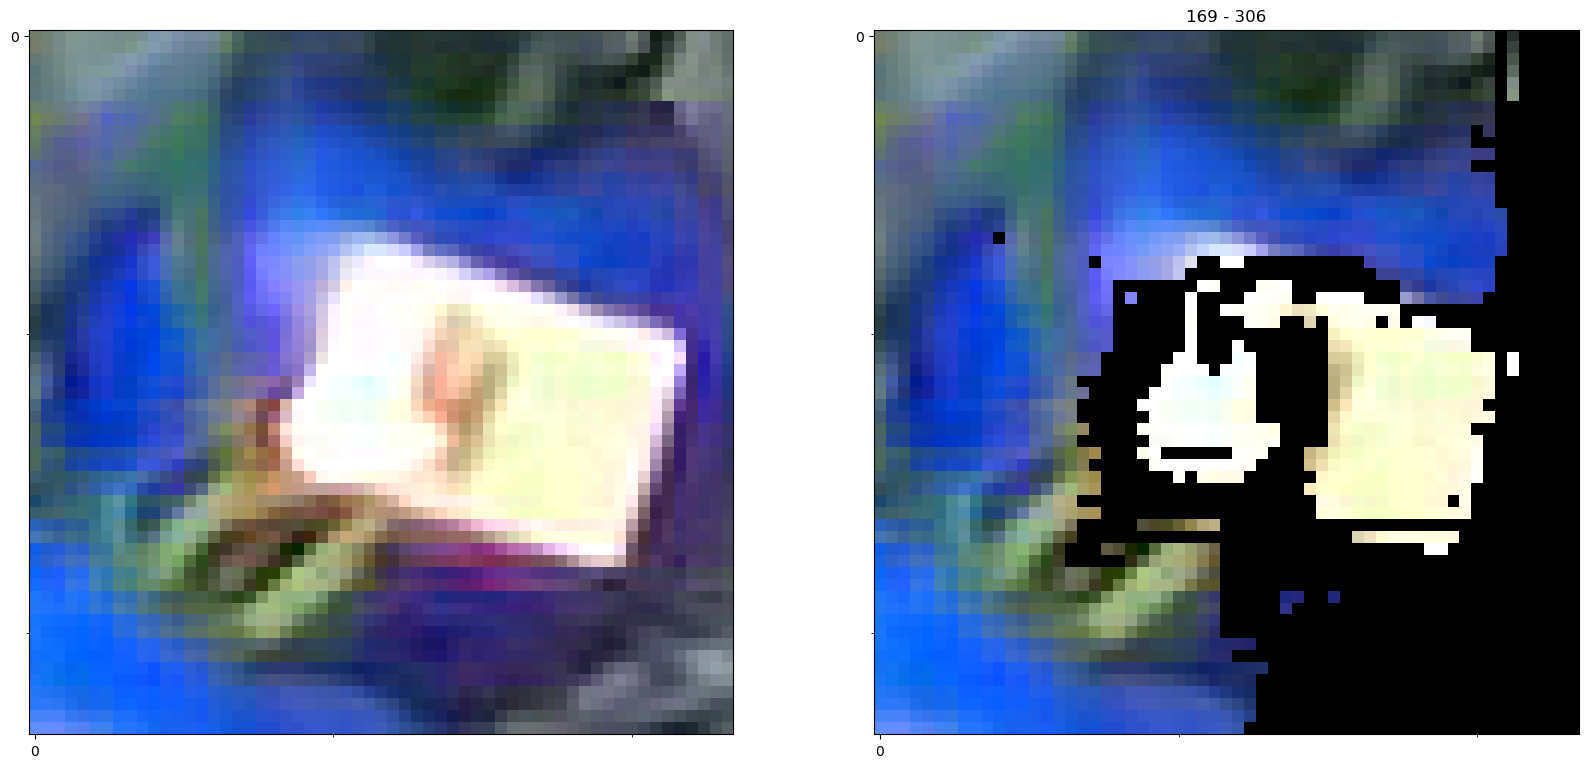

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13/18 [00:02<00:00,  5.29it/s]

pix size mean: width - 50.892516313196666, height - 51.285252505997356
pix size median: width - 51.30010374890546, height - 51.695985283090906
pix size mean filtered: width - 50.8842613699066, height - 50.936518119204635
pix size median filtered: width - 51.0690151591503, height - 51.12146164555338
margin 2: width - 46.39535769820213, height - 44.67807710170746
margin 5: width - 46.18474468588829, height - 44.137343764305115
margin 8: width - 46.11515998840332, height - 46.05043679475784
margin 2 filtered: width - 46.529125422239304, height - 44.67807710170746
margin 5 filtered: width - 46.300362795591354, height - 44.137343764305115
margin 8 filtered: width - 46.22489586472511, height - 46.05043679475784


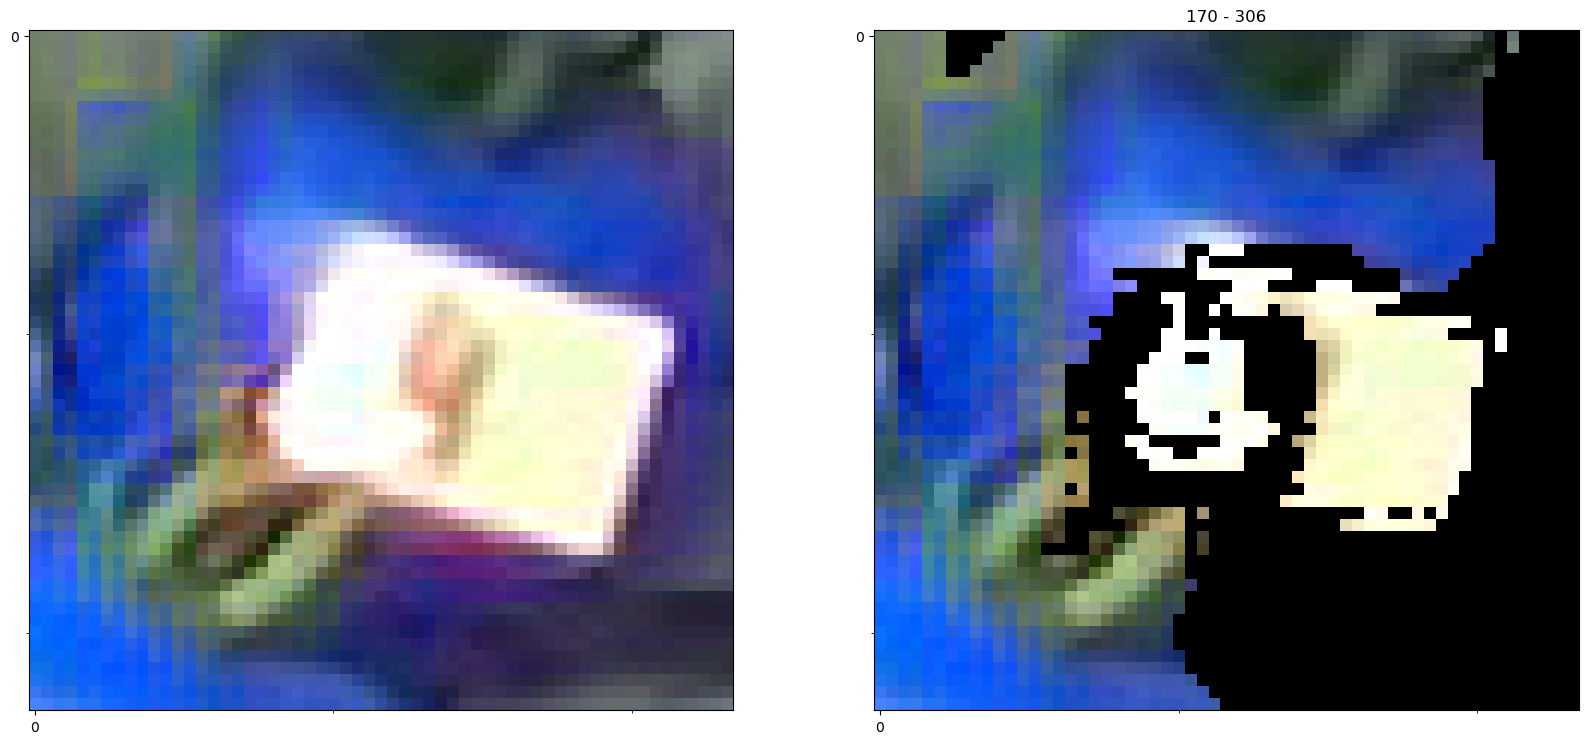

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14/18 [00:02<00:00,  5.13it/s]

pix size mean: width - 53.02794602610743, height - 46.80363292098801
pix size median: width - 53.50311904292098, height - 47.22303108968101
pix size mean filtered: width - 53.00950825444575, height - 46.78735933769082
pix size median filtered: width - 53.42500916809351, height - 47.154089594056636
margin 2: width - 45.64325138926506, height - 45.28145119547844
margin 5: width - 45.07745802402496, height - 45.07406800985336
margin 8: width - 45.40189728140831, height - 46.035487204790115
margin 2 filtered: width - 45.299556106328964, height - 45.28145119547844
margin 5 filtered: width - 44.98523473739624, height - 45.07406800985336
margin 8 filtered: width - 45.313529670238495, height - 46.035487204790115


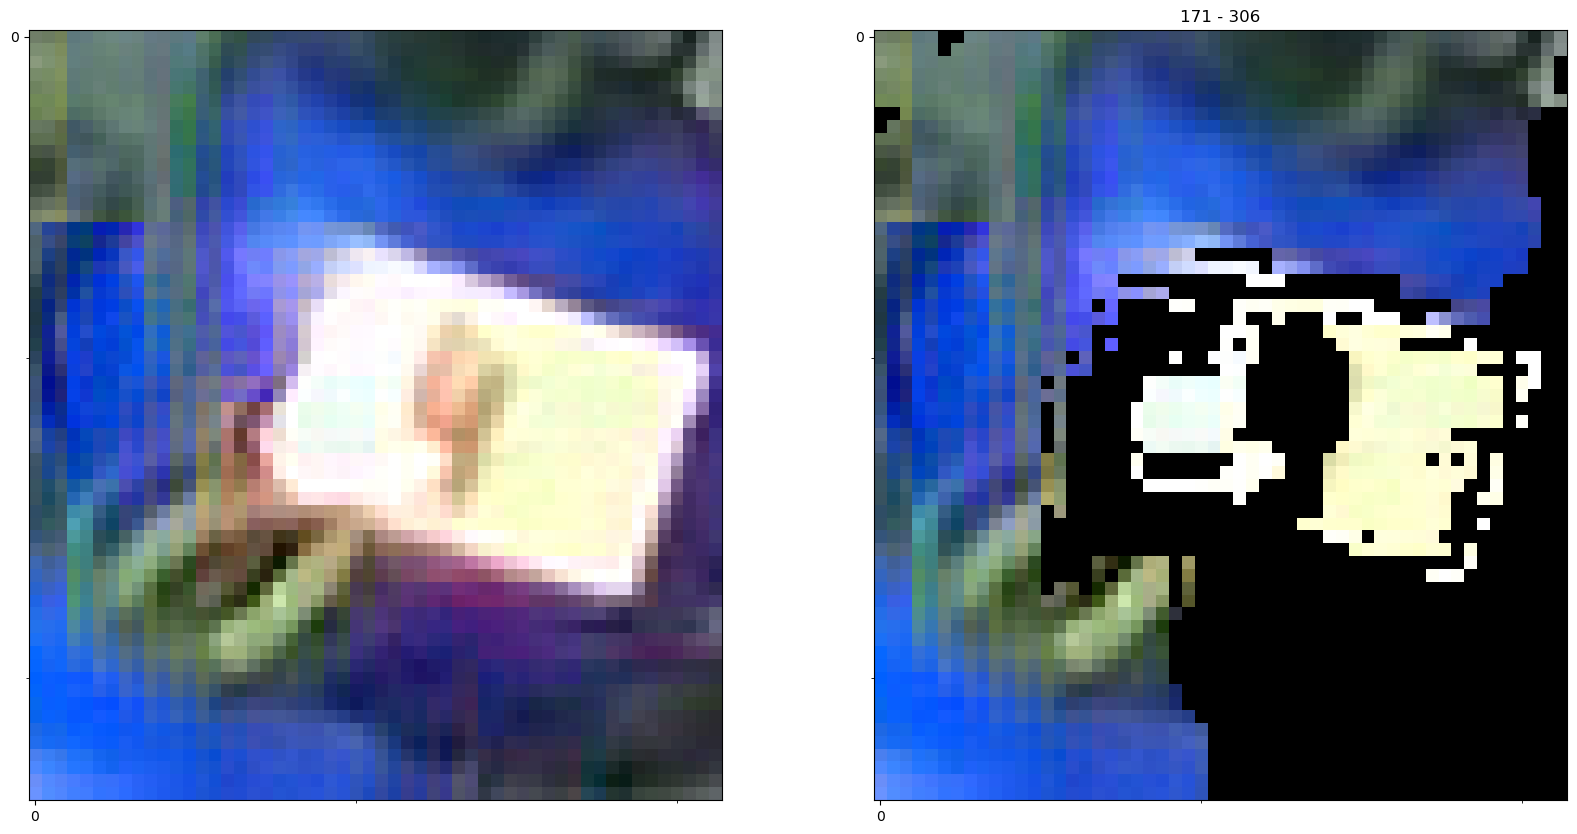

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15/18 [00:02<00:00,  4.97it/s]

pix size mean: width - 52.82062742346609, height - 49.65156613573403
pix size median: width - 53.05024354982334, height - 49.86740606115288
pix size mean filtered: width - 52.817664383207486, height - 49.43906754632664
pix size median filtered: width - 53.0426637549512, height - 49.64967434364379
margin 2: width - 45.86246982216835, height - 53.420454263687134
margin 5: width - 45.63497379422188, height - 53.474102169275284
margin 8: width - 45.54064944386482, height - 53.35095152258873
margin 2 filtered: width - 45.86246982216835, height - 54.18957769870758
margin 5 filtered: width - 45.63497379422188, height - 53.58453840017319
margin 8 filtered: width - 45.54064944386482, height - 53.40929329395294


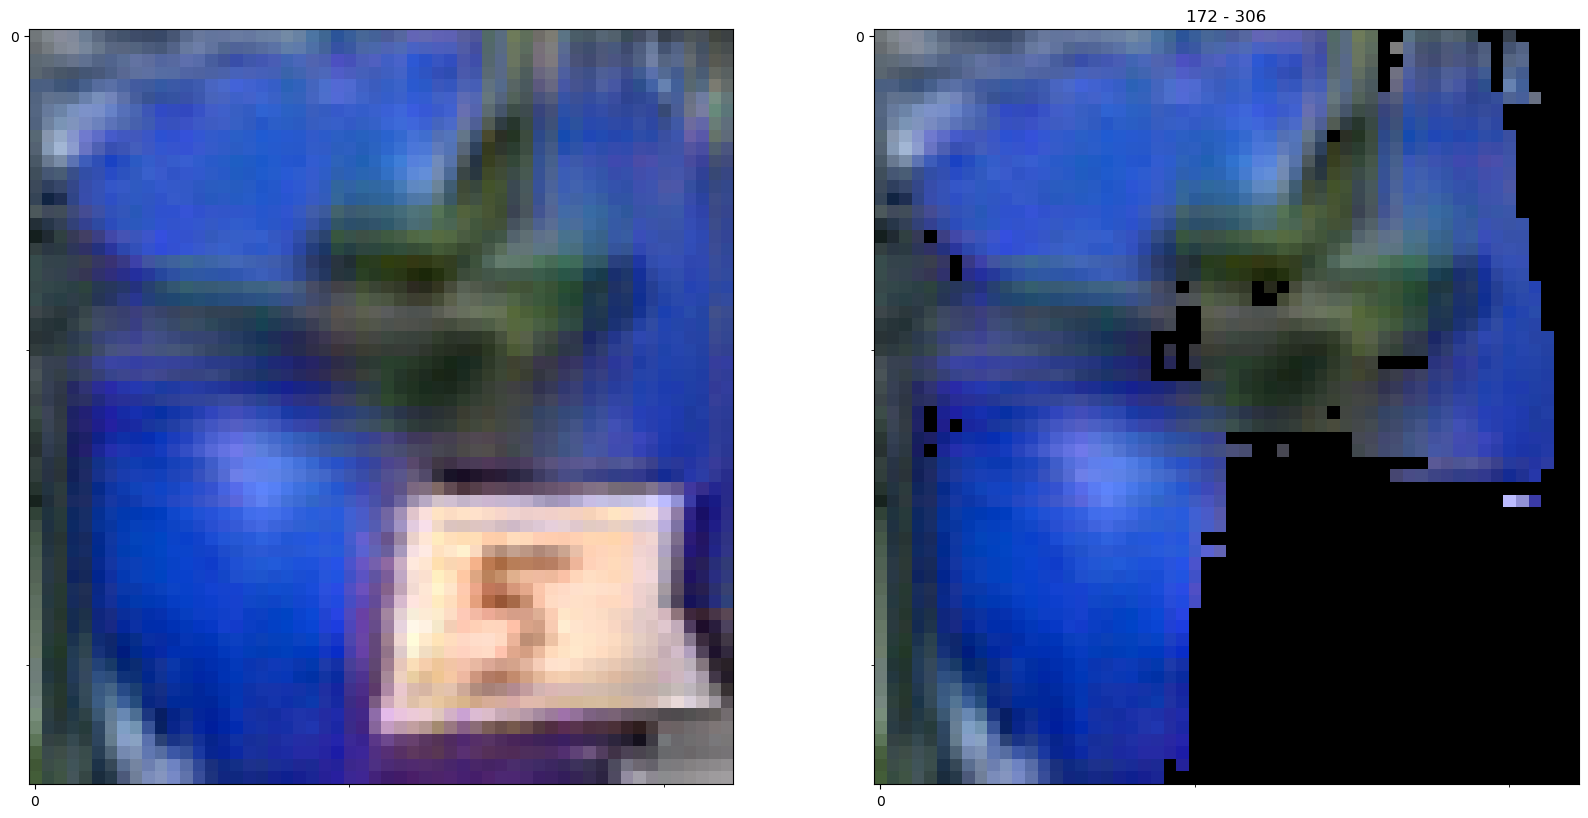

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 16/18 [00:03<00:00,  4.74it/s]

pix size mean: width - 58.52491583576737, height - 52.126175719991764
pix size median: width - 58.740272261241266, height - 52.31798645079543
pix size mean filtered: width - 58.599574518517684, height - 51.98733419147784
pix size median filtered: width - 58.82509396627962, height - 52.18740654684573
margin 2: width - 50.411492586135864, height - 60.618262737989426
margin 5: width - 50.28253421187401, height - 60.64779311418533
margin 8: width - 49.836166203022, height - 60.496460646390915
margin 2 filtered: width - 50.294917076826096, height - 61.0957071185112
margin 5 filtered: width - 50.18607899546623, height - 60.96625328063965
margin 8 filtered: width - 49.836166203022, height - 60.575224459171295


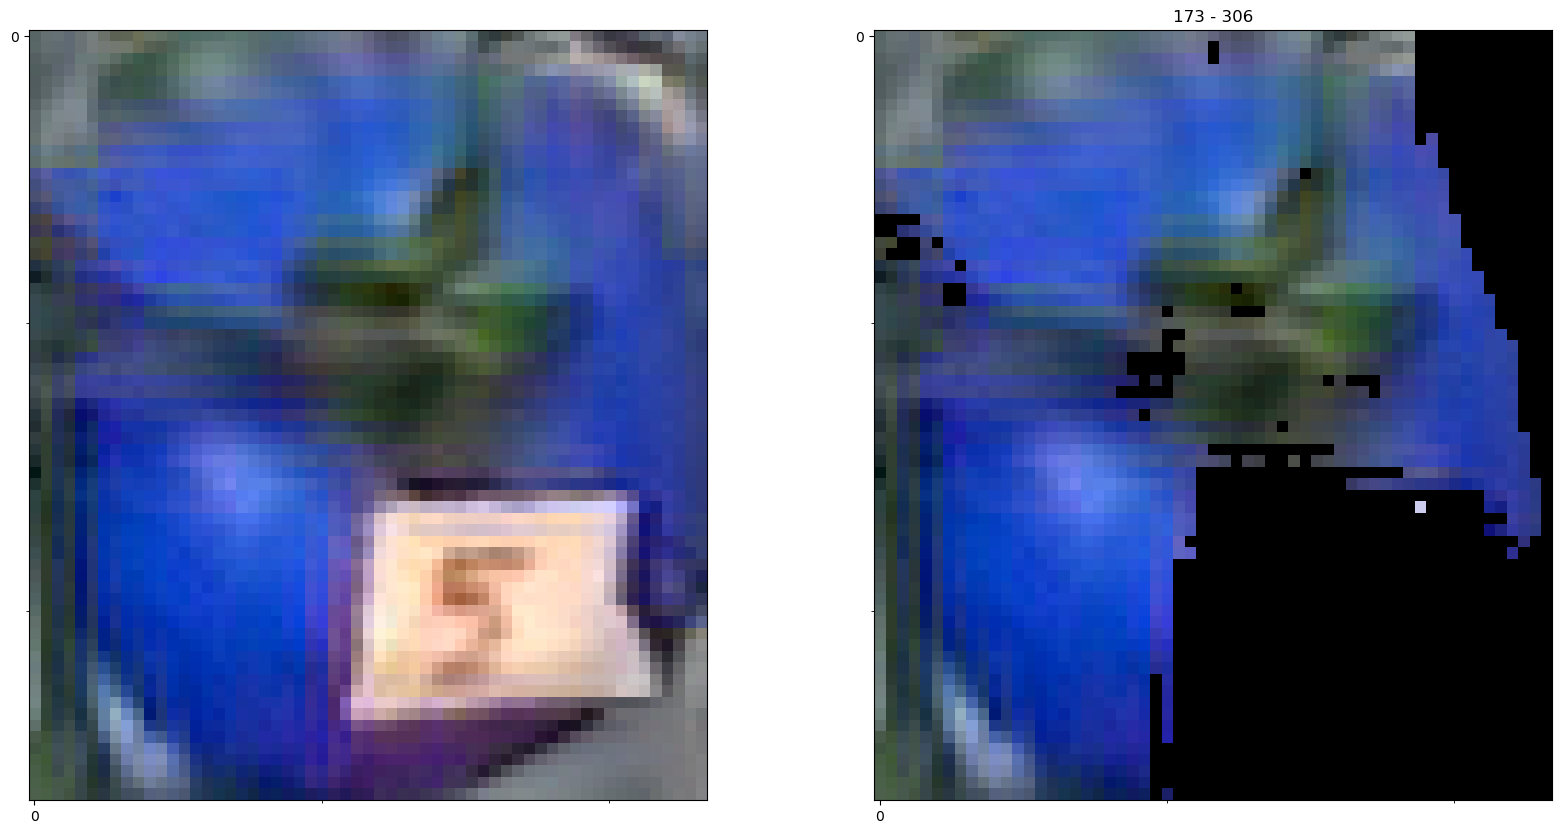

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 17/18 [00:03<00:00,  4.76it/s]

pix size mean: width - 55.40503462797345, height - 52.33512259421771
pix size median: width - 55.65482199651669, height - 52.57106960955622
pix size mean filtered: width - 55.576385857738146, height - 52.27201062365029
pix size median filtered: width - 55.839071856196576, height - 52.51907824221136
margin 2: width - 53.648725152015686, height - 58.96809697151184
margin 5: width - 52.496474236249924, height - 58.622103184461594
margin 8: width - 49.67234656214714, height - 58.309588581323624
margin 2 filtered: width - 53.8475327193737, height - 58.751076459884644
margin 5 filtered: width - 52.629970014095306, height - 58.64768847823143
margin 8 filtered: width - 49.67234656214714, height - 58.38090926408768


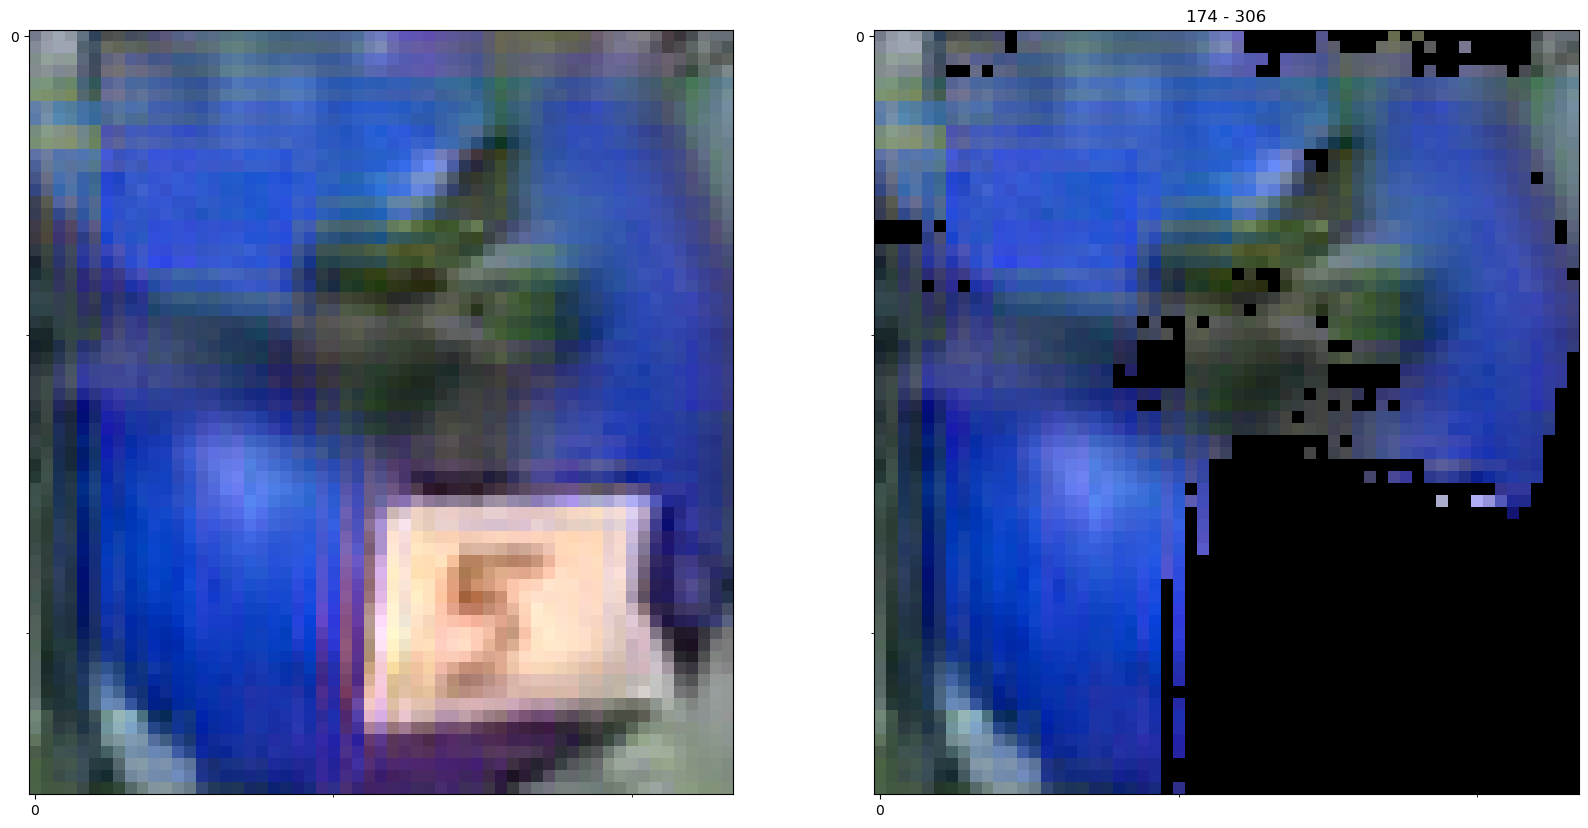

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.24it/s]
/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 53.75594594146909 3.023773171078747 49.9525637322241 4.892657056308083 
 pix med: 
 54.6757058016426 3.376869379577657 50.82581560276718 5.2914741132852985 
 pix mean filtered: 
 53.68760445566588 3.1531017056147395 49.67455720427687 4.896665016193681 
 pix med filtered: 
 54.55770229272775 3.4819848119539136 50.494951461777354 5.252335254286091 
 margin 0.2: 
 49.82920601550076 10.183261703898271 50.8067709290319 9.400211962453787 
 margin 0.5: 
 47.52818510557214 10.444142660586754 51.5826771802762 6.9856560606279245 
 margin 0.8: 
 45.545861668263875 11.77851709324799 50.445566063418106 6.479341322631566 
 margin_f0.2: 
 49.767049857311775 10.953475904309233 50.56581315067079 9.575225022839177 
 margin 0.5_f: 
 47.94280701834295 10.598524302180056 51.141815807889486 7.581761065200994 
 margin 0.8_f: 
 45.81416794098914 11.866773123224403 48.15657853203661 9.686167582836795


  0%|                                                                                                                                                                                                    | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)


pix size mean: width - 47.34069693597371, height - 54.60189496455864
pix size median: width - 48.04549884147165, height - 55.41480060612254
pix size mean filtered: width - 47.37847345464511, height - 54.38523614088333
pix size median filtered: width - 48.12235401848526, height - 55.23912857715586
margin 2: width - 51.99788138270378, height - 53.81707474589348
margin 5: width - 51.99788138270378, height - 51.83306708931923
margin 8: width - 49.97615143656731, height - 52.92950943112373
margin 2 filtered: width - 51.70969292521477, height - 53.30068618059158
margin 5 filtered: width - 51.70969292521477, height - 51.83306708931923
margin 8 filtered: width - 50.348322838544846, height - 52.92950943112373


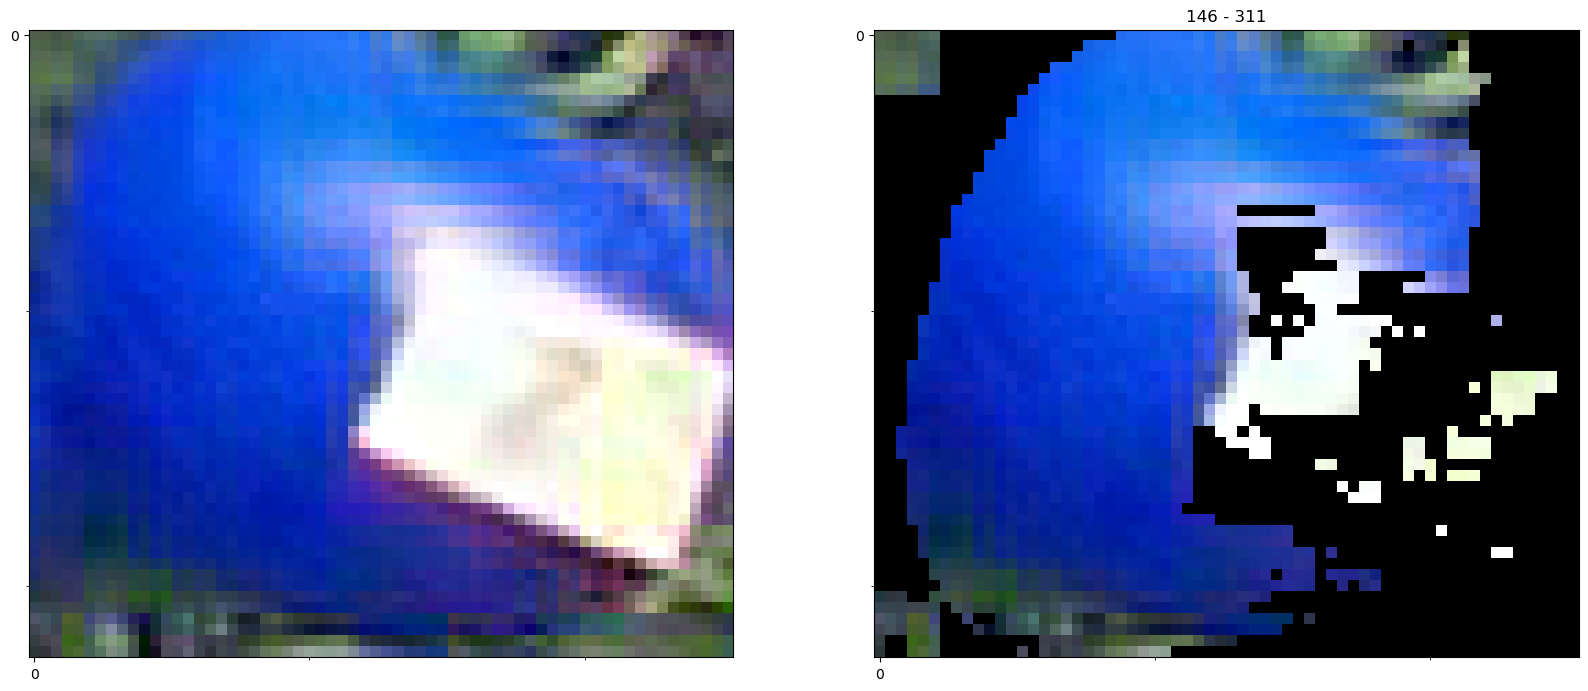

  5%|█████████▍                                                                                                                                                                                  | 1/20 [00:00<00:04,  4.01it/s]

pix size mean: width - 44.637586693727364, height - 31.011141193048747
pix size median: width - 44.70148155176672, height - 31.055530968816942
pix size mean filtered: width - 44.39146852067262, height - 30.744277666340693
pix size median filtered: width - 44.47630401295303, height - 30.803032332891433
margin 2: width - 33.47087651491165, height - 41.02586582303047
margin 5: width - 32.24271163344383, height - 42.15844348073006
margin 8: width - 26.62399783730507, height - 42.86973550915718
margin 2 filtered: width - 37.009742110967636, height - 39.288539439439774
margin 5 filtered: width - 35.69827973842621, height - 40.38126394152641
margin 8 filtered: width - 28.485063463449478, height - 42.21884161233902


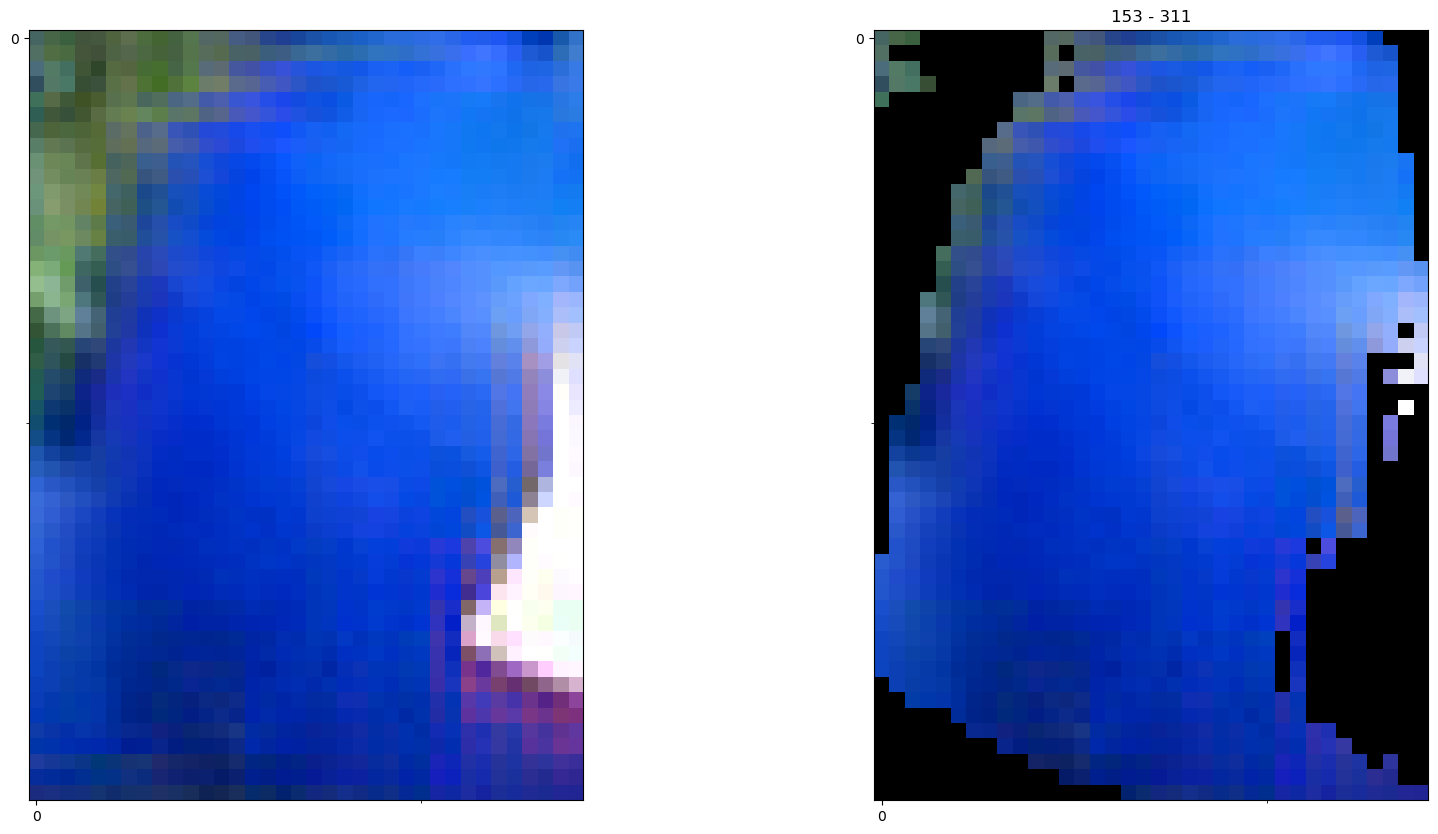

 10%|██████████████████▊                                                                                                                                                                         | 2/20 [00:00<00:03,  5.26it/s]

pix size mean: width - 46.85695935139903, height - 40.468700723037934
pix size median: width - 46.95735248575816, height - 40.55540672712495
pix size mean filtered: width - 46.83123773921084, height - 40.308136645394896
pix size median filtered: width - 46.94070407614952, height - 40.40235546771102
margin 2: width - 40.37202522158623, height - 47.62739688158035
margin 5: width - 37.55171224474907, height - 47.6079098880291
margin 8: width - 36.56573221087456, height - 47.47435450553894
margin 2 filtered: width - 43.83619502186775, height - 47.64466732740402
margin 5 filtered: width - 38.39714080095291, height - 47.6079098880291
margin 8 filtered: width - 35.811010748147964, height - 47.47435450553894


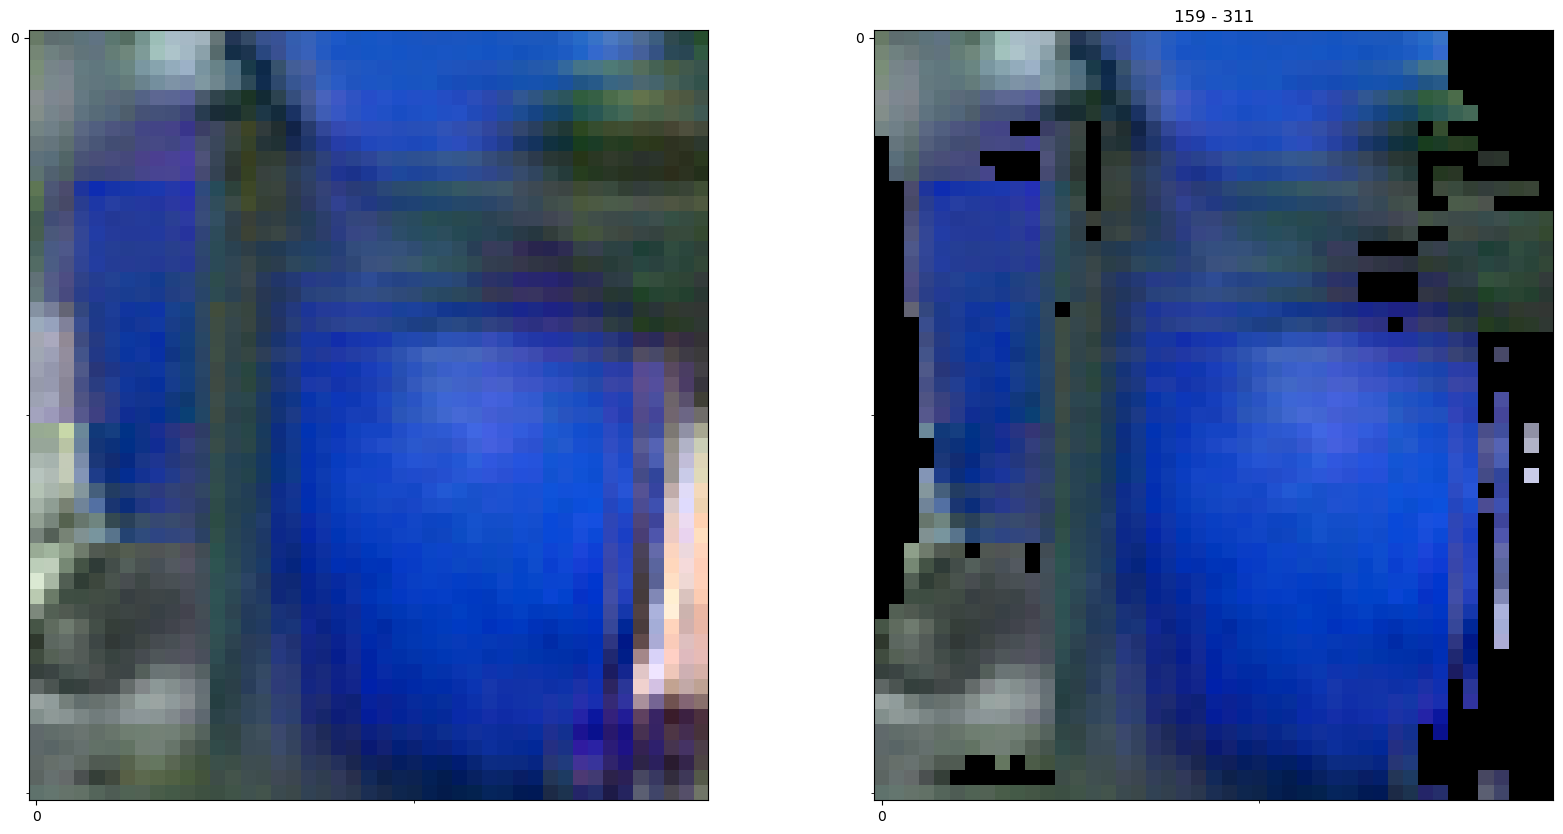

 15%|████████████████████████████▏                                                                                                                                                               | 3/20 [00:00<00:03,  4.60it/s]

pix size mean: width - 45.237835694434494, height - 37.76673230100693
pix size median: width - 45.34040132417328, height - 37.85235904733922
pix size mean filtered: width - 45.14324137793842, height - 37.385924466334295
pix size median filtered: width - 45.23459545851539, height - 37.461580459388685
margin 2: width - 37.947870790958405, height - 46.55144363641739
margin 5: width - 37.581317126750946, height - 46.03992775082588
margin 8: width - 37.55106404423714, height - 46.034082770347595
margin 2 filtered: width - 39.74086046218872, height - 46.228811144828796
margin 5 filtered: width - 39.39538449048996, height - 46.03992775082588
margin 8 filtered: width - 37.58389502763748, height - 46.034082770347595


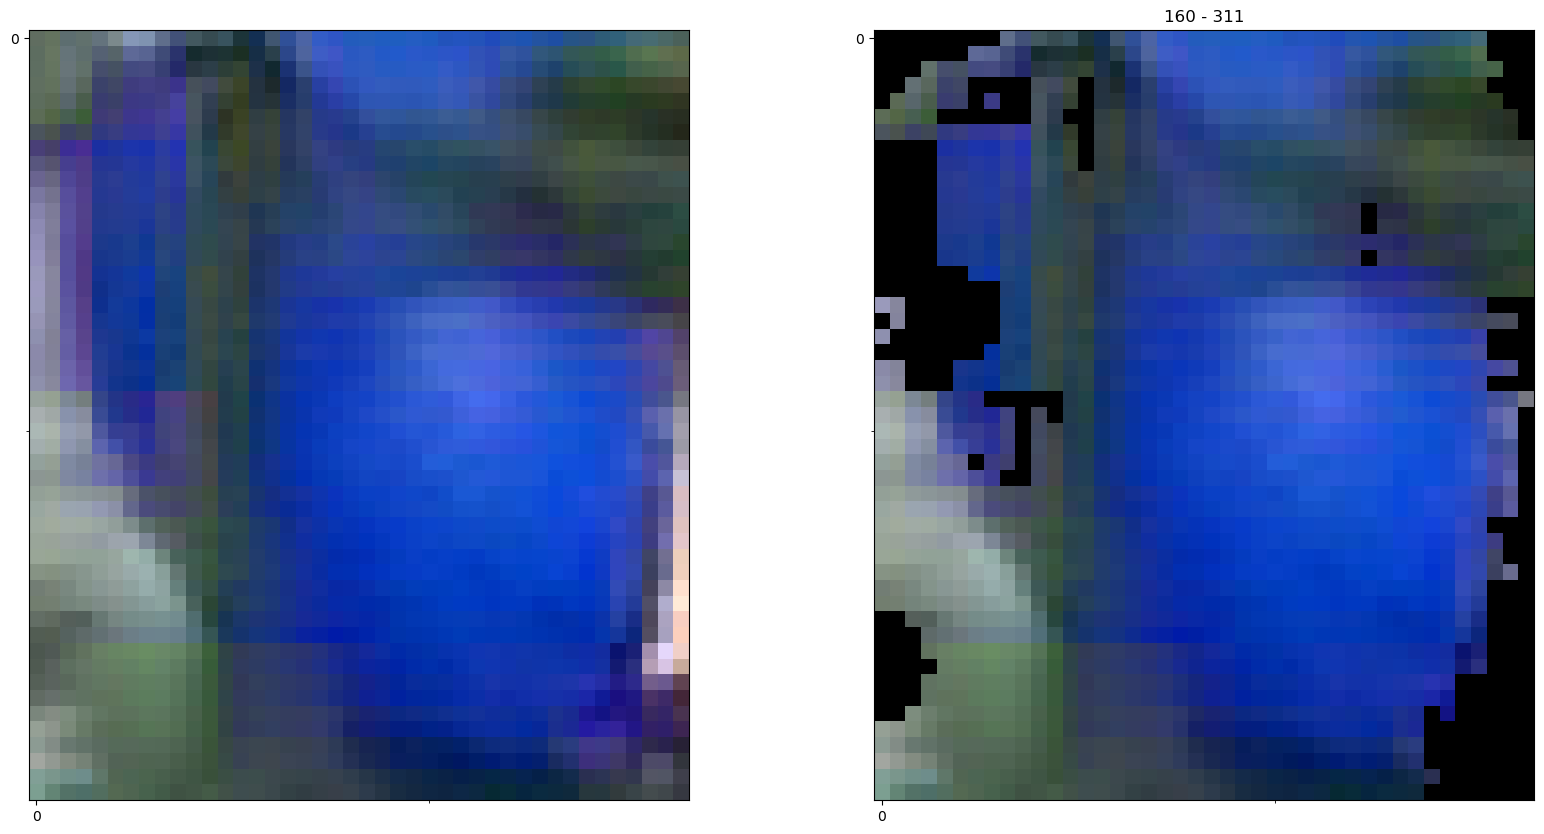

 20%|█████████████████████████████████████▌                                                                                                                                                      | 4/20 [00:00<00:03,  5.00it/s]

pix size mean: width - 51.7342041901863, height - 38.63814324101735
pix size median: width - 51.88276239126074, height - 38.749095233854455
pix size mean filtered: width - 51.67051661301153, height - 37.92250724553302
pix size median filtered: width - 51.8009280318059, height - 38.01822000976121
margin 2: width - 35.33874824643135, height - 54.60508540272713
margin 5: width - 36.09669581055641, height - 54.73046377301216
margin 8: width - 34.360870718955994, height - 54.93742972612381
margin 2 filtered: width - 36.40657290816307, height - 54.40356582403183
margin 5 filtered: width - 35.20657494664192, height - 54.73046377301216
margin 8 filtered: width - 32.87649154663086, height - 54.93742972612381


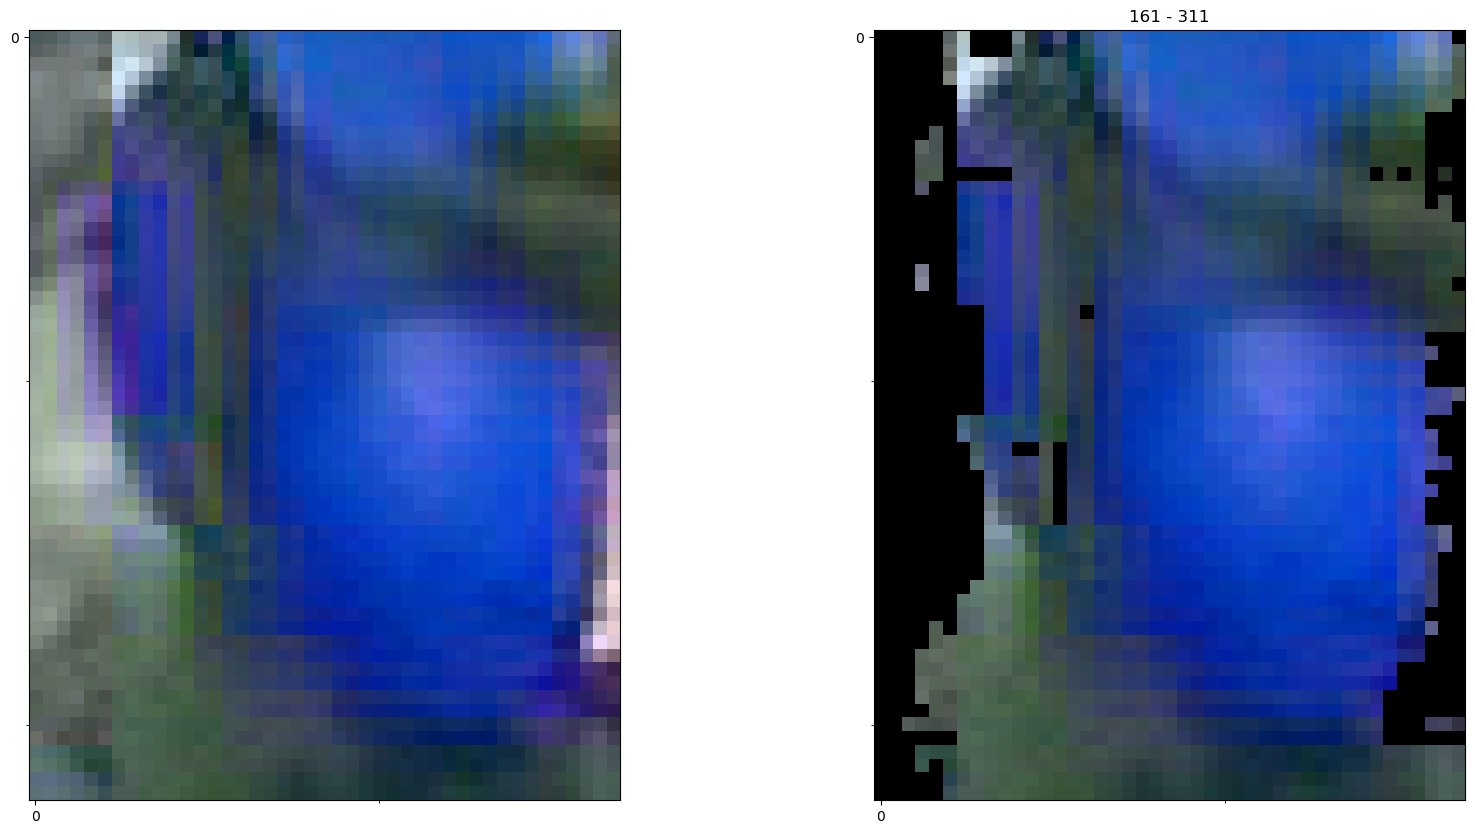

 25%|███████████████████████████████████████████████                                                                                                                                             | 5/20 [00:00<00:02,  5.24it/s]

pix size mean: width - 42.43976519977055, height - 35.9109670908495
pix size median: width - 42.46522430624979, height - 35.93250964959446
pix size mean filtered: width - 42.40099681924256, height - 35.808953957175305
pix size median filtered: width - 42.42555725272703, height - 35.829696003301315
margin 2: width - 35.569049417972565, height - 42.86131262779236
margin 5: width - 35.54164618253708, height - 41.816093027591705
margin 8: width - 35.54093465209007, height - 41.52948036789894
margin 2 filtered: width - 36.230918020009995, height - 41.68218746781349
margin 5 filtered: width - 36.80167347192764, height - 41.66165739297867
margin 8 filtered: width - 34.665390849113464, height - 41.52948036789894


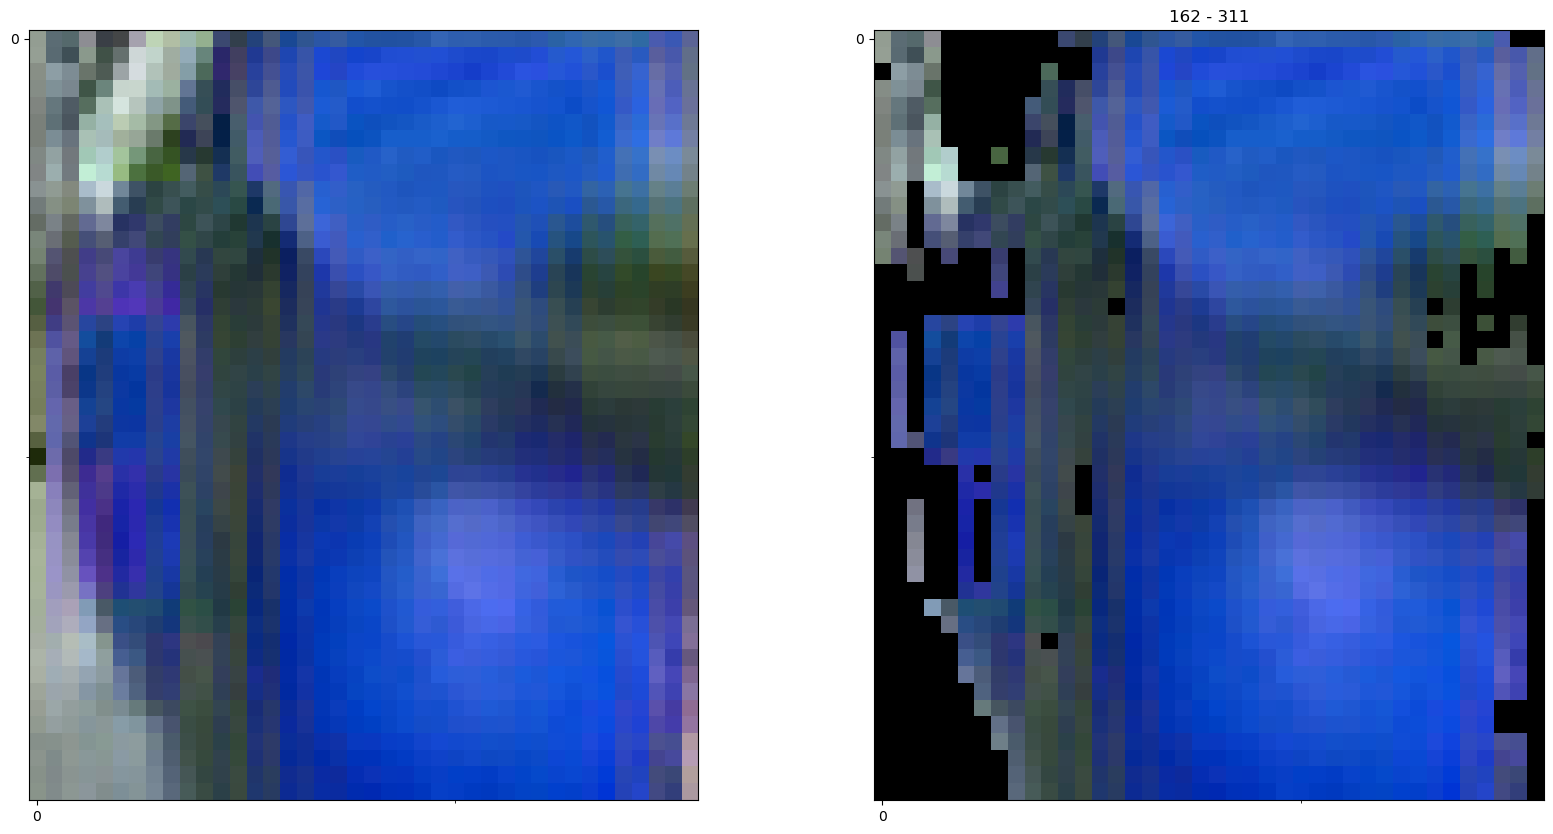

 30%|████████████████████████████████████████████████████████▍                                                                                                                                   | 6/20 [00:01<00:02,  5.38it/s]/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)


pix size mean: width - 37.375170066959015, height - 35.545247814719325
pix size median: width - 37.44357196288374, height - 35.610300691730586
pix size mean filtered: width - 37.374643440592855, height - 35.40121621307712
pix size median filtered: width - 37.447686517579356, height - 35.47040252559346
margin 2: width - 35.814154893159866, height - 33.97520259022713
margin 5: width - 35.752661526203156, height - 33.93915295600891
margin 8: width - 35.70082411170006, height - 33.81049633026123
margin 2 filtered: width - 35.7530415058136, height - 34.83642637729645
margin 5 filtered: width - 35.73965281248093, height - 34.46967899799347
margin 8 filtered: width - 35.68251058459282, height - 26.44149214029312


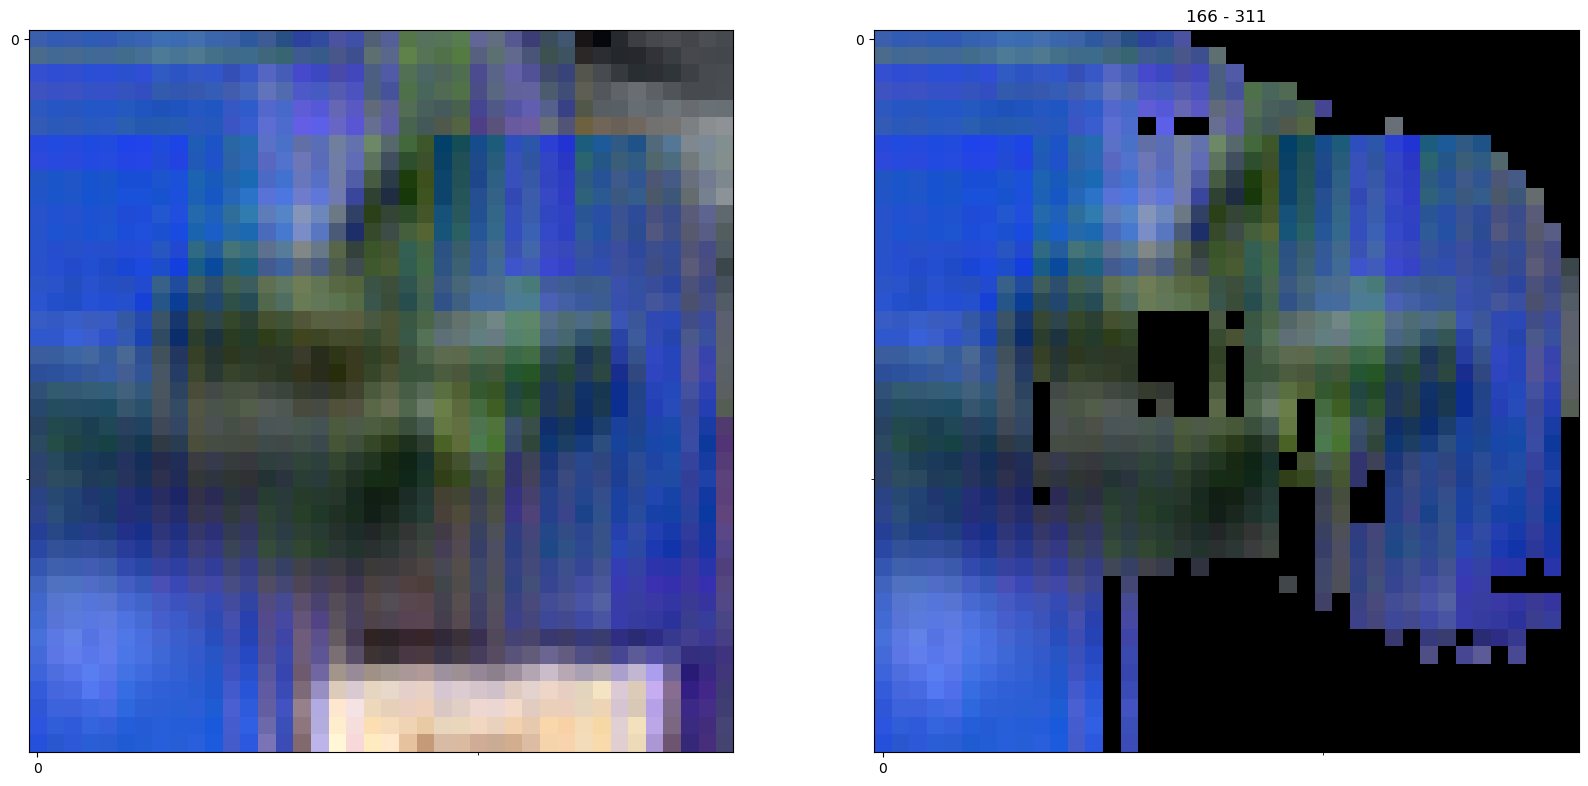

 35%|█████████████████████████████████████████████████████████████████▊                                                                                                                          | 7/20 [00:01<00:02,  5.09it/s]

pix size mean: width - 46.382488085526255, height - 37.30850494859801
pix size median: width - 46.29563052874326, height - 37.23863966709163
pix size mean filtered: width - 46.43952529938453, height - 37.15086952800047
pix size median filtered: width - 46.36667799016042, height - 37.09259285822394
margin 2: width - 37.14384138584137, height - 47.76811972260475
margin 5: width - 37.138573825359344, height - 47.69387096166611
margin 8: width - 37.094634026288986, height - 47.673650085926056
margin 2 filtered: width - 39.086125791072845, height - 48.07524010539055
margin 5 filtered: width - 37.945978343486786, height - 47.71651327610016
margin 8 filtered: width - 33.64859148859978, height - 47.659680247306824


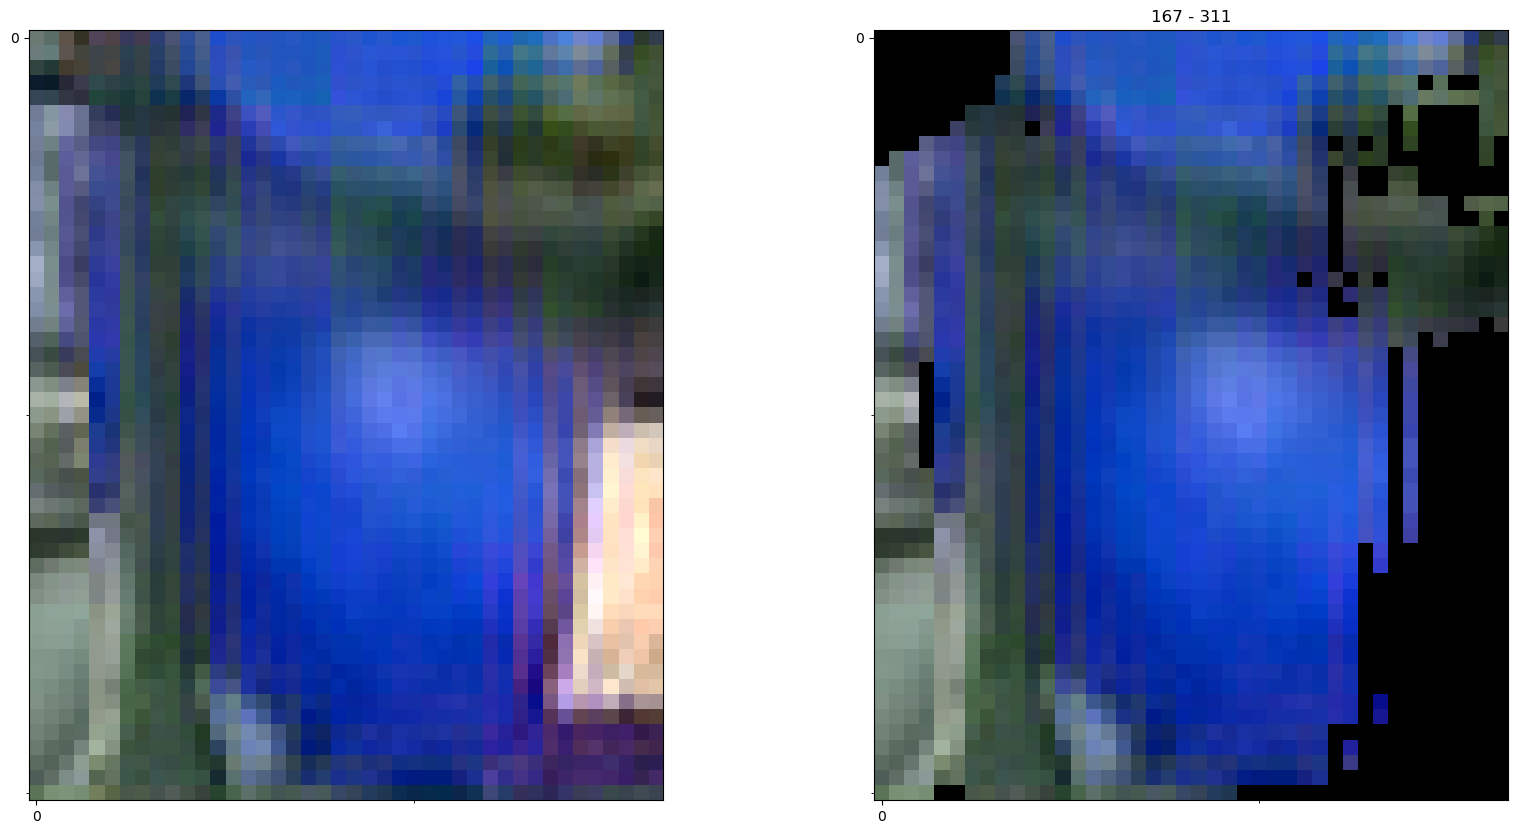

 40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8/20 [00:01<00:02,  4.84it/s]

pix size mean: width - 51.751416354266134, height - 38.11244219054868
pix size median: width - 51.86179597913683, height - 38.19373150334935
pix size mean filtered: width - 51.7915446913874, height - 37.75977736250432
pix size median filtered: width - 51.91659961849393, height - 37.850951437998006
margin 2: width - 38.05946931242943, height - 50.68356171250343
margin 5: width - 37.79291361570358, height - 50.04524067044258
margin 8: width - 37.84525766968727, height - 49.791719764471054
margin 2 filtered: width - 39.16717320680618, height - 51.053717732429504
margin 5 filtered: width - 38.18520903587341, height - 50.11448264122009
margin 8 filtered: width - 37.83901035785675, height - 49.791719764471054


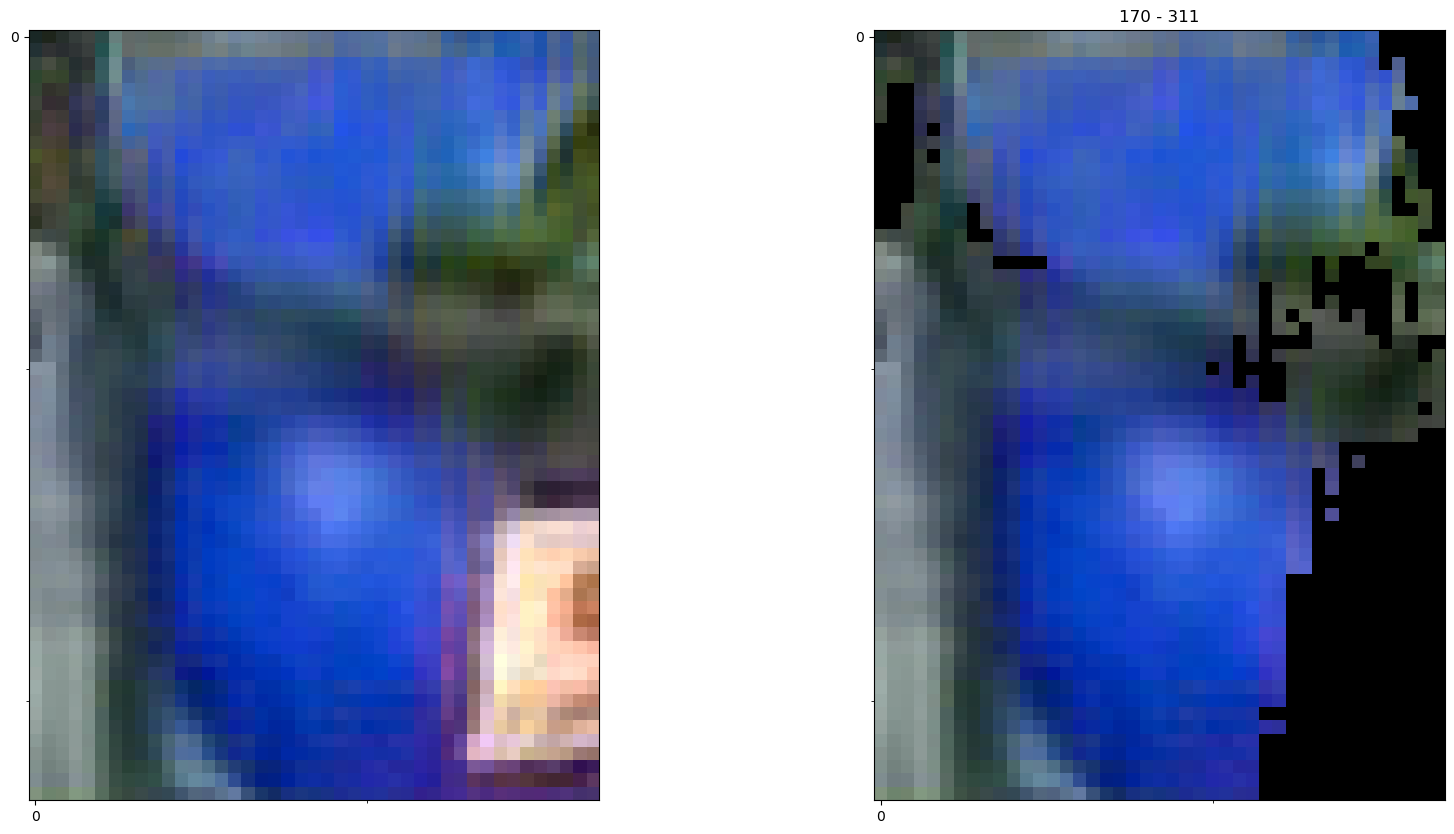

 45%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9/20 [00:01<00:02,  4.90it/s]

pix size mean: width - 55.02378936716692, height - 50.937151473923
pix size median: width - 55.32810080919982, height - 51.218861588699795
pix size mean filtered: width - 55.022994776179345, height - 50.971310777155566
pix size median filtered: width - 55.34378975465572, height - 51.26848363388905
margin 2: width - 50.86575821042061, height - 55.56932836771011
margin 5: width - 46.73217236995697, height - 55.43695017695427
margin 8: width - 43.49279776215553, height - 55.2922748029232
margin 2 filtered: width - 48.364270478487015, height - 55.77262490987778
margin 5 filtered: width - 45.7465797662735, height - 55.692583322525024
margin 8 filtered: width - 43.49279776215553, height - 55.7536780834198


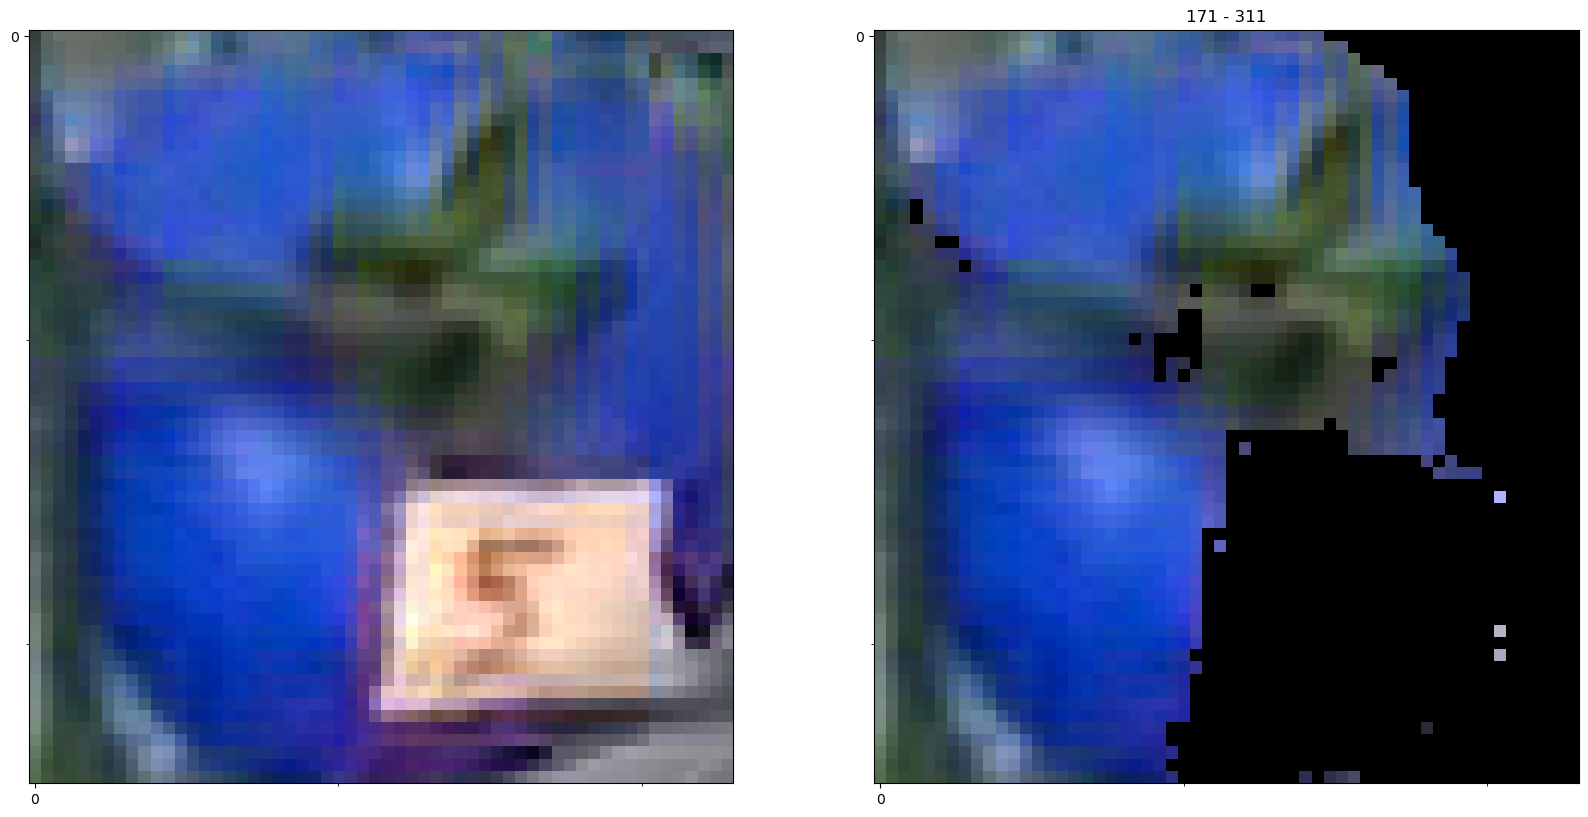

 50%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10/20 [00:02<00:02,  4.88it/s]

pix size mean: width - 56.57046438981938, height - 54.96655245046232
pix size median: width - 56.91304877704653, height - 55.29942372688448
pix size mean filtered: width - 56.564874045310376, height - 54.590937409078656
pix size median filtered: width - 56.930752694962315, height - 54.94404804177391
margin 2: width - 45.39669677615166, height - 60.13640761375427
margin 5: width - 45.171815901994705, height - 59.27124246954918
margin 8: width - 45.198895037174225, height - 59.053920209407806
margin 2 filtered: width - 45.39669677615166, height - 59.94366109371185
margin 5 filtered: width - 45.171815901994705, height - 59.437837451696396
margin 8 filtered: width - 45.198895037174225, height - 59.19115990400314


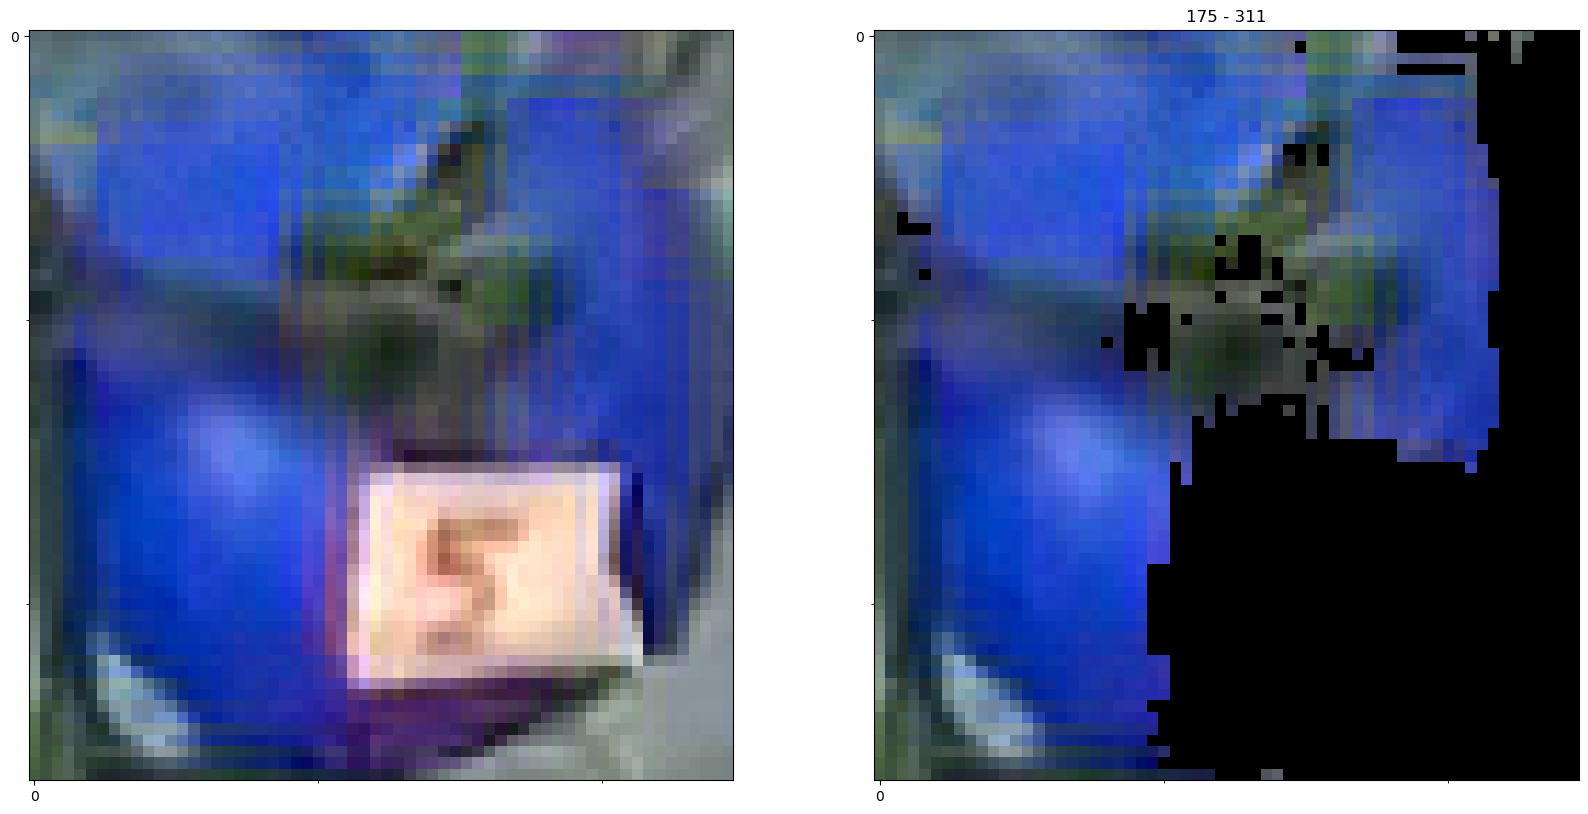

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 11/20 [00:02<00:01,  4.72it/s]

pix size mean: width - 54.16377010999953, height - 54.58683161723601
pix size median: width - 54.49730205874444, height - 54.922968711979124
pix size mean filtered: width - 54.210366691040335, height - 54.580129824798526
pix size median filtered: width - 54.445855423046, height - 54.81722480034812
margin 2: width - 46.582549810409546, height - 59.7199909389019
margin 5: width - 46.299707144498825, height - 57.92701616883278
margin 8: width - 46.269018203020096, height - 56.69642984867096
margin 2 filtered: width - 46.58142477273941, height - 60.7682429254055
margin 5 filtered: width - 46.28831148147583, height - 58.17395821213722
margin 8 filtered: width - 46.23660445213318, height - 56.70517683029175


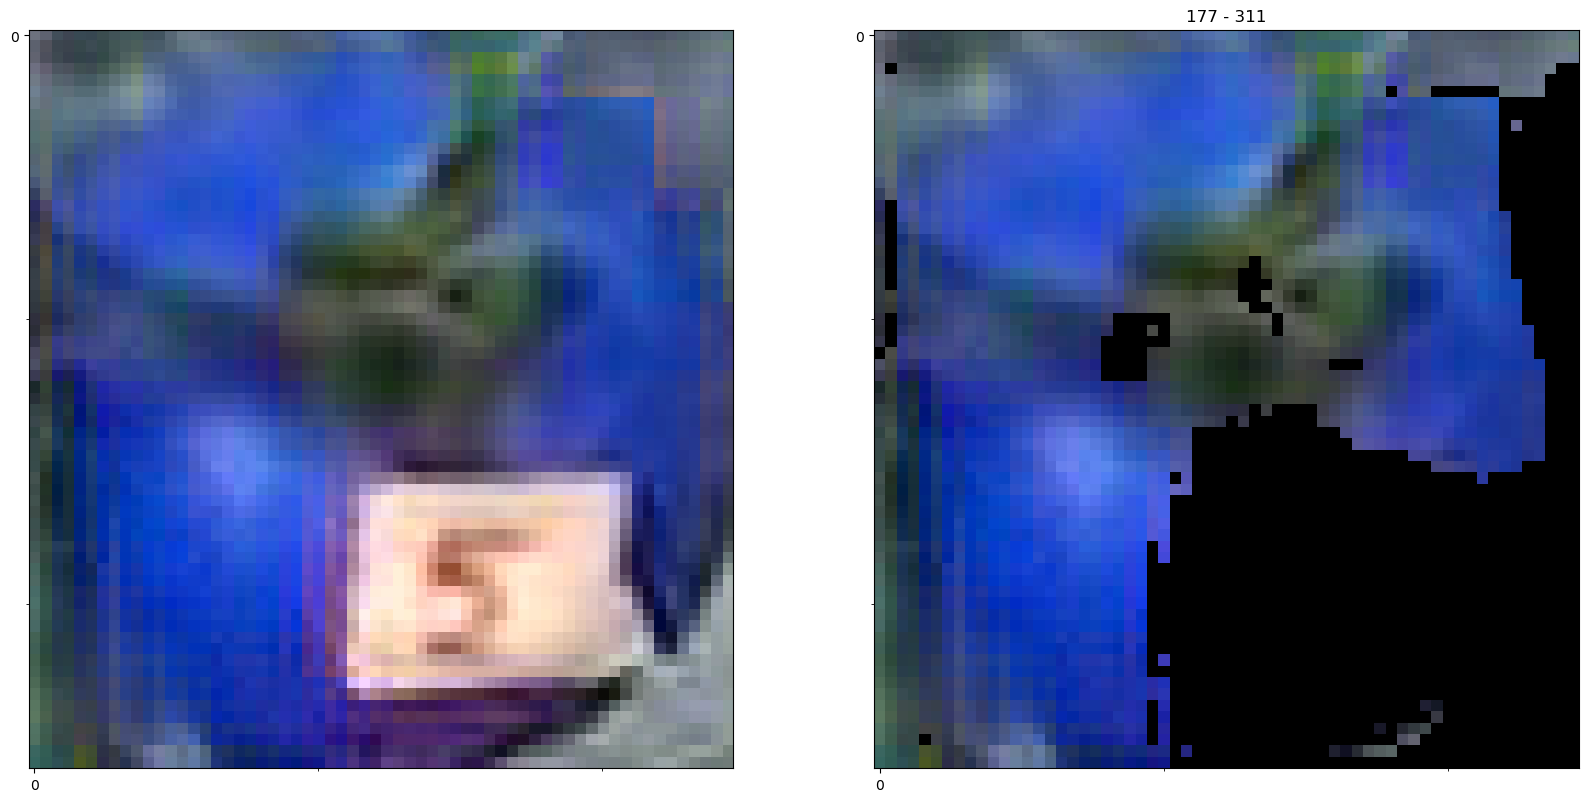

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 12/20 [00:02<00:02,  3.93it/s]

pix size mean: width - 55.0403118959629, height - 51.80047892224191
pix size median: width - 55.450050232822065, height - 52.186098867896014
pix size mean filtered: width - 55.015356647706845, height - 52.095600289556444
pix size median filtered: width - 55.45993829089188, height - 52.51658724648468
margin 2: width - 41.69106110930443, height - 59.607990086078644
margin 5: width - 41.20562598109245, height - 58.95010381937027
margin 8: width - 36.71935200691223, height - 58.46242979168892
margin 2 filtered: width - 32.2747640311718, height - 60.157544910907745
margin 5 filtered: width - 31.38839825987816, height - 59.23621729016304
margin 8 filtered: width - 30.70252761244774, height - 58.34835767745972


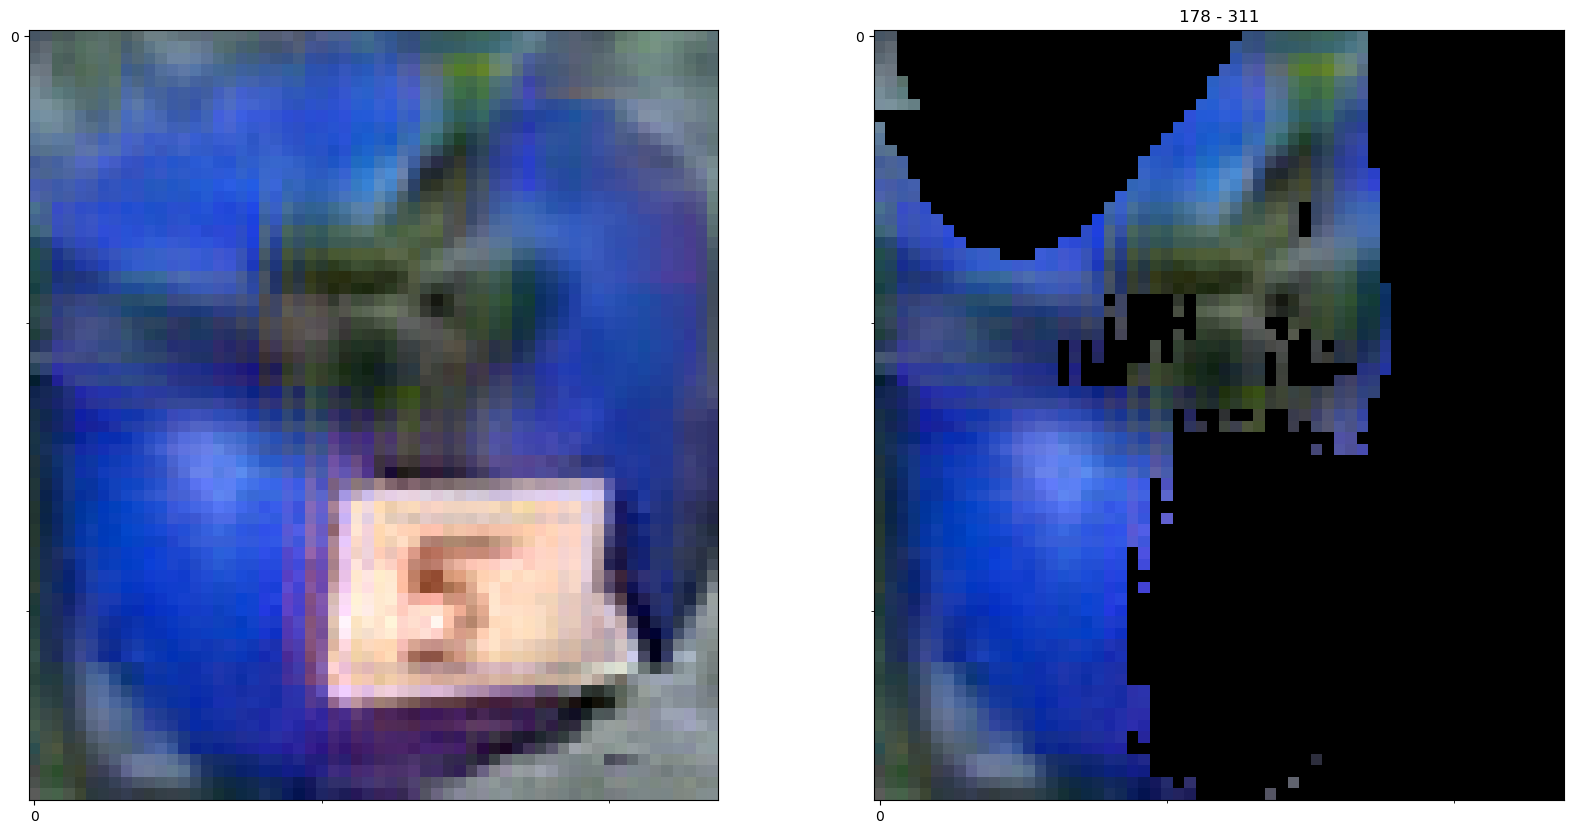

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 13/20 [00:02<00:01,  4.07it/s]

pix size mean: width - 52.66561813727269, height - 54.26645161904015
pix size median: width - 52.89953945991767, height - 54.5074832557502
pix size mean filtered: width - 52.6472821366295, height - 54.23244197804852
pix size median filtered: width - 52.87685873158843, height - 54.46893090701768
margin 2: width - 37.09683194756508, height - 58.76154452562332
margin 5: width - 36.942362785339355, height - 57.77907371520996
margin 8: width - 36.88513860106468, height - 57.42337554693222
margin 2 filtered: width - 37.056829780340195, height - 58.516133576631546
margin 5 filtered: width - 36.72156482934952, height - 57.526588439941406
margin 8 filtered: width - 36.689642816782, height - 57.4311837553978


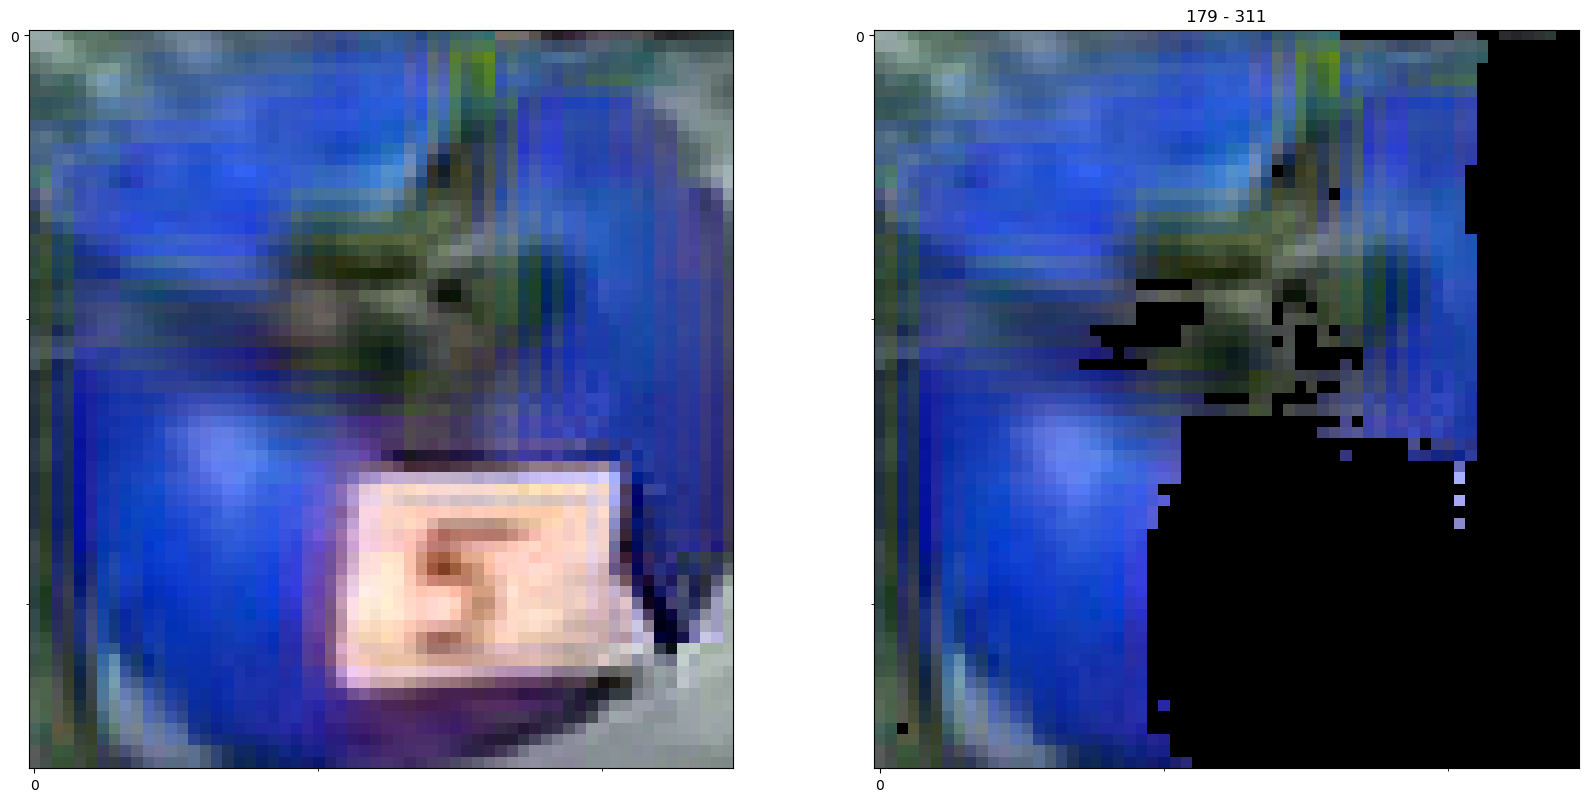

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 14/20 [00:03<00:01,  4.16it/s]

pix size mean: width - 53.468626395268736, height - 54.74751916585703
pix size median: width - 53.74643423572035, height - 55.03197177096262
pix size mean filtered: width - 53.55572249941408, height - 54.656006734861094
pix size median filtered: width - 53.843826040474255, height - 54.95002926589304
margin 2: width - 43.4906966984272, height - 61.464790254831314
margin 5: width - 43.385621160268784, height - 60.446884483098984
margin 8: width - 43.33239421248436, height - 59.43084880709648
margin 2 filtered: width - 43.496232479810715, height - 61.860304325819016
margin 5 filtered: width - 43.39197278022766, height - 60.3591613471508
margin 8 filtered: width - 43.347205966711044, height - 59.378862380981445


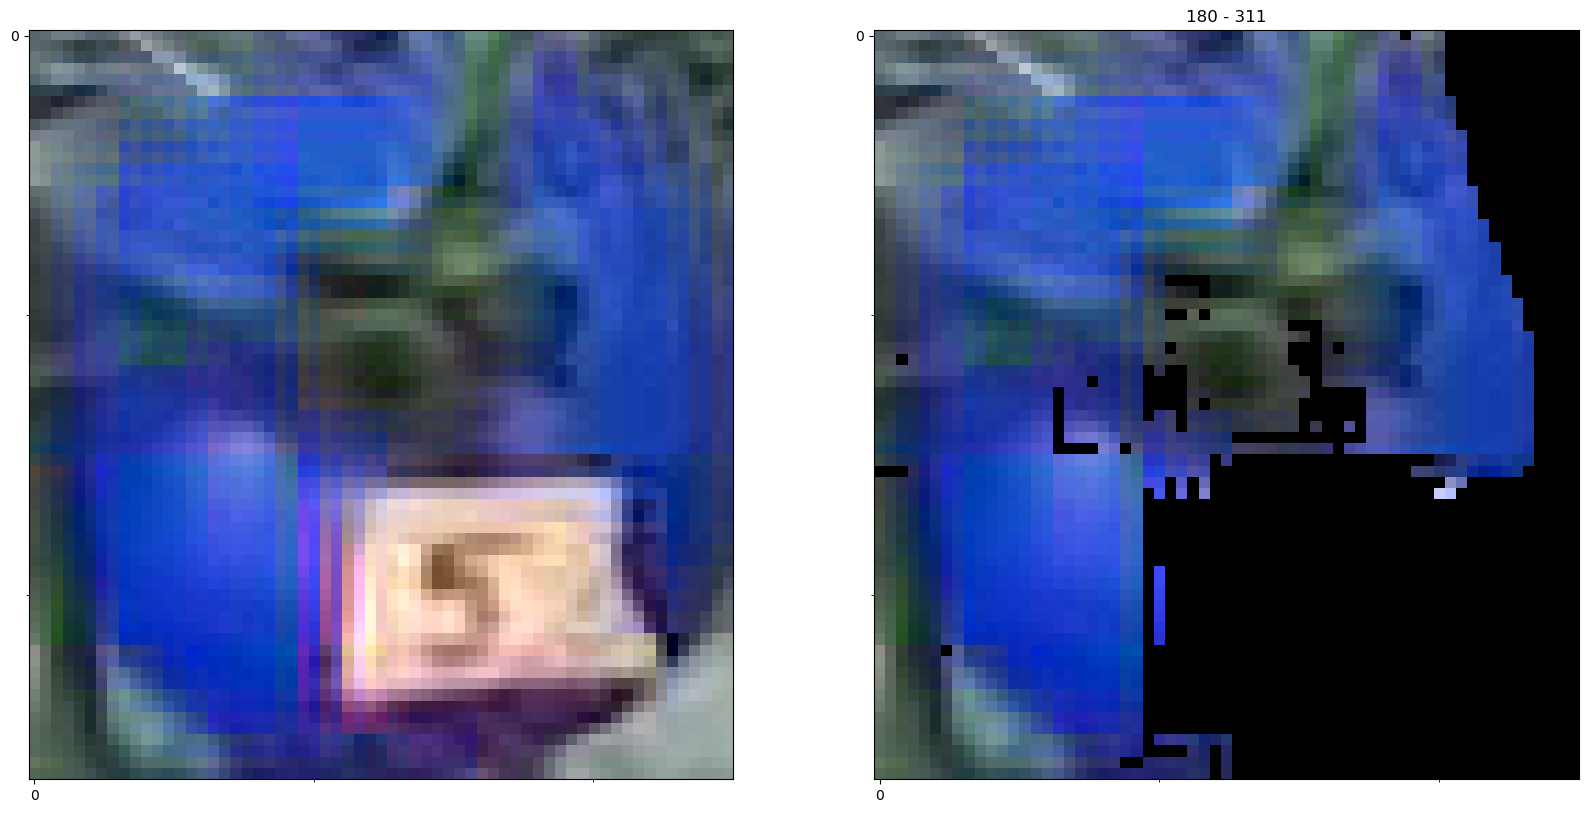

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 15/20 [00:03<00:01,  4.48it/s]

pix size mean: width - 52.80755731861617, height - 55.136835082701374
pix size median: width - 53.15539806138605, height - 55.500018661775755
pix size mean filtered: width - 52.858070608351824, height - 54.71532479066585
pix size median filtered: width - 53.226565165761656, height - 55.09676700299444
margin 2: width - 45.547839254140854, height - 59.38001722097397
margin 5: width - 35.46860069036484, height - 59.22512710094452
margin 8: width - 31.00241906940937, height - 59.01696905493736
margin 2 filtered: width - 34.73781421780586, height - 59.569623321294785
margin 5 filtered: width - 34.19363498687744, height - 59.161171317100525
margin 8 filtered: width - 30.98420985043049, height - 58.93181636929512


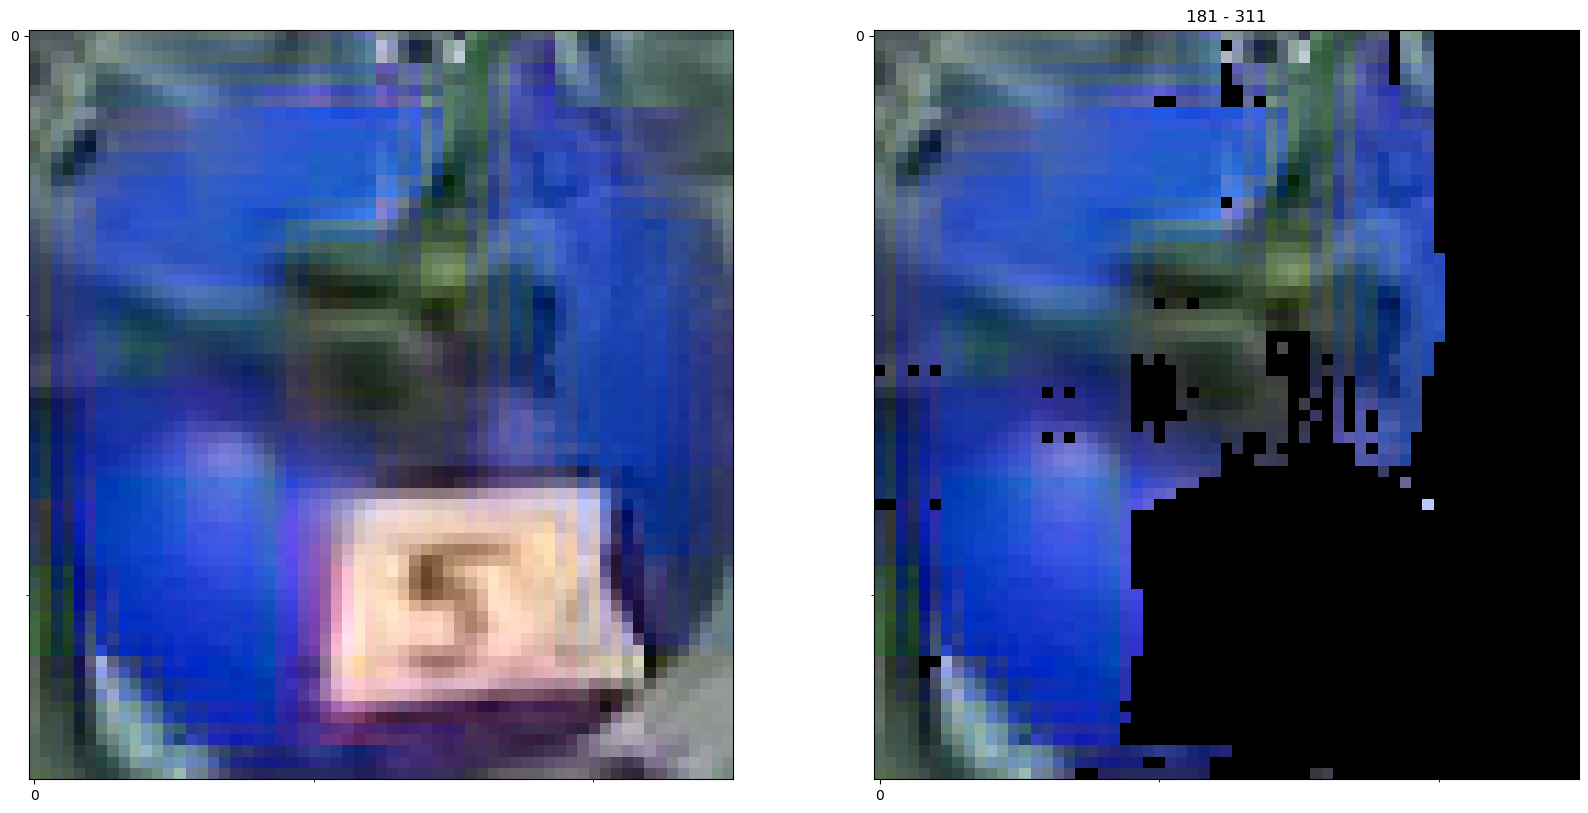

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 16/20 [00:03<00:00,  4.96it/s]

pix size mean: width - 52.01432595447717, height - 54.61375183845423
pix size median: width - 52.33960456651226, height - 54.955286311314424
pix size mean filtered: width - 51.99882271362482, height - 55.07434396012049
pix size median filtered: width - 52.34238194593074, height - 55.43822333936907
margin 2: width - 39.6430678665638, height - 63.64905089139938
margin 5: width - 39.05654698610306, height - 61.50076910853386
margin 8: width - 39.16493430733681, height - 60.06491184234619
margin 2 filtered: width - 39.6430678665638, height - 63.934363424777985
margin 5 filtered: width - 39.05654698610306, height - 61.619289219379425
margin 8 filtered: width - 39.16493430733681, height - 60.06515771150589


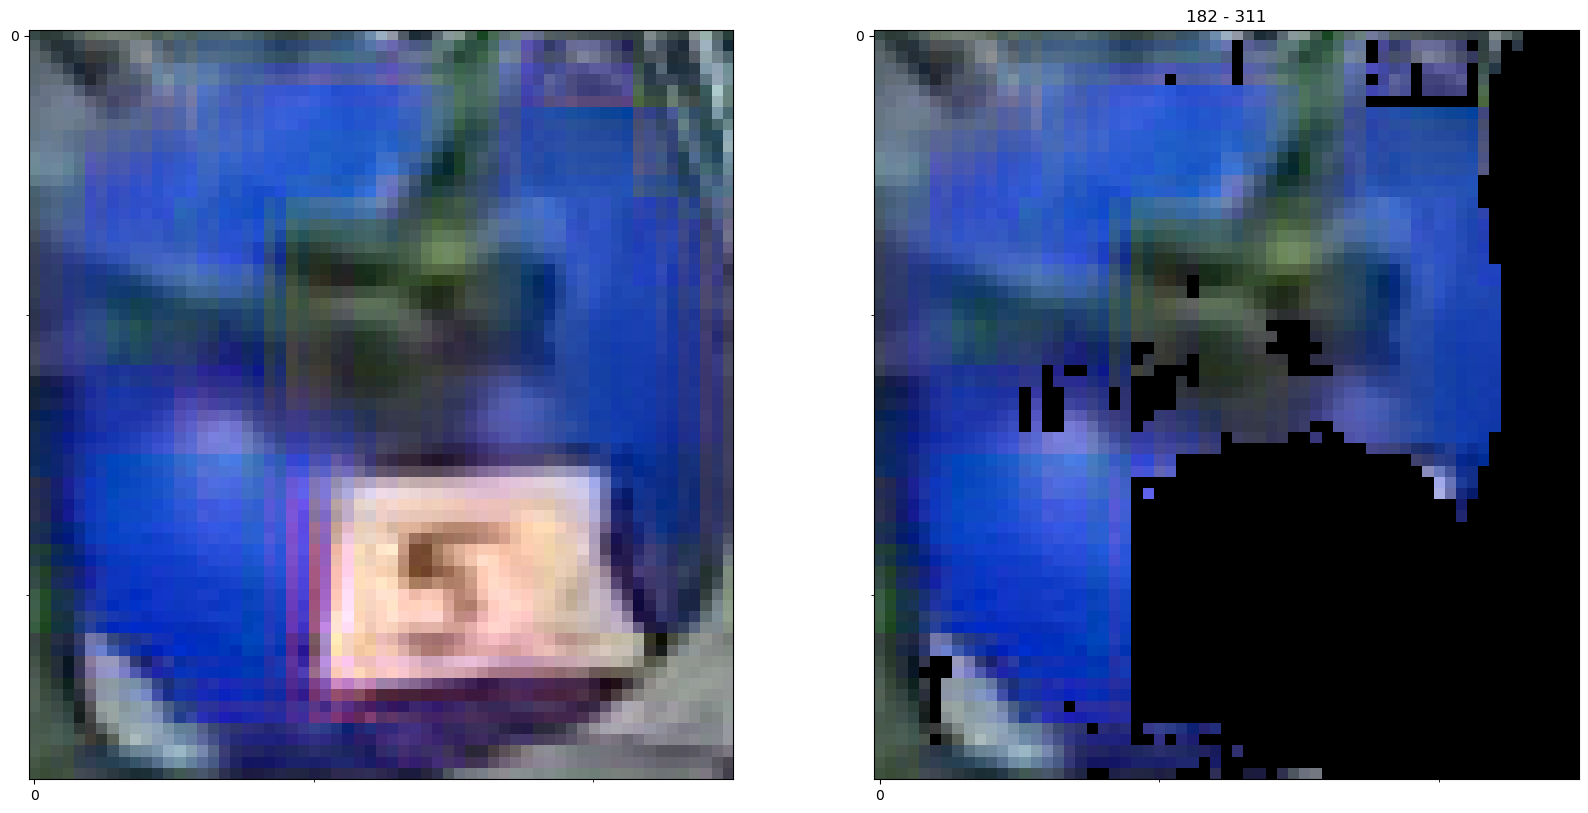

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 17/20 [00:03<00:00,  5.20it/s]

pix size mean: width - 47.47311182754599, height - 54.03450410233999
pix size median: width - 47.645867207208674, height - 54.231136488794704
pix size mean filtered: width - 47.46559155916272, height - 53.977881307385665
pix size median filtered: width - 47.65585464615114, height - 54.19424853234348
margin 2: width - 36.99270635843277, height - 54.619867354631424
margin 5: width - 36.92632541060448, height - 54.34181168675423
margin 8: width - 34.64600071310997, height - 54.13804203271866
margin 2 filtered: width - 36.99270635843277, height - 55.11258542537689
margin 5 filtered: width - 36.92632541060448, height - 54.32139337062836
margin 8 filtered: width - 34.64600071310997, height - 54.04891073703766


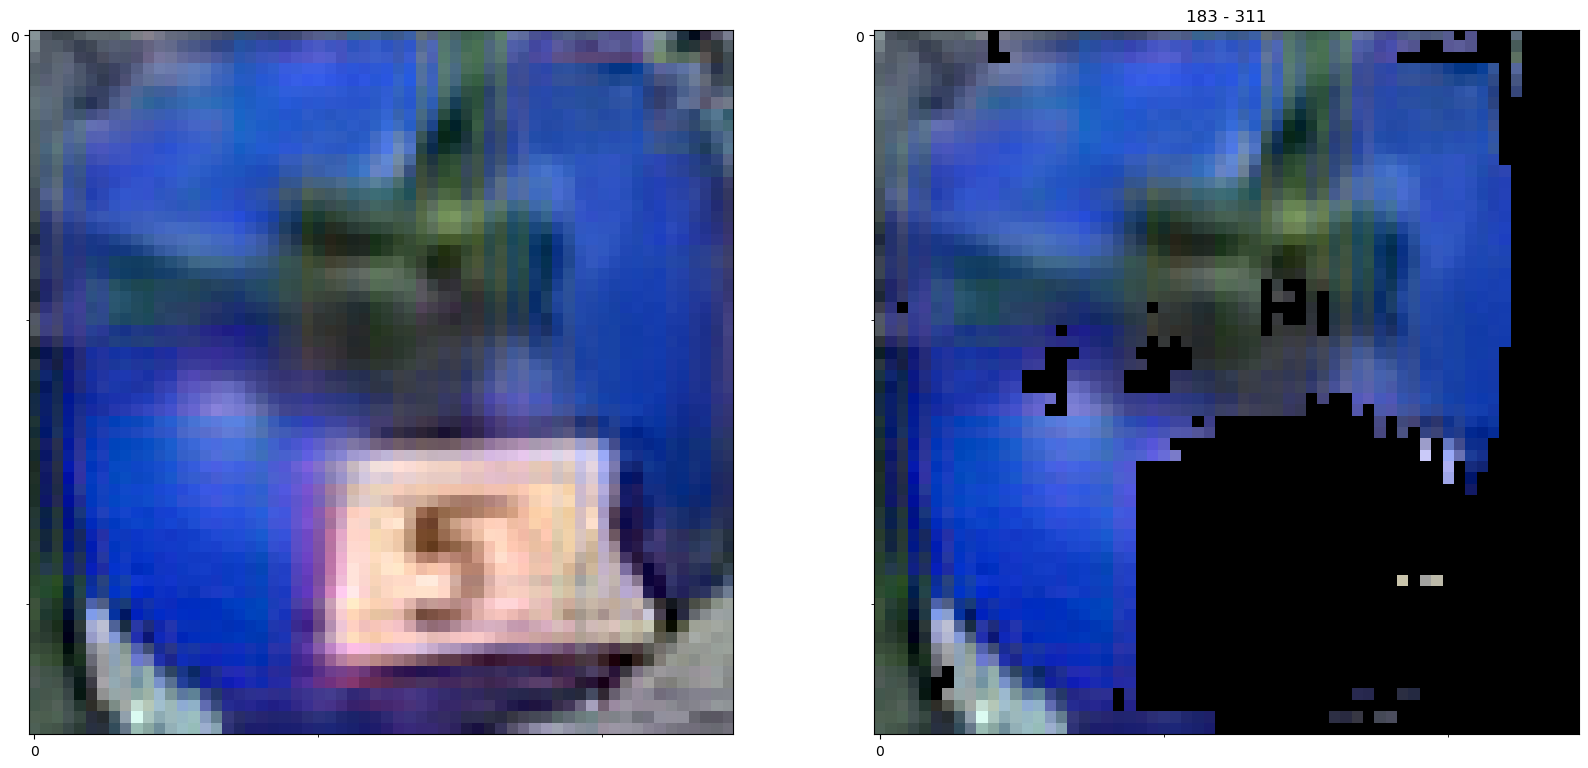

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 18/20 [00:03<00:00,  5.40it/s]

pix size mean: width - 50.143946354747136, height - 56.51391762316226
pix size median: width - 50.31922965738968, height - 56.71146781309295
pix size mean filtered: width - 50.14450885908073, height - 56.51455158450517
pix size median filtered: width - 50.27781922600114, height - 56.6647968611963
margin 2: width - 34.5928780734539, height - 61.91343069076538
margin 5: width - 34.545037895441055, height - 61.30070611834526
margin 8: width - 34.597255289554596, height - 60.790423303842545
margin 2 filtered: width - 34.5928780734539, height - 61.96707859635353
margin 5 filtered: width - 34.545037895441055, height - 61.33345142006874
margin 8 filtered: width - 34.597255289554596, height - 60.78437715768814


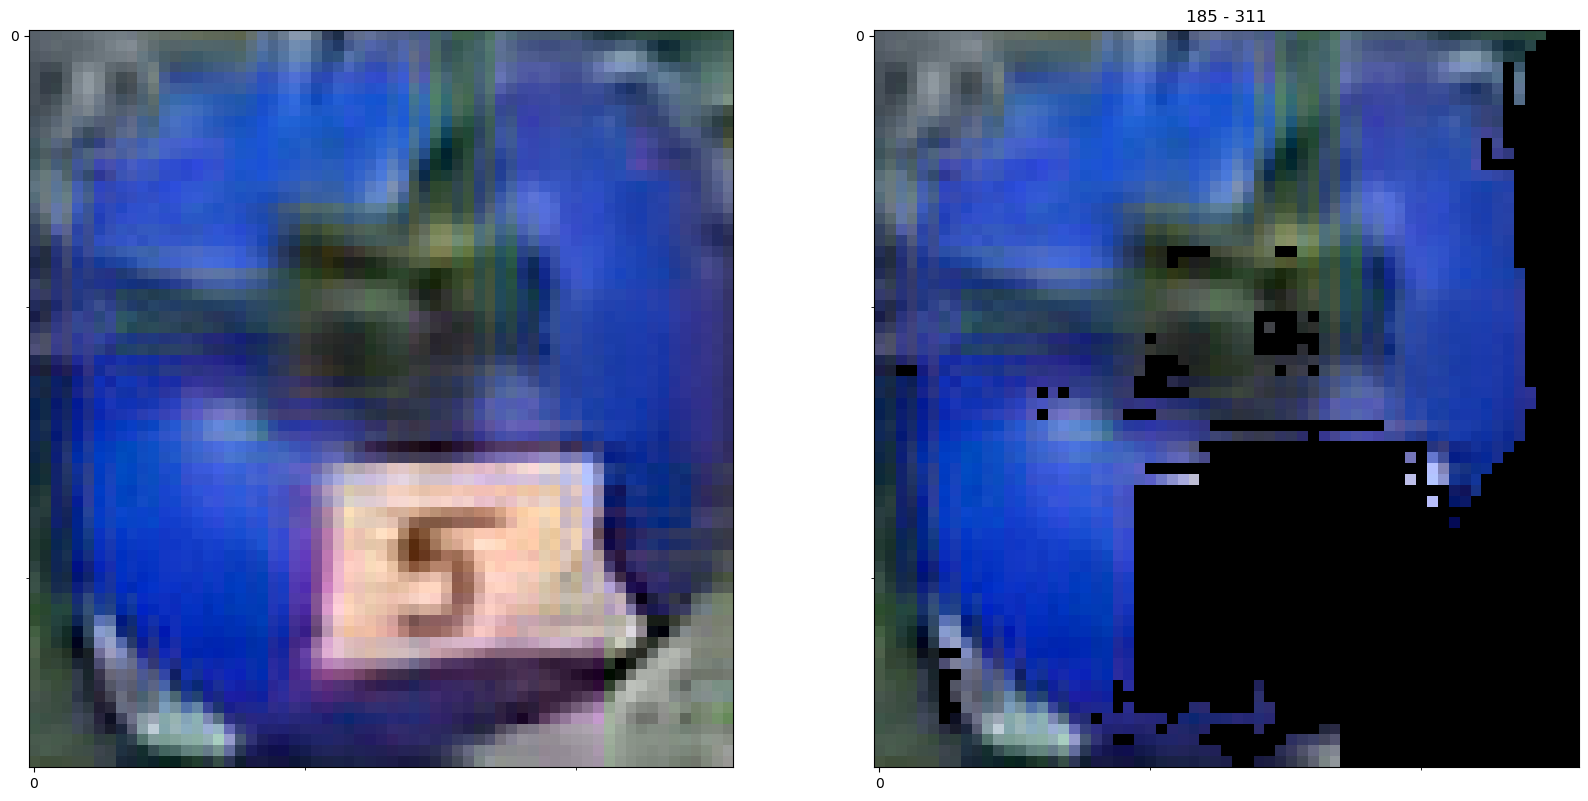

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 19/20 [00:03<00:00,  5.54it/s]

pix size mean: width - 48.36809646221261, height - 55.10014920666344
pix size median: width - 48.54627852132049, height - 55.303131311829915
pix size mean filtered: width - 48.353060079184054, height - 55.083020003552264
pix size median filtered: width - 48.48612378701339, height - 55.234604016396716
margin 2: width - 37.10230812430382, height - 62.41593137383461
margin 5: width - 37.59071230888367, height - 61.56289950013161
margin 8: width - 38.46495598554611, height - 60.68560853600502
margin 2 filtered: width - 37.895675748586655, height - 62.80633807182312
margin 5 filtered: width - 38.36818039417267, height - 61.79405003786087
margin 8 filtered: width - 39.43825513124466, height - 60.7641227543354


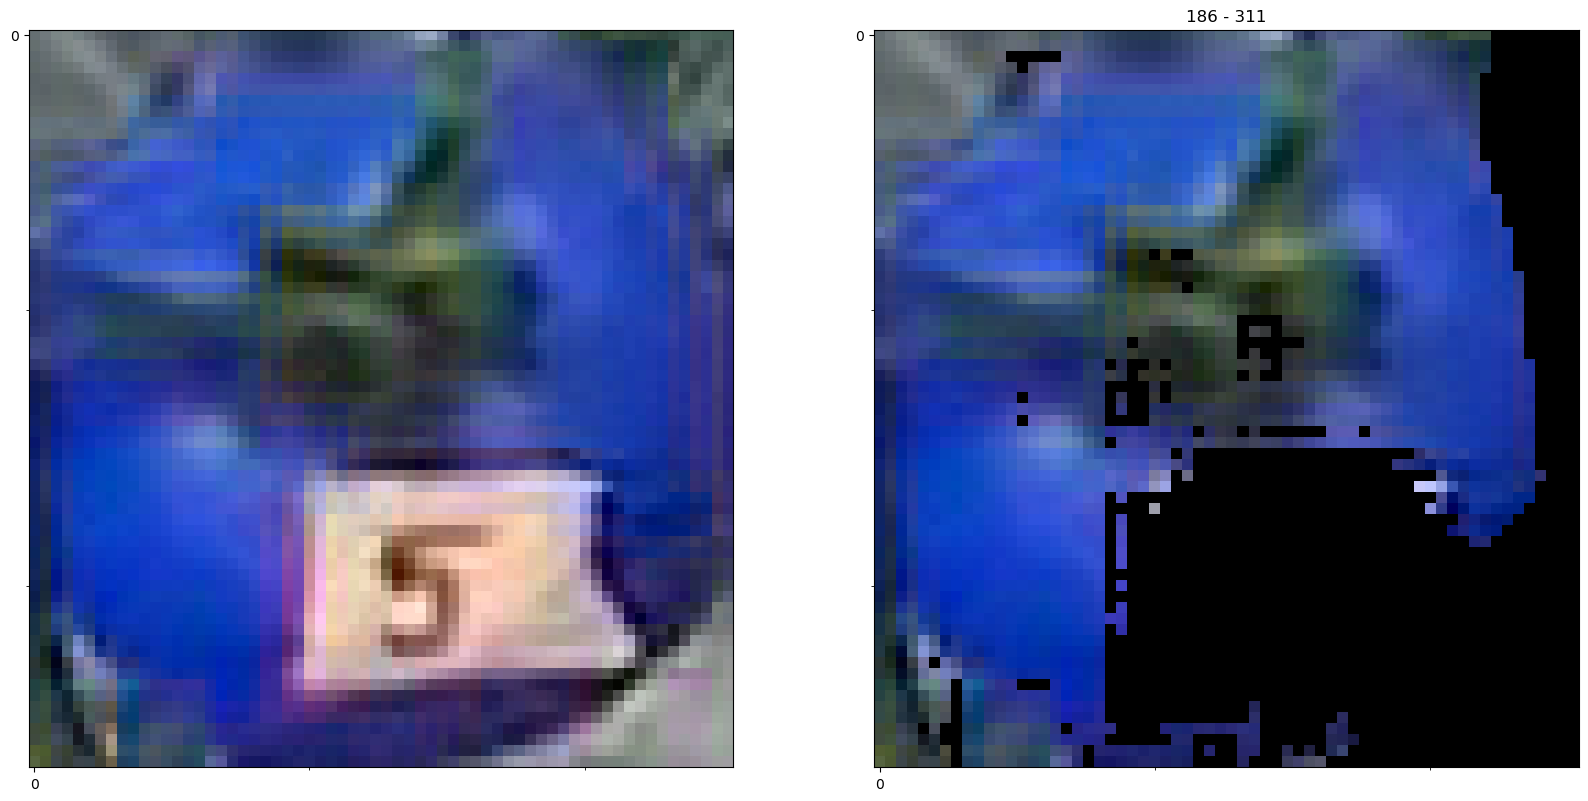

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.91it/s]
/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 49.57478703926661 4.75273561019458 47.30339587847334 8.771261714706784 
 pix med: 
 49.79172864793561 4.842028363727606 47.52351113020021 8.905605904768011 
 pix mean filtered: 
 49.56291492858852 4.77566077535001 47.16792239424858 8.879782679669697 
 pix med filtered: 
 49.78105863416732 4.864040039295328 47.38809516598657 9.00987635582464 
 margin 0.2: 
 40.235815569758415 5.254505768029994 53.80767062306404 7.992314400913828 
 margin 0.5: 
 39.25103209912777 4.854971784651122 53.18033769726753 7.623406205975956 
 margin 0.8: 
 38.05163139477372 5.270310459519301 52.905284613370895 7.339041910169588 
 margin_f0.2: 
 39.79863412678242 5.00103932718982 53.84611710906029 8.235566493294561 
 margin 0.5_f: 
 39.04389776289463 4.854590408360352 53.16053330898285 7.74127271048801 
 margin 0.8_f: 
 37.571930792182684 5.544775465485262 52.520969696342945 8.443493244226927


  0%|                                                                                                                                                                                                    | 0/14 [00:00<?, ?it/s]

pix size mean: width - 37.81765984177923, height - 38.60088740551061
pix size median: width - 37.83307835416881, height - 38.61662524500678
pix size mean filtered: width - 37.637566704369895, height - 38.52278888674064
pix size median filtered: width - 37.669296845443924, height - 38.55526530944729
margin 2: width - 18.98321509361267, height - 17.718462273478508
margin 5: width - 13.629866763949394, height - 13.114279136061668
margin 8: width - 3.0644102953374386, height - 8.263963274657726
margin 2 filtered: width - 21.48038148880005, height - 14.000901952385902
margin 5 filtered: width - 14.274477027356625, height - 13.114279136061668
margin 8 filtered: width - 3.0644102953374386, height - 8.263963274657726


/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)


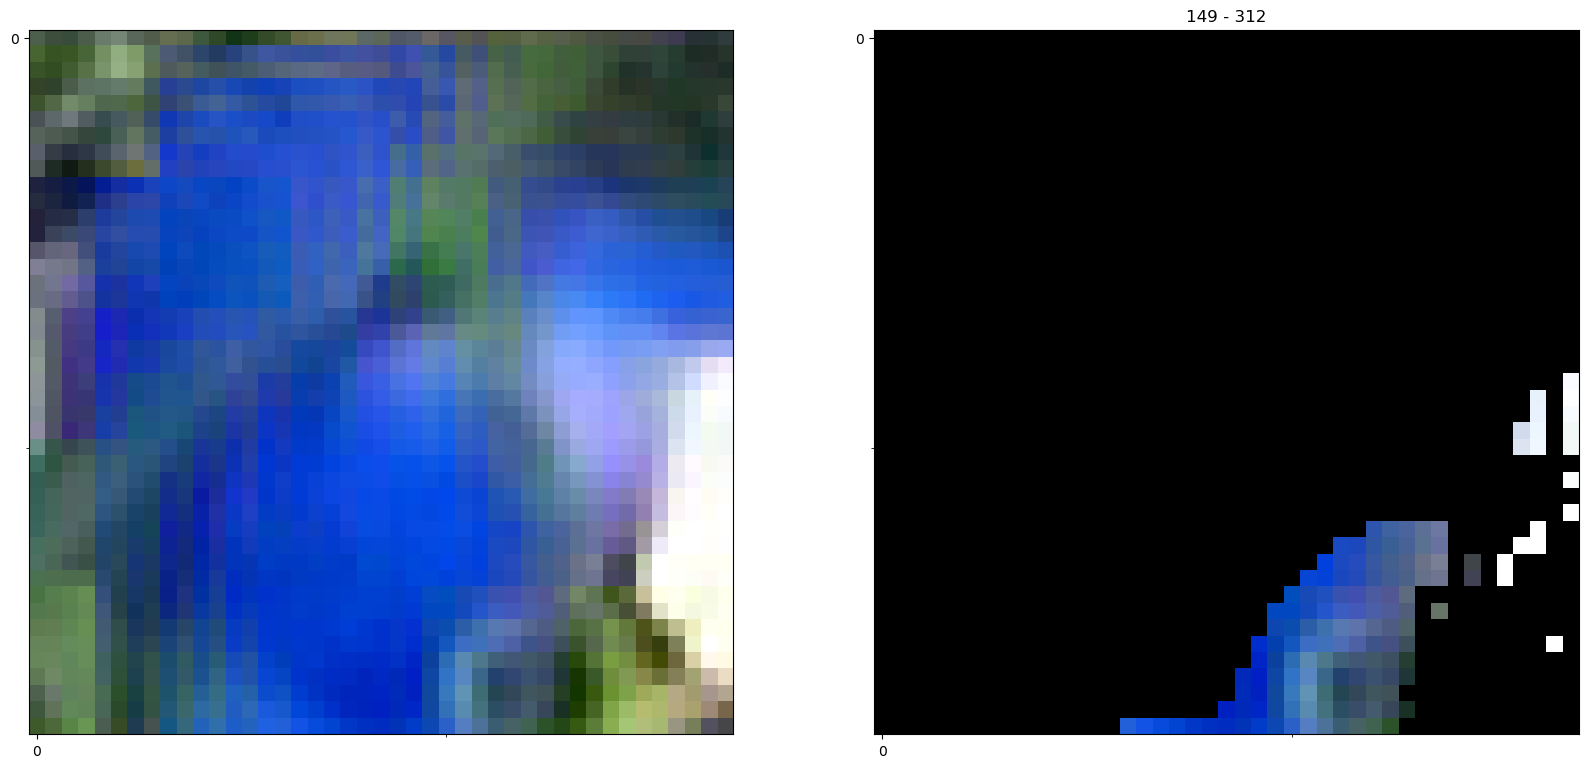

  7%|█████████████▍                                                                                                                                                                              | 1/14 [00:00<00:04,  2.89it/s]

pix size mean: width - 38.325131943985916, height - 36.63198349094646
pix size median: width - 38.31813440353227, height - 36.625295091627954
pix size mean filtered: width - 37.88084808575275, height - 36.38966334723241
pix size median filtered: width - 37.8760205769372, height - 36.38502587395815
margin 2: width - 40.06744921207428, height - 28.353305533528328
margin 5: width - 37.028905004262924, height - 15.73546789586544
margin 8: width - 28.819018974900246, height - 15.708869323134422
margin 2 filtered: width - 40.49700126051903, height - 26.08042024075985
margin 5 filtered: width - 35.37162393331528, height - 15.73546789586544
margin 8 filtered: width - 28.819018974900246, height - 15.708869323134422


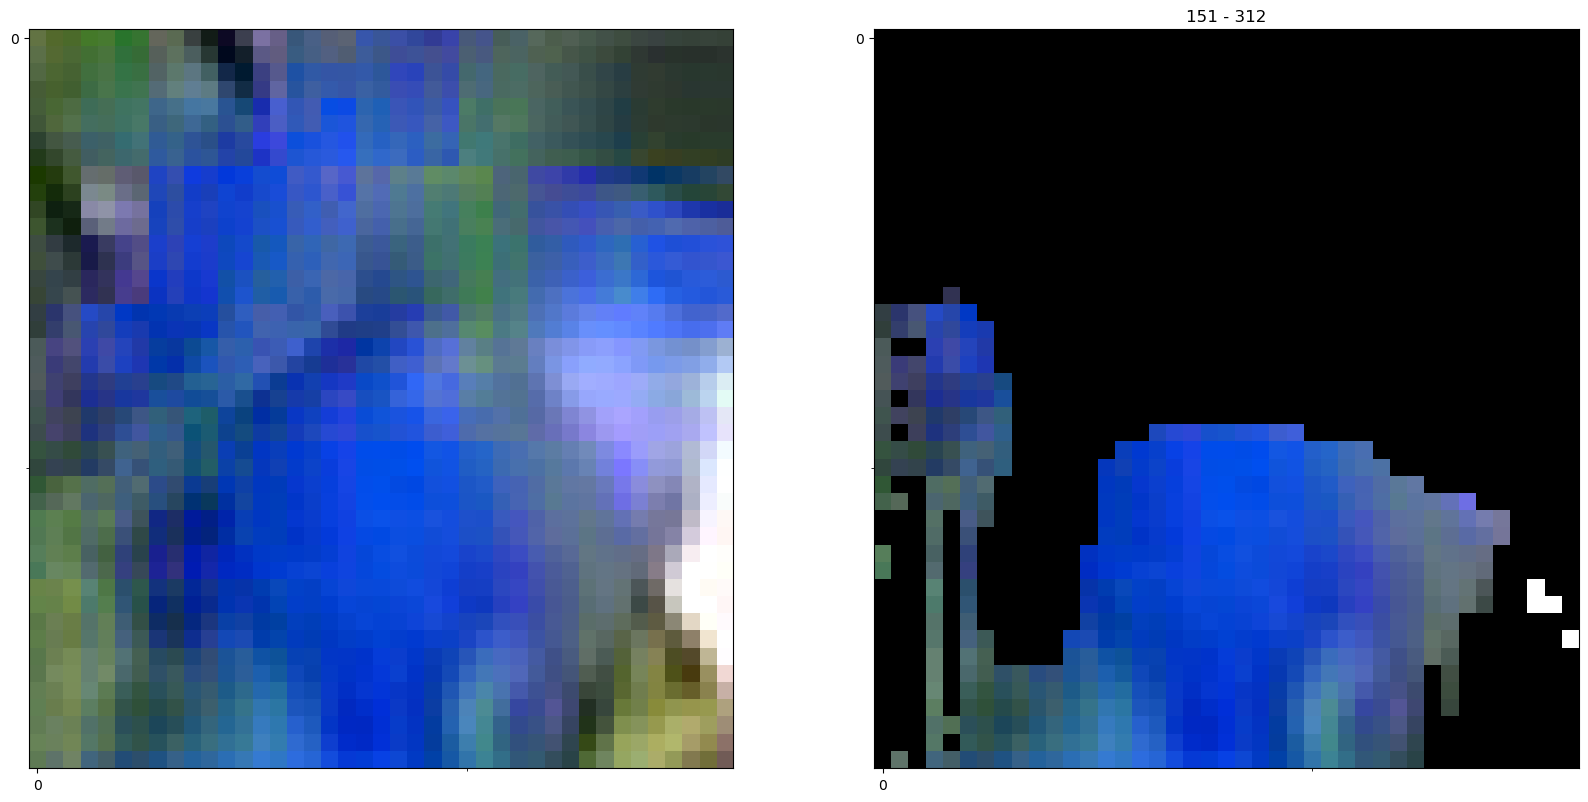

 14%|██████████████████████████▊                                                                                                                                                                 | 2/14 [00:00<00:02,  4.08it/s]

pix size mean: width - 40.30556282795803, height - 39.224148397186006
pix size median: width - 40.36349300391366, height - 39.28052428326547
pix size mean filtered: width - 40.05054164511561, height - 39.06353265220845
pix size median filtered: width - 40.124269287686886, height - 39.13544334441513
margin 2: width - 40.48604890704155, height - 25.867875665426254
margin 5: width - 33.348917961120605, height - 25.82152932882309
margin 8: width - 33.3566814661026, height - 24.612152948975563
margin 2 filtered: width - 41.12499952316284, height - 25.18216334283352
margin 5 filtered: width - 33.483389765024185, height - 24.97606910765171
margin 8 filtered: width - 33.483389765024185, height - 24.612152948975563


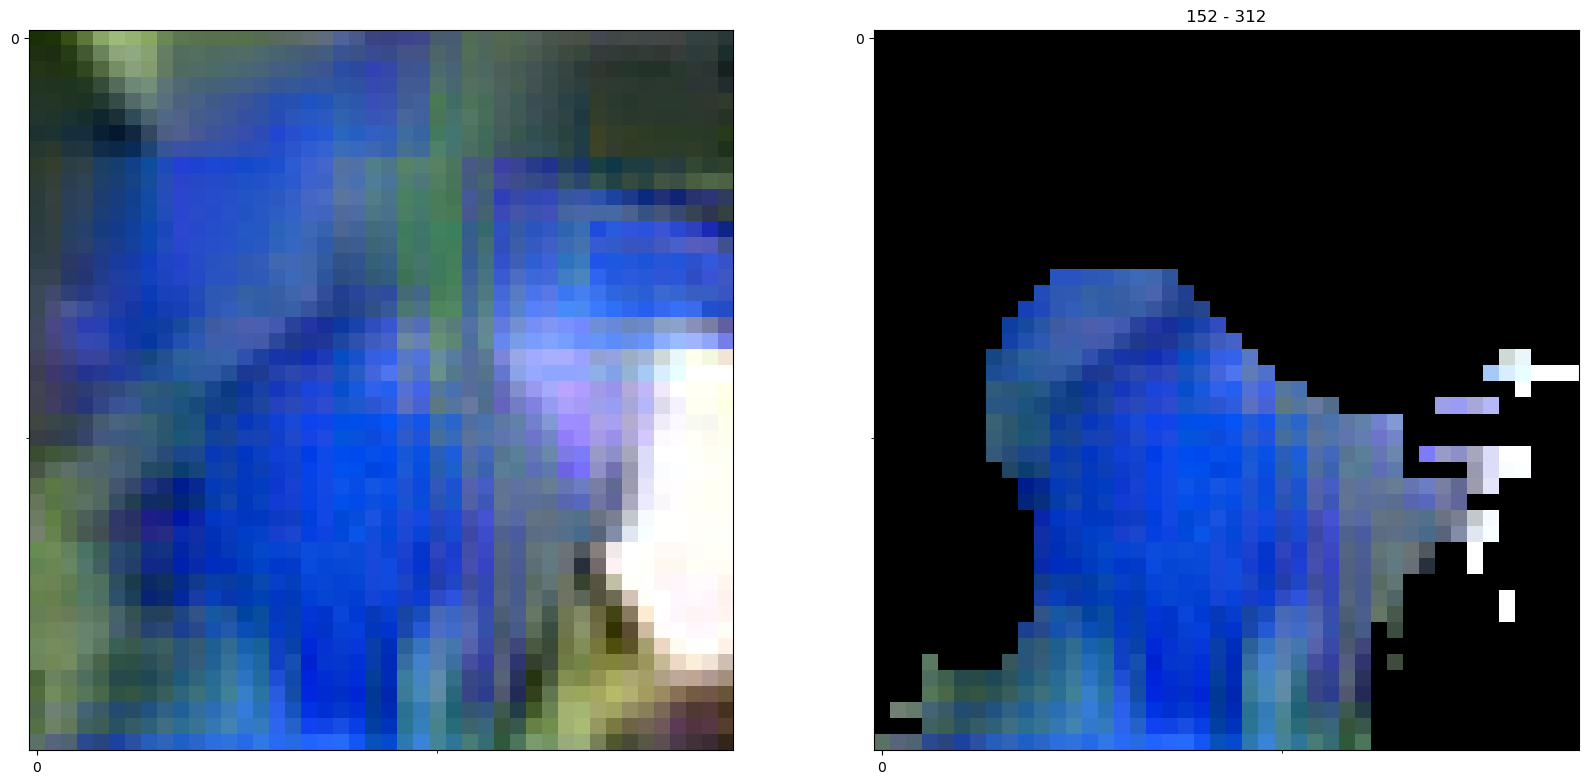

 21%|████████████████████████████████████████▎                                                                                                                                                   | 3/14 [00:00<00:02,  4.98it/s]

pix size mean: width - 39.76487822353328, height - 32.14186117818911
pix size median: width - 39.7443599769736, height - 32.125276325877145
pix size mean filtered: width - 39.72226876036176, height - 32.115784628843194
pix size median filtered: width - 39.711786373593824, height - 32.10730953196829
margin 2: width - 32.73670747876167, height - 24.785222485661507
margin 5: width - 34.24305096268654, height - 19.424602389335632
margin 8: width - 27.7110505849123, height - 17.902875319123268
margin 2 filtered: width - 35.16518697142601, height - 27.761394158005714
margin 5 filtered: width - 32.757386565208435, height - 19.31510493159294
margin 8 filtered: width - 28.090763837099075, height - 17.902875319123268


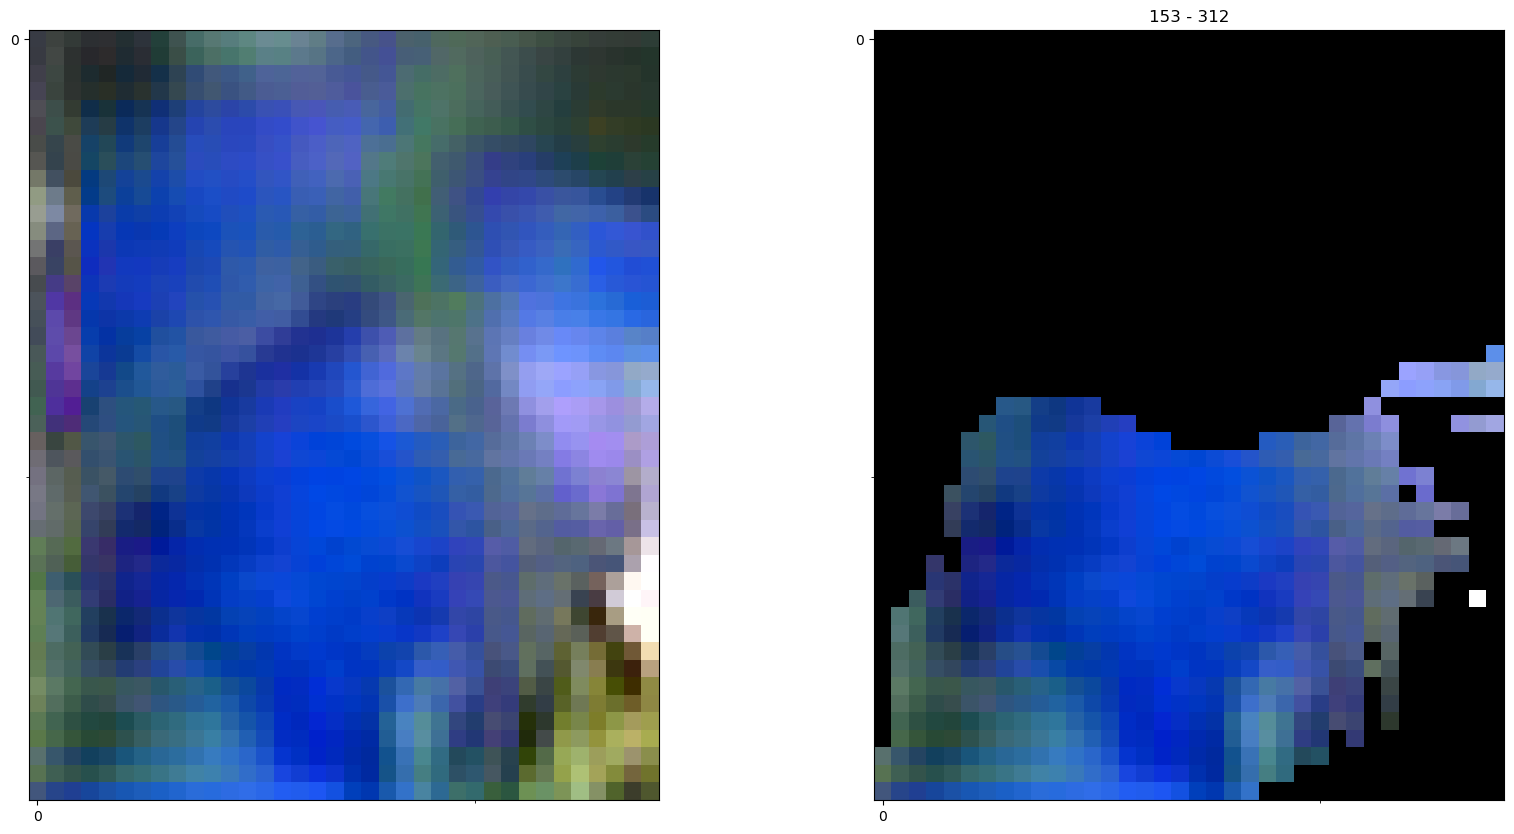

 29%|█████████████████████████████████████████████████████▋                                                                                                                                      | 4/14 [00:00<00:01,  5.58it/s]

pix size mean: width - 45.21208696371248, height - 41.24822196251856
pix size median: width - 45.03940796725866, height - 41.09068219710787
pix size mean filtered: width - 45.064440657932096, height - 41.0546870140084
pix size median filtered: width - 44.932103517784405, height - 40.9341249968221
margin 2: width - 36.86942160129547, height - 42.705077677965164
margin 5: width - 19.719576463103294, height - 10.895315557718277
margin 8: width - nan, height - 9.32067446410656
margin 2 filtered: width - 20.653072744607925, height - 11.398128233850002
margin 5 filtered: width - 3.6348956637084484, height - 13.578010722994804
margin 8 filtered: width - nan, height - 11.068377643823624


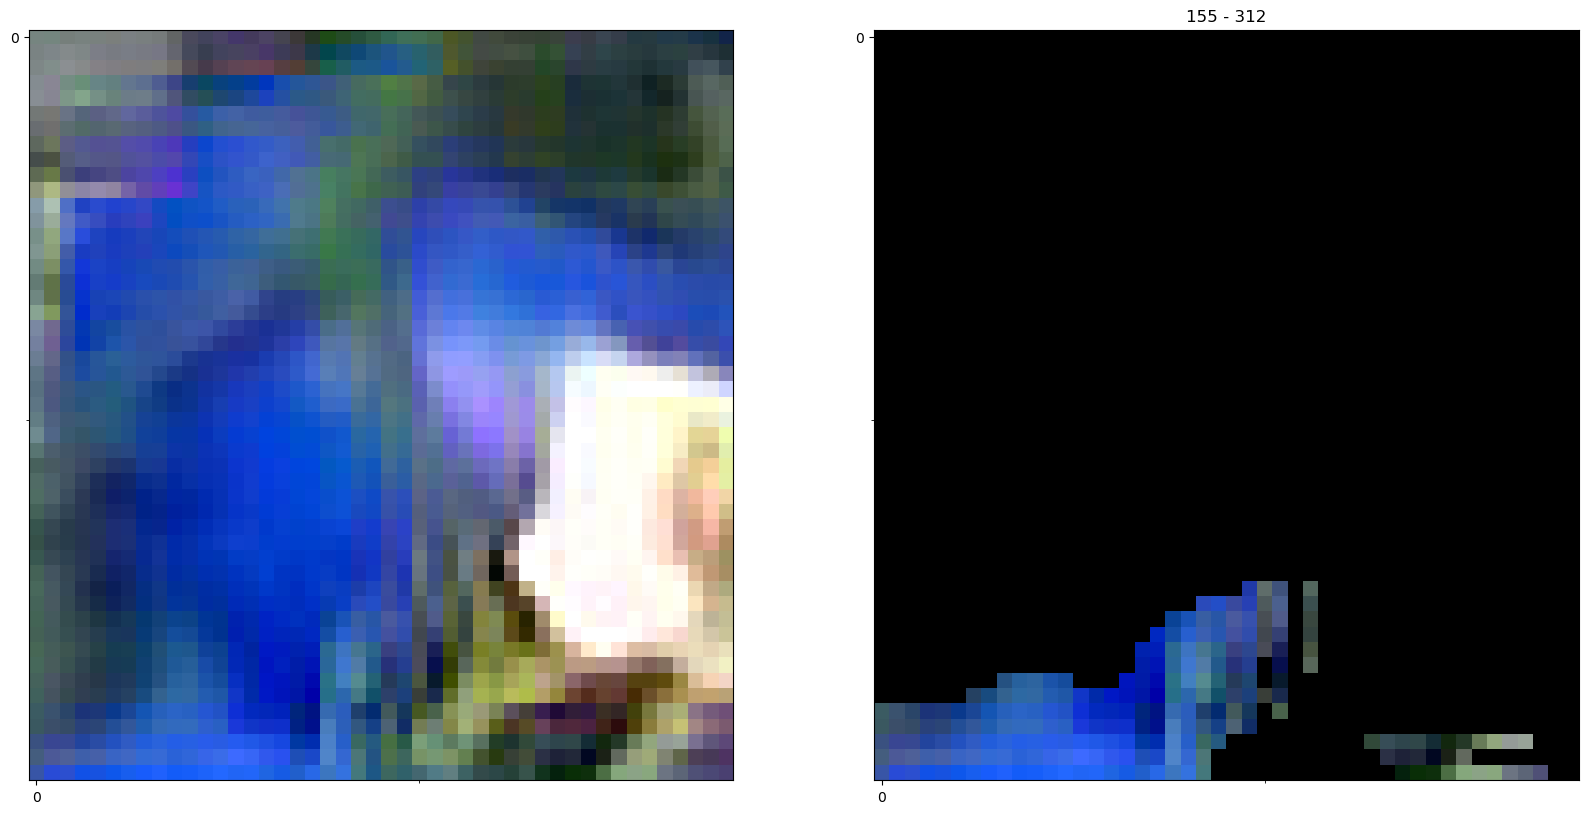

 36%|███████████████████████████████████████████████████████████████████▏                                                                                                                        | 5/14 [00:00<00:01,  5.79it/s]

pix size mean: width - 43.432959893029086, height - 44.698642983615656
pix size median: width - 43.42221933446434, height - 44.68758943364086
pix size mean filtered: width - 43.31103634977176, height - 44.513606851933446
pix size median filtered: width - 43.37169433371217, height - 44.57594906022765
margin 2: width - 48.47158119082451, height - 27.05102413892746
margin 5: width - 39.2436757683754, height - 14.237713068723679
margin 8: width - 9.29981842637062, height - 13.565950095653534
margin 2 filtered: width - 40.67528620362282, height - 23.780738934874535
margin 5 filtered: width - 34.20101851224899, height - 15.559795312583447
margin 8 filtered: width - 8.786594495177269, height - 13.565950095653534


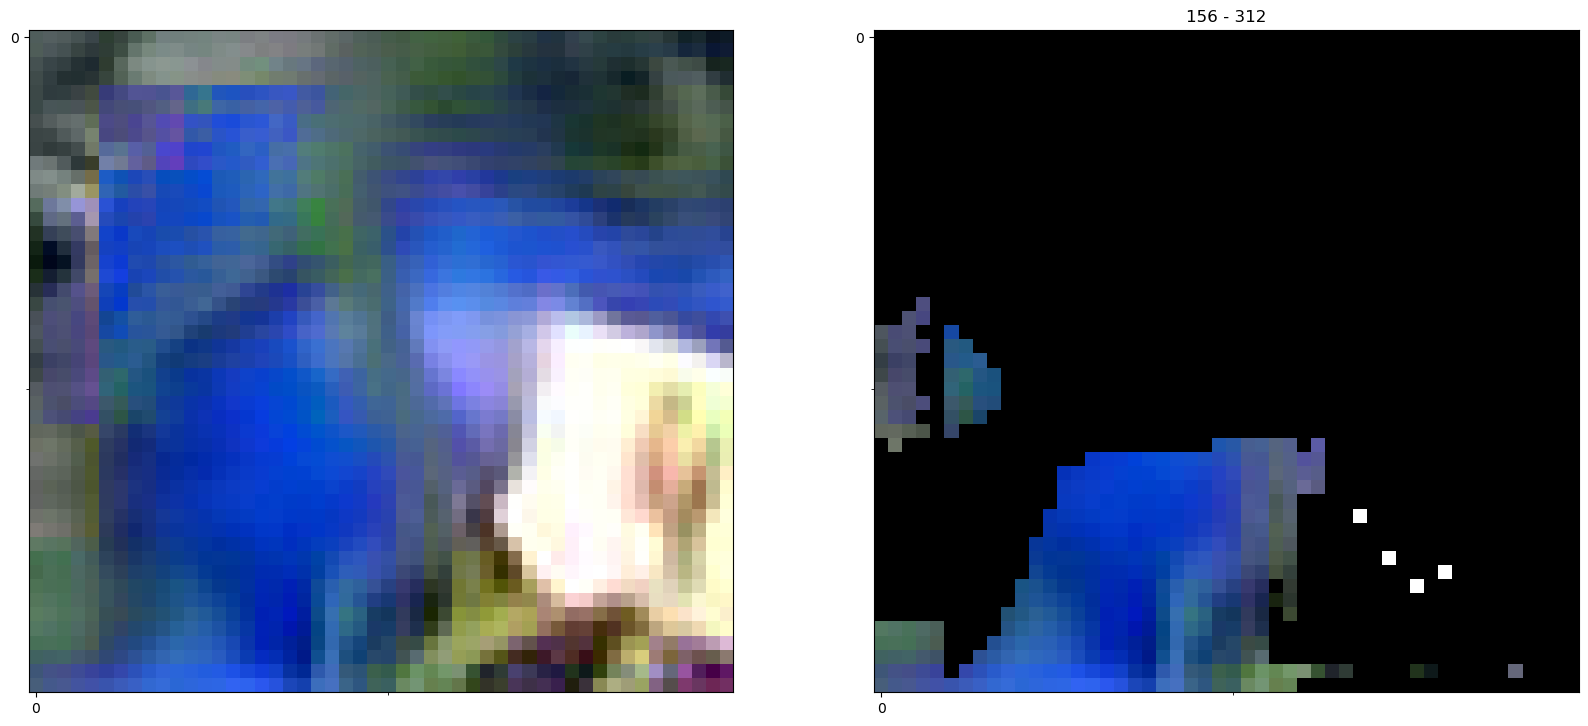

 43%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 6/14 [00:01<00:01,  5.97it/s]

pix size mean: width - 39.731084095746134, height - 34.73163179063681
pix size median: width - 39.6649732080695, height - 34.67383978570174
pix size mean filtered: width - 39.57119818027226, height - 34.67446460441923
pix size median filtered: width - 39.51739829743874, height - 34.627322182182375
margin 2: width - 37.2520349919796, height - 34.21759977936745
margin 5: width - 37.041373550891876, height - 29.826926067471504
margin 8: width - 36.977604031562805, height - 23.37484434247017
margin 2 filtered: width - 36.080338060855865, height - 30.359474942088127
margin 5 filtered: width - 35.80113500356674, height - 29.7002661973238
margin 8 filtered: width - 35.91764345765114, height - 23.37484434247017


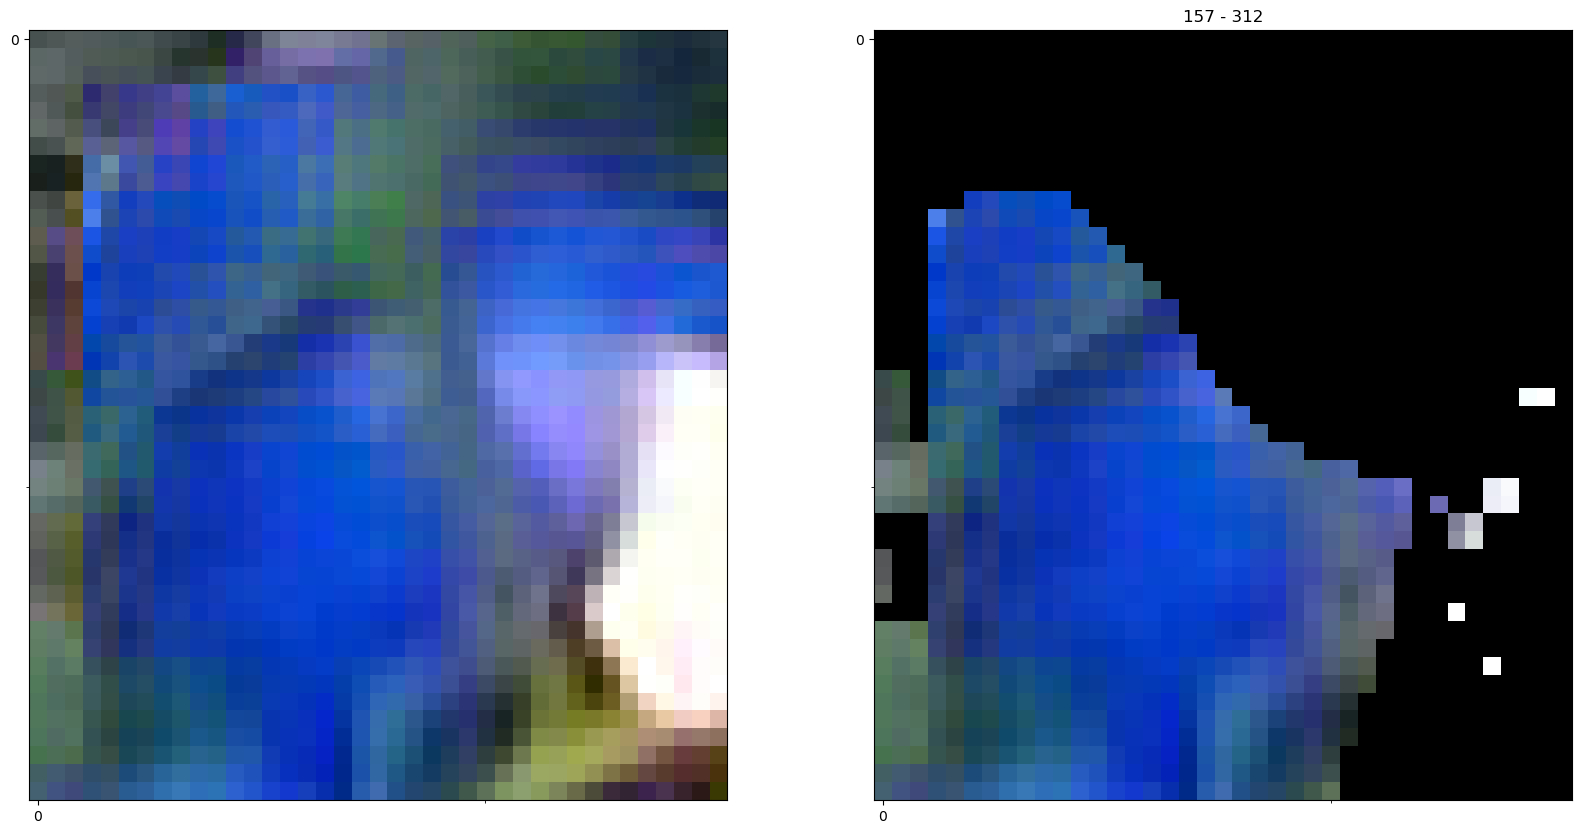

 50%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 7/14 [00:01<00:01,  5.86it/s]

pix size mean: width - 41.52503508490126, height - 35.472045324666766
pix size median: width - 41.59029034274688, height - 35.52778850367289
pix size mean filtered: width - 41.35149753004372, height - 35.384821788199076
pix size median filtered: width - 41.430399776049505, height - 35.45233909906734
margin 2: width - 36.11462935805321, height - 31.111067160964012
margin 5: width - 36.18689626455307, height - 28.980929404497147
margin 8: width - 36.17189824581146, height - 27.47195027768612
margin 2 filtered: width - 35.214878618717194, height - 30.231215059757233
margin 5 filtered: width - 35.13741493225098, height - 29.08860519528389
margin 8 filtered: width - 35.150762647390366, height - 27.827110141515732


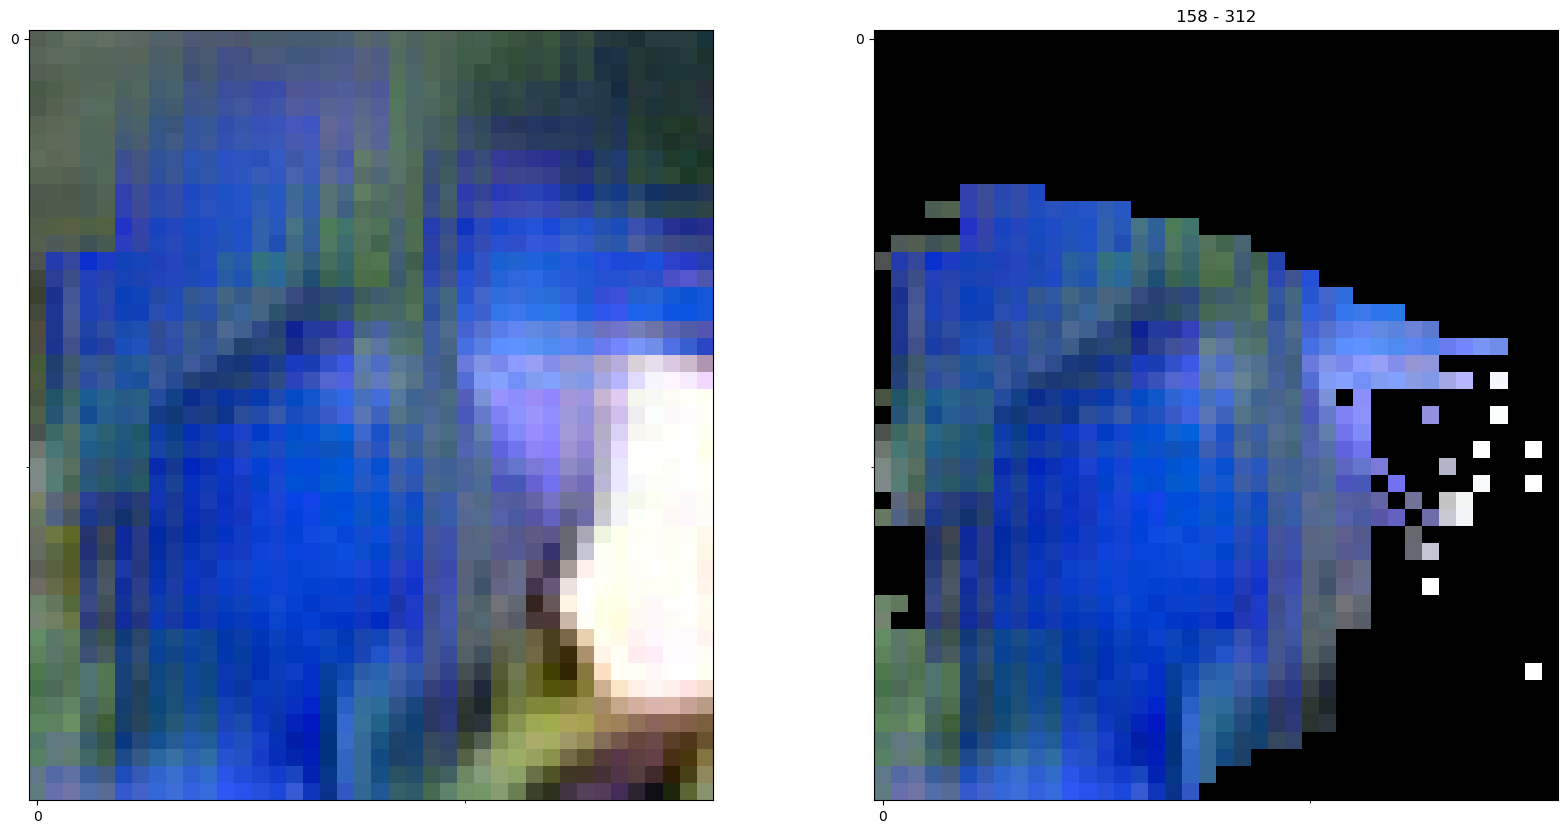

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 8/14 [00:01<00:01,  5.92it/s]

pix size mean: width - 41.90536959815889, height - 35.64421908368144
pix size median: width - 41.8943317025055, height - 35.63483037825619
pix size mean filtered: width - 41.87314924583481, height - 35.64421908368144
pix size median filtered: width - 41.88486814881625, height - 35.65419471610496
margin 2: width - 35.415224730968475, height - 36.24020889401436
margin 5: width - 33.86000171303749, height - 27.539387345314026
margin 8: width - 33.72862935066223, height - 20.619014278054237
margin 2 filtered: width - 34.66803580522537, height - 32.07040950655937
margin 5 filtered: width - 33.97664055228233, height - 26.69977955520153
margin 8 filtered: width - 33.77716988325119, height - 21.15710638463497


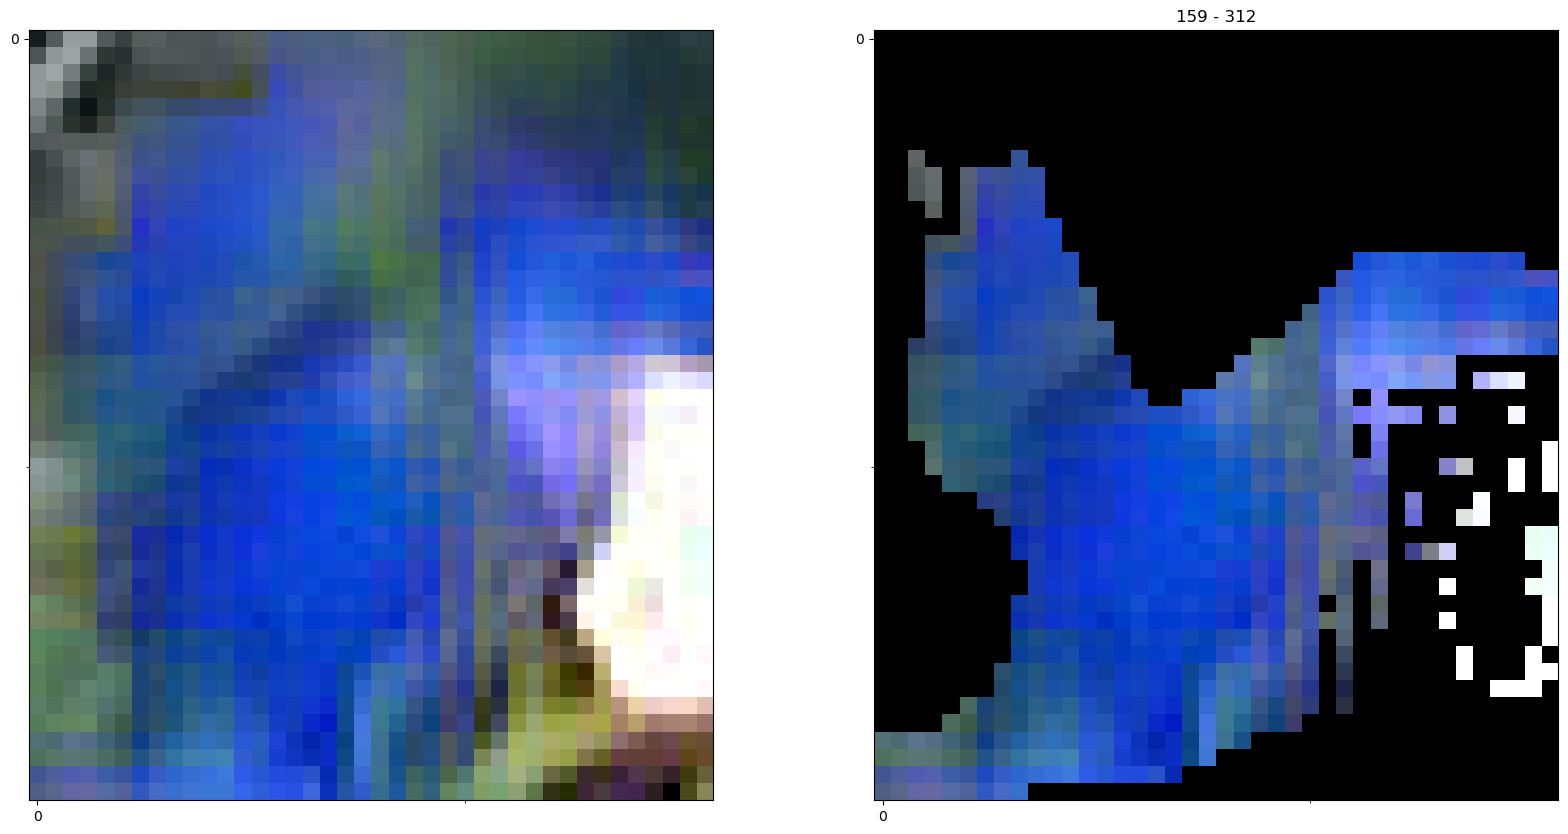

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 9/14 [00:01<00:00,  5.94it/s]

pix size mean: width - 41.82294944451237, height - 33.66737878003259
pix size median: width - 41.90909392966422, height - 33.73672489382751
pix size mean filtered: width - 41.76273546496663, height - 33.55583520222784
pix size median filtered: width - 41.919647560776454, height - 33.681912107143404
margin 2: width - 35.1545587182045, height - 34.855350852012634
margin 5: width - 35.18548235297203, height - 34.784361720085144
margin 8: width - 30.669808387756348, height - 21.917328238487244
margin 2 filtered: width - 39.39666226506233, height - 29.405202716588974
margin 5 filtered: width - 38.08927908539772, height - 28.998257592320442
margin 8 filtered: width - 29.941948130726814, height - 22.280270233750343


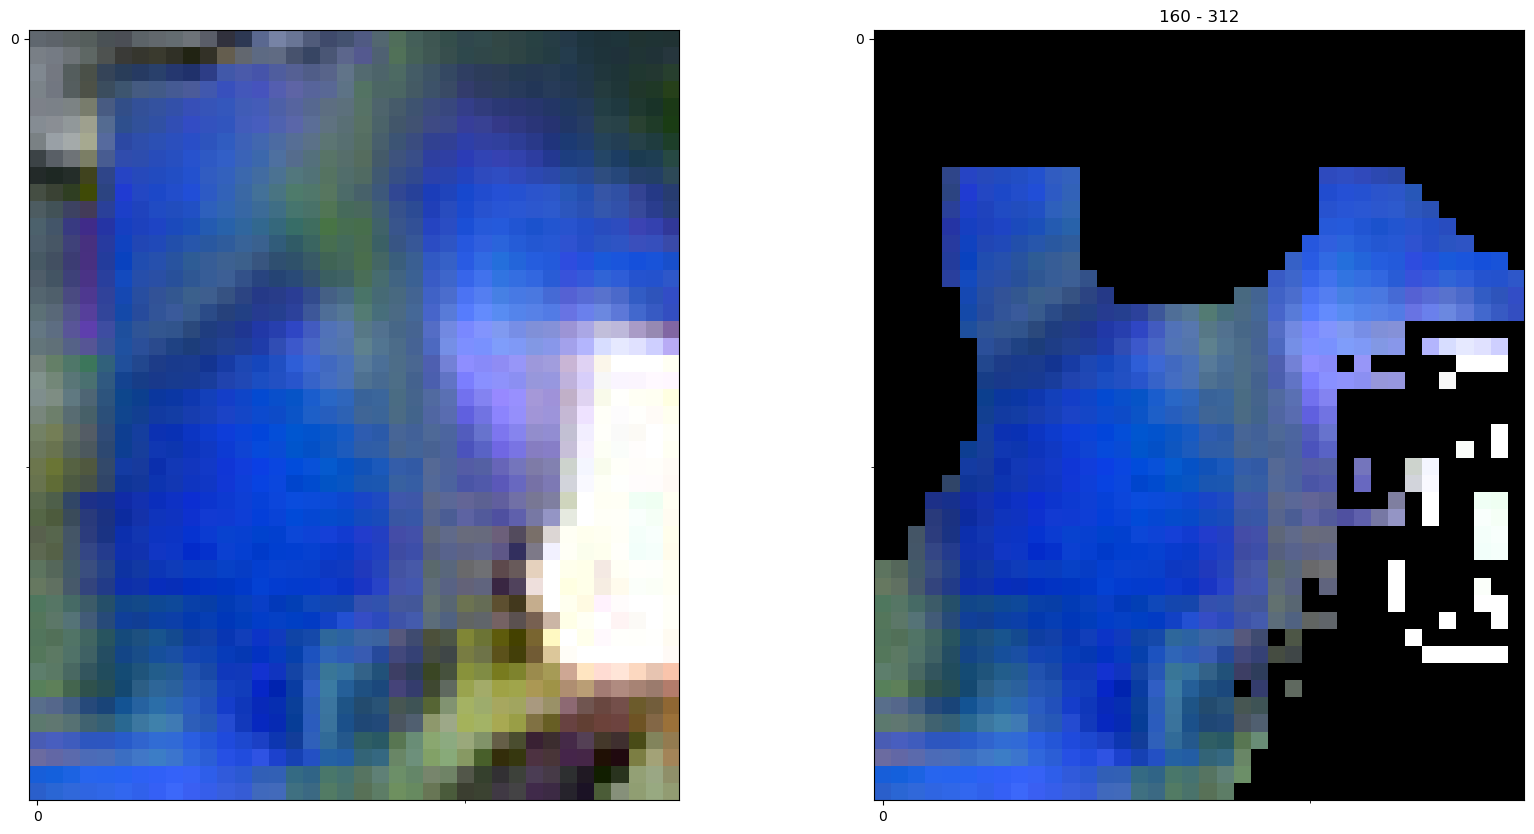

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 10/14 [00:01<00:00,  5.77it/s]

pix size mean: width - 51.13552931480818, height - 46.87435011505467
pix size median: width - 51.300974996950565, height - 47.026009028801745
pix size mean filtered: width - 51.15200692832076, height - 46.88945463113569
pix size median filtered: width - 51.4363524896637, height - 47.15010536800392
margin 2: width - 50.38958415389061, height - 45.472558587789536
margin 5: width - 49.055442214012146, height - 43.425992131233215
margin 8: width - 47.253213822841644, height - 42.650673538446426
margin 2 filtered: width - 53.791649639606476, height - 45.60941085219383
margin 5 filtered: width - 51.636964082717896, height - 43.06798428297043
margin 8 filtered: width - 47.41876199841499, height - 42.650673538446426


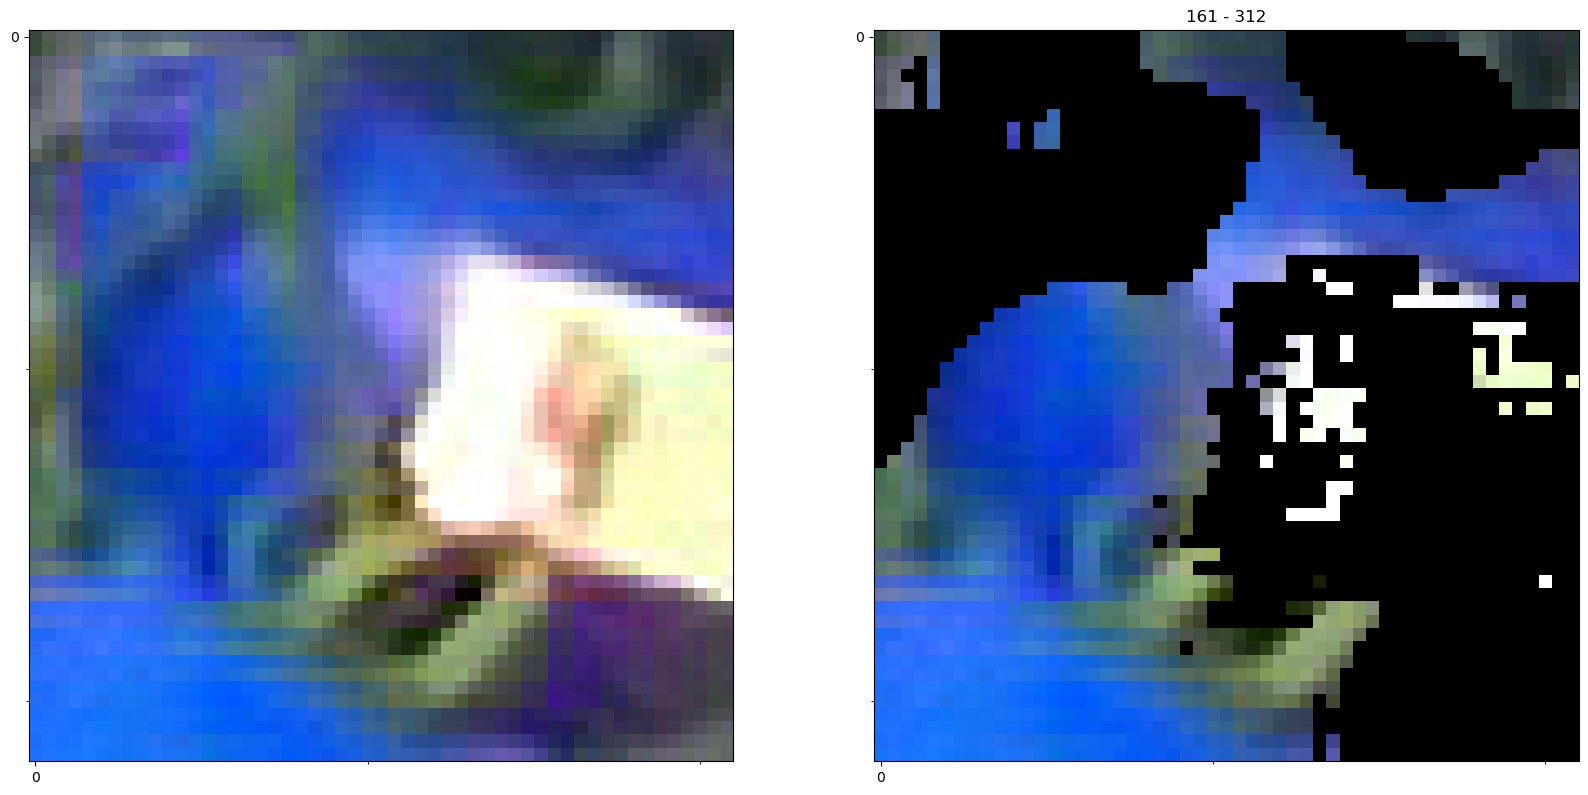

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 11/14 [00:02<00:00,  5.71it/s]

pix size mean: width - 53.30679741377891, height - 51.51763835696558
pix size median: width - 53.84695891332273, height - 52.03967018288543
pix size mean filtered: width - 53.30451134202541, height - 51.5167890151181
pix size median filtered: width - 53.899790471530714, height - 52.092103722030146
margin 2: width - 51.236219704151154, height - 42.91019216179848
margin 5: width - 51.09276995062828, height - 42.70702973008156
margin 8: width - 51.071856170892715, height - 41.85269773006439
margin 2 filtered: width - 51.23082548379898, height - 42.97298192977905
margin 5 filtered: width - 51.13297328352928, height - 42.69072413444519
margin 8 filtered: width - 51.15649849176407, height - 41.82813689112663


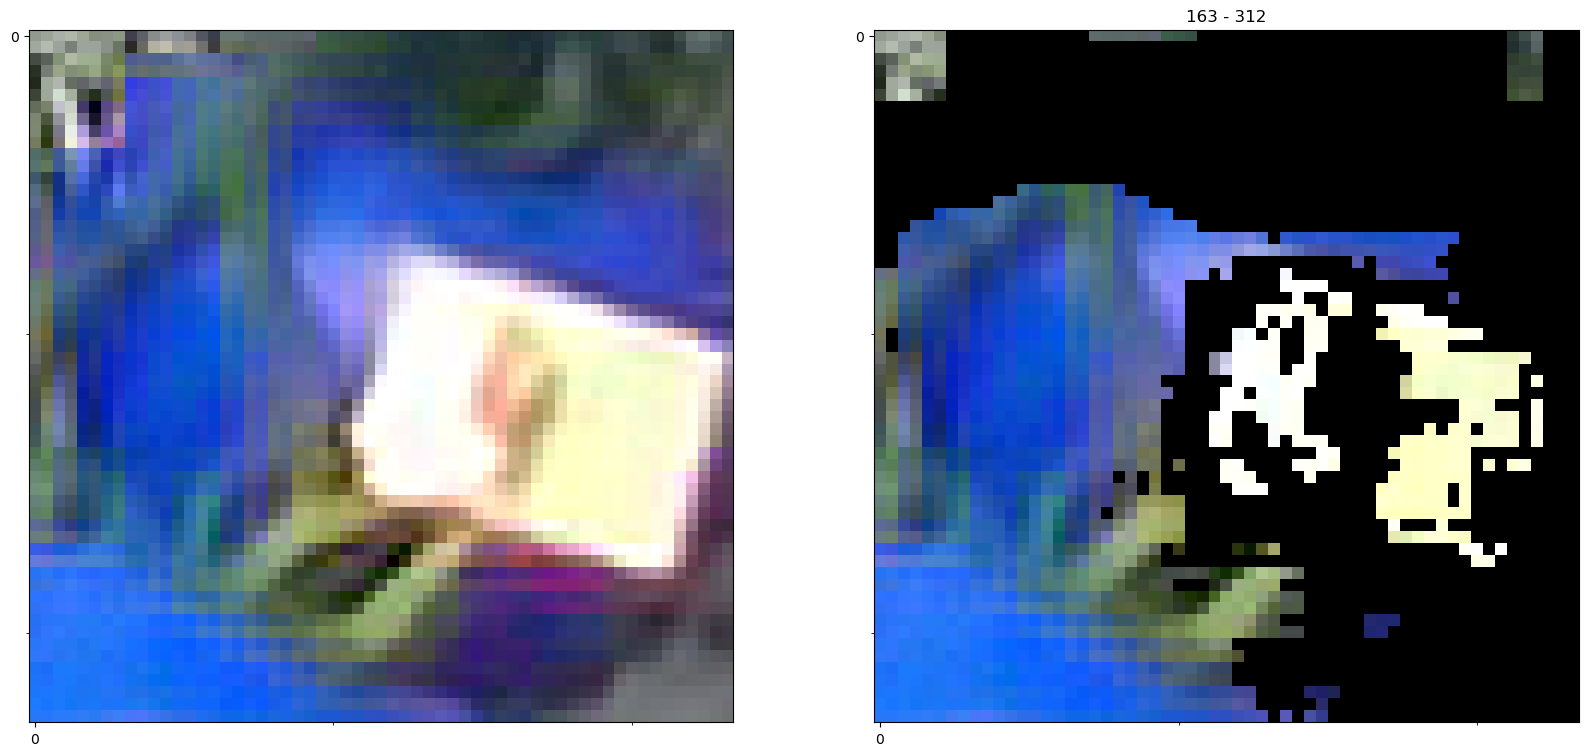

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 12/14 [00:02<00:00,  5.60it/s]

pix size mean: width - 36.9292426640812, height - 39.493637727101635
pix size median: width - 36.952955400516856, height - 39.51899709422505
pix size mean filtered: width - 37.1246304126309, height - 39.49377958759849
pix size median filtered: width - 37.15230404878231, height - 39.52321924731776
margin 2: width - 52.05802991986275, height - 35.33681109547615
margin 5: width - 45.19322142004967, height - 31.226137652993202
margin 8: width - 43.55890303850174, height - 29.225090518593788
margin 2 filtered: width - 47.32467979192734, height - 32.710738480091095
margin 5 filtered: width - 44.682905077934265, height - 30.09258024394512
margin 8 filtered: width - 43.55890303850174, height - 28.891662135720253


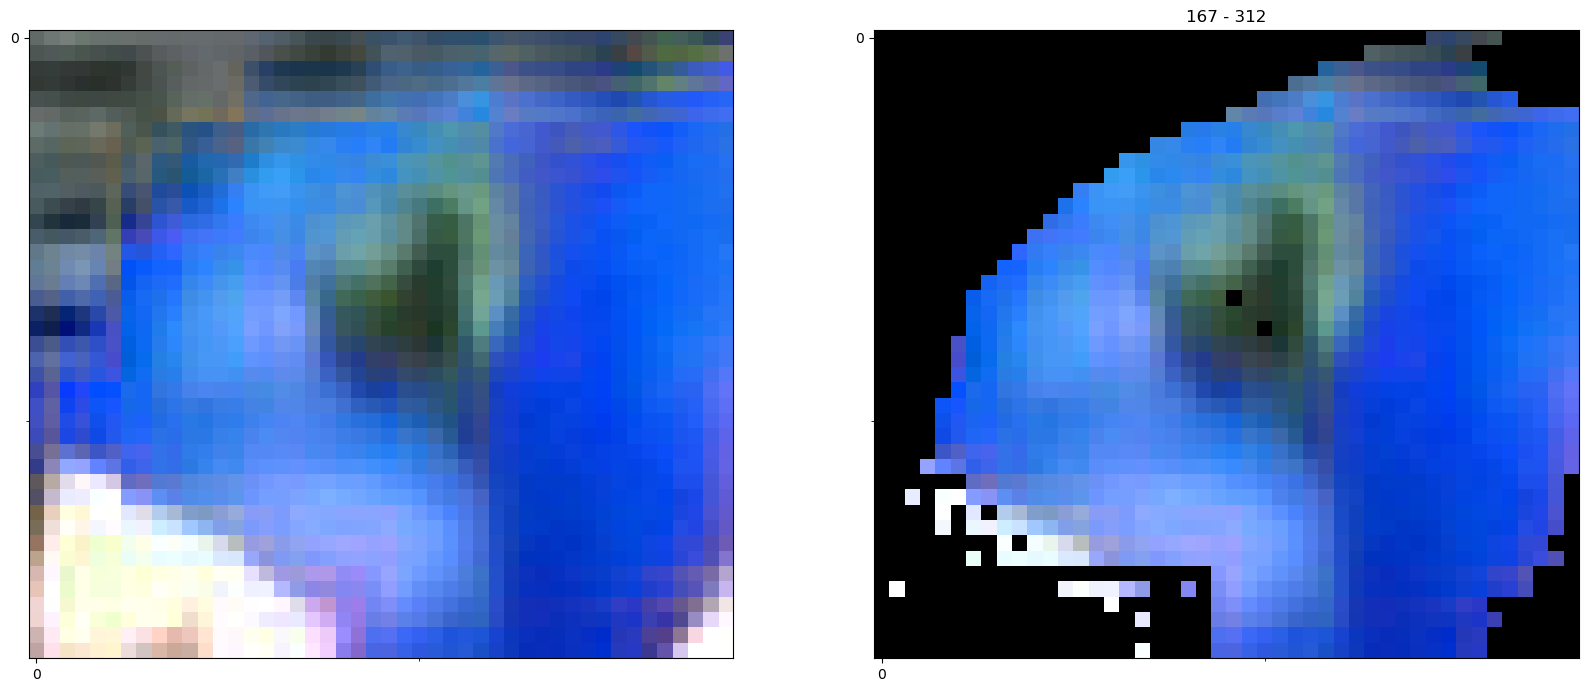

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 13/14 [00:02<00:00,  5.56it/s]

pix size mean: width - 38.49223875155287, height - 33.464902784978996
pix size median: width - 38.51597554653291, height - 33.4855394006241
pix size mean filtered: width - 38.72684451651107, height - 33.464902784978996
pix size median filtered: width - 38.72735619488378, height - 33.4653449399548
margin 2: width - 39.68581184744835, height - 36.95623204112053
margin 5: width - 39.53823819756508, height - 36.82013601064682
margin 8: width - 34.25736352801323, height - 36.68348491191864
margin 2 filtered: width - 40.190402418375015, height - 35.86813434958458
margin 5 filtered: width - 39.53823819756508, height - 35.731177777051926
margin 8 filtered: width - 34.25736352801323, height - 35.74042767286301


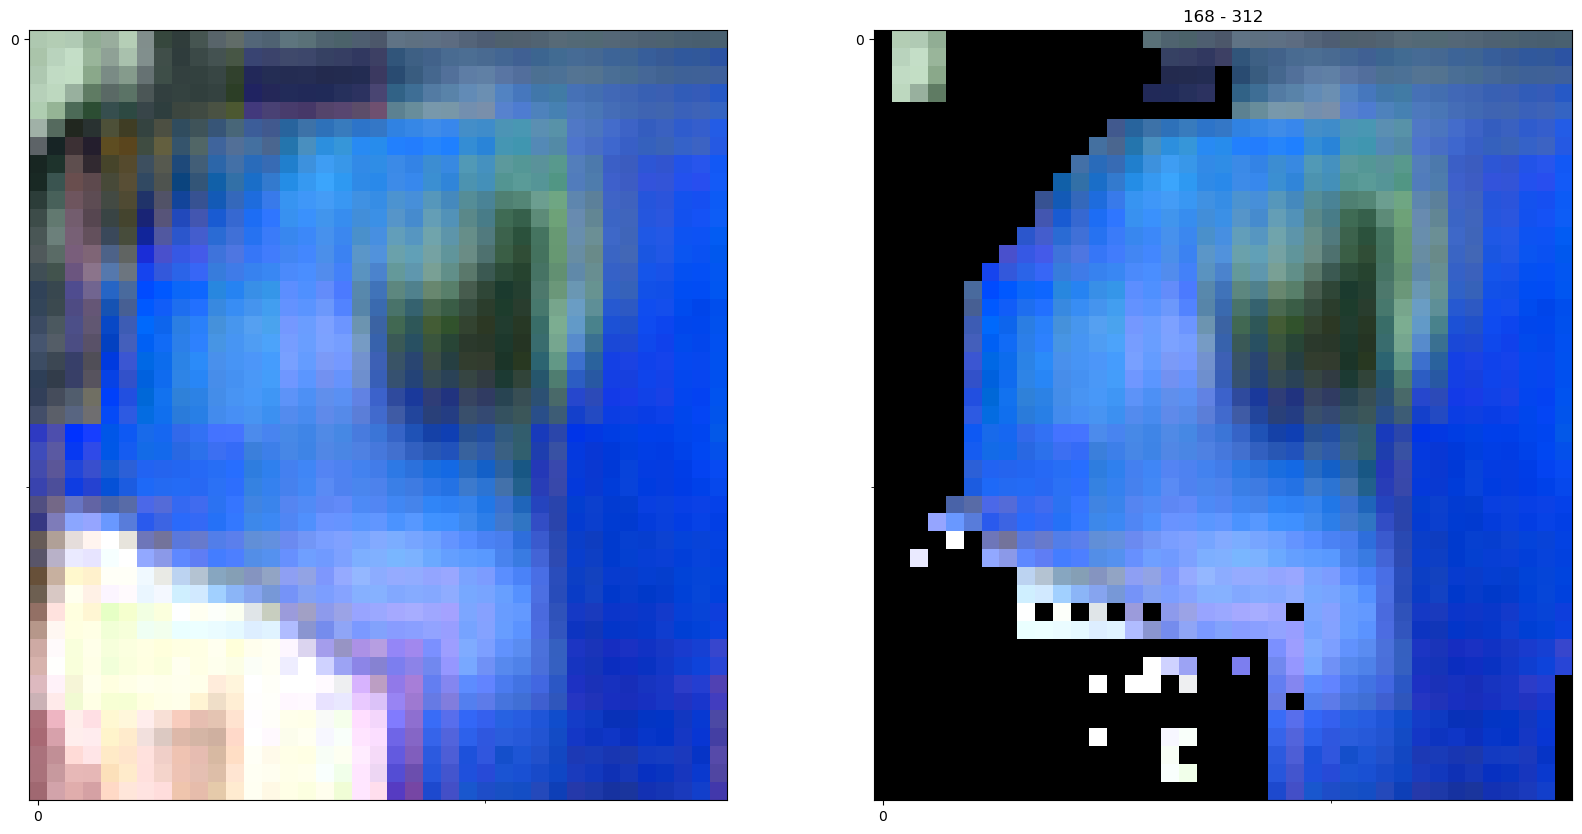

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.42it/s]

ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 42.12189471868128 4.673319229827379 38.815110670077495 5.410589786651769 
 pix med: 
 42.17116050575861 4.778264044411118 38.862099417465764 5.506534508430012 
 pix mean filtered: 
 42.038091130279255 4.694236483204444 38.73459500559468 5.415243527052262 
 pix med filtered: 
 42.11809199450714 4.826767642815171 38.80997567847452 5.534348373257027 
 margin 0.2: 
 39.63717977915491 8.540924602257979 33.11292773910931 7.543910611498033 
 margin 0.5: 
 36.026244184800554 9.594618057578327 26.752843388489314 10.362990875199307 
 margin 0.8: 
 31.995404332589644 12.904857874052007 23.797826375812292 10.558164620148414 
 margin_f0.2: 
 38.39238573397909 9.037719445268989 29.102236764239414 8.99023446754113 
 margin 0.5_f: 
 34.55131012015045 12.192713634777144 26.310578720378025 9.610797600230317 
 margin 0.8_f: 
 31.801786811019365 12.947538348886077 23.919458567563975 10.29373593374892



/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),
  0%|                                                                                                                                                                                                     | 0/9 [00:00<?, ?it/s]

pix size mean: width - 52.7935543264875, height - 38.61261636408846
pix size median: width - 52.92125595762593, height - 38.70601591172495
pix size mean filtered: width - 52.42728397062846, height - 38.65035763034331
pix size median filtered: width - 52.49615228719019, height - 38.70112861947184
margin 2: width - 30.748439952731133, height - 35.98672151565552
margin 5: width - 27.910318225622177, height - 13.691903091967106
margin 8: width - 6.079563405364752, height - 13.691903091967106
margin 2 filtered: width - 26.045072823762894, height - 35.38377210497856
margin 5 filtered: width - 23.950114846229553, height - 9.987561963498592
margin 8 filtered: width - 6.079563405364752, height - 9.987561963498592


/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)


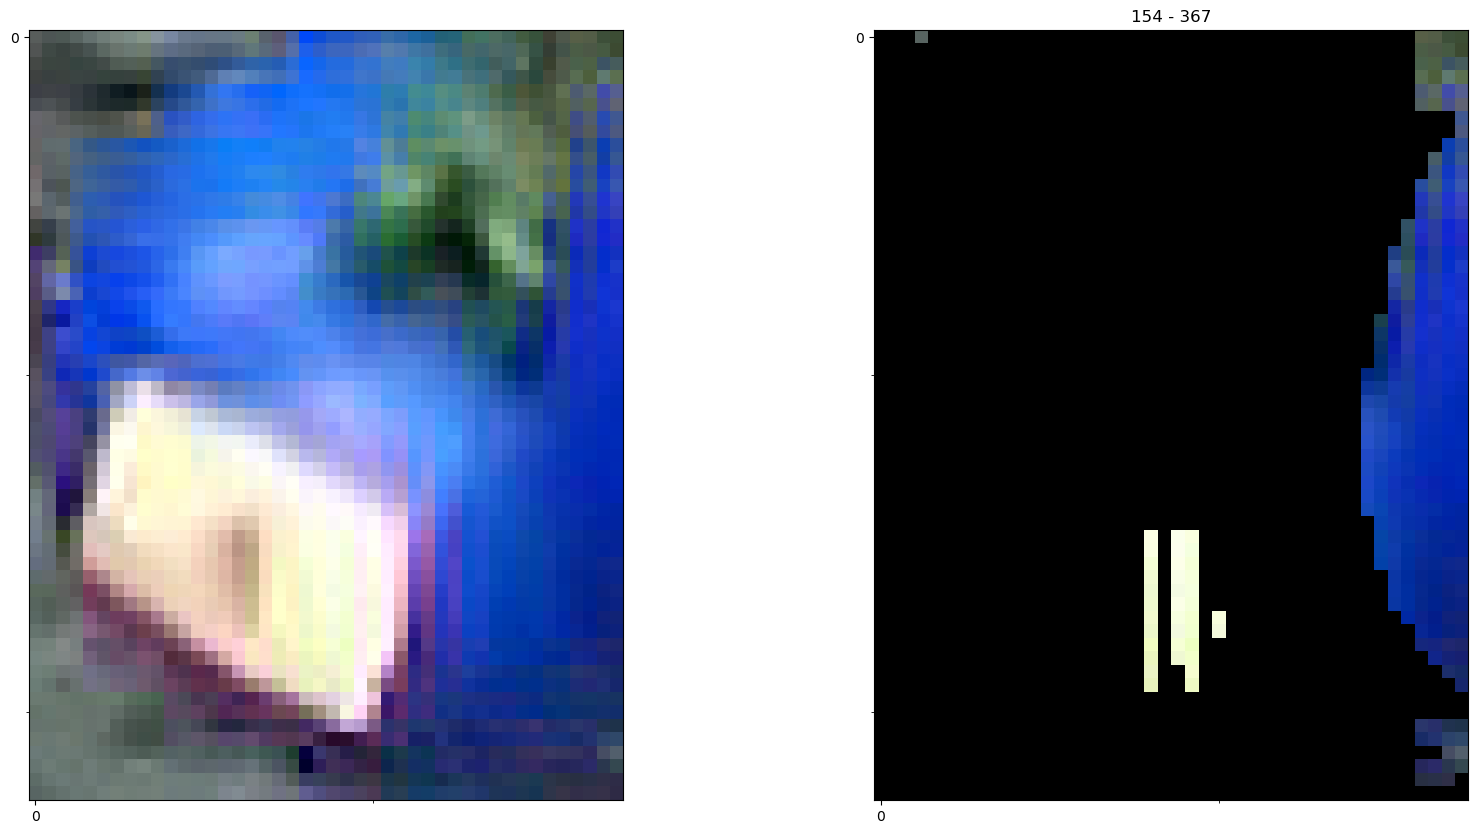

 11%|█████████████████████                                                                                                                                                                        | 1/9 [00:00<00:01,  4.99it/s]

pix size mean: width - 48.8755890561038, height - 53.22192002863848
pix size median: width - 50.14246778816952, height - 54.60145774605786
pix size mean filtered: width - 49.0056659996638, height - 52.98939599004851
pix size median filtered: width - 50.13268704328843, height - 54.20803394040617
margin 2: width - 60.41145324707031, height - 45.80049589276314
margin 5: width - 58.9664950966835, height - 45.71717232465744
margin 8: width - 53.851377218961716, height - 48.64656925201416
margin 2 filtered: width - 59.94836986064911, height - 36.85768321156502
margin 5 filtered: width - 58.68217349052429, height - 37.70295903086662
margin 8 filtered: width - 53.98979038000107, height - 36.27454489469528


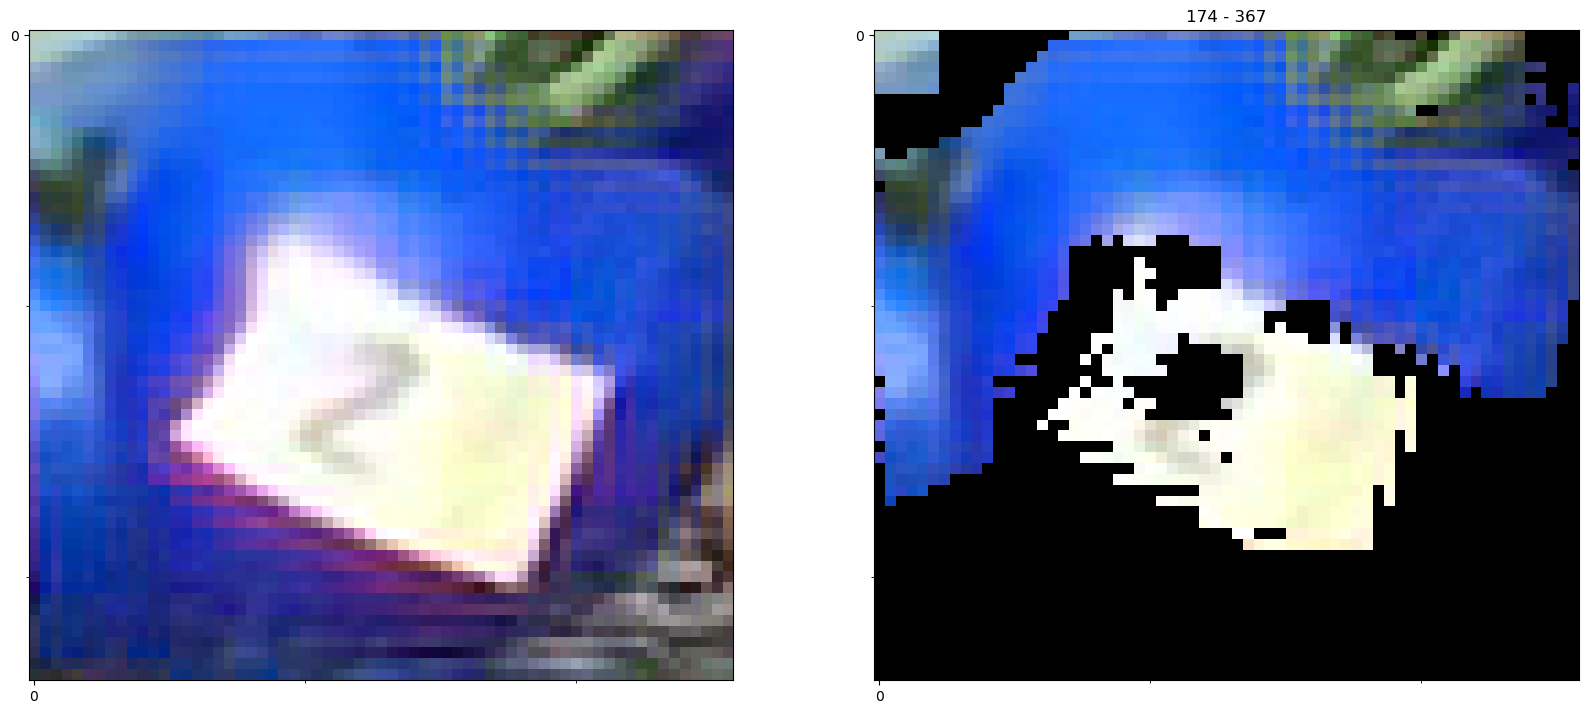

 22%|██████████████████████████████████████████                                                                                                                                                   | 2/9 [00:00<00:01,  5.00it/s]

pix size mean: width - 49.325569063780655, height - 51.88703486675325
pix size median: width - 49.74260956871965, height - 52.32573219212292
pix size mean filtered: width - 49.32856682050727, height - 51.72200196157403
pix size median filtered: width - 49.69426884322745, height - 52.10544794339852
margin 2: width - 43.252263218164444, height - 44.36628893017769
margin 5: width - 43.152641505002975, height - 44.89089548587799
margin 8: width - 43.52377727627754, height - 48.48400503396988
margin 2 filtered: width - 43.1201197206974, height - 44.36628893017769
margin 5 filtered: width - 43.152641505002975, height - 44.89089548587799
margin 8 filtered: width - 43.96793246269226, height - 48.48400503396988


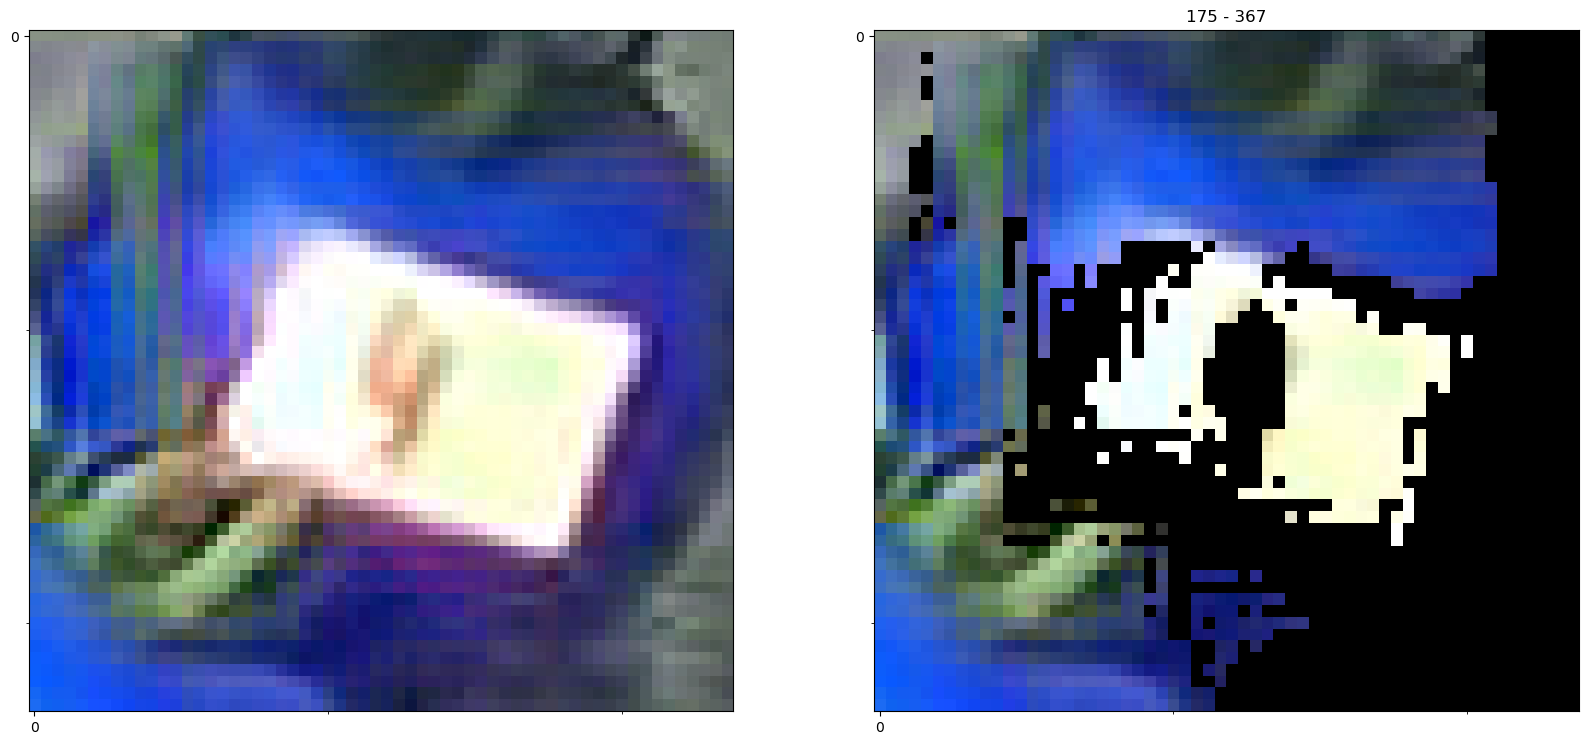

 33%|███████████████████████████████████████████████████████████████                                                                                                                              | 3/9 [00:00<00:01,  4.90it/s]

pix size mean: width - 49.69824727029884, height - 51.73018530215927
pix size median: width - 49.98879221042689, height - 52.03260931944269
pix size mean filtered: width - 49.658732837962546, height - 51.340976061879154
pix size median filtered: width - 50.08440585828864, height - 51.78106921564654
margin 2: width - 43.96618902683258, height - 48.34475740790367
margin 5: width - 44.030800461769104, height - 49.51363429427147
margin 8: width - 44.40358281135559, height - 49.82268437743187
margin 2 filtered: width - 43.96618902683258, height - 48.3168289065361
margin 5 filtered: width - 44.030800461769104, height - 49.44884404540062
margin 8 filtered: width - 44.40358281135559, height - 49.736138433218


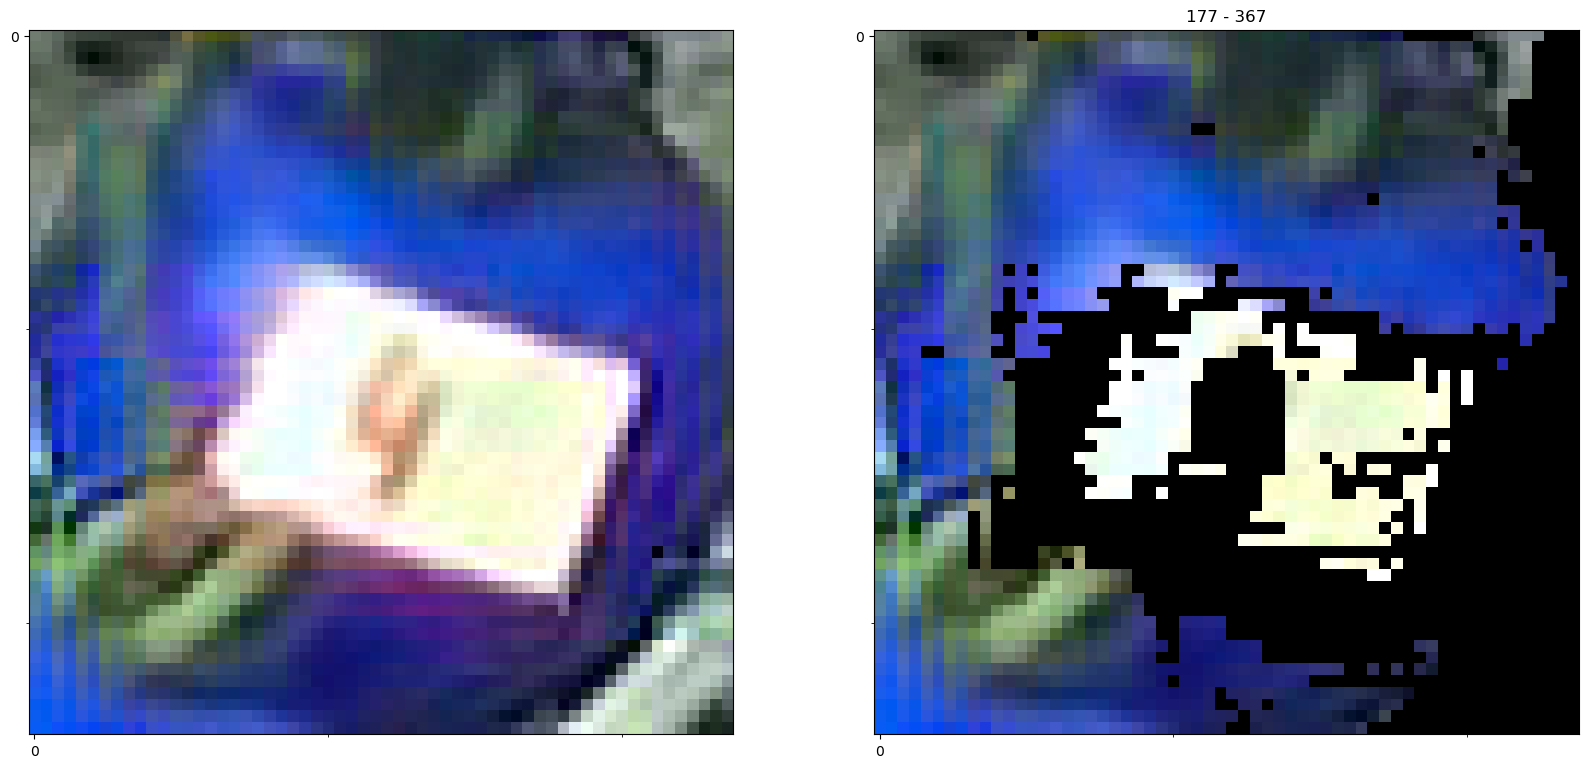

 44%|████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 4/9 [00:00<00:01,  4.73it/s]

pix size mean: width - 48.93193247837038, height - 52.366222395301776
pix size median: width - 49.284037137232865, height - 52.7430395357359
pix size mean filtered: width - 48.95598018059462, height - 52.05919836965368
pix size median filtered: width - 49.42779640282857, height - 52.56092204501854
margin 2: width - 40.61654210090637, height - 49.6588833630085
margin 5: width - 40.06157070398331, height - 52.366696298122406
margin 8: width - 39.091866463422775, height - 57.3810376226902
margin 2 filtered: width - 40.61654210090637, height - 49.37945678830147
margin 5 filtered: width - 40.06157070398331, height - 52.074700593948364
margin 8 filtered: width - 35.399213433265686, height - 57.33095481991768


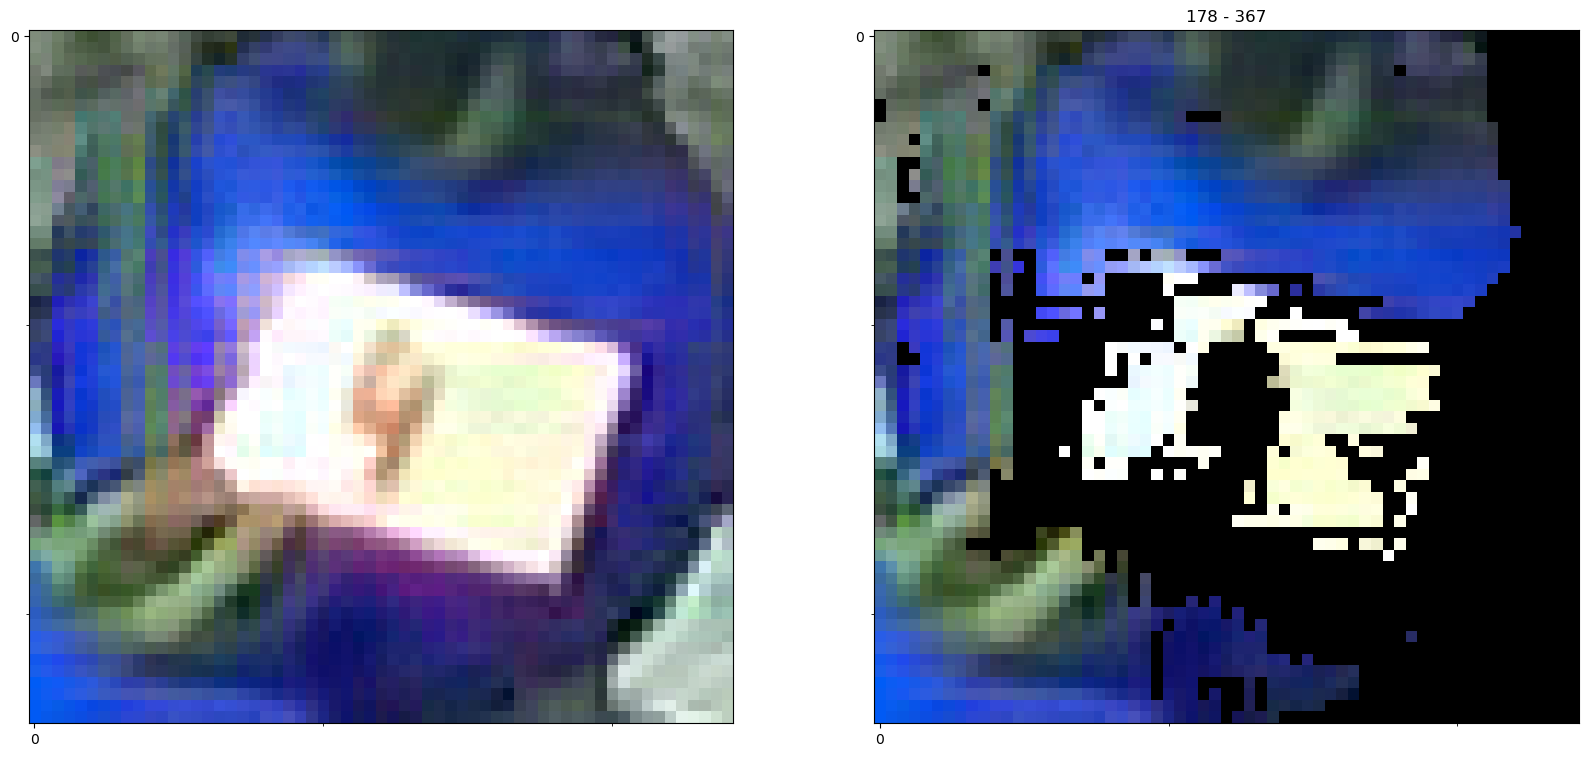

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 5/9 [00:01<00:00,  4.58it/s]

pix size mean: width - 46.72350593264905, height - 53.192514290641746
pix size median: width - 47.15980447738343, height - 53.68921966650165
pix size mean filtered: width - 46.73082224706859, height - 52.841220018064746
pix size median filtered: width - 47.196519919991566, height - 53.36781107753127
margin 2: width - 40.201276540756226, height - 46.46085575222969
margin 5: width - 41.3840152323246, height - 47.6728193461895
margin 8: width - 40.38696363568306, height - 48.18092659115791
margin 2 filtered: width - 40.201276540756226, height - 46.3949479162693
margin 5 filtered: width - 41.3840152323246, height - 47.628484666347504
margin 8 filtered: width - 40.38696363568306, height - 48.19586127996445


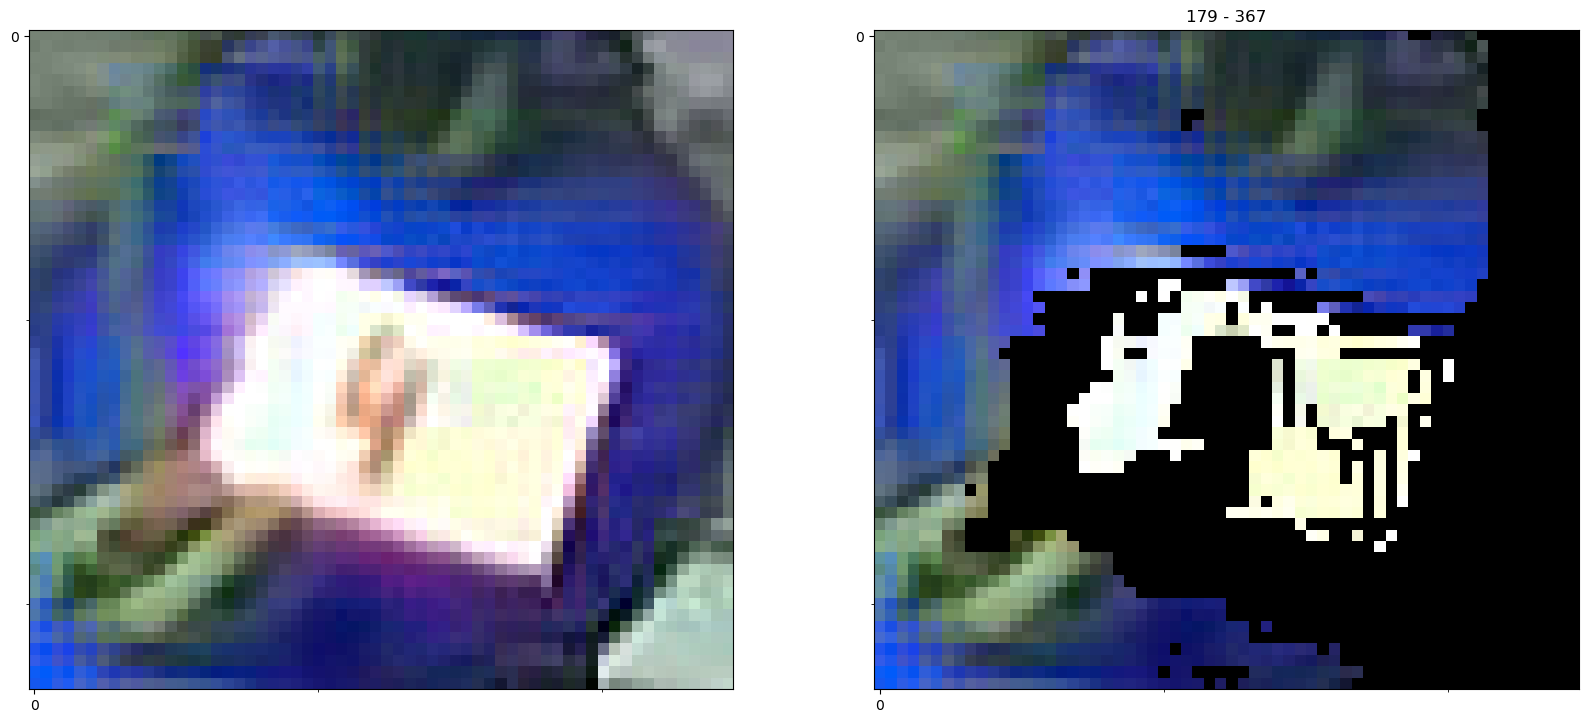

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 6/9 [00:01<00:00,  4.50it/s]

pix size mean: width - 47.43631451137704, height - 54.460388341748825
pix size median: width - 47.38895302625476, height - 54.406013863065795
pix size mean filtered: width - 47.42796108184278, height - 54.32183649295137
pix size median filtered: width - 47.41772139402663, height - 54.31010841873945
margin 2: width - 34.95306894183159, height - 51.908478140830994
margin 5: width - 37.786319851875305, height - 53.66932228207588
margin 8: width - 34.84845161437988, height - 58.17340314388275
margin 2 filtered: width - 35.009320825338364, height - 52.19850316643715
margin 5 filtered: width - 39.00500759482384, height - 53.91350761055946
margin 8 filtered: width - 34.84845161437988, height - 58.18536505103111


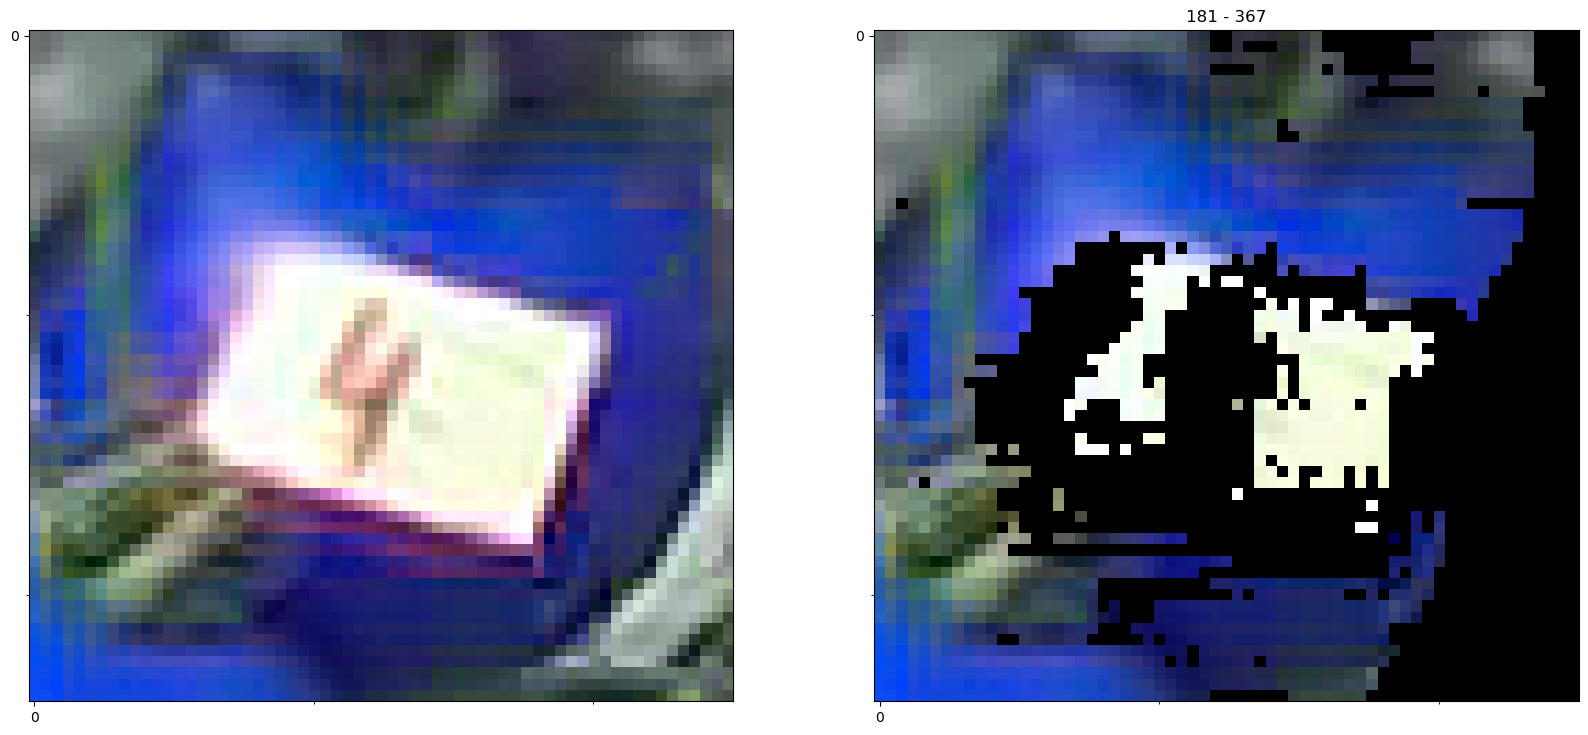

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7/9 [00:01<00:00,  5.00it/s]

pix size mean: width - 43.932680058799235, height - 56.27163622737551
pix size median: width - 44.04915445349378, height - 56.420823683257616
pix size mean filtered: width - 43.98420422042174, height - 55.94652123488978
pix size median filtered: width - 44.12417640260176, height - 56.12456143821789
margin 2: width - 37.33900561928749, height - 49.55156147480011
margin 5: width - 38.036637008190155, height - 50.40355399250984
margin 8: width - 36.64371743798256, height - 51.11934617161751
margin 2 filtered: width - 37.03971952199936, height - 50.08980259299278
margin 5 filtered: width - 37.63357922434807, height - 50.46391114592552
margin 8 filtered: width - 36.64371743798256, height - 51.109712570905685


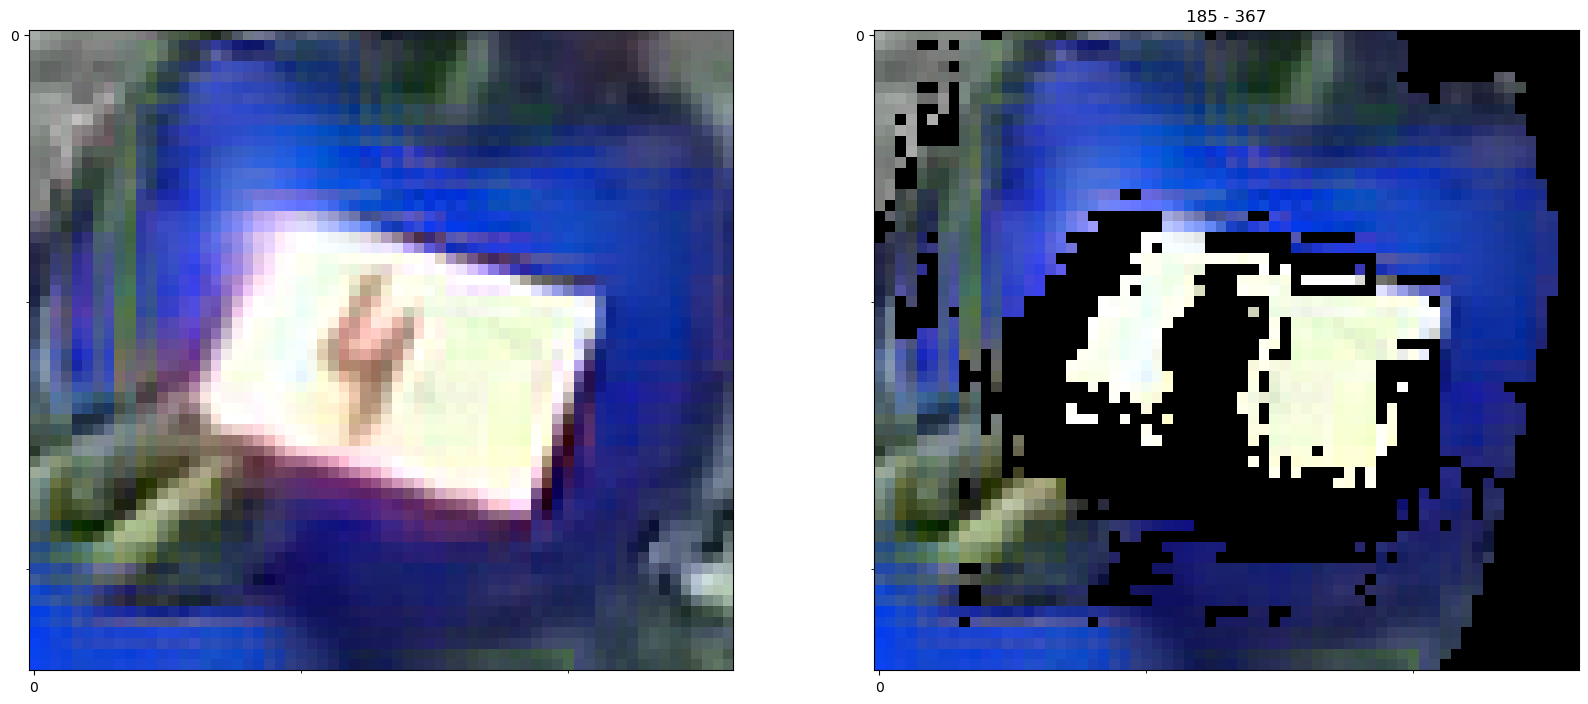

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8/9 [00:01<00:00,  5.35it/s]

pix size mean: width - 41.13551078446435, height - 51.89943852467439
pix size median: width - 41.15881372510591, height - 51.928839145019346
pix size mean filtered: width - 41.1932788343236, height - 51.63404052468115
pix size median filtered: width - 41.21533108433309, height - 51.66168209153066
margin 2: width - 21.91321738064289, height - 47.245047986507416
margin 5: width - 22.617382928729057, height - 48.005685210227966
margin 8: width - 26.07296034693718, height - 47.85546660423279
margin 2 filtered: width - 21.978581324219704, height - 47.39538952708244
margin 5 filtered: width - 22.759774699807167, height - 47.8987880051136
margin 8 filtered: width - 26.885297149419785, height - 47.87450283765793


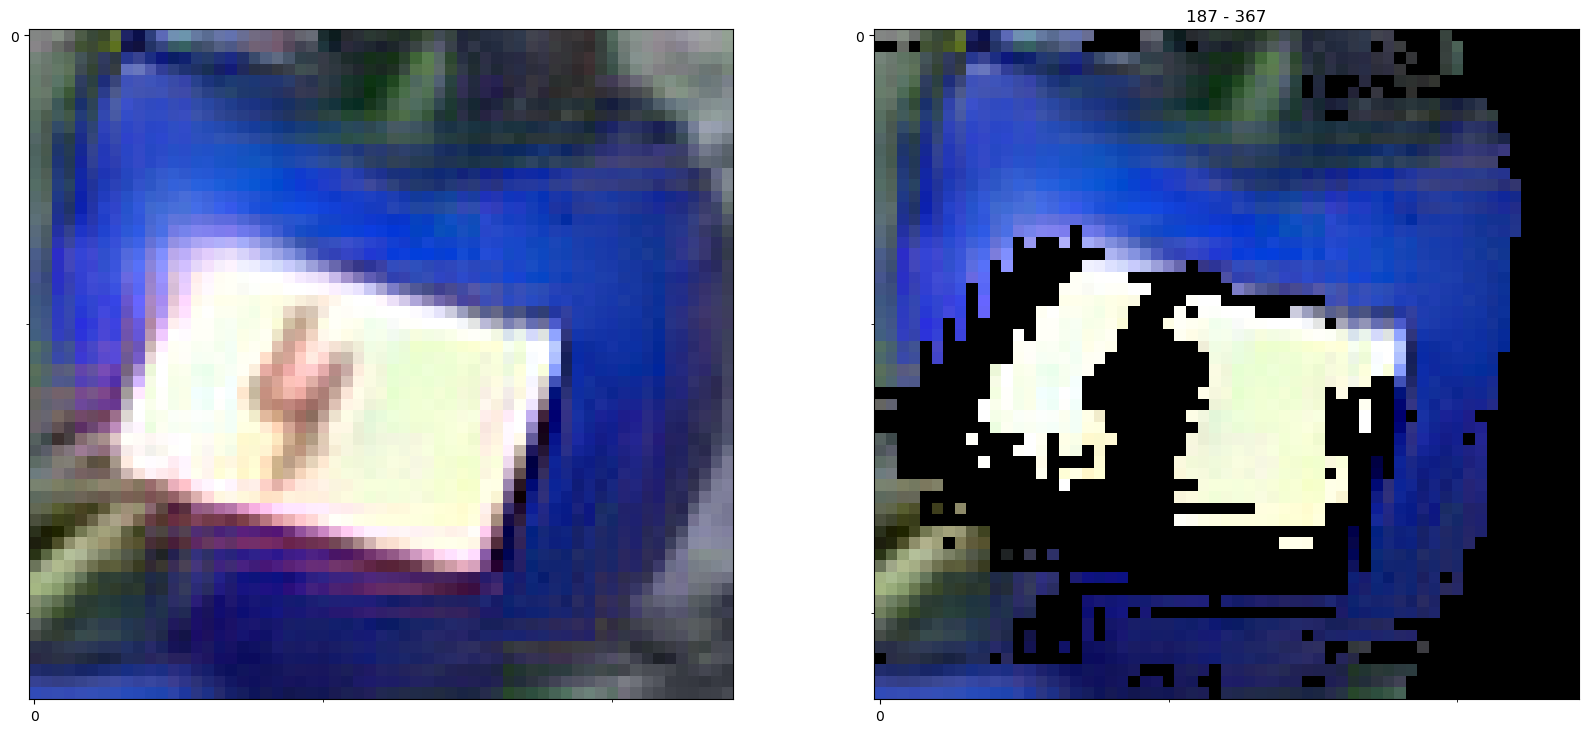

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.80it/s]

ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 47.65032260914788 3.227753057187163 51.51577292682019 4.76744884230693 
 pix med: 
 47.98176537160142 3.3489133717652657 51.87263900699209 4.855718189448111 
 pix mean filtered: 
 47.63472179922371 3.148859510940221 51.278394253787305 4.676514063408441 
 pix med filtered: 
 47.976562137308484 3.266854792950077 51.64675164332899 4.776330435678109 
 margin 0.2: 
 39.26682844758034 9.90955509598281 46.591454495986305 4.320464791034893 
 margin 0.5: 
 39.32735344602002 9.665704557855994 45.10352025843329 11.429987286169116 
 margin 0.8: 
 36.100251134485006 12.780770324785323 47.03948243210713 12.355847026838699 
 margin_f0.2: 
 38.658354638351334 10.332287319101178 45.59807479381561 5.49283184306289 
 margin 0.5_f: 
 38.96218641764588 10.159013633252913 43.77885028305981 12.737386425565447 
 margin 0.8_f: 
 35.844945814460516 12.724348915199112 45.2420718760954 13.815279283518223



/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),
  0%|                                                                                                                                                                                                     | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty 

pix size mean: width - 53.26551074772935, height - 53.40026754901835
pix size median: width - 54.27574410378367, height - 54.41305670175436
pix size mean filtered: width - 53.46559490771207, height - 53.0603114240344
pix size median filtered: width - 54.43746396310997, height - 54.02481345252219
margin 2: width - 59.27596986293793, height - 69.53001767396927
margin 5: width - 52.96330153942108, height - 68.93245130777359
margin 8: width - 53.30066755414009, height - 56.98585882782936
margin 2 filtered: width - 54.49176952242851, height - 68.67794692516327
margin 5 filtered: width - 53.80019173026085, height - 68.93245130777359
margin 8 filtered: width - 53.43002825975418, height - 55.02098798751831


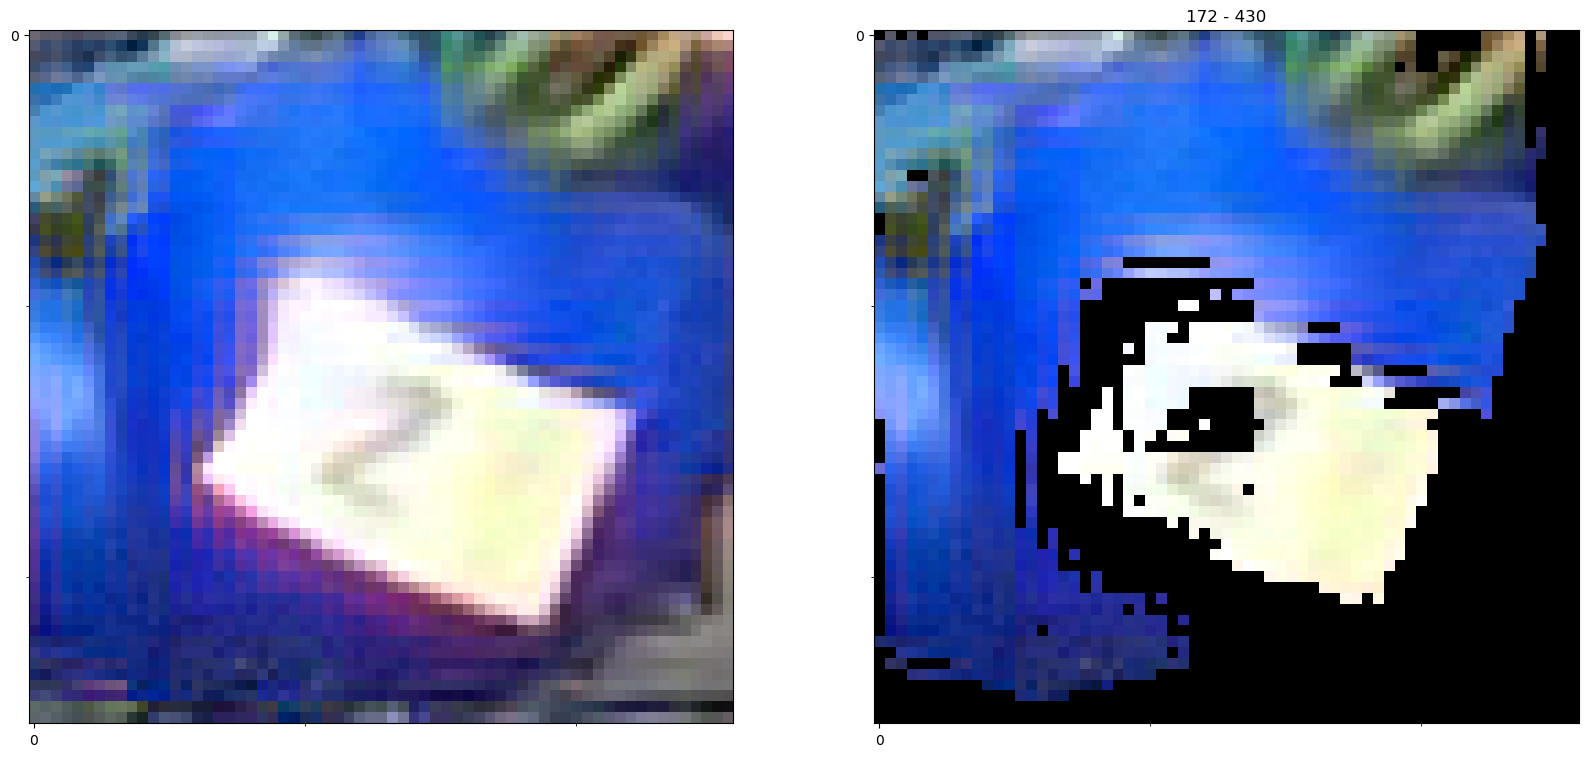

 14%|███████████████████████████                                                                                                                                                                  | 1/7 [00:00<00:01,  3.88it/s]

pix size mean: width - 51.32839856960272, height - 51.730843057559674
pix size median: width - 51.710942155342266, height - 52.11638600742853
pix size mean filtered: width - 51.283258324961146, height - 51.36995748307655
pix size median filtered: width - 51.7000695366758, height - 51.787473353237786
margin 2: width - 44.64610666036606, height - 46.45412042737007
margin 5: width - 44.39174756407738, height - 47.962114214897156
margin 8: width - 45.23373767733574, height - 50.408098846673965
margin 2 filtered: width - 44.61609572172165, height - 46.45412042737007
margin 5 filtered: width - 44.39174756407738, height - 47.962114214897156
margin 8 filtered: width - 45.16659677028656, height - 50.408098846673965


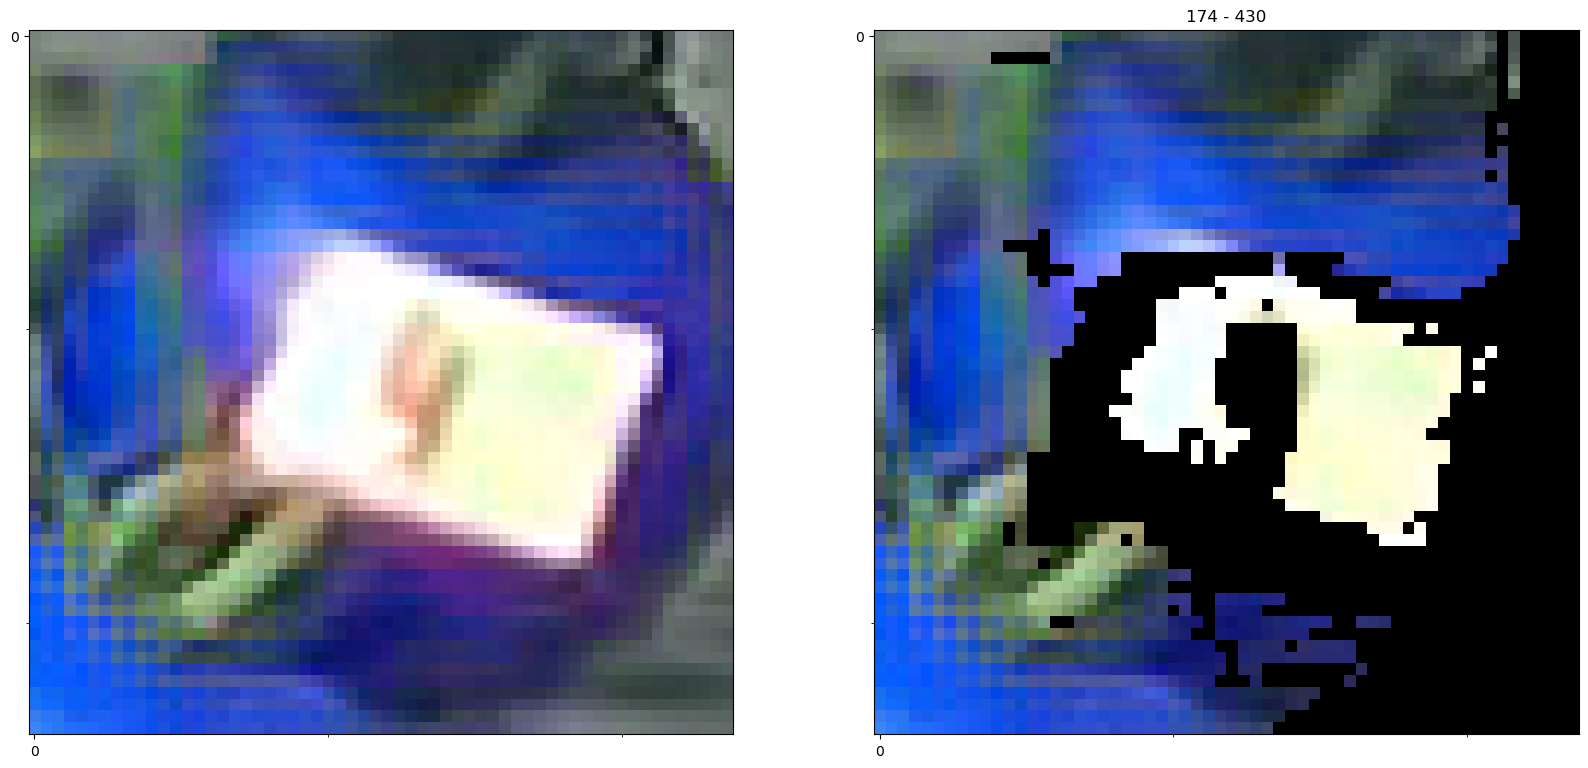

 29%|██████████████████████████████████████████████████████                                                                                                                                       | 2/7 [00:00<00:01,  4.30it/s]

pix size mean: width - 51.560625957737784, height - 54.98000047341619
pix size median: width - 52.48188880269867, height - 55.9623592154068
pix size mean filtered: width - 51.87206067960909, height - 54.49039332466202
pix size median filtered: width - 52.811974371048734, height - 55.477750797389426
margin 2: width - 59.83767658472061, height - 63.11120092868805
margin 5: width - 57.39477276802063, height - 62.27296218276024
margin 8: width - 56.96171522140503, height - 65.28579443693161
margin 2 filtered: width - 59.75635349750519, height - 61.964016407728195
margin 5 filtered: width - 58.34271013736725, height - 61.462800949811935
margin 8 filtered: width - 57.08382651209831, height - 63.47506493330002


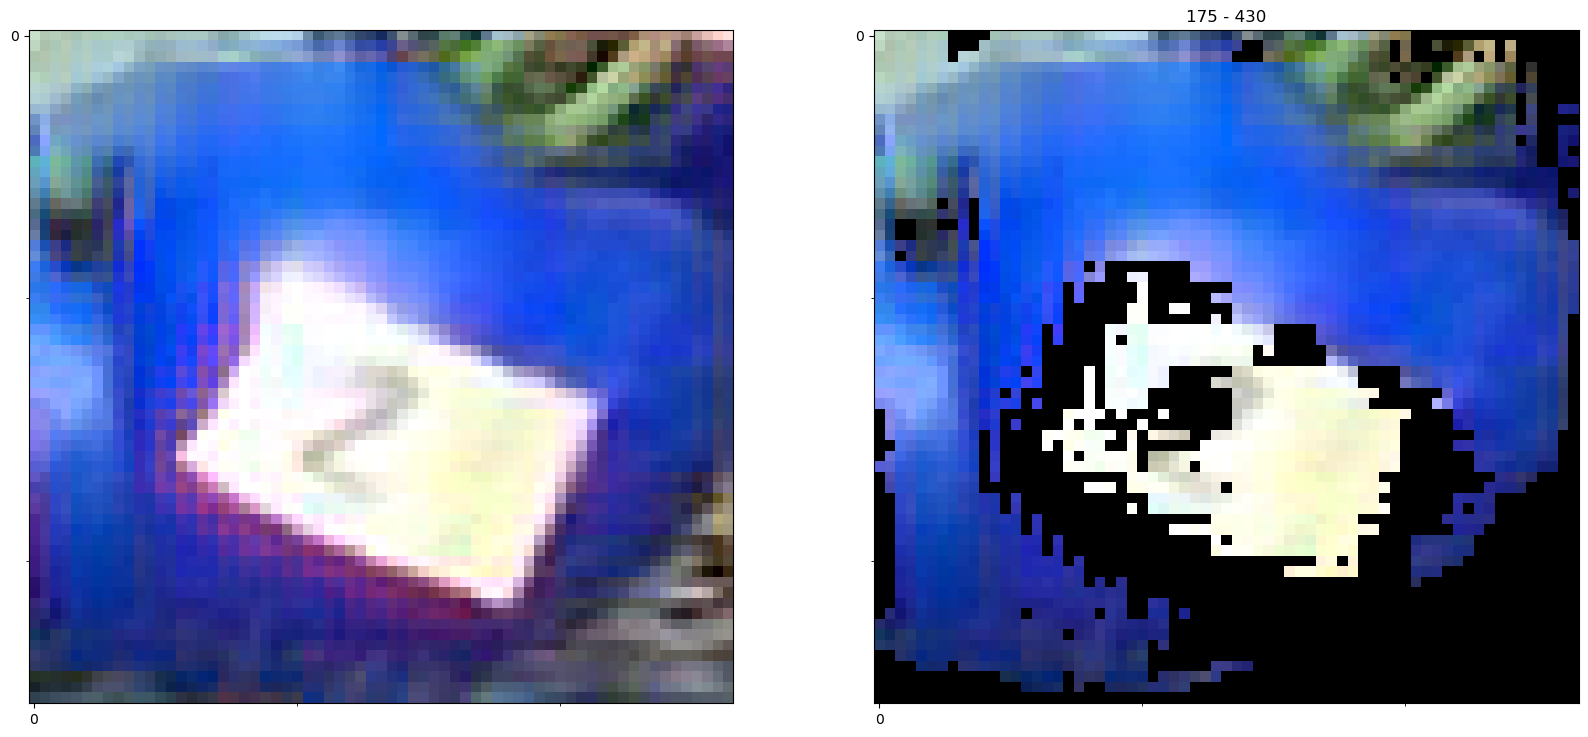

 43%|█████████████████████████████████████████████████████████████████████████████████                                                                                                            | 3/7 [00:00<00:00,  4.45it/s]

pix size mean: width - 49.24102958729753, height - 54.830371902249
pix size median: width - 50.23580992425134, height - 55.9380696147739
pix size mean filtered: width - 49.453826936835796, height - 54.529515046763855
pix size median filtered: width - 50.426938939410704, height - 55.60250229311726
margin 2: width - 62.09352985024452, height - 76.10409706830978
margin 5: width - 57.66899511218071, height - 68.01076233386993
margin 8: width - 56.434132158756256, height - 63.83718550205231
margin 2 filtered: width - 62.32159212231636, height - 74.24813508987427
margin 5 filtered: width - 58.32228064537048, height - 67.48185306787491
margin 8 filtered: width - 56.666307151317596, height - 63.53963166475296


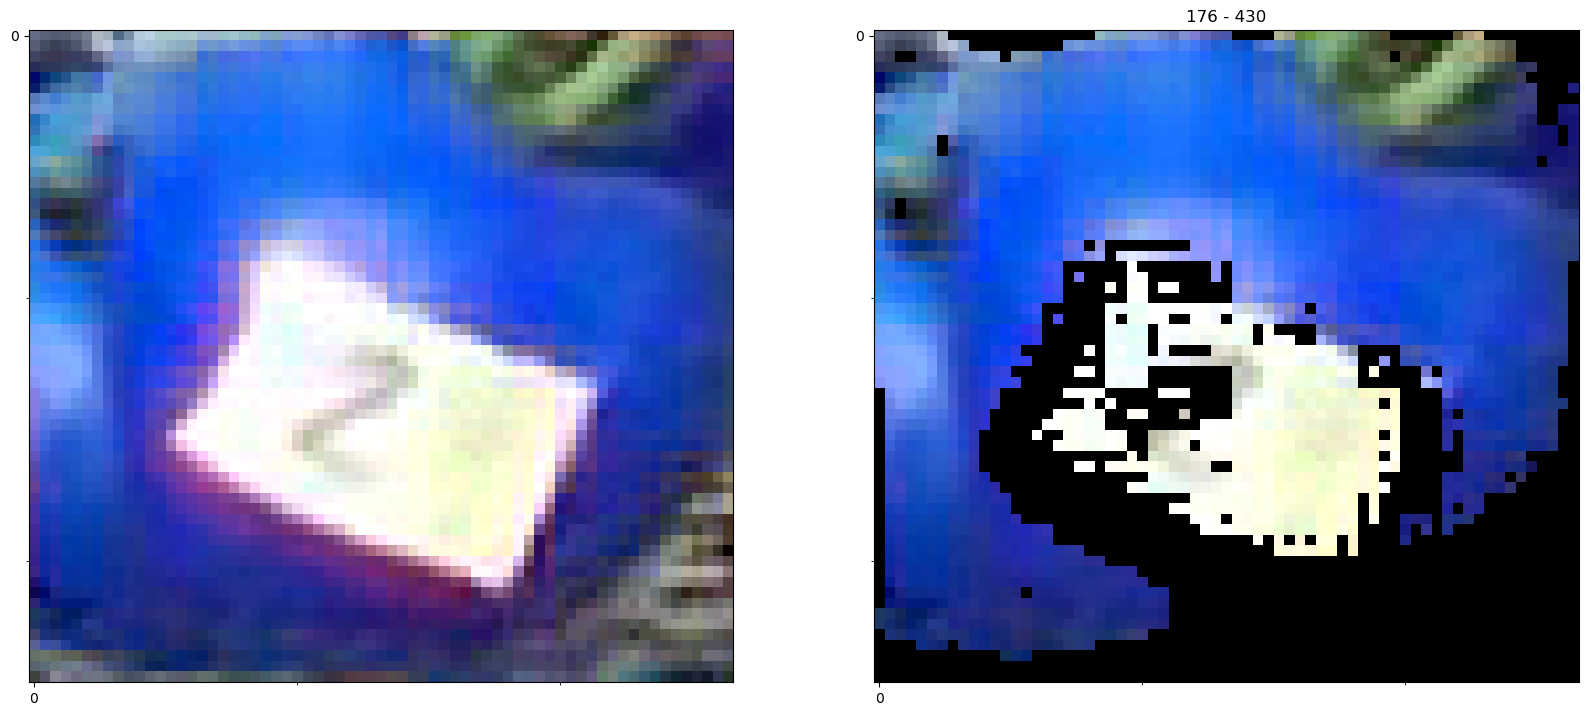

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 4/7 [00:00<00:00,  4.47it/s]

pix size mean: width - 48.377881496769476, height - 56.28527936803898
pix size median: width - 49.500409627882, height - 57.59128549115475
pix size mean filtered: width - 48.624681956228684, height - 56.0611425431588
pix size median filtered: width - 49.678039403149285, height - 57.27559618285299
margin 2: width - 66.35095924139023, height - 70.7448348402977
margin 5: width - 66.33415073156357, height - 53.587283939123154
margin 8: width - 65.9308135509491, height - 62.95563280582428
margin 2 filtered: width - 66.18021428585052, height - 70.34218311309814
margin 5 filtered: width - 66.3573145866394, height - 64.58337604999542
margin 8 filtered: width - 66.03185832500458, height - 64.90534543991089


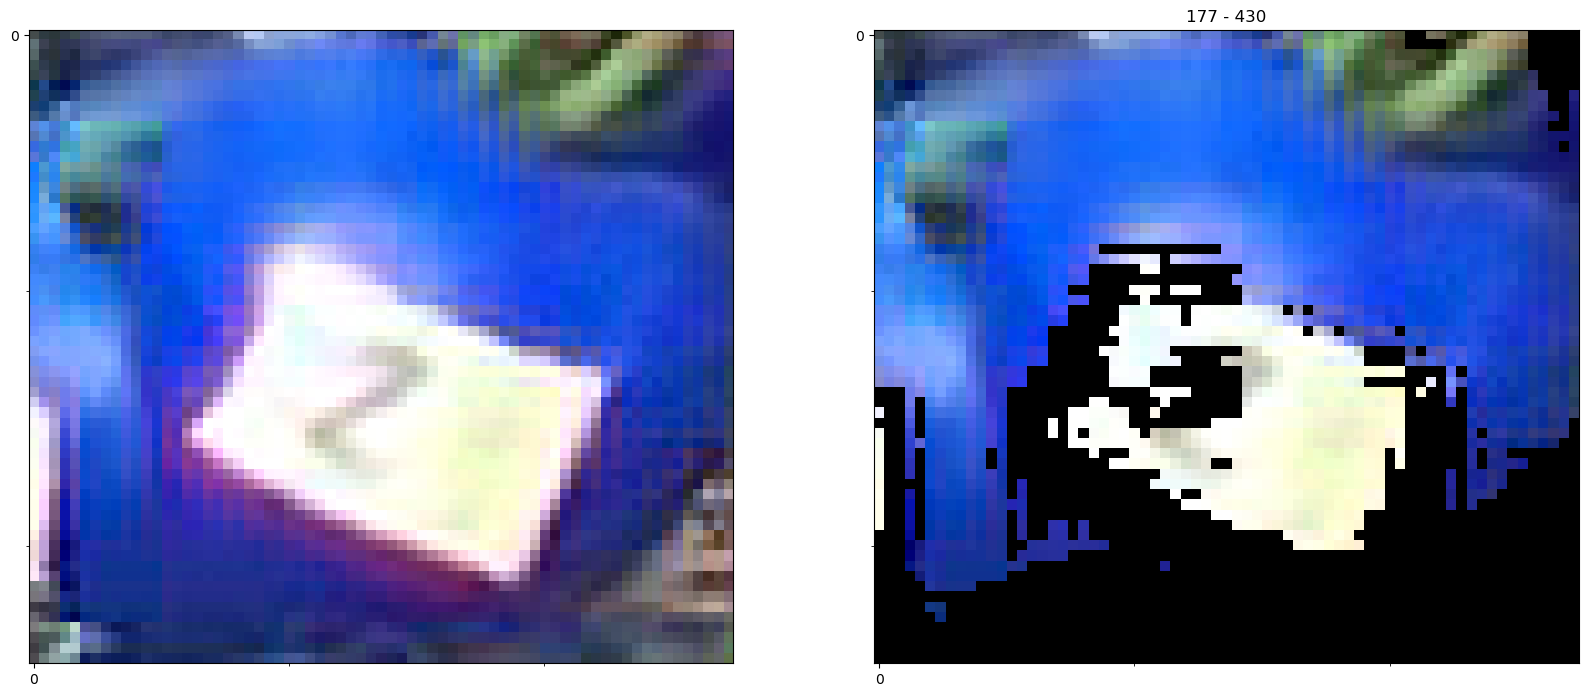

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 5/7 [00:01<00:00,  4.50it/s]

pix size mean: width - 47.21202052110126, height - 53.65885273367999
pix size median: width - 47.90450605799478, height - 54.44589762255029
pix size mean filtered: width - 47.402874278738786, height - 53.563967462731696
pix size median filtered: width - 48.142451302184504, height - 54.39966952136821
margin 2: width - 50.94214156270027, height - 66.64329022169113
margin 5: width - 48.012398183345795, height - 66.10742956399918
margin 8: width - 50.63015967607498, height - 65.62459468841553
margin 2 filtered: width - 52.10947245359421, height - 67.153699696064
margin 5 filtered: width - 49.66042935848236, height - 66.28250330686569
margin 8 filtered: width - 50.63015967607498, height - 65.77661633491516


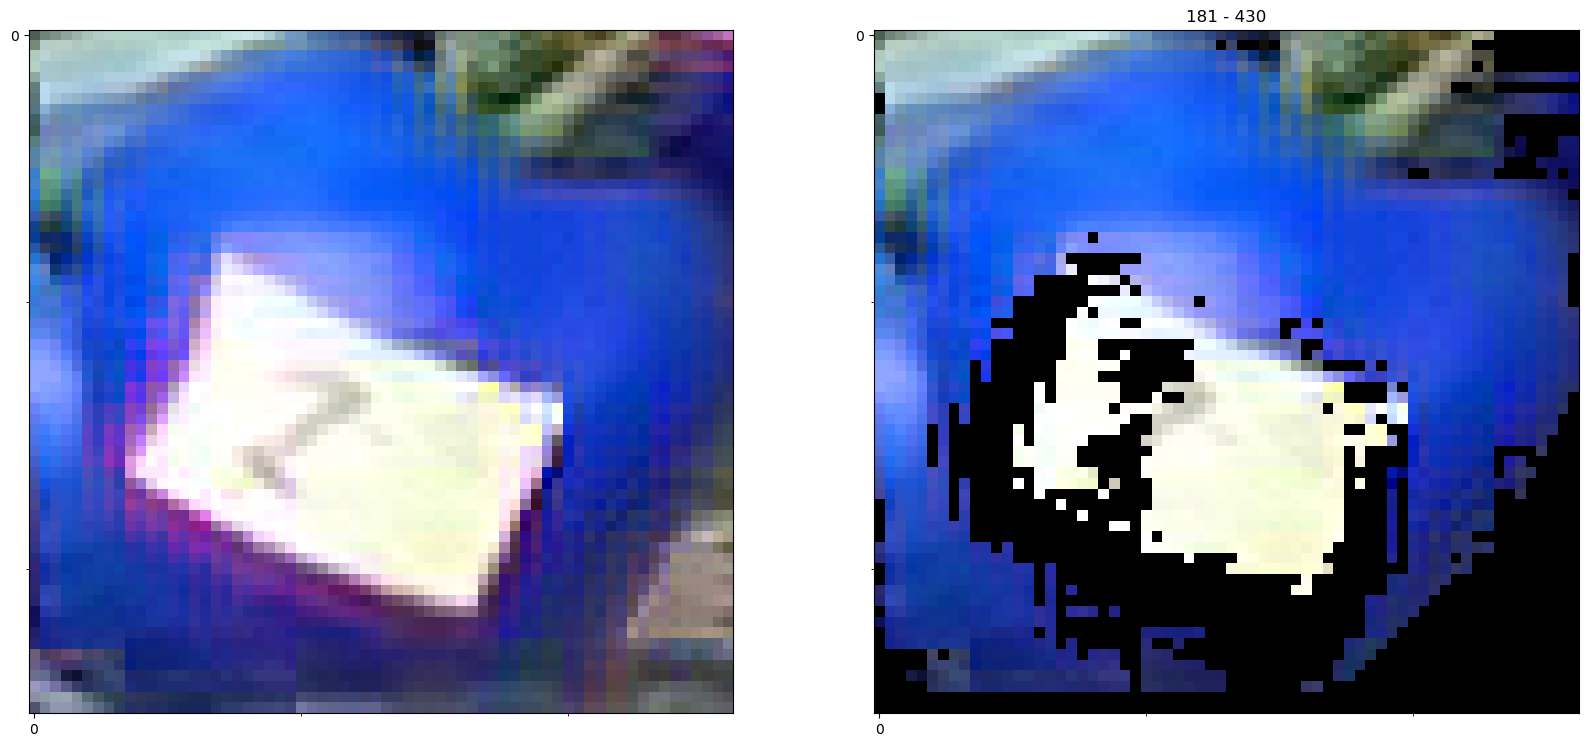

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 6/7 [00:01<00:00,  5.07it/s]

pix size mean: width - 36.663547749843154, height - 21.178275990517715
pix size median: width - 36.56691360820336, height - 21.122456391832994
pix size mean filtered: width - 37.078598975341436, height - 21.168636630880158
pix size median filtered: width - 35.89443016330002, height - 20.49257982225057
margin 2: width - 12.345622293651104, height - 54.92475628852844
margin 5: width - 11.56181562691927, height - 53.82069945335388
margin 8: width - 11.40934880822897, height - 50.24506151676178
margin 2 filtered: width - 12.466024607419968, height - 55.288687348365784
margin 5 filtered: width - 12.093550525605679, height - 55.25272339582443
margin 8 filtered: width - 16.08026586472988, height - 50.24506151676178


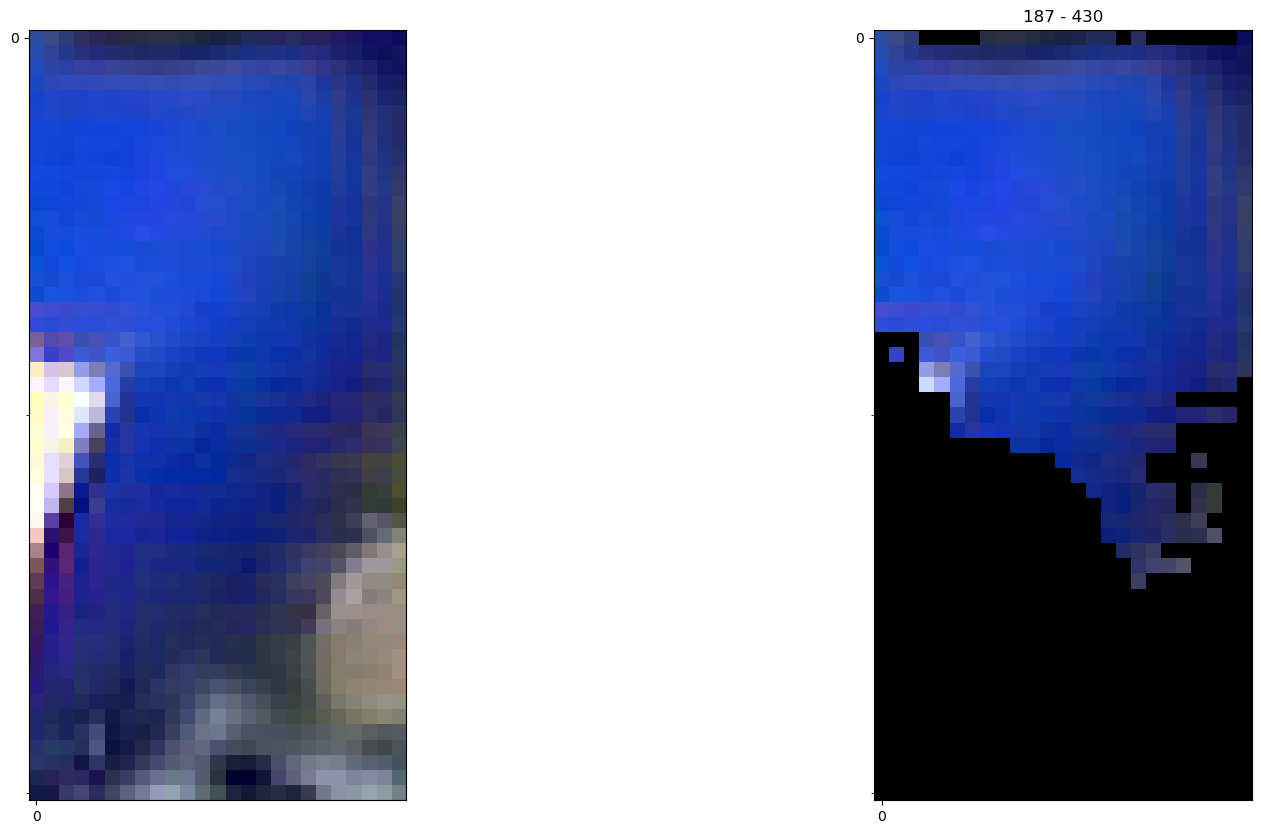

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.90it/s]
/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 48.23557351858303 5.097792850780761 49.4376987249257 11.61317583237888 
 pix med: 
 48.95374489716516 5.409655868091196 50.22707300641452 11.986359915796509 
 pix mean filtered: 
 48.45441372277529 5.01906826565586 49.17770341647249 11.513197727041659 
 pix med filtered: 
 49.013052525554144 5.6867463527341755 49.86576934610549 12.092743291738257 
 margin 0.2: 
 50.78457229371582 17.069295403971577 63.930331064122065 9.41536713036631 
 margin 0.5: 
 48.33245450364692 16.39910234845179 60.09910042796816 7.658577664792319 
 margin 0.8: 
 48.55722494955574 16.26710212310982 59.3346038034984 6.281317206752969 
 margin_f0.2: 
 50.277360315833775 16.778730160716716 63.44696985823767 8.966809908799778 
 margin 0.5_f: 
 48.9954606496862 16.39802856384871 61.70826032757759 7.024488166758805 
 margin 0.8_f: 
 49.298434651323724 14.804766213918443 59.05297238911901 6.411069699861952


  0%|                                                                                                                                                                                                     | 0/4 [00:00<?, ?it/s]

pix size mean: width - 46.14893199188601, height - 44.5794924002176
pix size median: width - 45.98741083147252, height - 44.42346427492114
pix size mean filtered: width - 45.53866274588902, height - 44.55155331173922
pix size median filtered: width - 45.299483273454946, height - 44.317558363826926
margin 2: width - 49.53716695308685, height - 43.48599538207054
margin 5: width - 48.616811633110046, height - 43.52939873933792
margin 8: width - 48.016224056482315, height - 44.03591528534889
margin 2 filtered: width - 48.031456768512726, height - 47.57736623287201
margin 5 filtered: width - 47.792624682188034, height - 46.255968511104584
margin 8 filtered: width - 42.71060600876808, height - 45.68113014101982


/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)


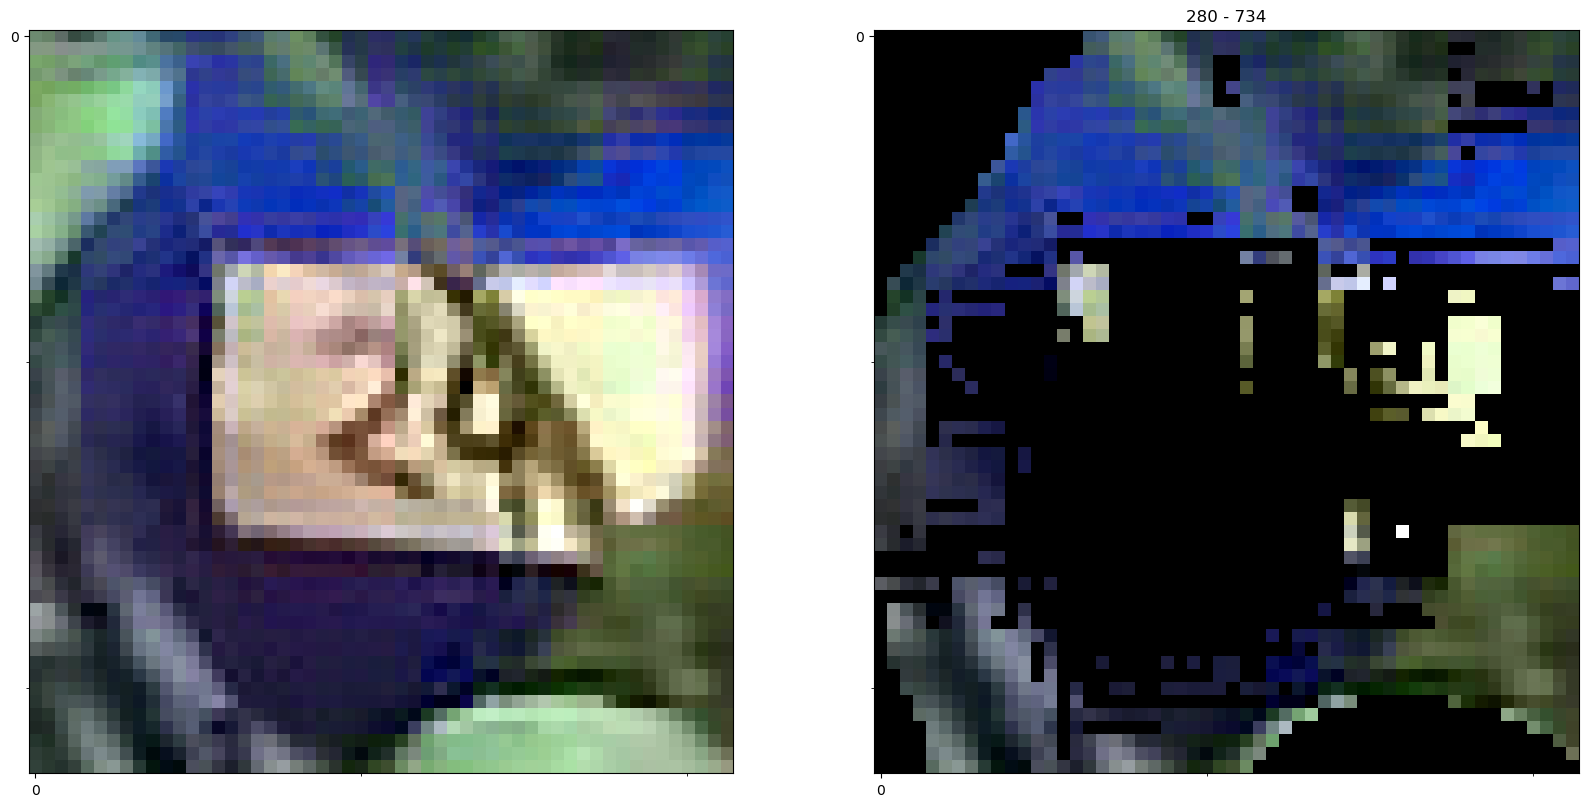

 25%|███████████████████████████████████████████████▎                                                                                                                                             | 1/4 [00:00<00:00,  4.25it/s]

pix size mean: width - 39.51455482034966, height - 52.444648184232754
pix size median: width - 39.4021932428081, height - 52.295519251099556
pix size mean filtered: width - 38.78996583249171, height - 52.39992496243017
pix size median filtered: width - 38.71621602382936, height - 52.3002990834957
margin 2: width - 50.147511065006256, height - 38.89932110905647
margin 5: width - 49.490053206682205, height - 38.76364603638649
margin 8: width - 48.74683544039726, height - 38.64428773522377
margin 2 filtered: width - 49.20954257249832, height - 40.038205683231354
margin 5 filtered: width - 49.087561666965485, height - 38.1731241941452
margin 8 filtered: width - 48.74683544039726, height - 29.095550999045372


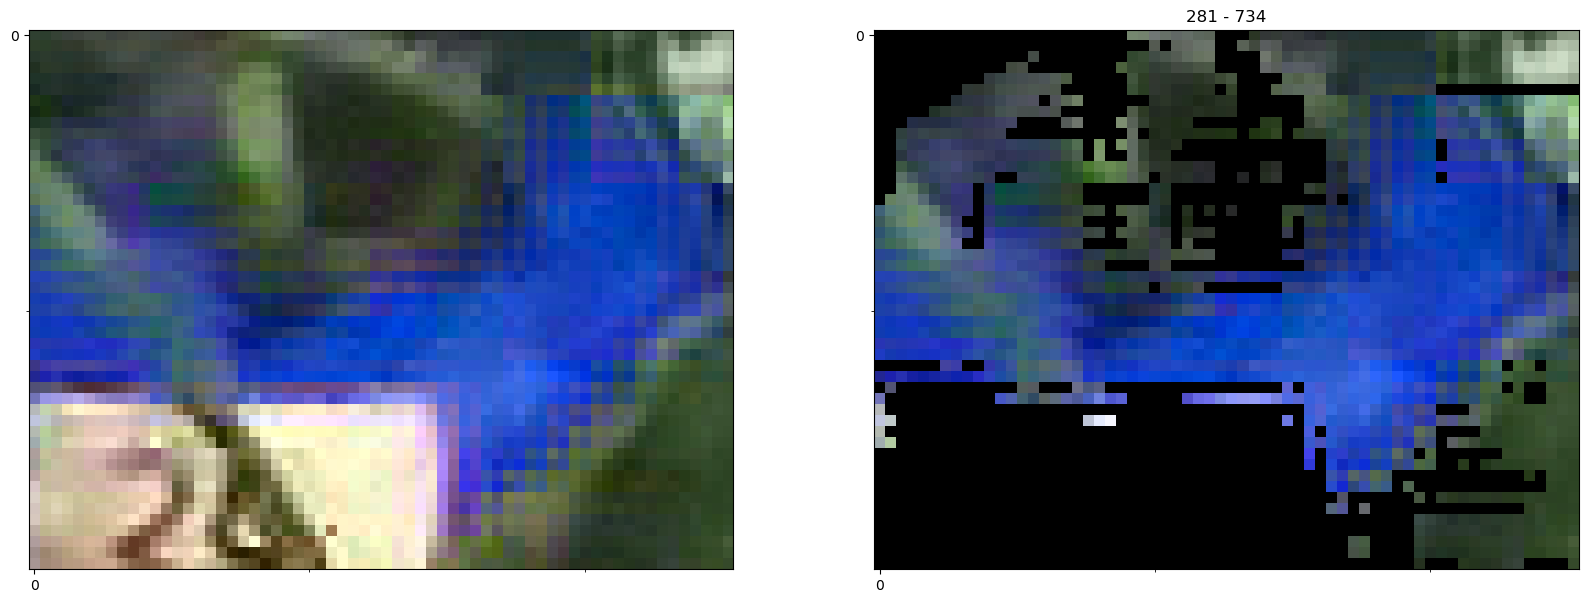

 50%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 2/4 [00:00<00:00,  5.14it/s]

pix size mean: width - 29.856230970986648, height - 35.9386119948795
pix size median: width - 29.83395052430205, height - 35.9117925236191
pix size mean filtered: width - 29.78476211849194, height - 35.92312661507479
pix size median filtered: width - 29.886965476984646, height - 36.04639314220075
margin 2: width - 22.864315658807755, height - 30.877044424414635
margin 5: width - 22.823156788945198, height - 31.289536505937576
margin 8: width - 22.76807092130184, height - 32.367151230573654
margin 2 filtered: width - 23.034339770674706, height - 29.71569262444973
margin 5 filtered: width - 18.423475325107574, height - 29.942624270915985
margin 8 filtered: width - 19.099226221442223, height - 31.073322519659996


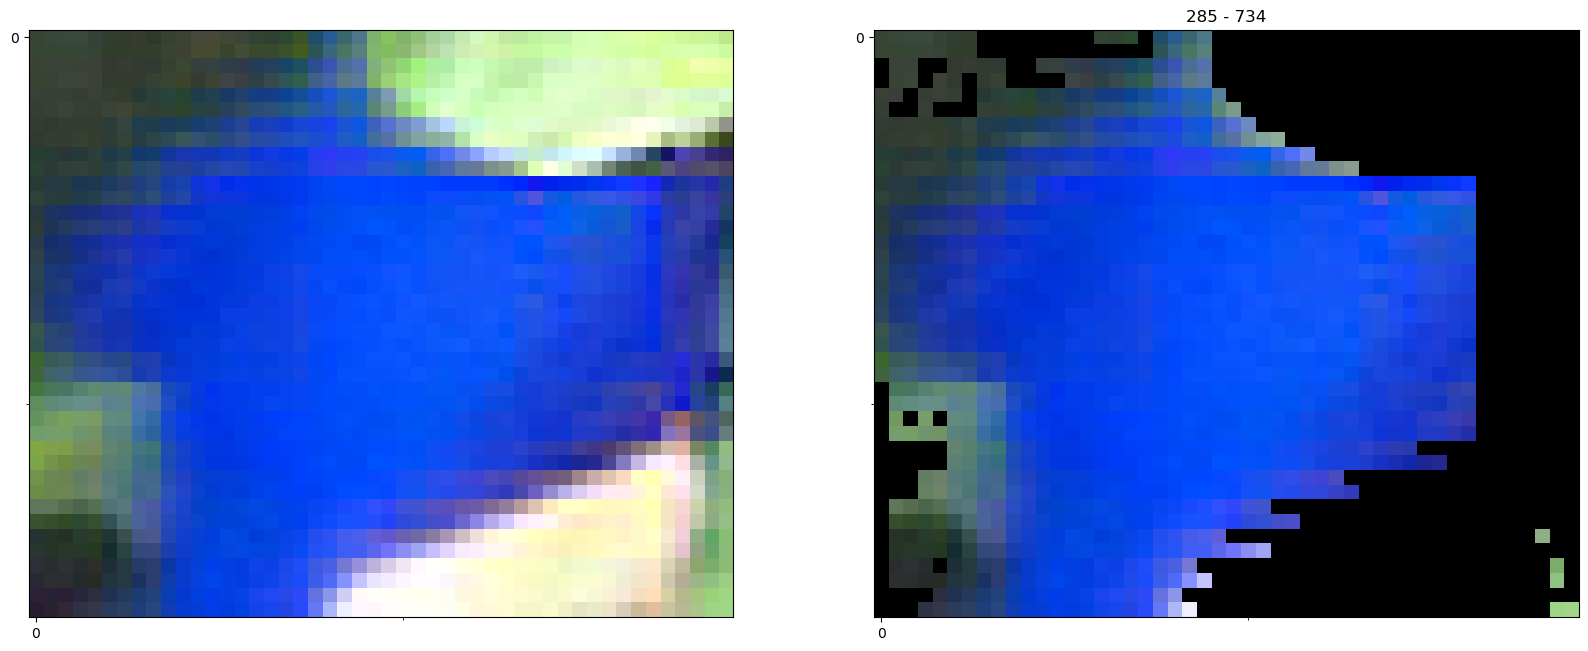

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3/4 [00:00<00:00,  5.18it/s]

pix size mean: width - 28.21035627395804, height - 35.648242019917895
pix size median: width - 28.166744677384237, height - 35.59313187758435
pix size mean filtered: width - 28.18433041685272, height - 35.62673995712715
pix size median filtered: width - 28.205936839895024, height - 35.65405181459357
margin 2: width - 26.319826021790504, height - 28.923682868480682
margin 5: width - 26.26490220427513, height - 29.533876106142998
margin 8: width - 26.11466683447361, height - 30.284687876701355
margin 2 filtered: width - 25.040317326784134, height - 27.914496138691902
margin 5 filtered: width - 24.91525001823902, height - 28.646454215049744
margin 8 filtered: width - 25.03899112343788, height - 29.934661462903023


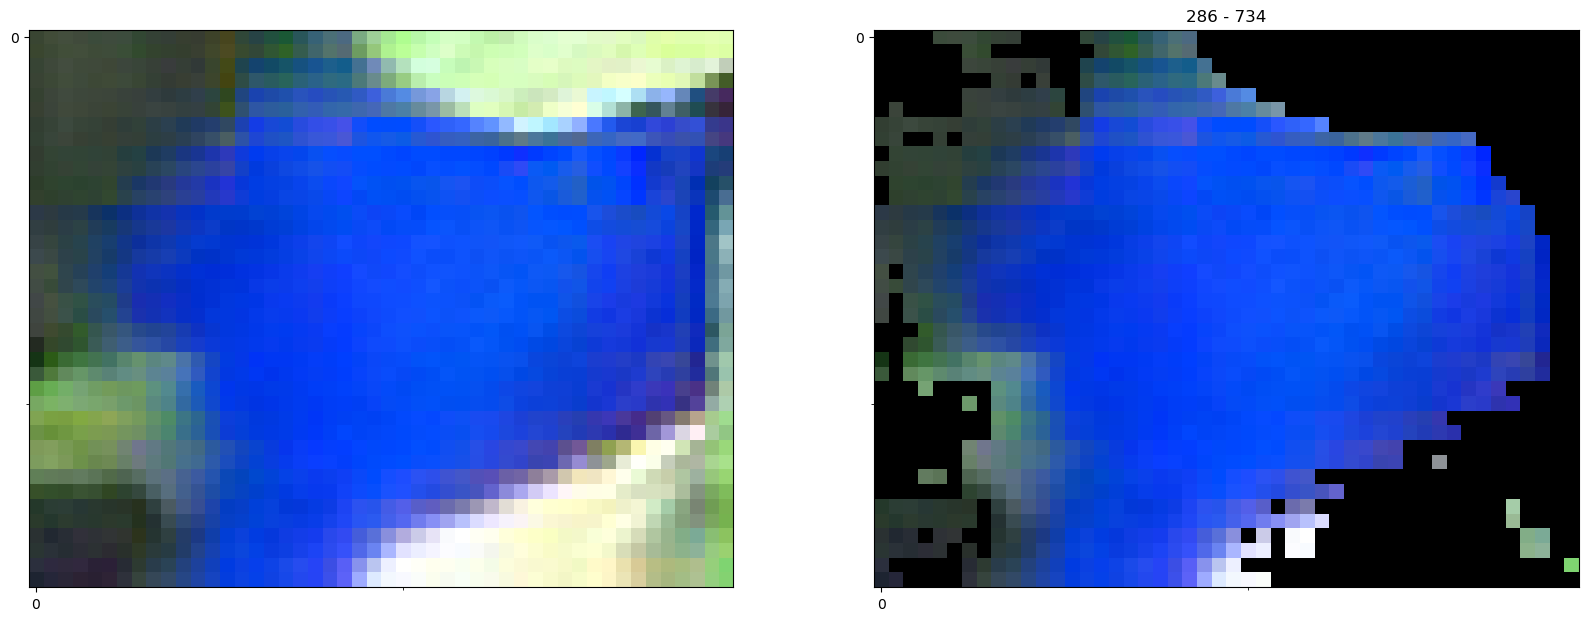

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]
/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 35.93251851429509 7.310252191580792 42.15274864981193 6.941476466164365 
 pix med: 
 35.84757481899173 7.256211396466569 42.05597698180603 6.891527252088218 
 pix mean filtered: 
 35.57443027843135 7.031348215870206 42.12533621159283 6.930960621976793 
 pix med filtered: 
 35.52715040354099 6.911593219026512 42.079575601029234 6.84029242545937 
 margin 0.2: 
 37.21720492467284 12.685942796019118 35.54651094600558 5.914865138798303 
 margin 0.5: 
 36.798730958253145 12.31883631710863 35.779114346951246 5.65980669818083 
 margin 0.8: 
 36.41144931316376 12.03118916720303 36.33301053196192 5.408026231690624 
 margin_f0.2: 
 36.32891410961747 12.31907279852171 36.31144016981125 7.9815791982893725 
 margin 0.5_f: 
 35.05472792312503 13.588432690063533 35.75454279780388 7.078714541605771 
 margin 0.8_f: 
 33.89891469851136 12.202824251776873 33.94616628065705 6.8114471221648


  0%|                                                                                                                                                                                                     | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)


pix size mean: width - 57.11159748064101, height - 54.31729927507667
pix size median: width - 57.24294832746283, height - 54.442223521141976
pix size mean filtered: width - 56.85138553129163, height - 53.93860452300382
pix size median filtered: width - 57.081144234639616, height - 54.15659153809226
margin 2: width - 44.51429471373558, height - 60.911811888217926
margin 5: width - 47.01276123523712, height - 61.7518313229084
margin 8: width - 46.149272471666336, height - 62.383927404880524
margin 2 filtered: width - 45.80674692988396, height - 60.74618175625801
margin 5 filtered: width - 46.887580305337906, height - 61.722833663225174
margin 8 filtered: width - 46.151090413331985, height - 62.345847487449646


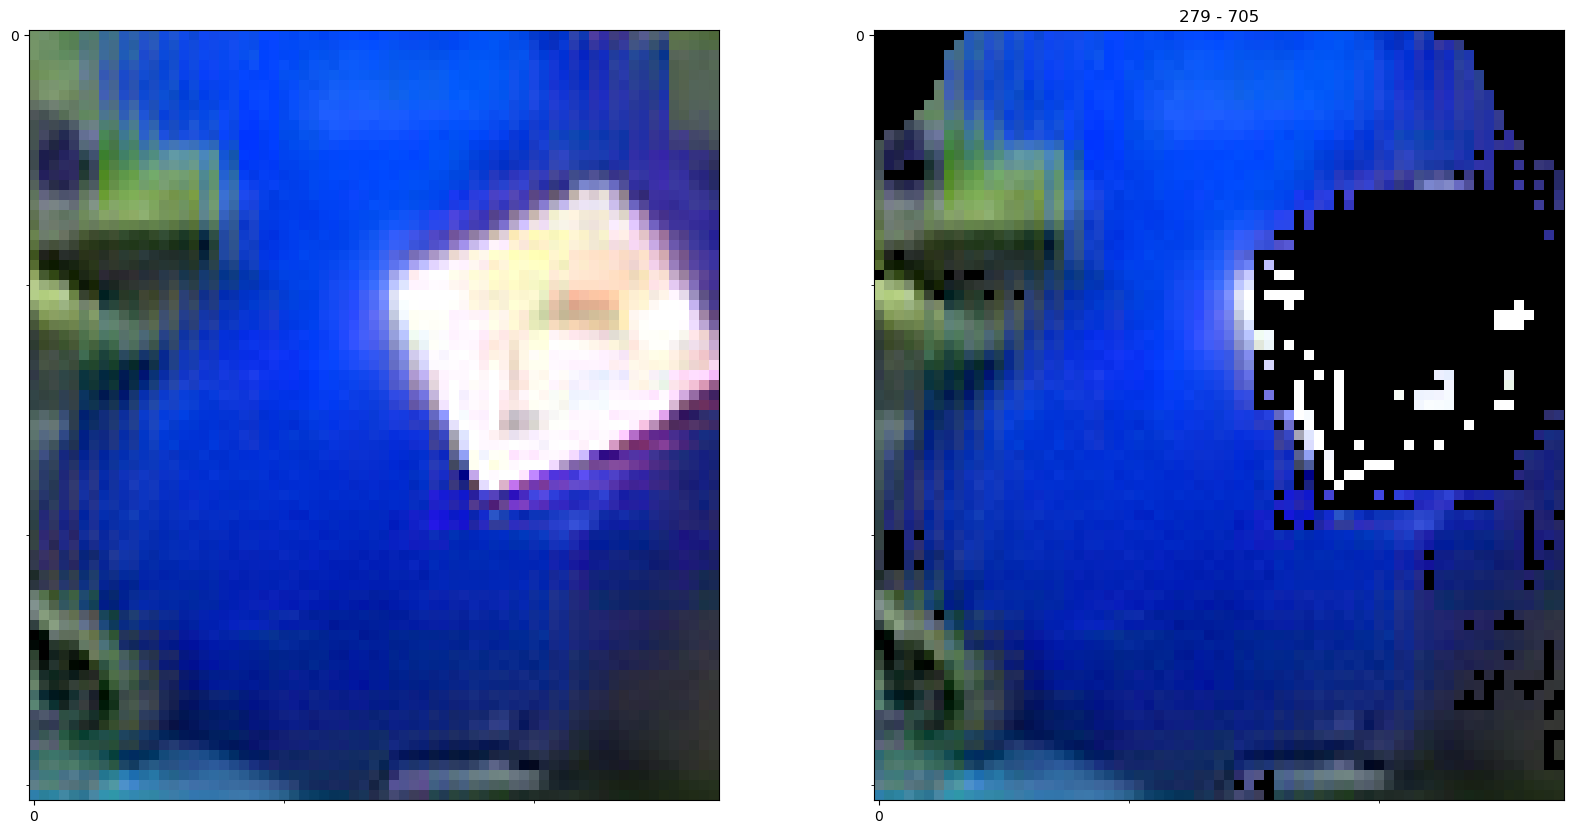

 11%|█████████████████████                                                                                                                                                                        | 1/9 [00:00<00:01,  4.49it/s]

pix size mean: width - 67.865623556254, height - 62.57340128172382
pix size median: width - 68.21604715371758, height - 62.89649853234436
pix size mean filtered: width - 67.44275142933944, height - 62.30056346109988
pix size median filtered: width - 67.7780805019565, height - 62.61032529207764
margin 2: width - 37.75173798203468, height - 69.625623524189
margin 5: width - 37.219058722257614, height - 69.97769325971603
margin 8: width - 35.94956547021866, height - 70.62043249607086
margin 2 filtered: width - 49.77365955710411, height - 69.991834461689
margin 5 filtered: width - 47.48564213514328, height - 70.08378207683563
margin 8 filtered: width - 42.99876466393471, height - 70.62043249607086


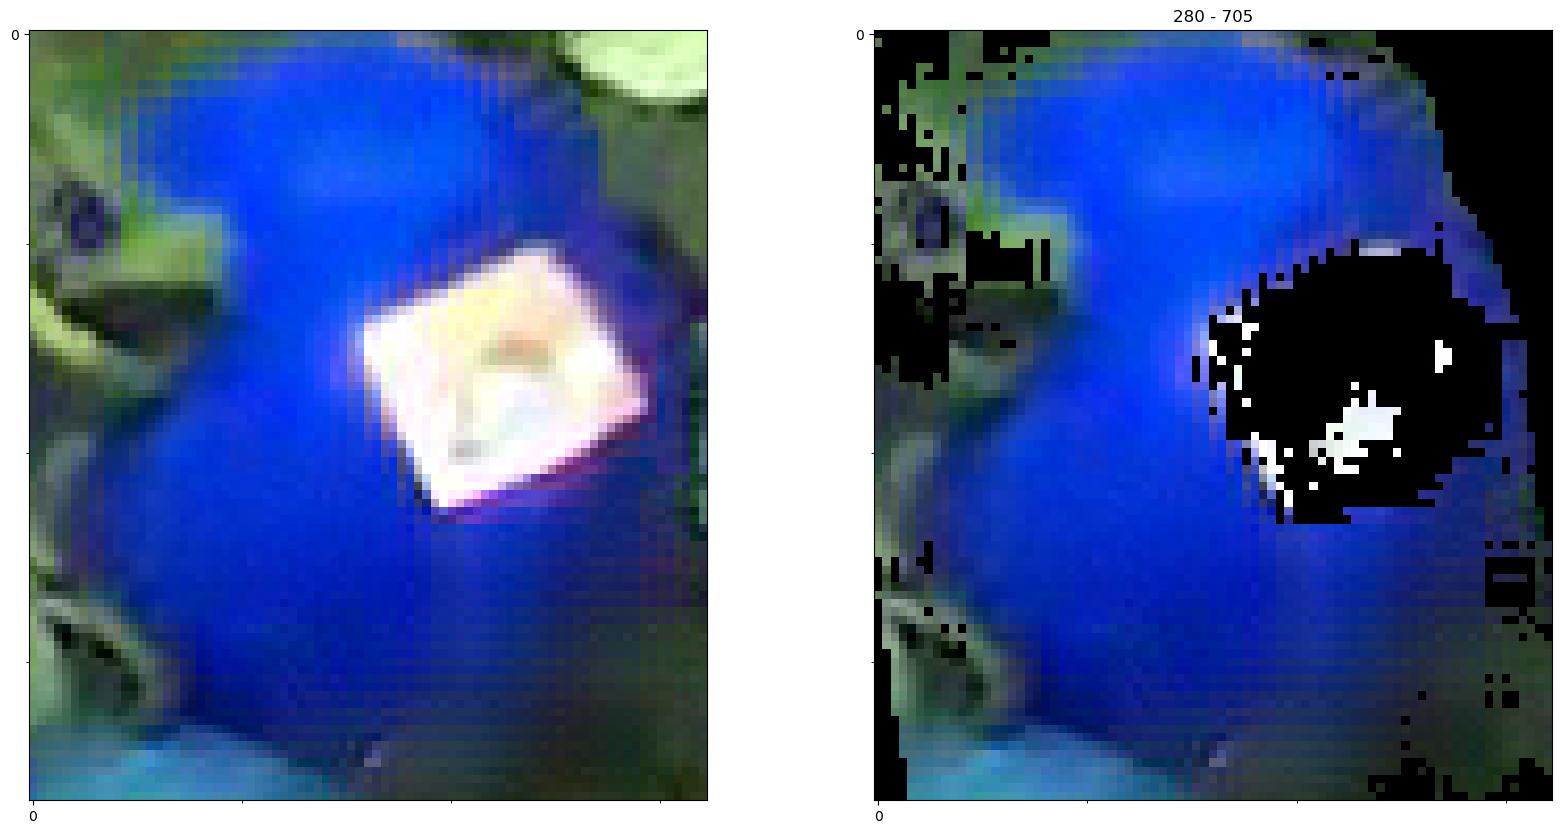

 22%|██████████████████████████████████████████                                                                                                                                                   | 2/9 [00:00<00:01,  5.01it/s]

pix size mean: width - 55.907693265571936, height - 57.15844064357818
pix size median: width - 56.11219203367522, height - 57.36751438666382
pix size mean filtered: width - 55.62532806043846, height - 56.803985256189705
pix size median filtered: width - 55.83974314898202, height - 57.02294363276056
margin 2: width - 38.26640173792839, height - 57.975299656391144
margin 5: width - 39.455845952034, height - 58.48601832985878
margin 8: width - 39.18304294347763, height - 58.82794409990311
margin 2 filtered: width - 44.83957216143608, height - 57.67829716205597
margin 5 filtered: width - 45.48598825931549, height - 58.48601832985878
margin 8 filtered: width - 43.55941340327263, height - 58.82794409990311


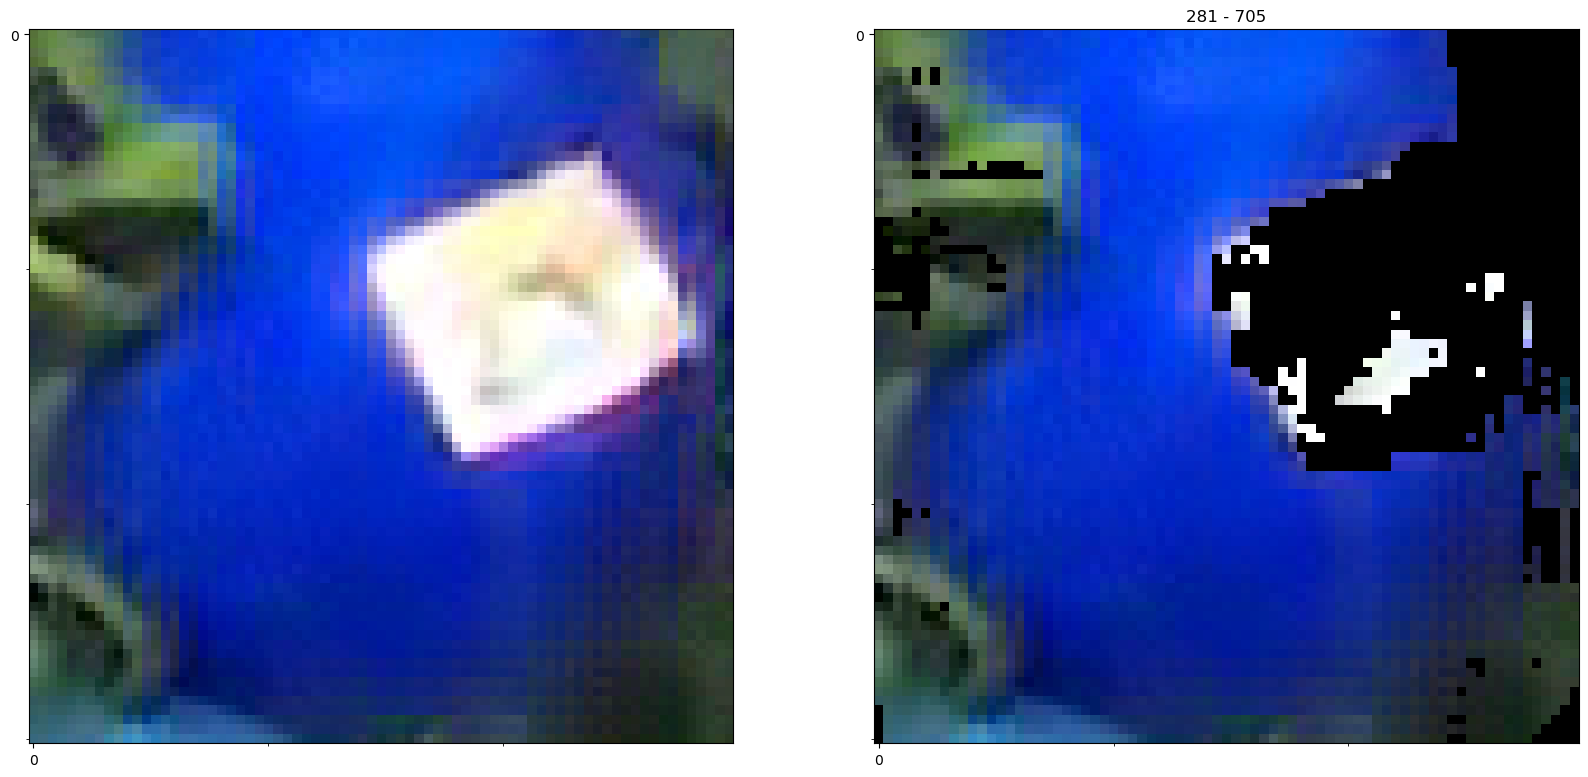

 33%|███████████████████████████████████████████████████████████████                                                                                                                              | 3/9 [00:00<00:01,  5.19it/s]

pix size mean: width - 43.127380131152, height - 47.457709954944775
pix size median: width - 43.116172150623115, height - 47.44537660458816
pix size mean filtered: width - 43.127380131152, height - 47.30080417585958
pix size median filtered: width - 43.18775510572983, height - 47.36702161918543
margin 2: width - 40.917038917541504, height - 43.97716745734215
margin 5: width - 40.70287197828293, height - 44.57202926278114
margin 8: width - 42.20764338970184, height - 44.77246850728989
margin 2 filtered: width - 42.21228137612343, height - 44.55298185348511
margin 5 filtered: width - 42.07196831703186, height - 44.74451020359993
margin 8 filtered: width - 42.211685329675674, height - 44.78137940168381


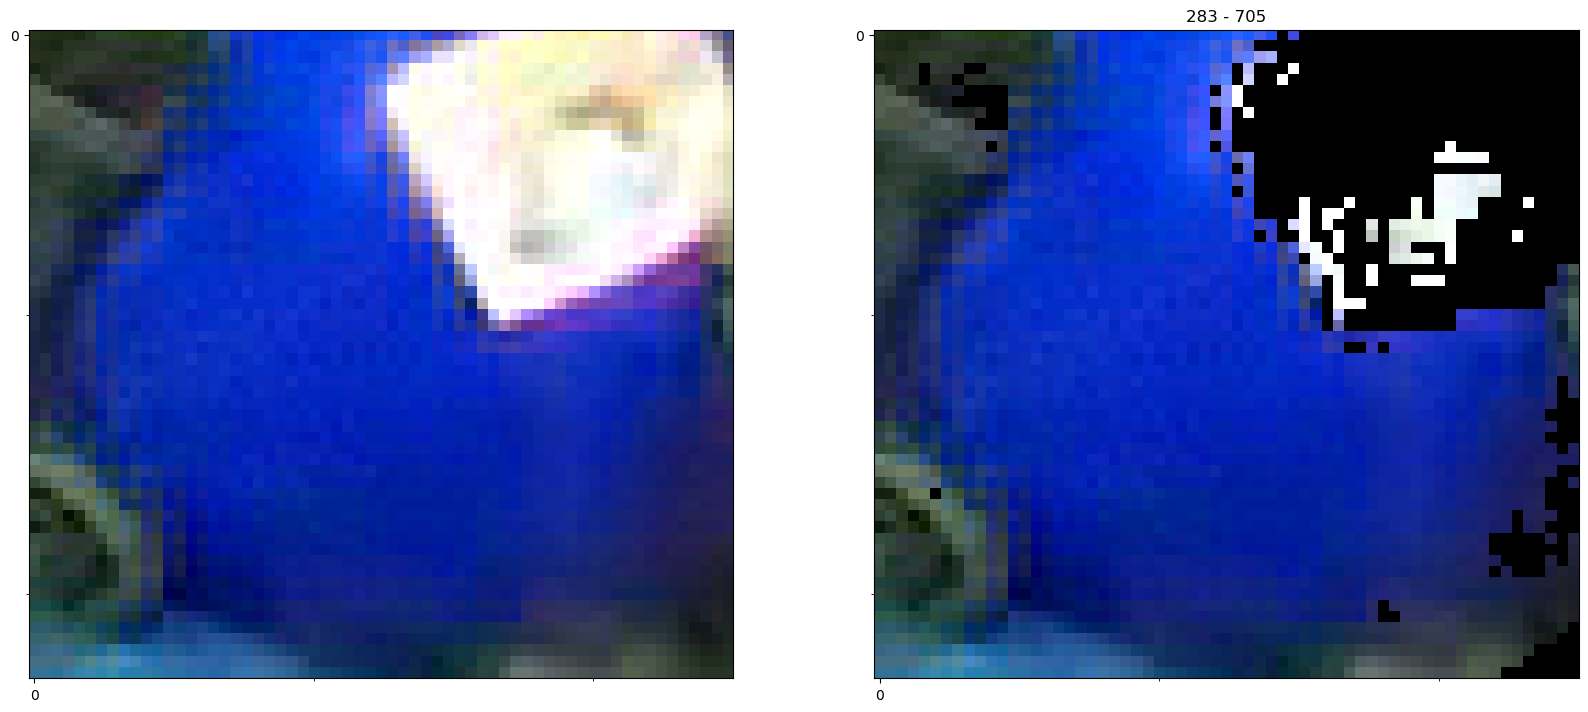

 44%|████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 4/9 [00:00<00:00,  5.36it/s]

pix size mean: width - 43.40380517678554, height - 45.14163468986509
pix size median: width - 43.394537844779876, height - 45.131996306450404
pix size mean filtered: width - 43.366330295709915, height - 44.93735935851944
pix size median filtered: width - 43.453951652773746, height - 45.02815496845481
margin 2: width - 33.358134329319, height - 43.82747784256935
margin 5: width - 33.5022509098053, height - 44.313352555036545
margin 8: width - 33.113472163677216, height - 44.371556490659714
margin 2 filtered: width - 38.2751002907753, height - 44.29958015680313
margin 5 filtered: width - 38.272298872470856, height - 44.4631353020668
margin 8 filtered: width - 38.61109912395477, height - 44.34635862708092


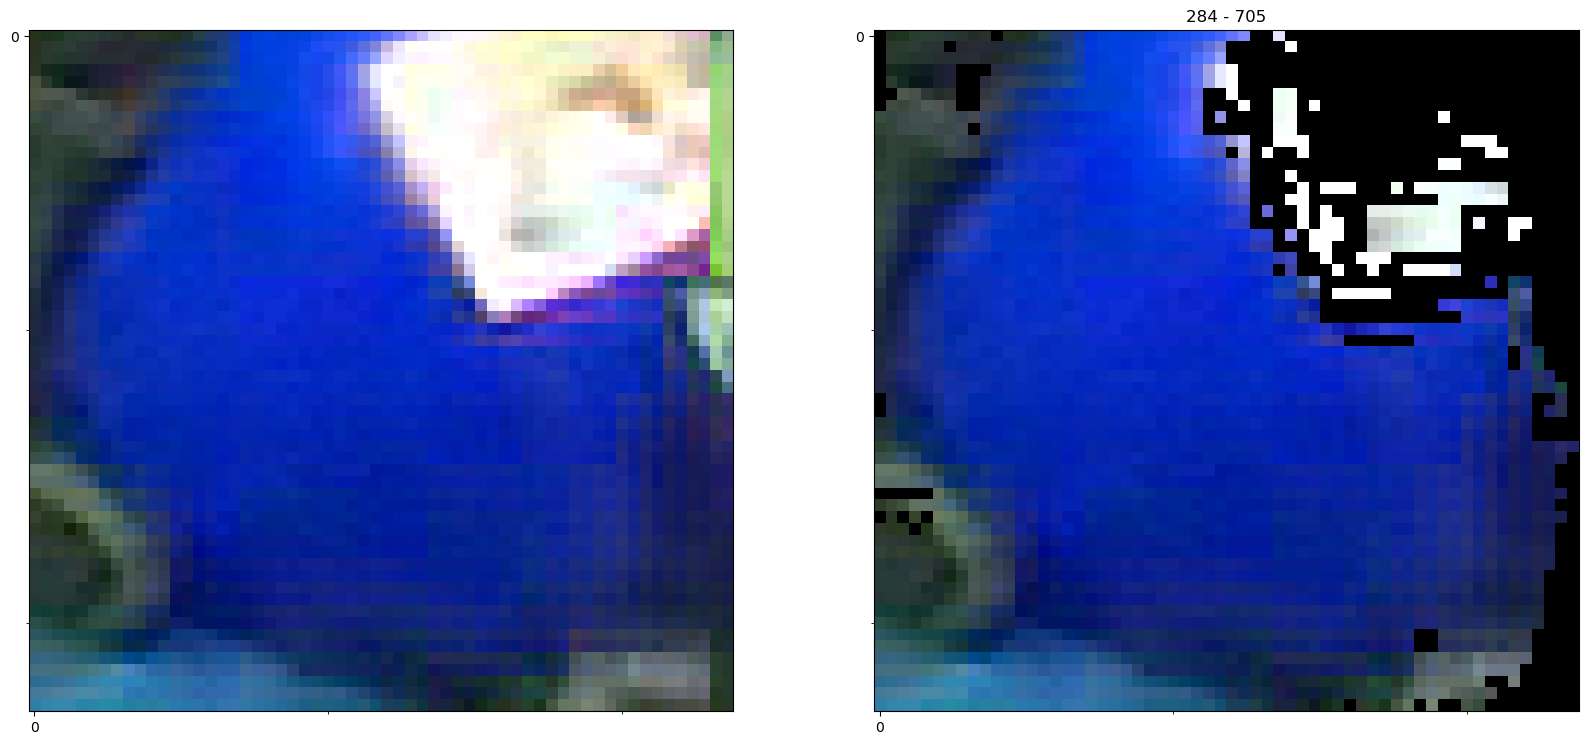

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 5/9 [00:00<00:00,  5.36it/s]

pix size mean: width - 46.54411453134194, height - 44.30831415274798
pix size median: width - 46.54943591554826, height - 44.313379918108765
pix size mean filtered: width - 46.485239607914, height - 44.074241485463496
pix size median filtered: width - 46.57350219879041, height - 44.157926258893326
margin 2: width - 34.8777249455452, height - 47.07811400294304
margin 5: width - 34.26439315080643, height - 46.79855704307556
margin 8: width - 32.91437402367592, height - 46.775590628385544
margin 2 filtered: width - 39.80083763599396, height - 46.801336109638214
margin 5 filtered: width - 38.344502449035645, height - 46.77289351820946
margin 8 filtered: width - 36.13370656967163, height - 46.775590628385544


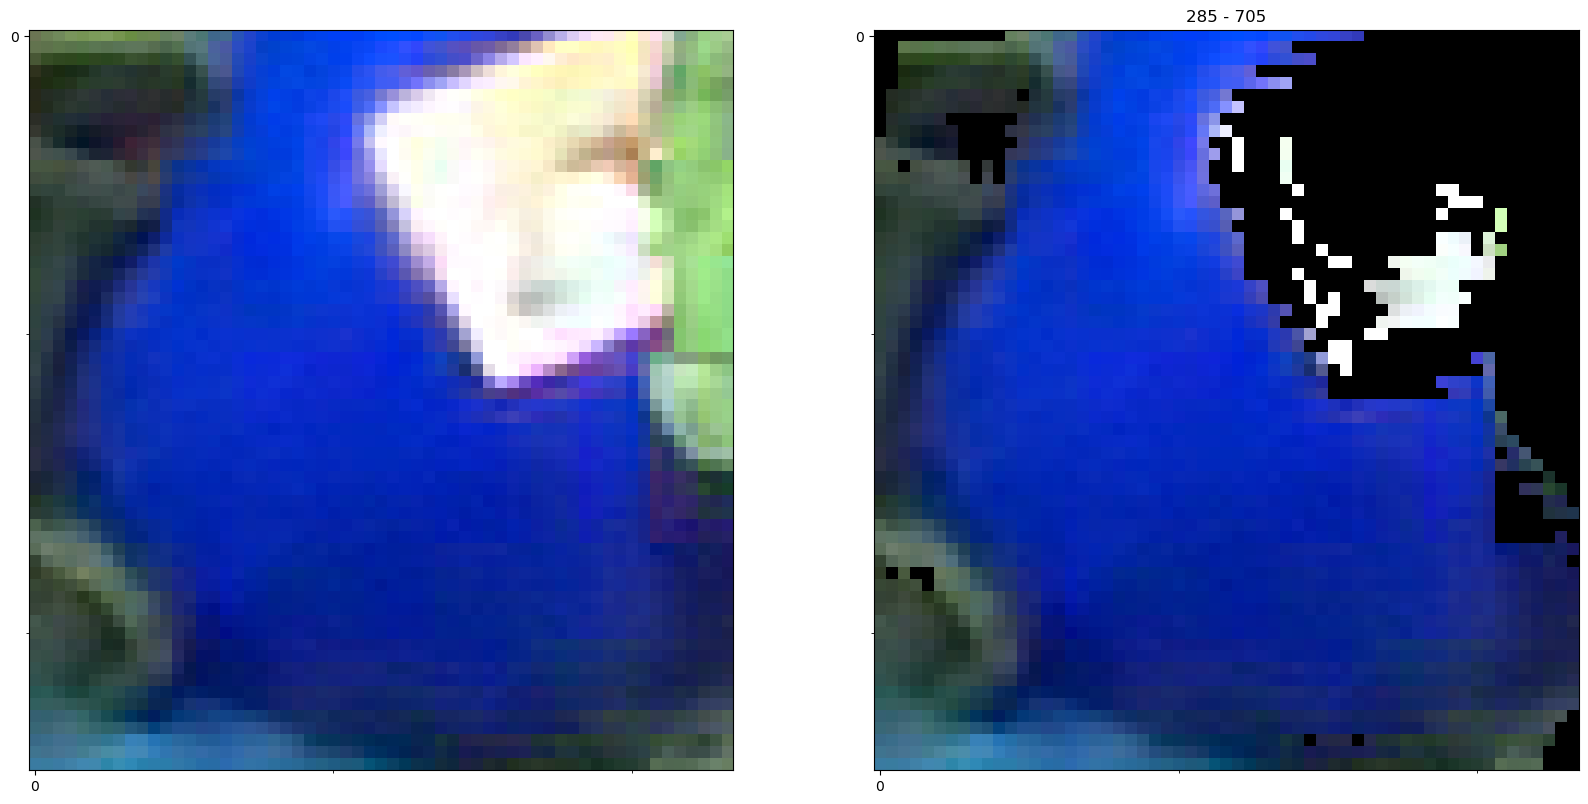

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 6/9 [00:01<00:00,  5.32it/s]

pix size mean: width - 45.214230036298744, height - 45.13529805230222
pix size median: width - 45.16399410447276, height - 45.08514981901191
pix size mean filtered: width - 45.182512927107396, height - 44.87247265187533
pix size median filtered: width - 45.21166149984476, height - 44.90142120847969
margin 2: width - 37.269942462444305, height - 45.77716812491417
margin 5: width - 36.752842366695404, height - 45.282650738954544
margin 8: width - 36.299239844083786, height - 45.434433966875076
margin 2 filtered: width - 40.93417525291443, height - 45.681413263082504
margin 5 filtered: width - 39.23558443784714, height - 45.45487463474274
margin 8 filtered: width - 38.088809698820114, height - 45.43909803032875


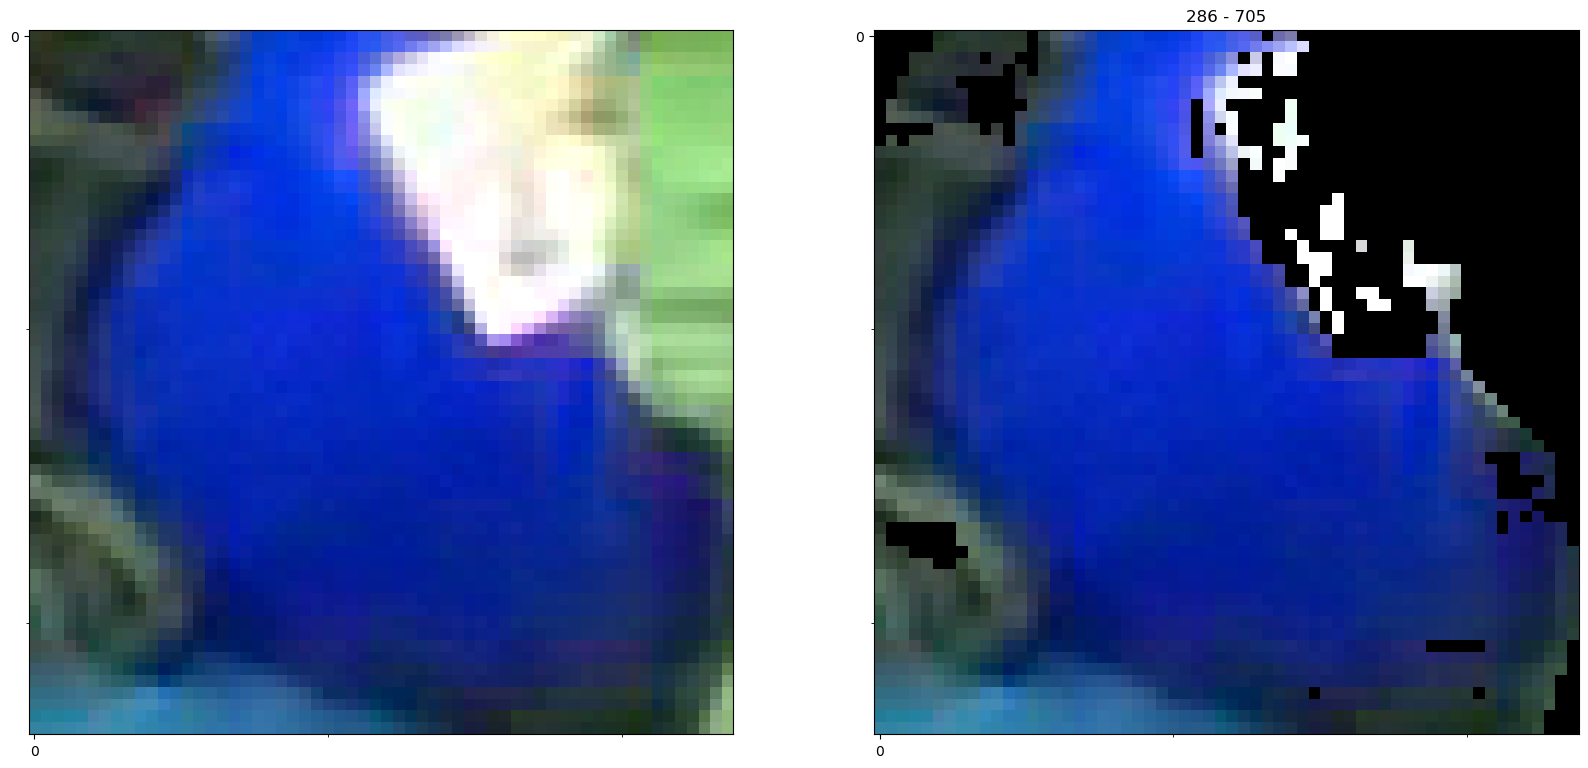

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7/9 [00:01<00:00,  5.18it/s]

pix size mean: width - 45.147000286061854, height - 40.60932191085372
pix size median: width - 45.11243603842626, height - 40.578231680053285
pix size mean filtered: width - 45.16581056870416, height - 40.38617905875272
pix size median filtered: width - 45.28751441024455, height - 40.495003700106416
margin 2: width - 38.160037249326706, height - 46.757686883211136
margin 5: width - 38.18383067846298, height - 46.05523869395256
margin 8: width - 38.172535598278046, height - 45.59287428855896
margin 2 filtered: width - 38.08602690696716, height - 45.71479931473732
margin 5 filtered: width - 38.21977600455284, height - 45.60548439621925
margin 8 filtered: width - 36.81693971157074, height - 45.59287428855896


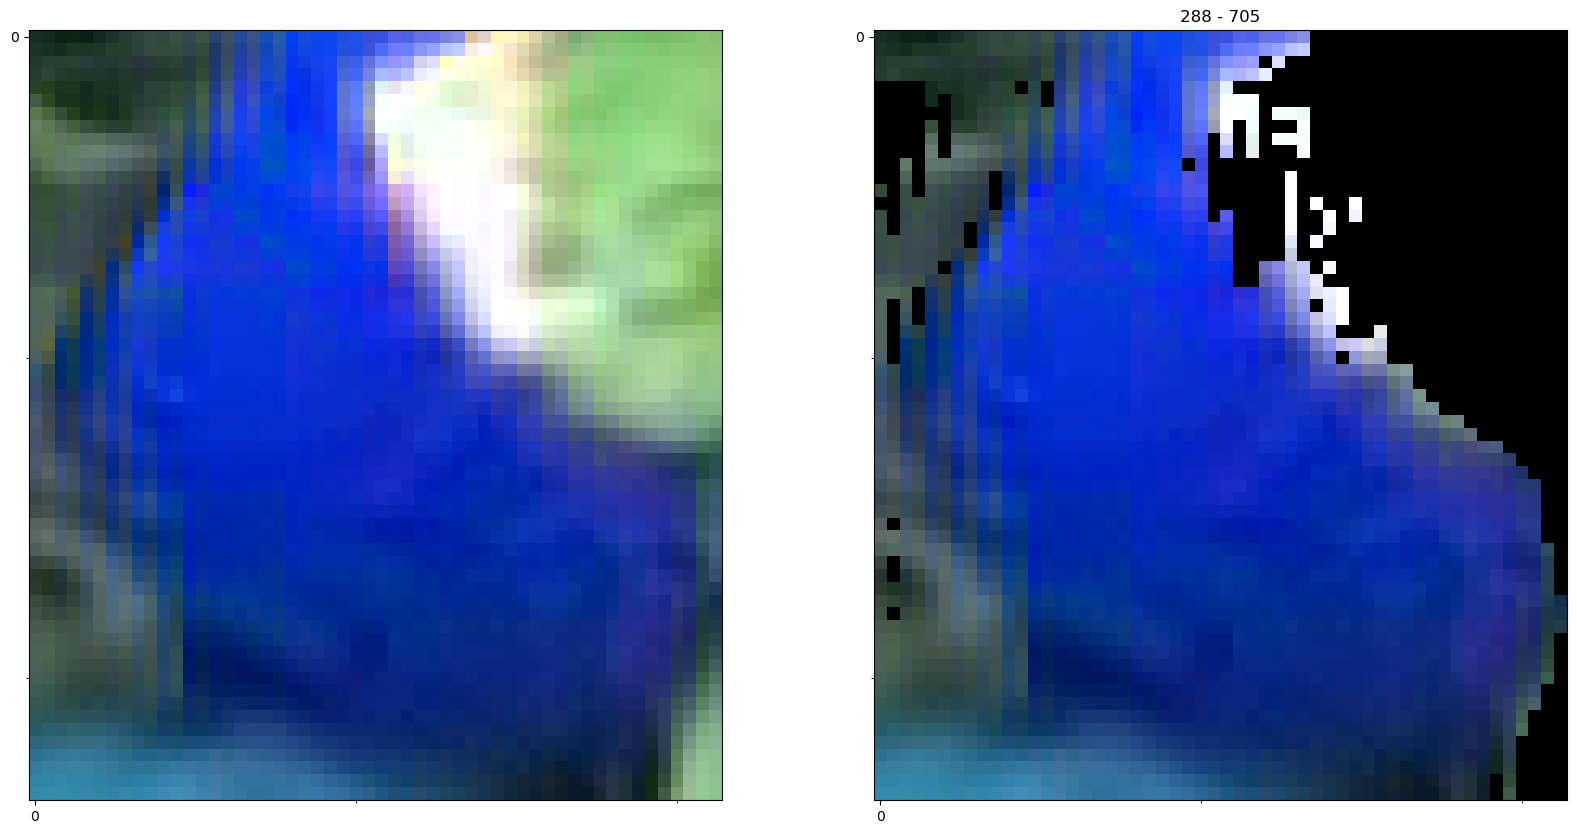

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8/9 [00:01<00:00,  5.11it/s]

pix size mean: width - 34.278099082189705, height - 24.944051827974942
pix size median: width - 35.18722156107395, height - 25.60561705003966
pix size mean filtered: width - 34.86530445500316, height - 25.211334320160496
pix size median filtered: width - 35.9422847384603, height - 25.9901059502061
margin 2: width - 40.906377136707306, height - 41.41257330775261
margin 5: width - 41.14953055977821, height - 43.80474239587784
margin 8: width - 41.163064539432526, height - 44.43105682730675
margin 2 filtered: width - 40.84666073322296, height - 40.82910344004631
margin 5 filtered: width - 40.63868522644043, height - 42.35661029815674
margin 8 filtered: width - 40.846824645996094, height - 43.764494359493256


/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)


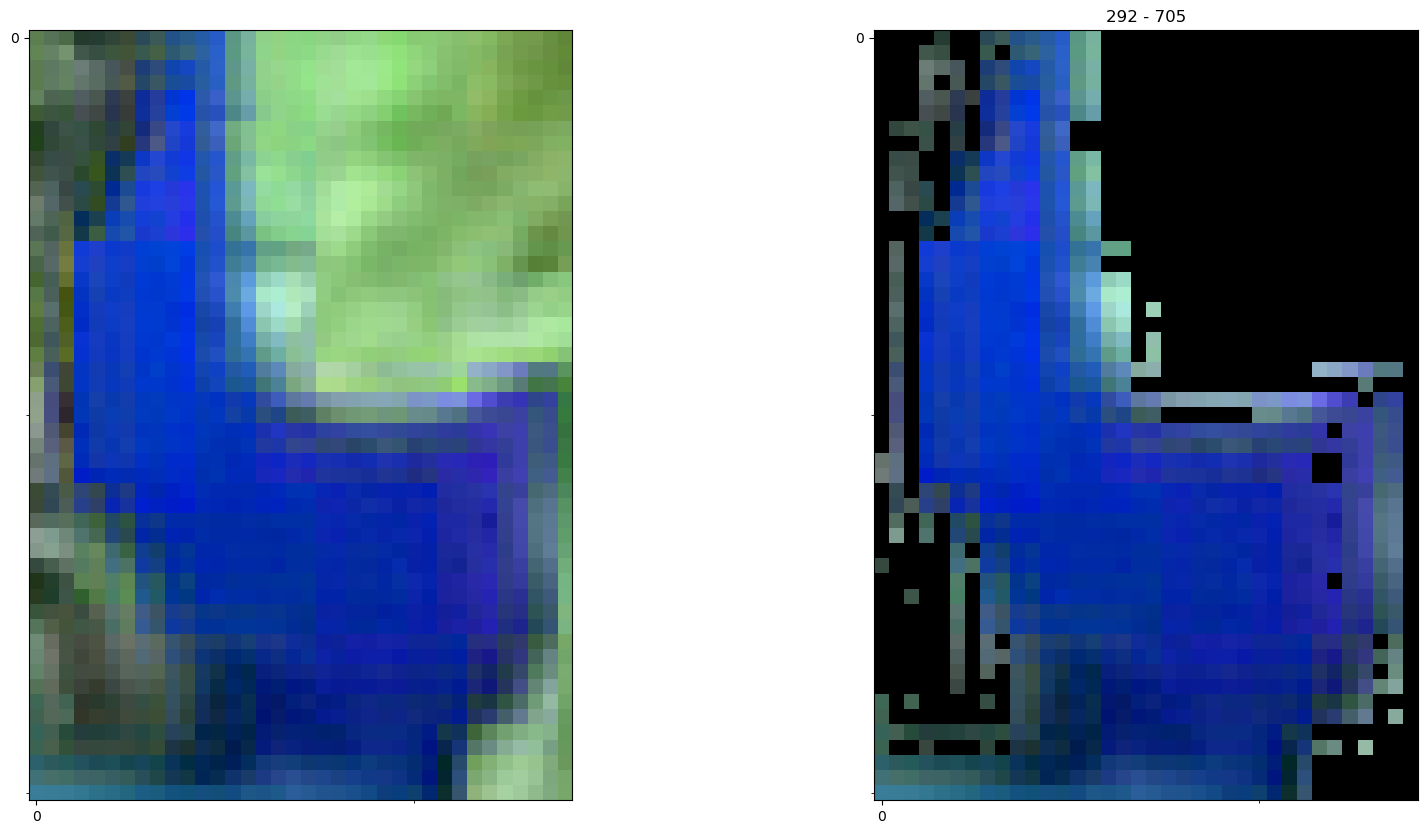

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.15it/s]
/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 48.733282616255195 9.348405748494411 46.84949686545193 10.22390811349728 
 pix med: 
 48.89944279219776 9.311652070593203 46.98510975760026 10.160379600164683 
 pix mean filtered: 
 48.67911588962891 9.106538310652029 46.64728269899161 10.072900393457815 
 pix med filtered: 
 48.92840416571352 9.029112620413743 46.858832685361804 9.97448980579541 
 margin 0.2: 
 38.44685438606474 3.154921876276799 50.8158802986145 9.1095063656918 
 margin 0.5: 
 38.69370950592889 3.8387915757709625 51.226901511351265 9.091659753964697 
 margin 0.8: 
 38.35024560491244 4.099916069777912 51.46780941221449 9.296294763870726 
 margin_f0.2: 
 42.28611787160238 3.633014050013416 50.69950305753284 9.20881882783364 
 margin 0.5_f: 
 41.84911400079727 3.605193599454926 51.076682491434944 9.246290728082535 
 margin 0.8_f: 
 40.6020370622476 3.2060072887162496 51.38822437988387 9.350643905956156


  0%|                                                                                                                                                                                                    | 0/10 [00:00<?, ?it/s]

pix size mean: width - 21.72659803856968, height - 30.15284384391131
pix size median: width - 21.75312218432312, height - 30.18965487265945
pix size mean filtered: width - 21.617905392132272, height - 30.145641659934746
pix size median filtered: width - 21.669446706285044, height - 30.217514765073656
margin 2: width - 49.53417554497719, height - 22.54156582057476
margin 5: width - 50.931137055158615, height - 22.577404975891113
margin 8: width - 51.22993513941765, height - 22.59259670972824
margin 2 filtered: width - 37.63224557042122, height - 22.39346131682396
margin 5 filtered: width - 38.813989609479904, height - 22.577404975891113
margin 8 filtered: width - 39.39753770828247, height - 22.59259670972824


/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)


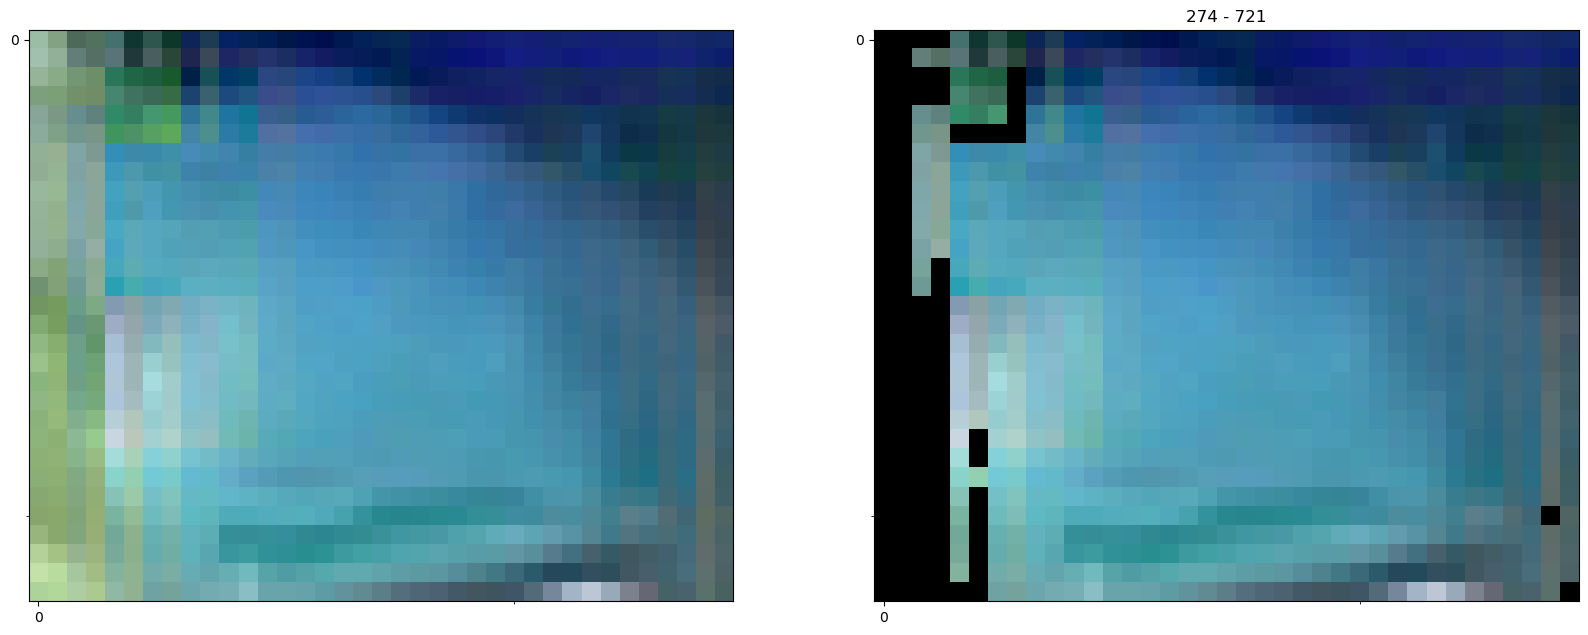

 10%|██████████████████▊                                                                                                                                                                         | 1/10 [00:00<00:01,  5.17it/s]

pix size mean: width - 26.03390517177343, height - 40.646449607829496
pix size median: width - 26.064444784735883, height - 40.694130769419786
pix size mean filtered: width - 25.659219009257743, height - 40.57786327944042
pix size median filtered: width - 25.715874068471837, height - 40.66745841661311
margin 2: width - 52.28462815284729, height - 24.305973201990128
margin 5: width - 51.89879983663559, height - 24.161161854863167
margin 8: width - 51.678724586963654, height - 23.93455058336258
margin 2 filtered: width - 45.53011804819107, height - 23.840000852942467
margin 5 filtered: width - 45.68038880825043, height - 23.646943271160126
margin 8 filtered: width - 45.56237906217575, height - 23.92909675836563


/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)


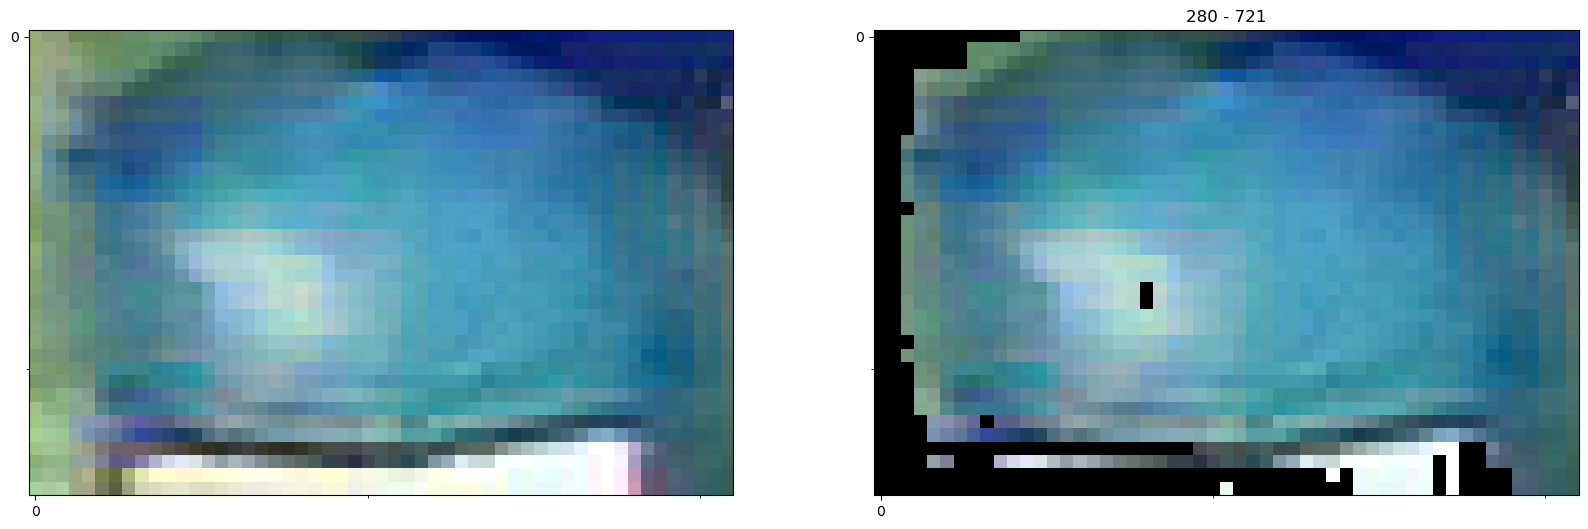

 20%|█████████████████████████████████████▌                                                                                                                                                      | 2/10 [00:00<00:01,  5.50it/s]

pix size mean: width - 38.126962534941335, height - 49.33166070235864
pix size median: width - 38.14066741714943, height - 49.3493931560897
pix size mean filtered: width - 37.59423450058416, height - 49.12133668821715
pix size median filtered: width - 37.64965527592338, height - 49.193750519782675
margin 2: width - 56.26865476369858, height - 36.11176088452339
margin 5: width - 55.51401525735855, height - 36.06291860342026
margin 8: width - 54.25596982240677, height - 36.00636497139931
margin 2 filtered: width - 51.74519121646881, height - 42.64352470636368
margin 5 filtered: width - 51.365695893764496, height - 26.984287425875664
margin 8 filtered: width - 51.34502798318863, height - 24.43821355700493


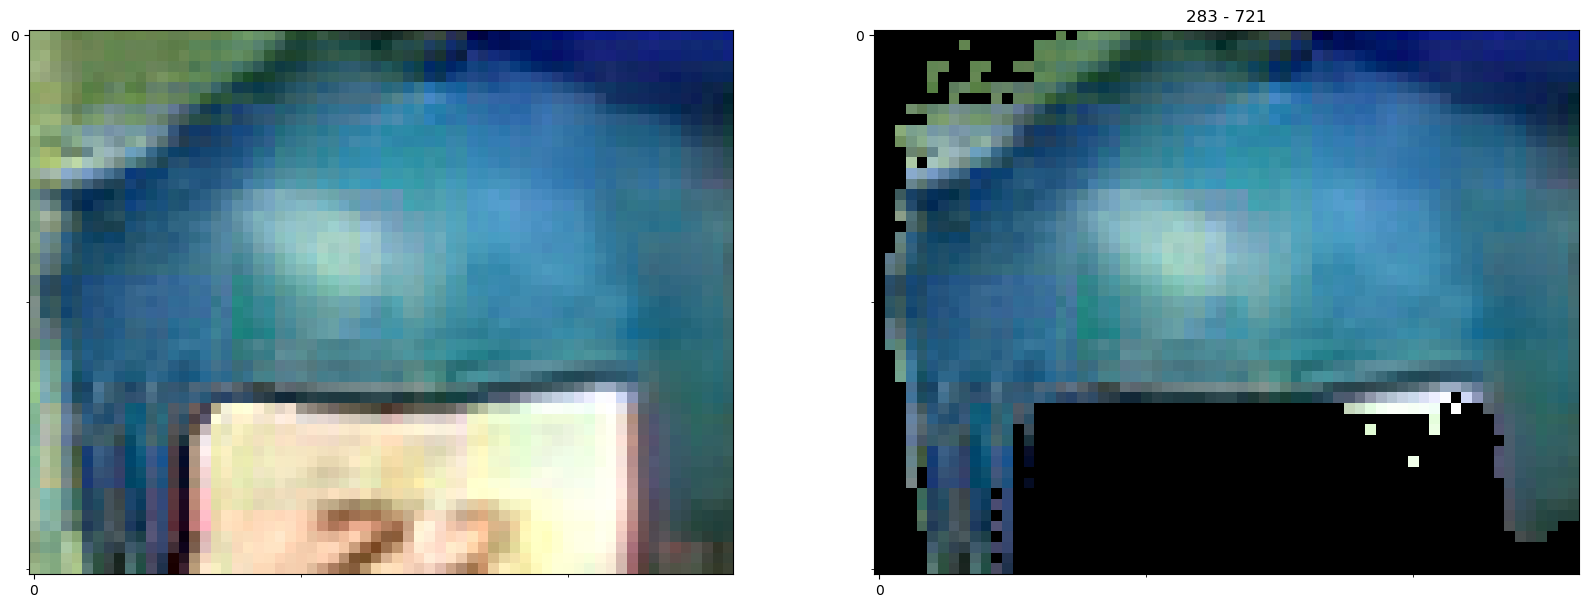

 30%|████████████████████████████████████████████████████████▍                                                                                                                                   | 3/10 [00:00<00:01,  5.58it/s]

pix size mean: width - 46.94401493368461, height - 55.527855007088334
pix size median: width - 47.04566765428419, height - 55.64809520253184
pix size mean filtered: width - 46.8916019899685, height - 55.40706461807622
pix size median filtered: width - 47.13122190155957, height - 55.69019923838934
margin 2: width - 61.04098632931709, height - 46.07205092906952
margin 5: width - 60.49435958266258, height - 45.42354866862297
margin 8: width - 60.50638109445572, height - 45.18873989582062
margin 2 filtered: width - 59.22004207968712, height - 45.70174589753151
margin 5 filtered: width - 59.81723219156265, height - 45.42863741517067
margin 8 filtered: width - 56.92392215132713, height - 45.18873989582062


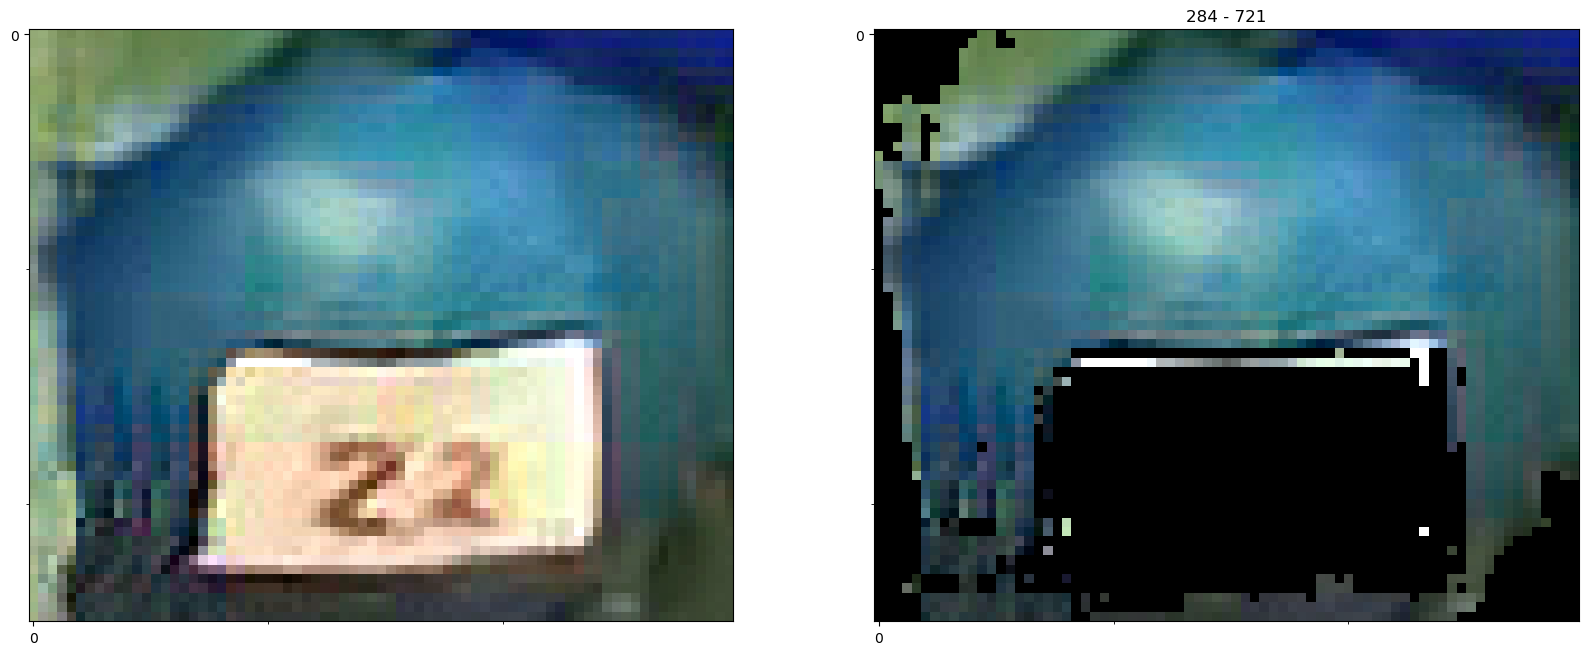

 40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                | 4/10 [00:00<00:01,  5.68it/s]

pix size mean: width - 54.401697851661844, height - 60.586700209754504
pix size median: width - 54.61269413355585, height - 60.82168494334391
pix size mean filtered: width - 54.499520239271305, height - 60.52072411648132
pix size median filtered: width - 54.76385564796157, height - 60.814263771020016
margin 2: width - 62.09122762084007, height - 56.40915408730507
margin 5: width - 61.657361686229706, height - 55.640604346990585
margin 8: width - 61.330799013376236, height - 54.30852249264717
margin 2 filtered: width - 61.2802617251873, height - 55.52045628428459
margin 5 filtered: width - 61.58662214875221, height - 53.38703840970993
margin 8 filtered: width - 61.628833413124084, height - 52.806828171014786


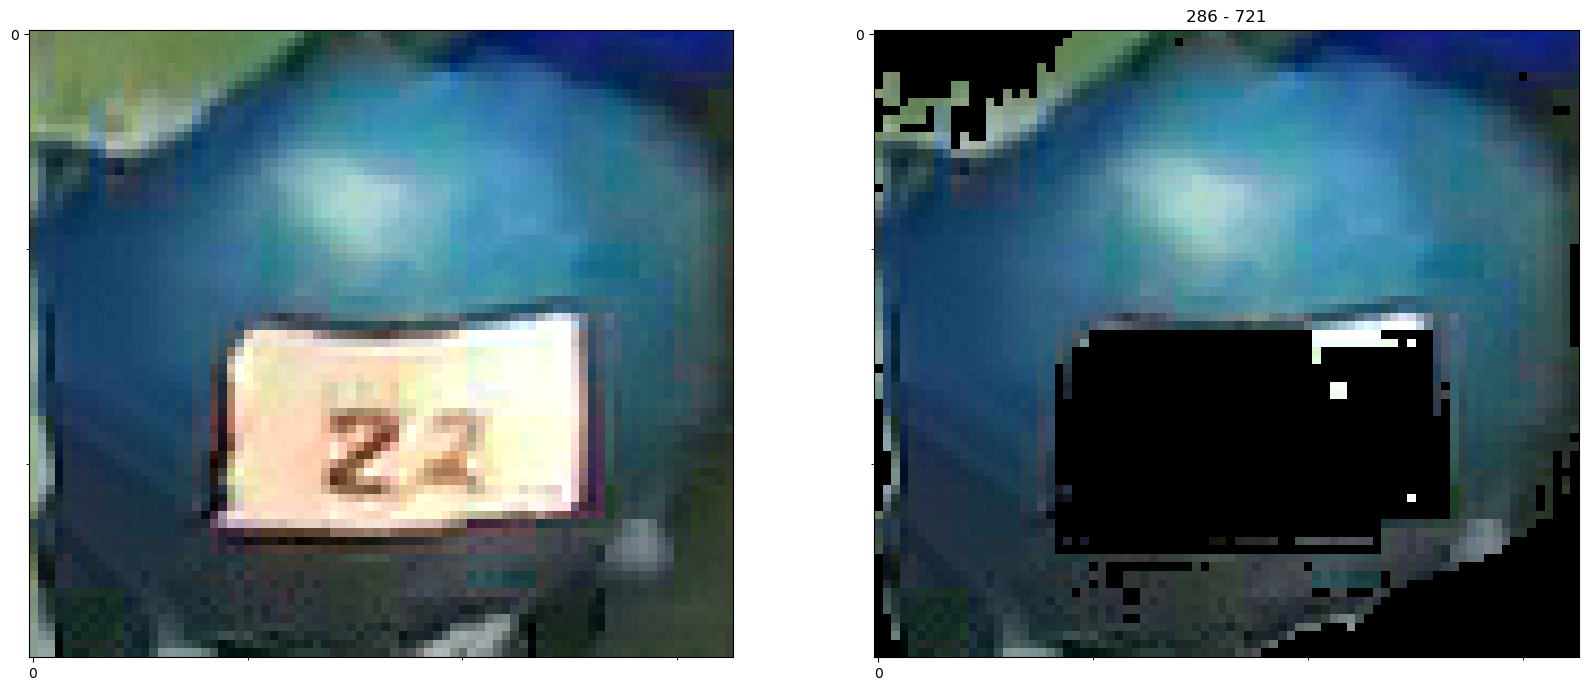

 50%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 5/10 [00:00<00:00,  5.29it/s]

pix size mean: width - 51.29230593552312, height - 61.2985656003267
pix size median: width - 51.352704673913216, height - 61.37074710903169
pix size mean filtered: width - 51.4206490256503, height - 61.03302691283091
pix size median filtered: width - 51.54159085778468, height - 61.17657714479827
margin 2: width - 60.821834951639175, height - 51.30942165851593
margin 5: width - 60.68943813443184, height - 49.849193543195724
margin 8: width - 60.701433569192886, height - 49.68759045004845
margin 2 filtered: width - 60.137756168842316, height - 50.64499378204346
margin 5 filtered: width - 60.101255774497986, height - 49.84454810619354
margin 8 filtered: width - 58.90607461333275, height - 49.69092831015587


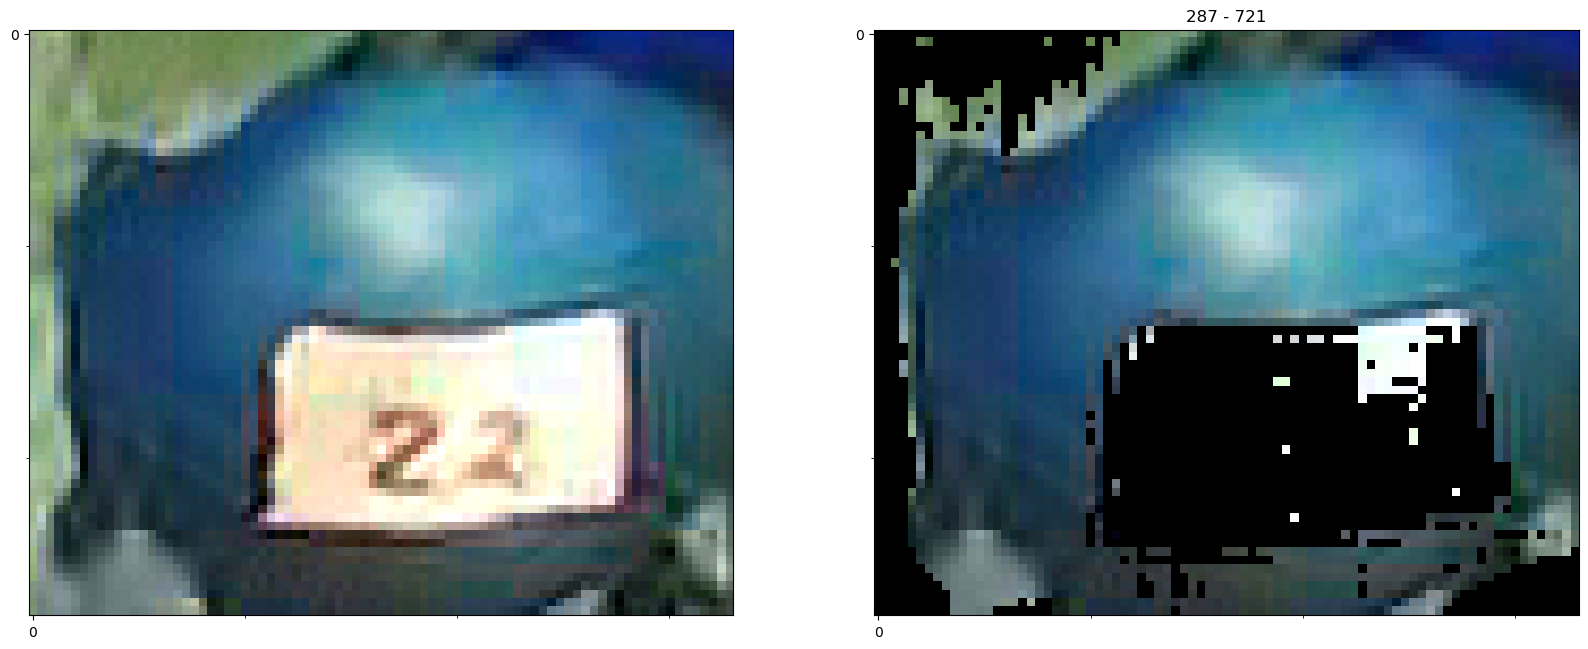

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 6/10 [00:01<00:00,  5.15it/s]

pix size mean: width - 48.14540016368054, height - 56.1313376924802
pix size median: width - 48.214239078508434, height - 56.21159500390458
pix size mean filtered: width - 48.264680186500684, height - 55.972112595202304
pix size median filtered: width - 48.3578579845251, height - 56.08017004388408
margin 2: width - 55.87132275104523, height - 47.67703264951706
margin 5: width - 55.85819110274315, height - 47.055553644895554
margin 8: width - 55.87217956781387, height - 46.83776944875717
margin 2 filtered: width - 55.97556009888649, height - 48.49414899945259
margin 5 filtered: width - 55.85819110274315, height - 48.396408557891846
margin 8 filtered: width - 55.87217956781387, height - 47.63682186603546


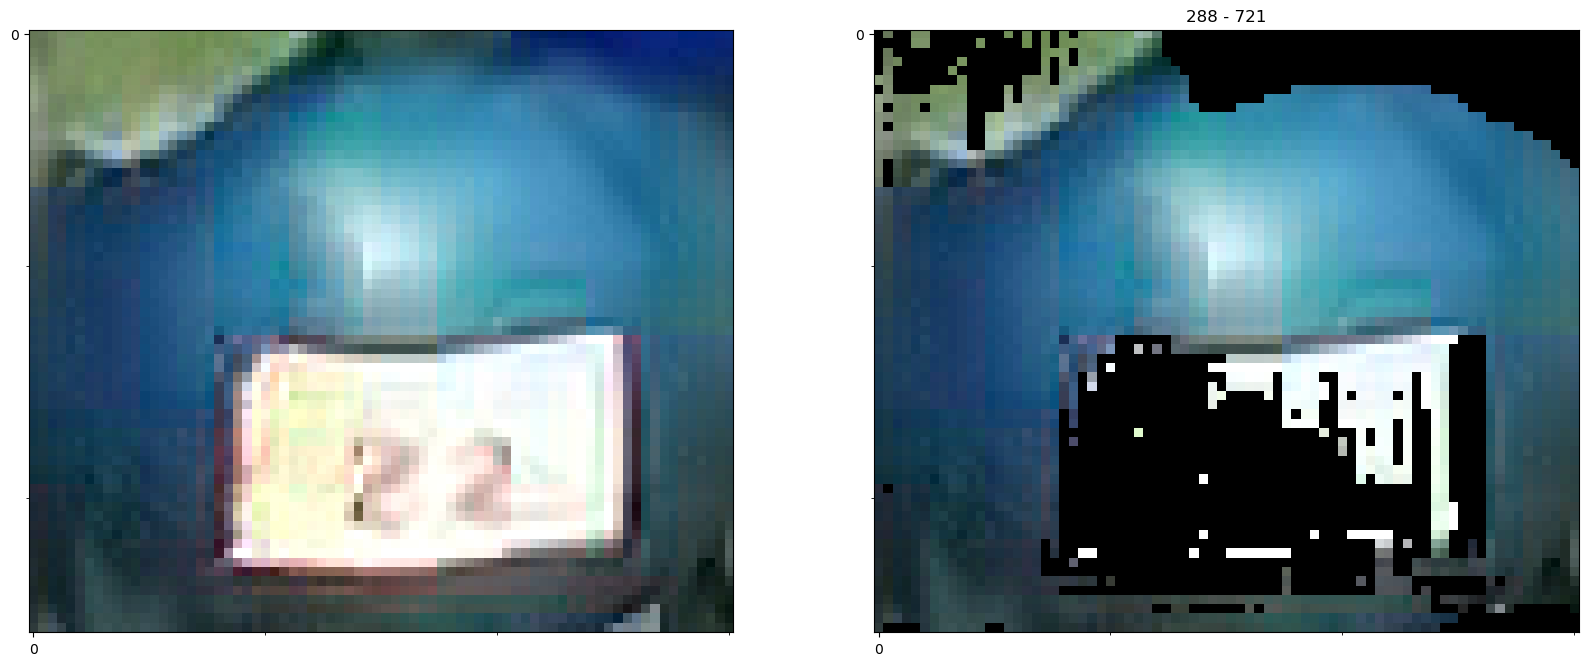

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 7/10 [00:01<00:00,  5.16it/s]

pix size mean: width - 42.616532582173825, height - 42.09551687888954
pix size median: width - 42.564591585021525, height - 42.0442108952759
pix size mean filtered: width - 42.84317804121605, height - 41.93697837755219
pix size median filtered: width - 42.789441948457274, height - 41.88437888649782
margin 2: width - 39.70532864332199, height - 41.89017042517662
margin 5: width - 39.51296955347061, height - 41.88930615782738
margin 8: width - 38.97539898753166, height - 41.882846504449844
margin 2 filtered: width - 41.6947640478611, height - 42.145099490880966
margin 5 filtered: width - 41.24726355075836, height - 42.034752666950226
margin 8 filtered: width - 40.42845591902733, height - 41.8742261826992


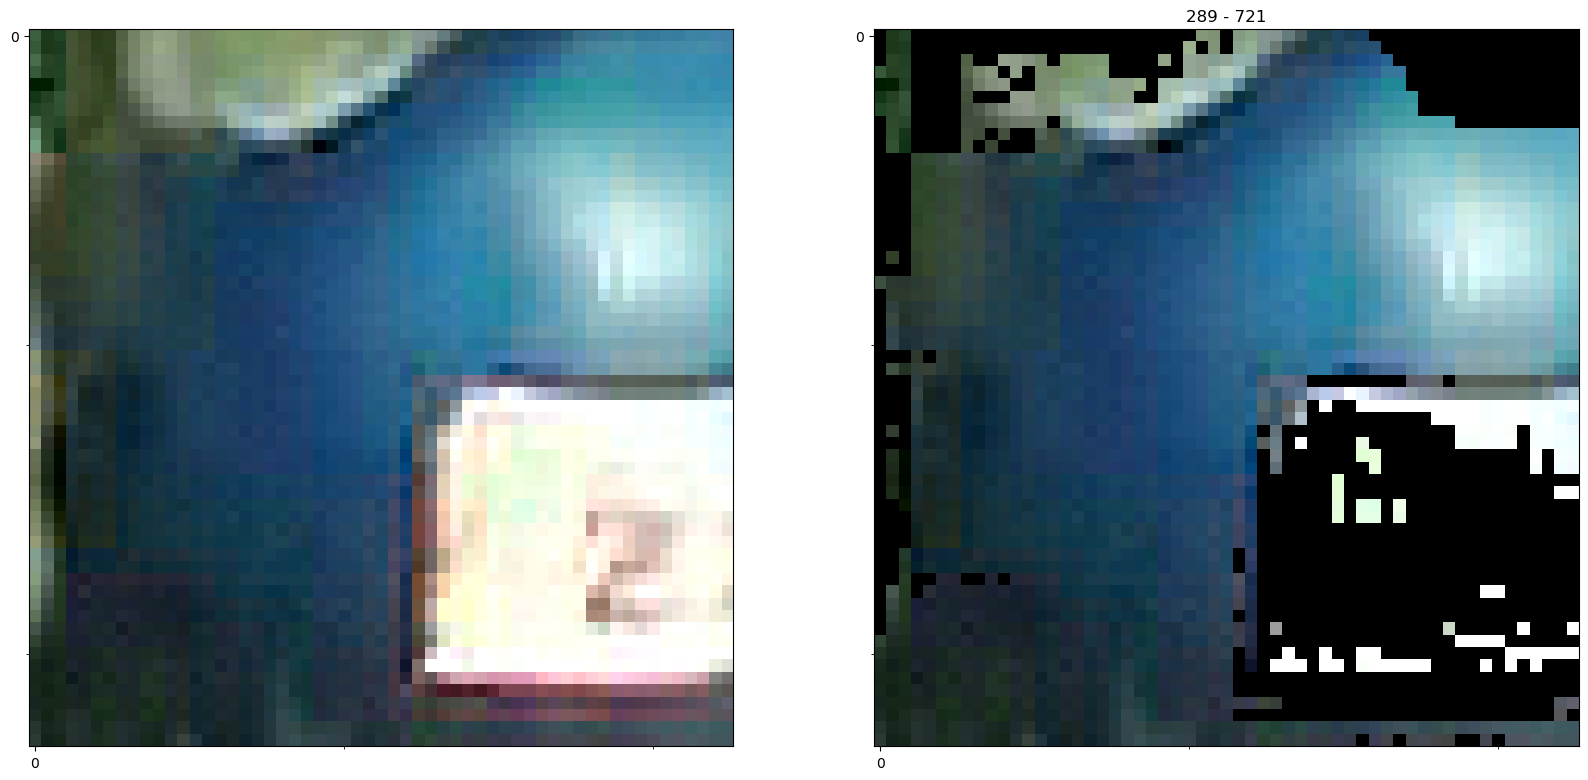

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 8/10 [00:01<00:00,  5.10it/s]

pix size mean: width - 37.86142911546605, height - 46.40921630724984
pix size median: width - 37.8610417177288, height - 46.40874144864559
pix size mean filtered: width - 37.86292173615964, height - 46.30780096707732
pix size median filtered: width - 37.881801678825674, height - 46.33089185883002
margin 2: width - 45.473676174879074, height - 36.88289225101471
margin 5: width - 45.432087033987045, height - 36.803681403398514
margin 8: width - 45.41630670428276, height - 36.74875572323799
margin 2 filtered: width - 45.63162475824356, height - 37.35831007361412
margin 5 filtered: width - 45.432087033987045, height - 37.53608092665672
margin 8 filtered: width - 45.41630670428276, height - 35.97361594438553


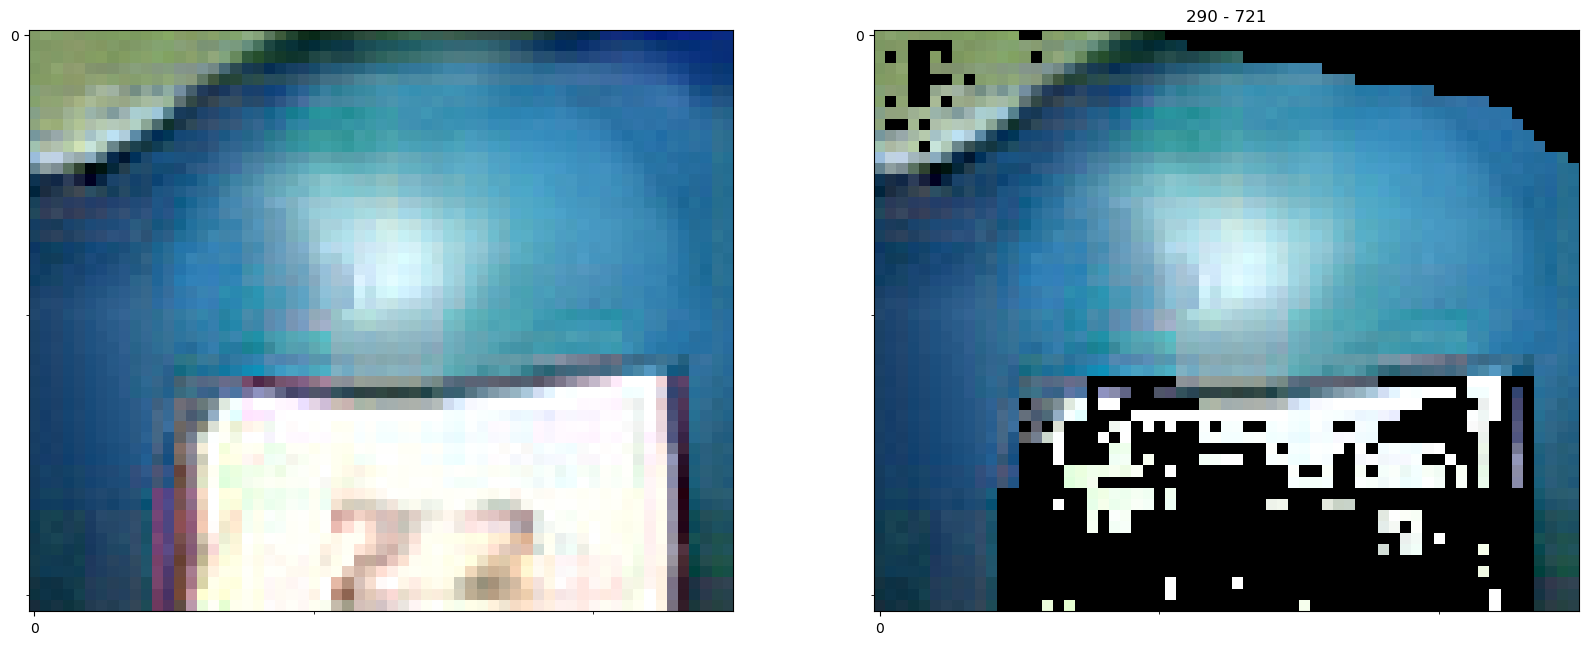

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9/10 [00:01<00:00,  5.10it/s]

pix size mean: width - 39.78087057777249, height - 43.54954388655623
pix size median: width - 39.81561425348402, height - 43.587579032801266
pix size mean filtered: width - 39.85865571277835, height - 43.47715783799058
pix size median filtered: width - 39.93931325565921, height - 43.56513774247918
margin 2: width - 49.71195384860039, height - 40.97659885883331
margin 5: width - 50.97479745745659, height - 40.9221351146698
margin 8: width - 52.60588228702545, height - 40.932778269052505
margin 2 filtered: width - 44.03475299477577, height - 41.22559726238251
margin 5 filtered: width - 48.583630472421646, height - 39.14181515574455
margin 8 filtered: width - 45.02328857779503, height - 39.49090838432312


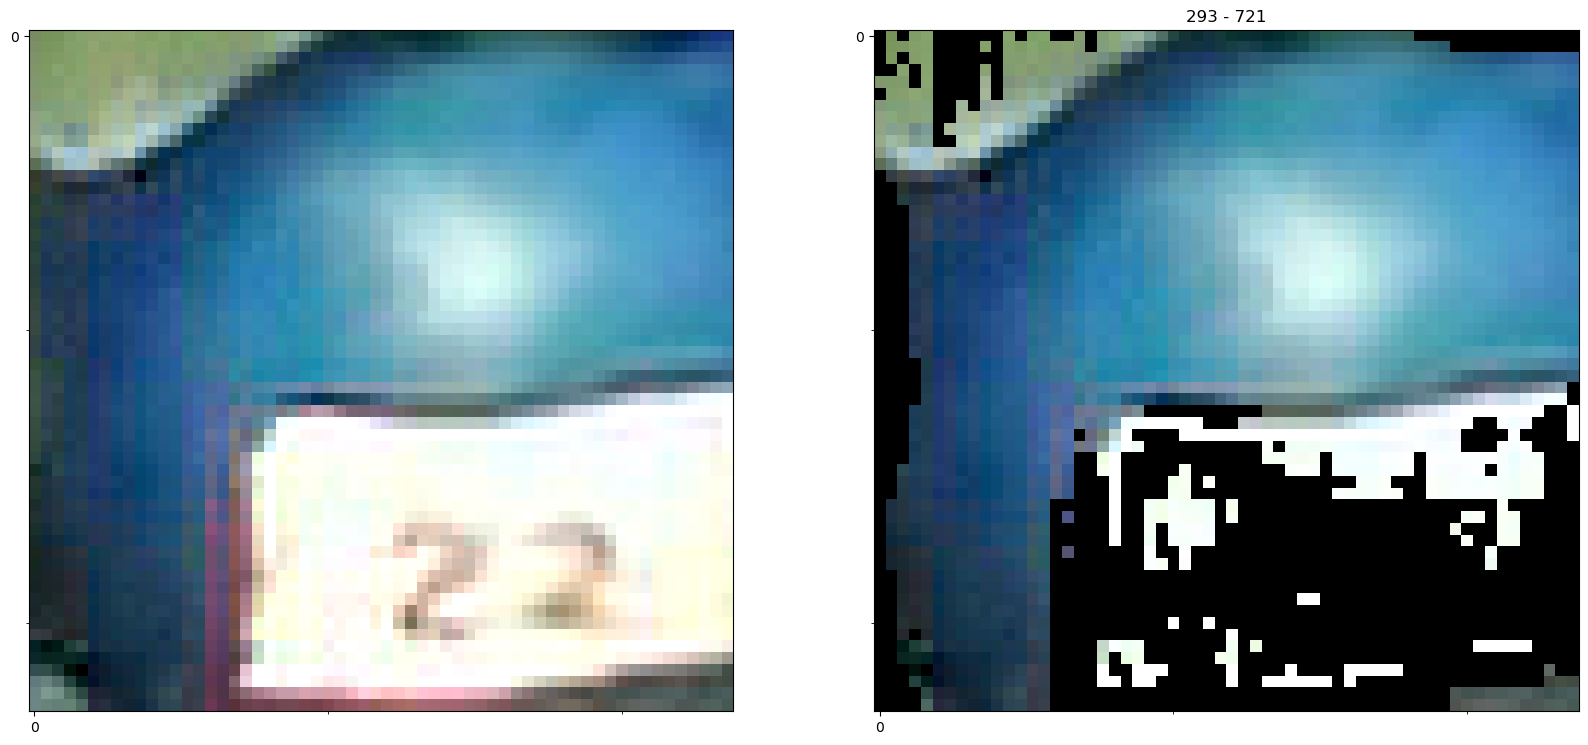

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.90it/s]

ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 40.692971690524686 9.943012134987177 48.57296897364448 9.414617720248803 
 pix med: 
 40.74247874827044 9.97902189664639 48.63258324337038 9.460298553773395 
 pix mean filtered: 
 40.651256583351895 10.07096285793163 48.449970705280315 9.371372702164125 
 pix med filtered: 
 40.744005932545335 10.120244128184577 48.562034238736814 9.435887679466868 
 margin 0.2: 
 53.28037887811661 6.952411367964199 40.41766207665205 10.352227913036065 
 margin 0.5: 
 53.29631567001343 6.727717837604289 40.038550831377506 10.026806361475636 
 margin 0.8: 
 53.257301077246666 6.733950922304694 39.81205150485039 9.818143111806258 
 margin_f0.2: 
 50.288231670856476 8.059372365114575 40.996733866631985 10.198687225515233 
 margin 0.5_f: 
 50.84863565862179 7.777616142243167 38.89779169112444 10.560656828524577 
 margin 0.8_f: 
 50.05040057003498 7.538248229143906 38.36219757795334 10.676111303877432



/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),
  0%|                                                                                                                                                                                                    | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)


pix size mean: width - 33.48859379073213, height - 40.02258845373431
pix size median: width - 33.42469914769662, height - 39.94622725987263
pix size mean filtered: width - 32.91614518994607, height - 39.970086056337294
pix size median filtered: width - 32.8793674260414, height - 39.9254268053908
margin 2: width - 37.049051374197006, height - 35.75873002409935
margin 5: width - 37.131160497665405, height - 35.72176769375801
margin 8: width - 36.995626986026764, height - 35.70876270532608
margin 2 filtered: width - 37.40692511200905, height - 30.95611184835434
margin 5 filtered: width - 36.69114038348198, height - 31.073125079274178
margin 8 filtered: width - 36.995626986026764, height - 31.27879649400711


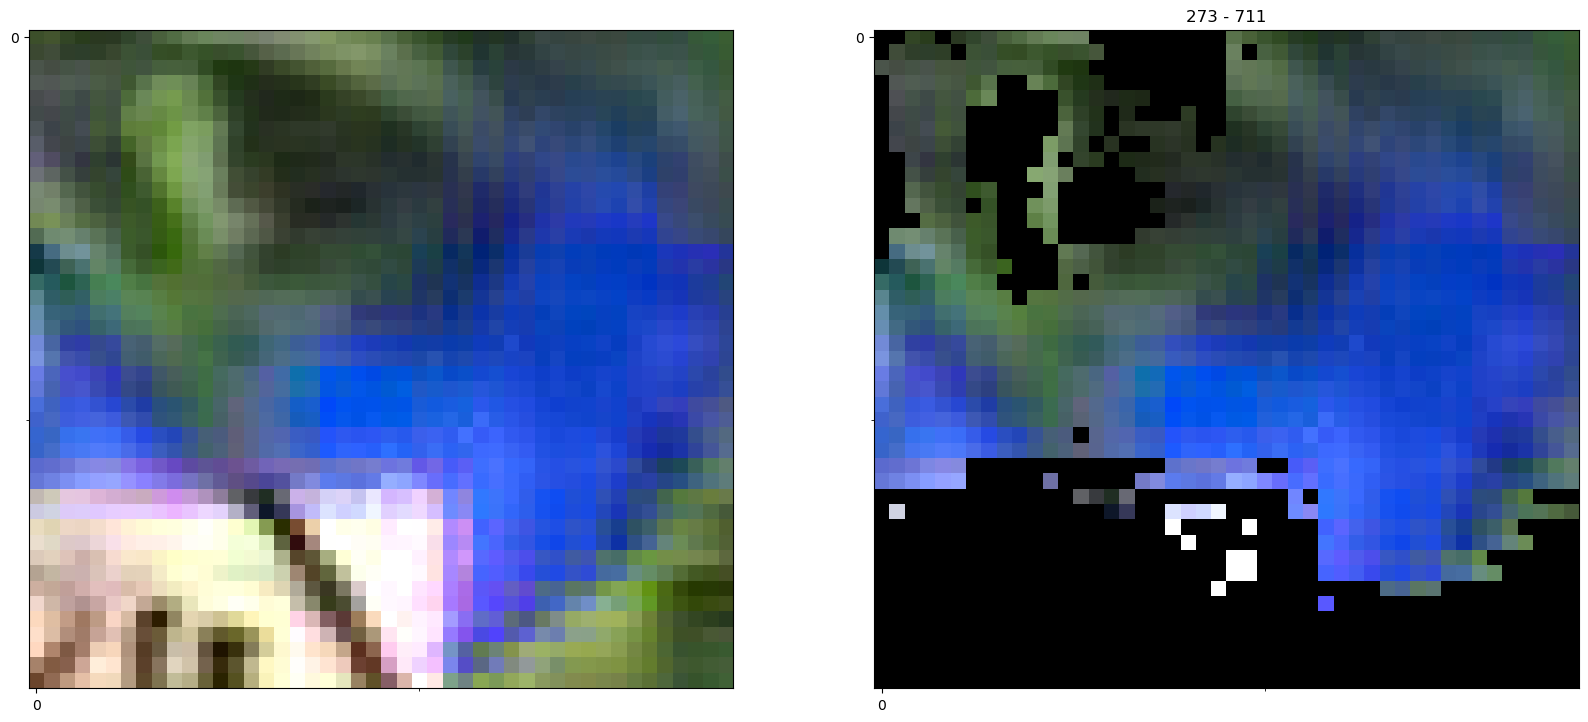

  9%|█████████████████                                                                                                                                                                           | 1/11 [00:00<00:02,  3.87it/s]

pix size mean: width - 30.916048759944413, height - 35.684951621523915
pix size median: width - 30.88462759119083, height - 35.64868363347766
pix size mean filtered: width - 30.59025846677762, height - 35.66206154747092
pix size median filtered: width - 30.6299565053793, height - 35.70834144070768
margin 2: width - 33.228885382413864, height - 31.580917537212372
margin 5: width - 32.12309628725052, height - 31.584888696670532
margin 8: width - 31.155219301581383, height - 31.60449117422104
margin 2 filtered: width - 33.478911966085434, height - 33.35350751876831
margin 5 filtered: width - 33.478911966085434, height - 33.51468965411186
margin 8 filtered: width - 31.155219301581383, height - 30.3329024463892


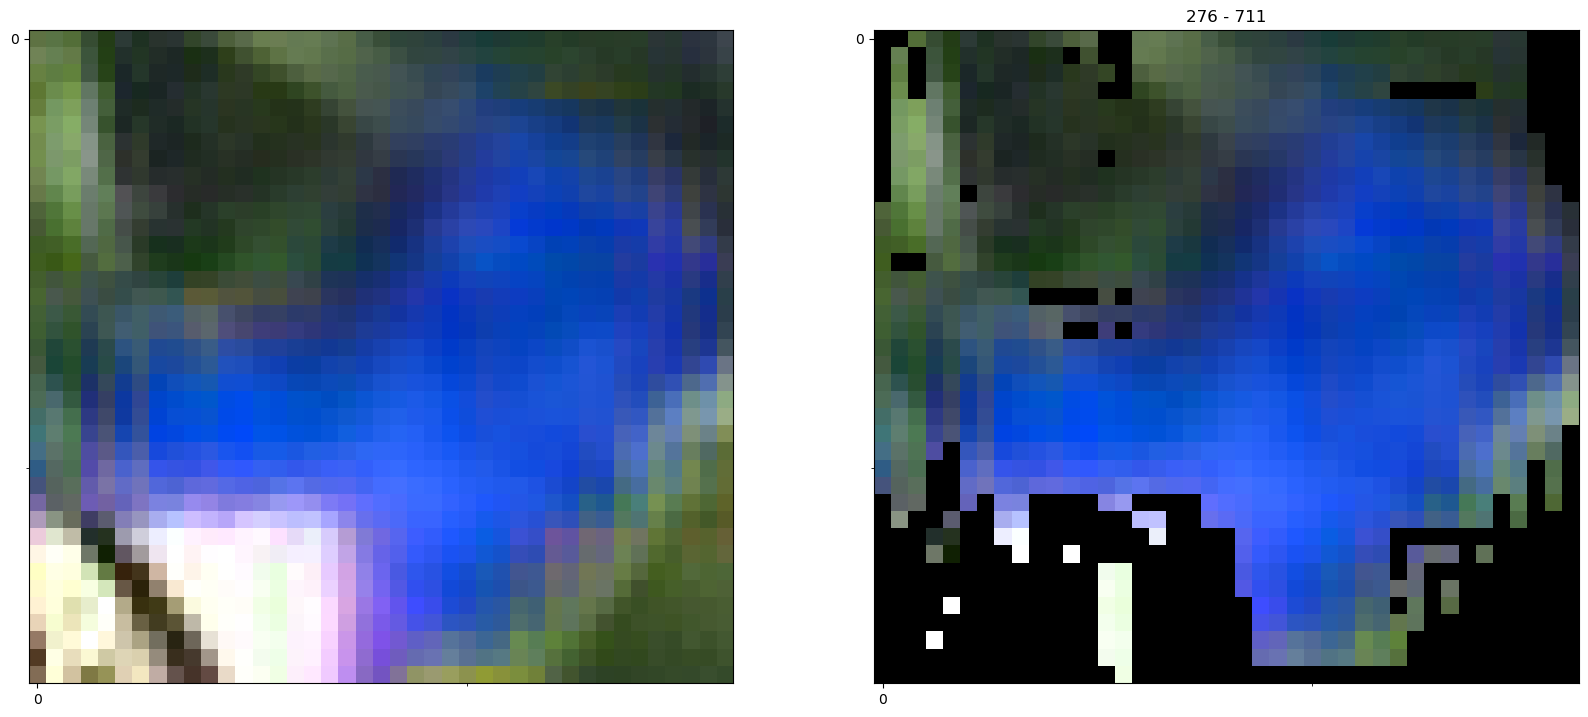

 18%|██████████████████████████████████▏                                                                                                                                                         | 2/11 [00:00<00:01,  5.05it/s]

pix size mean: width - 30.18723628922929, height - 33.765178380551774
pix size median: width - 30.124251227765825, height - 33.694728014865845
pix size mean filtered: width - 29.92808464642439, height - 33.751051839594446
pix size median filtered: width - 29.932443564268862, height - 33.75596755885517
margin 2: width - 30.330840498209, height - 30.322860926389694
margin 5: width - 29.498452320694923, height - 30.311983078718185
margin 8: width - 28.04790623486042, height - 30.312519520521164
margin 2 filtered: width - 31.84068575501442, height - 30.017033219337463
margin 5 filtered: width - 31.35019540786743, height - 30.045611783862114
margin 8 filtered: width - 28.740735724568367, height - 29.935486614704132


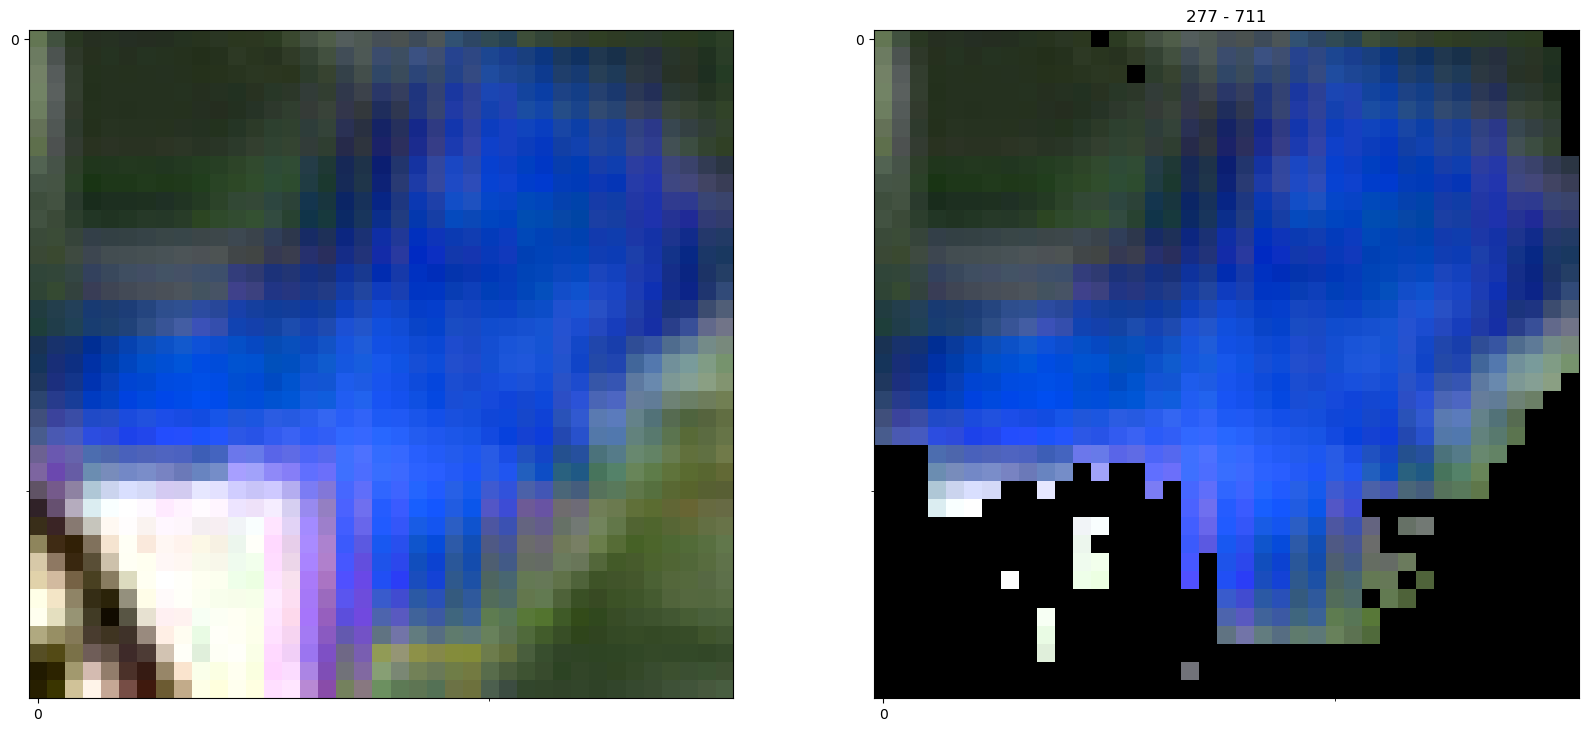

 27%|███████████████████████████████████████████████████▎                                                                                                                                        | 3/11 [00:00<00:01,  5.35it/s]

pix size mean: width - 51.30645442468612, height - 53.59449004458446
pix size median: width - 51.43775647917489, height - 53.73164757634225
pix size mean filtered: width - 50.641538482559014, height - 53.66095823301301
pix size median filtered: width - 50.71957841111699, height - 53.743651165975514
margin 2: width - 57.78222531080246, height - 48.14402759075165
margin 5: width - 56.58145248889923, height - 47.6323701441288
margin 8: width - 54.75923791527748, height - 46.71647027134895
margin 2 filtered: width - 55.43770641088486, height - 50.850555300712585
margin 5 filtered: width - 55.26014044880867, height - 52.15103551745415
margin 8 filtered: width - 54.700642824172974, height - 49.7865192592144


/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)


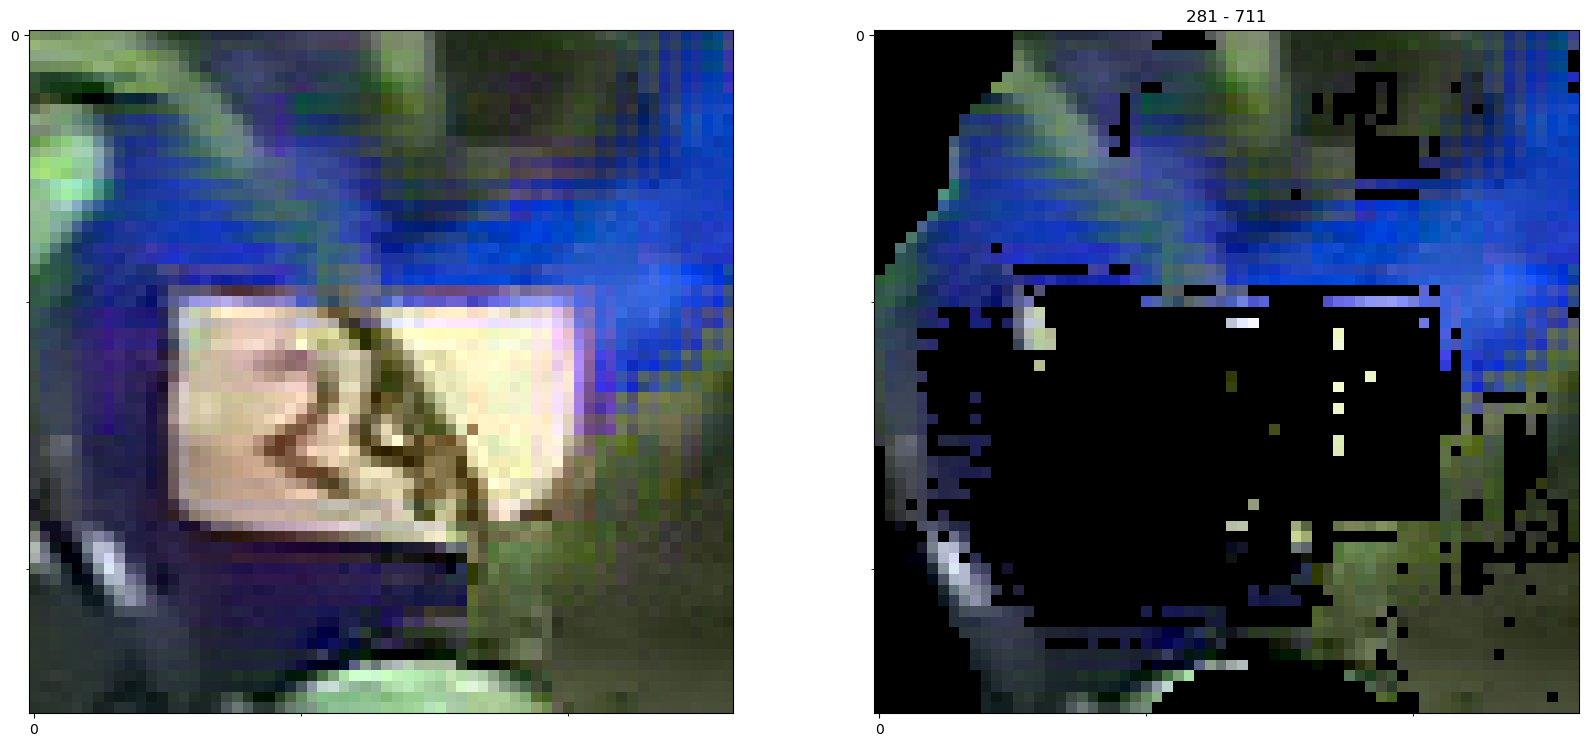

 36%|████████████████████████████████████████████████████████████████████▎                                                                                                                       | 4/11 [00:00<00:01,  5.33it/s]

pix size mean: width - 32.74465368216538, height - 30.782810117080516
pix size median: width - 32.62512861677867, height - 30.670446204860102
pix size mean filtered: width - 32.629996826270244, height - 30.763858994145583
pix size median filtered: width - 32.552647280881736, height - 30.69093313637541
margin 2: width - 27.302714064717293, height - 31.90448507666588
margin 5: width - 27.07567997276783, height - 31.930644065141678
margin 8: width - 26.959512382745743, height - 31.98019042611122
margin 2 filtered: width - 27.129802852869034, height - 33.833637833595276
margin 5 filtered: width - 27.241196483373642, height - 32.78014436364174
margin 8 filtered: width - 27.439521625638008, height - 32.27170556783676


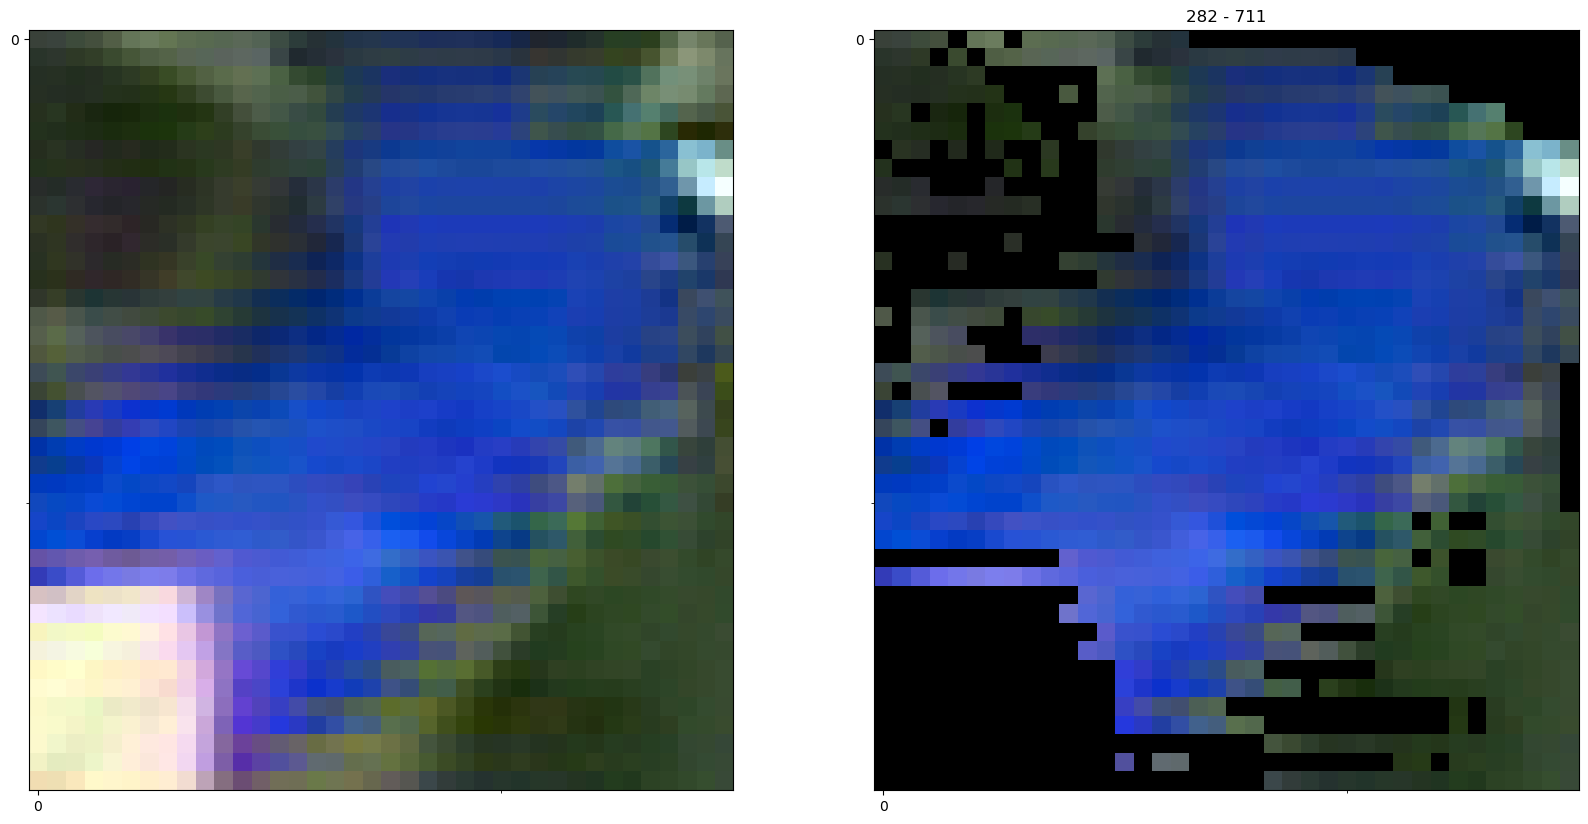

 45%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 5/11 [00:00<00:01,  5.34it/s]

pix size mean: width - 48.035503502691824, height - 58.606421160111765
pix size median: width - 47.99799751699062, height - 58.560661431707814
pix size mean filtered: width - 47.75618743861628, height - 58.62095729036299
pix size median filtered: width - 47.742249222596094, height - 58.60384806096577
margin 2: width - 57.754699140787125, height - 46.95197939872742
margin 5: width - 56.876156479120255, height - 46.84743285179138
margin 8: width - 56.19098246097565, height - 46.49245738983154
margin 2 filtered: width - 55.97684159874916, height - 47.929905354976654
margin 5 filtered: width - 56.066546589136124, height - 47.30319231748581
margin 8 filtered: width - 55.92210590839386, height - 28.047651052474976


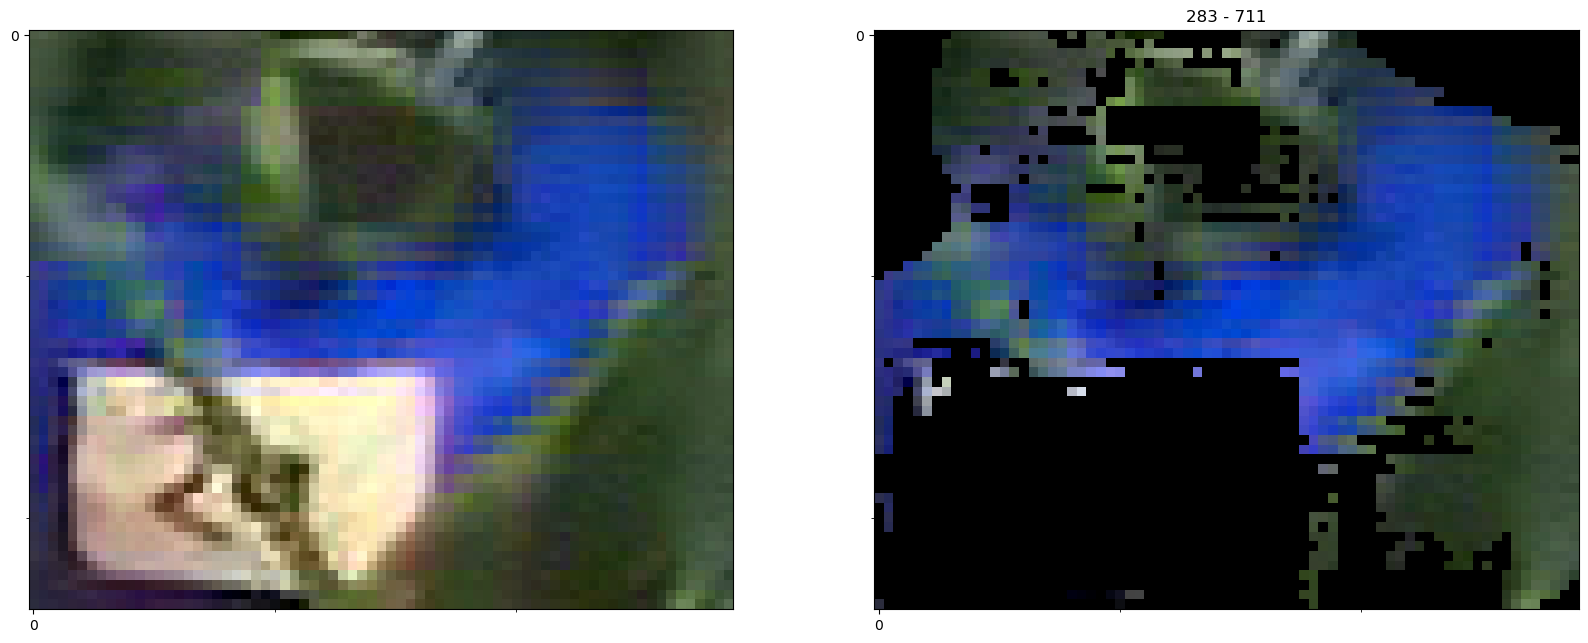

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 6/11 [00:01<00:00,  5.35it/s]

pix size mean: width - 44.64568223160723, height - 52.6231258964177
pix size median: width - 44.57122461296296, height - 52.535363935036095
pix size mean filtered: width - 44.615786120690345, height - 52.67357993929389
pix size median filtered: width - 44.588440740751395, height - 52.64129587167062
margin 2: width - 50.849344581365585, height - 43.1317575275898
margin 5: width - 50.7846437394619, height - 43.07010397315025
margin 8: width - 50.711218267679214, height - 43.0336594581604
margin 2 filtered: width - 50.880663096904755, height - 43.200116604566574
margin 5 filtered: width - 50.81166699528694, height - 43.122295290231705
margin 8 filtered: width - 50.69687217473984, height - 43.218325823545456


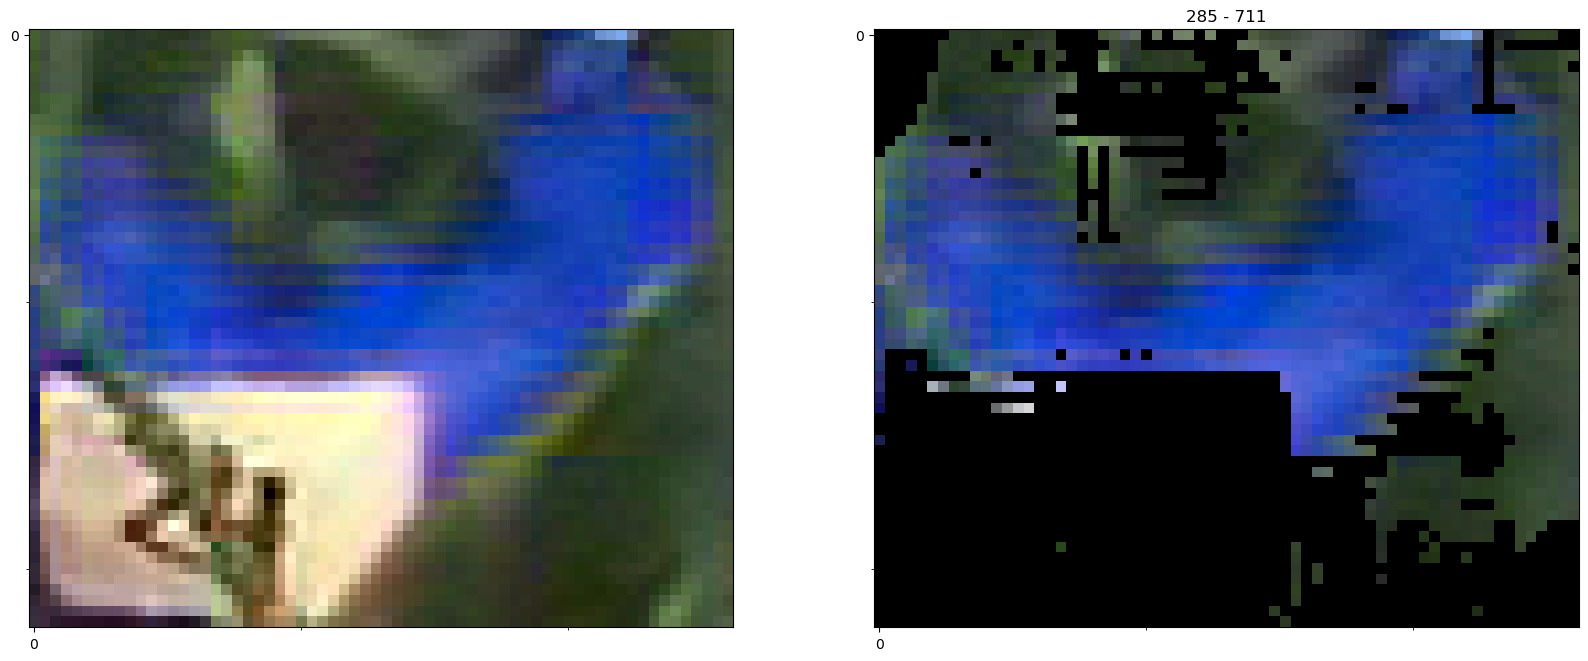

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 7/11 [00:01<00:00,  5.39it/s]

pix size mean: width - 49.42729192050038, height - 55.095869471785875
pix size median: width - 49.09625999092723, height - 54.72687308792389
pix size mean filtered: width - 49.535703263542054, height - 55.13863175491598
pix size median filtered: width - 49.39331673061281, height - 54.98014003906662
margin 2: width - 52.940256893634796, height - 47.707222402095795
margin 5: width - 53.40791121125221, height - 47.76090756058693
margin 8: width - 53.47878485918045, height - 47.77080938220024
margin 2 filtered: width - 55.06681650876999, height - 50.65338313579559
margin 5 filtered: width - 54.301850497722626, height - 49.67161640524864
margin 8 filtered: width - 52.716221660375595, height - 47.144703567028046


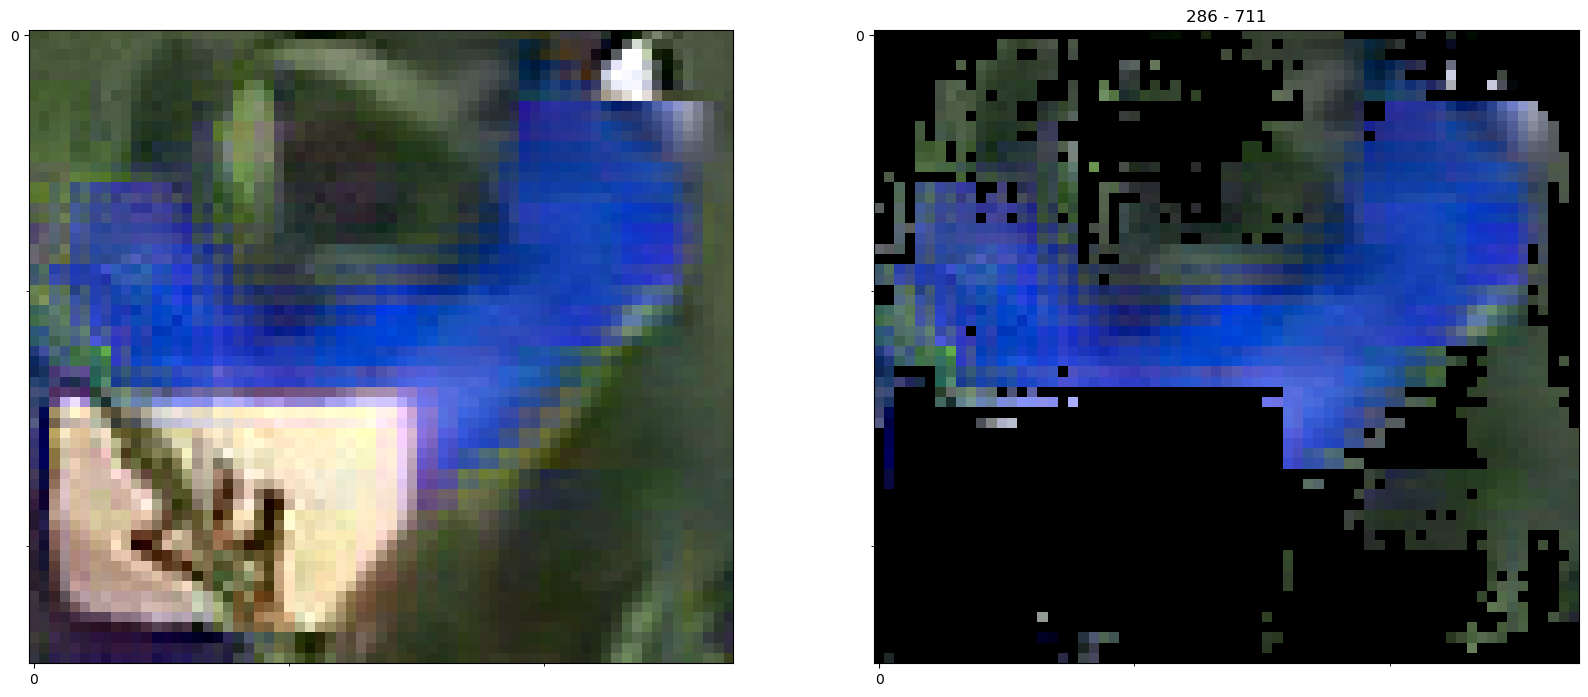

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 8/11 [00:01<00:00,  5.06it/s]

pix size mean: width - 42.99477448830974, height - 52.745656219644985
pix size median: width - 42.812490009381335, height - 52.522031033231954
pix size mean filtered: width - 43.17241003510732, height - 52.76692900956604
pix size median filtered: width - 43.07716450749935, height - 52.650516374976434
margin 2: width - 51.23404785990715, height - 41.54007509350777
margin 5: width - 51.633644849061966, height - 41.5358729660511
margin 8: width - 51.744669675827026, height - 41.57949239015579
margin 2 filtered: width - 51.61402374505997, height - 39.93671387434006
margin 5 filtered: width - 51.66730657219887, height - 39.92928937077522
margin 8 filtered: width - 50.93557387590408, height - 39.934590458869934


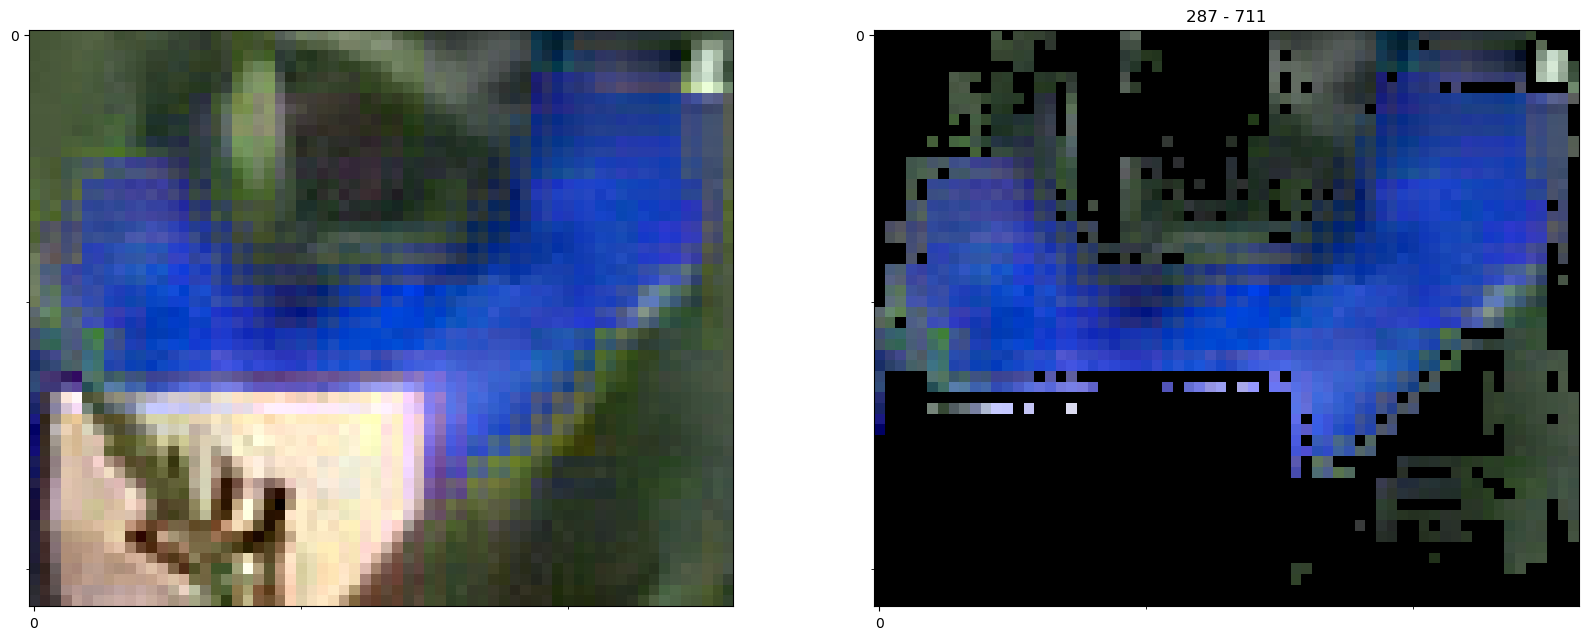

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 9/11 [00:01<00:00,  5.10it/s]

pix size mean: width - 36.96748026605615, height - 34.99290361921251
pix size median: width - 36.86280049369749, height - 34.89381519991359
pix size mean filtered: width - 37.1204916656878, height - 35.0062066048731
pix size median filtered: width - 37.07312661695427, height - 34.96153934408491
margin 2: width - 34.8425954580307, height - 35.899851471185684
margin 5: width - 34.98299792408943, height - 35.89889779686928
margin 8: width - 35.08369252085686, height - 35.8826145529747
margin 2 filtered: width - 35.23249924182892, height - 35.81835702061653
margin 5 filtered: width - 34.924402832984924, height - 35.931769758462906
margin 8 filtered: width - 35.02708673477173, height - 35.15641763806343


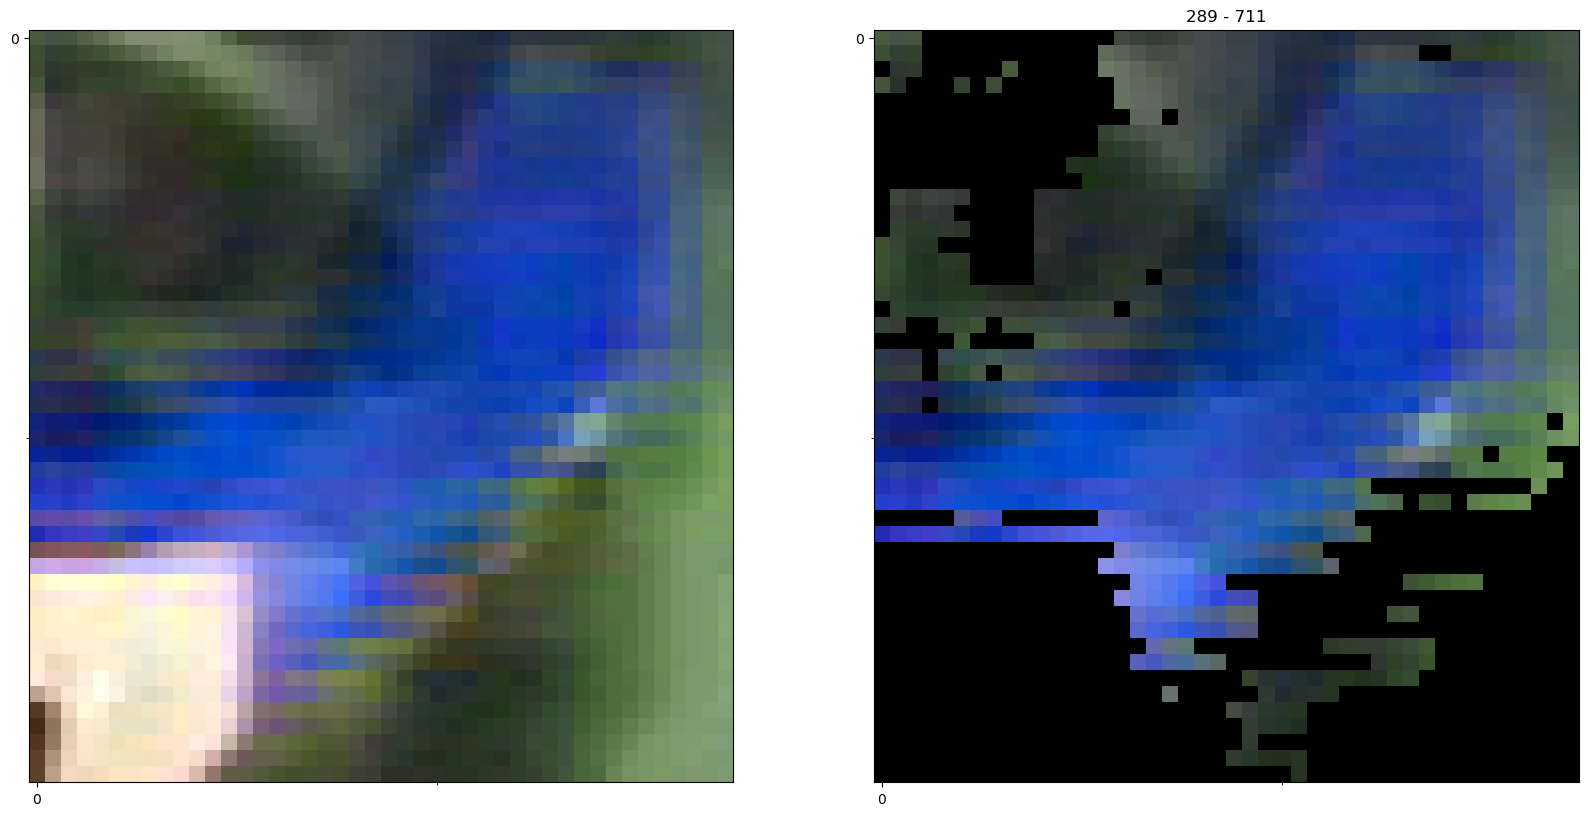

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 10/11 [00:01<00:00,  4.88it/s]

pix size mean: width - 29.646165525668504, height - 43.45405192286908
pix size median: width - 29.538217646447446, height - 43.29582664599224
pix size mean filtered: width - 29.982675931217877, height - 43.468402367724714
pix size median filtered: width - 29.89275166516859, height - 43.33803161001711
margin 2: width - 62.742166221141815, height - 29.269859194755554
margin 5: width - 62.59860098361969, height - 29.639972373843193
margin 8: width - 62.716253101825714, height - 29.659878462553024
margin 2 filtered: width - 51.307935267686844, height - 30.483277514576912
margin 5 filtered: width - 51.04326456785202, height - 29.89208698272705
margin 8 filtered: width - 51.17417499423027, height - 28.92226353287697


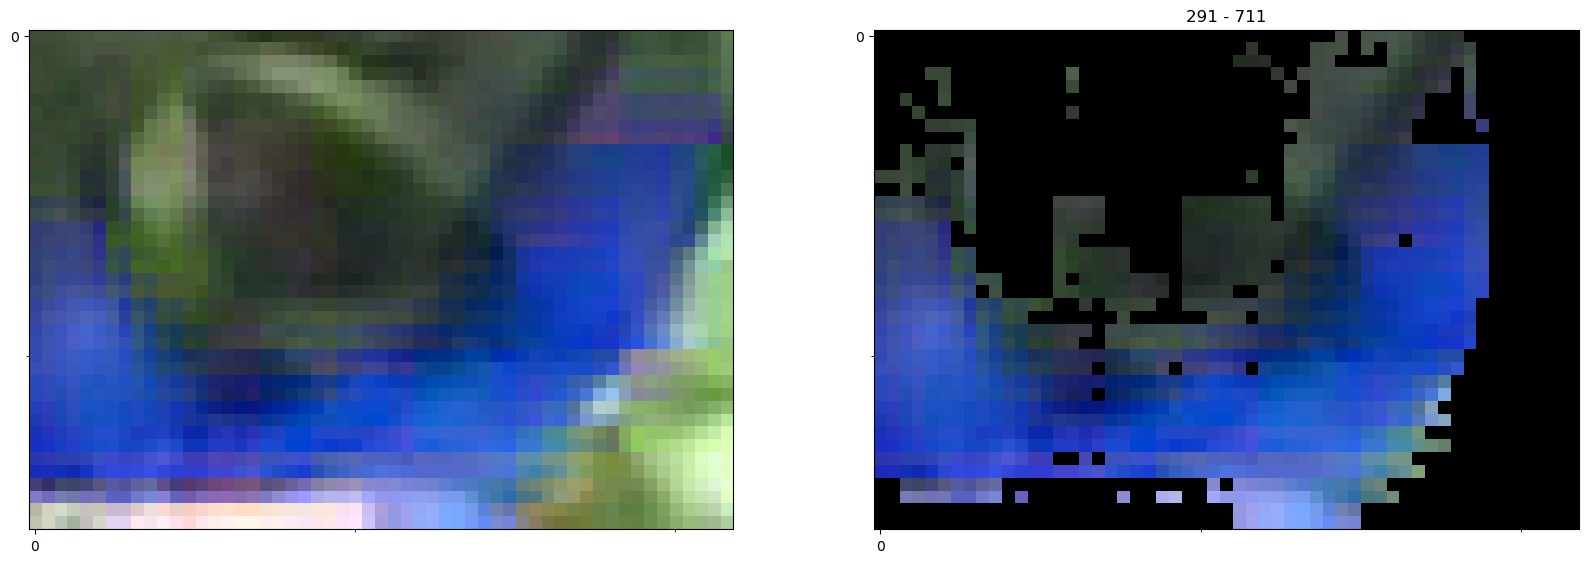

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.07it/s]
/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 39.123625898326466 7.940842516595822 44.66982244613789 9.6307319462961 
 pix med: 
 39.034132121183085 7.940752869504621 44.566027638474914 9.616314157196378 
 pix mean filtered: 
 38.989934369712635 7.906272195301821 44.68024760339073 9.654693906306301 
 pix med filtered: 
 38.95282206102461 7.906208438124435 44.63633558255328 9.64544663978702 
 margin 0.2: 
 45.09607516229153 12.098851133113966 38.382887840270996 6.990067565141192 
 margin 0.5: 
 44.790345159443945 12.143885653096799 38.35771283642812 6.873712251561416 
 margin 0.8: 
 44.34937306425788 12.234831476578163 38.24921324849129 6.7187893216046275 
 margin_f0.2: 
 44.124801050532945 10.526050956769724 38.82114538414912 7.750519987564791 
 margin 0.5_f: 
 43.894238431345336 10.533693142679663 38.67407786575231 7.842914106675185 
 margin 0.8_f: 
 43.22761652821844 10.753971831258802 36.002669314091854 7.391566324110602


  0%|                                                                                                                                                                                                     | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)


pix size mean: width - 40.13600624172311, height - 28.249507064923264
pix size median: width - 40.15853786331743, height - 28.265365822757303
pix size mean filtered: width - 39.97226076207381, height - 28.156388560033307
pix size median filtered: width - 39.9191862316457, height - 28.119002956295002
margin 2: width - 21.639831364154816, height - 52.16941609978676
margin 5: width - 20.24991251528263, height - 53.0223473906517
margin 8: width - 21.85269072651863, height - 53.22209373116493
margin 2 filtered: width - 21.34317345917225, height - 53.85683849453926
margin 5 filtered: width - 20.938577130436897, height - 54.57238852977753
margin 8 filtered: width - 22.13357202708721, height - 53.6000020802021


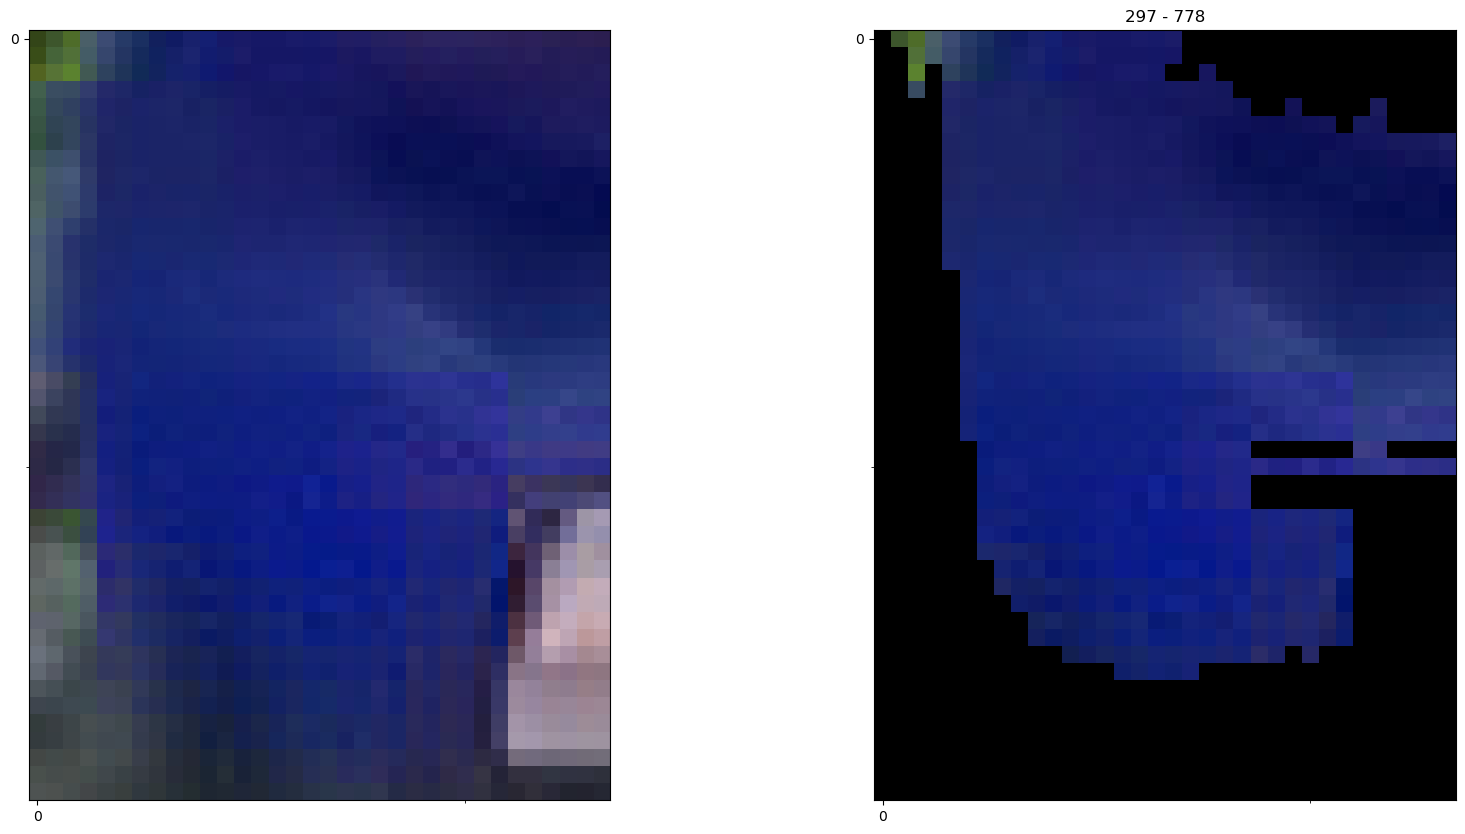

 33%|███████████████████████████████████████████████████████████████                                                                                                                              | 1/3 [00:00<00:00,  3.86it/s]

pix size mean: width - 40.25072385687742, height - 31.465584043194106
pix size median: width - 40.31985335534509, height - 31.51962530843025
pix size mean filtered: width - 40.1308727253821, height - 31.240290502744244
pix size median filtered: width - 40.158335168953535, height - 31.261668924314023
margin 2: width - 30.90779297053814, height - 50.96711963415146
margin 5: width - 29.231954365968704, height - 51.16754025220871
margin 8: width - 27.460912242531776, height - 51.087673753499985
margin 2 filtered: width - 31.184274703264236, height - 51.143720746040344
margin 5 filtered: width - 29.64010275900364, height - 51.46012455224991
margin 8 filtered: width - 27.57314220070839, height - 51.195178180933


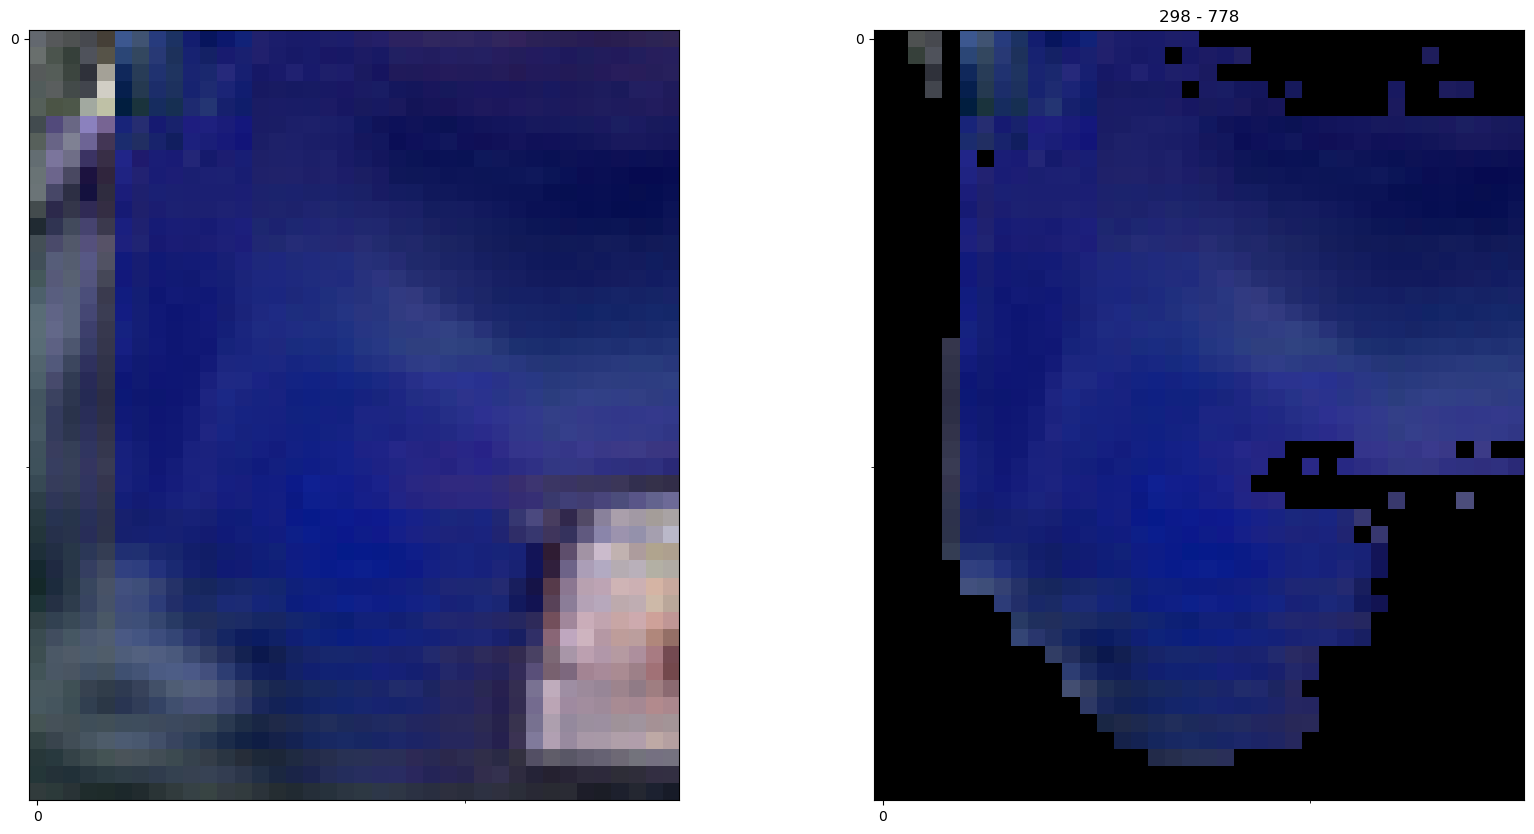

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2/3 [00:00<00:00,  4.25it/s]

pix size mean: width - 45.4604093279889, height - 42.42994161225347
pix size median: width - 45.44228953296886, height - 42.41302971339264
pix size mean filtered: width - 45.39793541378093, height - 42.03292250028269
pix size median filtered: width - 45.389250988670774, height - 42.02488178732323
margin 2: width - 43.18802058696747, height - 65.42015075683594
margin 5: width - 41.515711694955826, height - 65.57077914476395
margin 8: width - 41.33604094386101, height - 67.89395213127136
margin 2 filtered: width - 43.16544532775879, height - 61.615608632564545
margin 5 filtered: width - 41.43054410815239, height - 61.03722006082535
margin 8 filtered: width - 41.33604094386101, height - 36.727868020534515


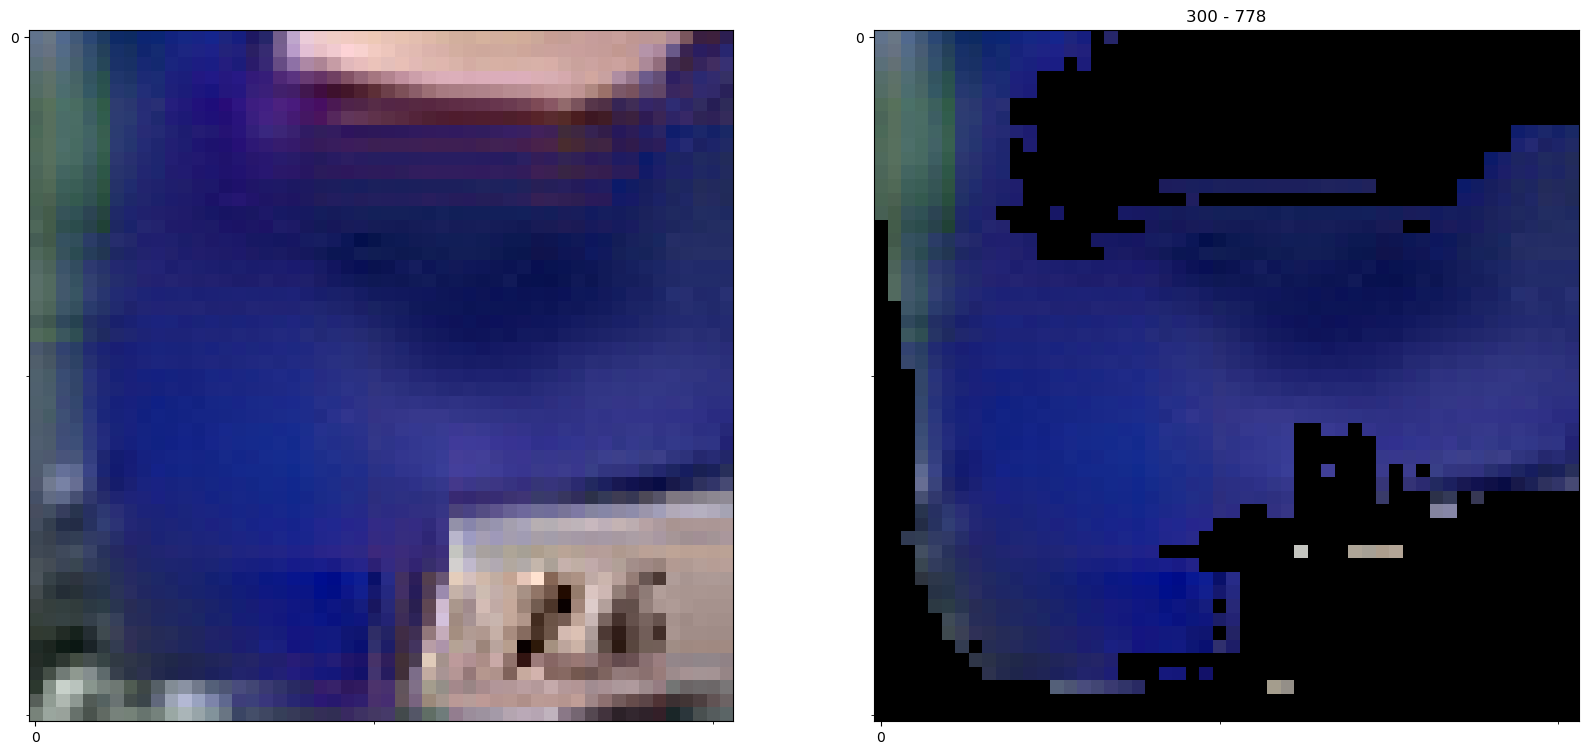

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]
/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 41.94904647552981 2.4833501356069916 34.04834424012361 6.070374434574941 
 pix med: 
 41.97356025054379 2.453645967135013 34.0660069481934 6.049911458420357 
 pix mean filtered: 
 41.833689633745614 2.521134060180167 33.80986718768674 5.9493188295565025 
 pix med filtered: 
 41.822257463090004 2.5241341964067887 33.80185122264408 5.954424746767276 
 margin 0.2: 
 31.911881640553474 8.82561651249644 56.185562163591385 6.5482618081789 
 margin 0.5: 
 30.332526192069054 8.7165359115439 56.58688892920812 6.397540669875915 
 margin 0.8: 
 30.21654797097047 8.189236029642394 57.40123987197876 7.470461613470115 
 margin_f0.2: 
 31.897631163398426 8.923173779772803 55.538722624381386 4.4374662174597015 
 margin 0.5_f: 
 30.669741332530975 8.397431922836772 55.68991104761759 3.9888872323413427 
 margin 0.8_f: 
 30.34758505721887 8.081124220385323 47.174349427223206 7.451734689848771


  0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_14876/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
/tmp/ipykernel_14876/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)


pix size mean: width - 47.247387679831625, height - 20.21720954048966
pix size median: width - 47.94618308431304, height - 20.516224868364873
pix size mean filtered: width - 46.79706447891496, height - 20.442897818800525
pix size median filtered: width - 48.08868330270643, height - 21.007130467357037
margin 2: width - 9.695167653262615, height - 34.17247533798218
margin 5: width - 12.98375055193901, height - 30.21039254963398
margin 8: width - 25.045551359653473, height - 30.894339084625244
margin 2 filtered: width - 3.1537225004285574, height - 29.026392847299576
margin 5 filtered: width - 6.506817881017923, height - 29.63438630104065
margin 8 filtered: width - 17.400648444890976, height - 24.993812665343285


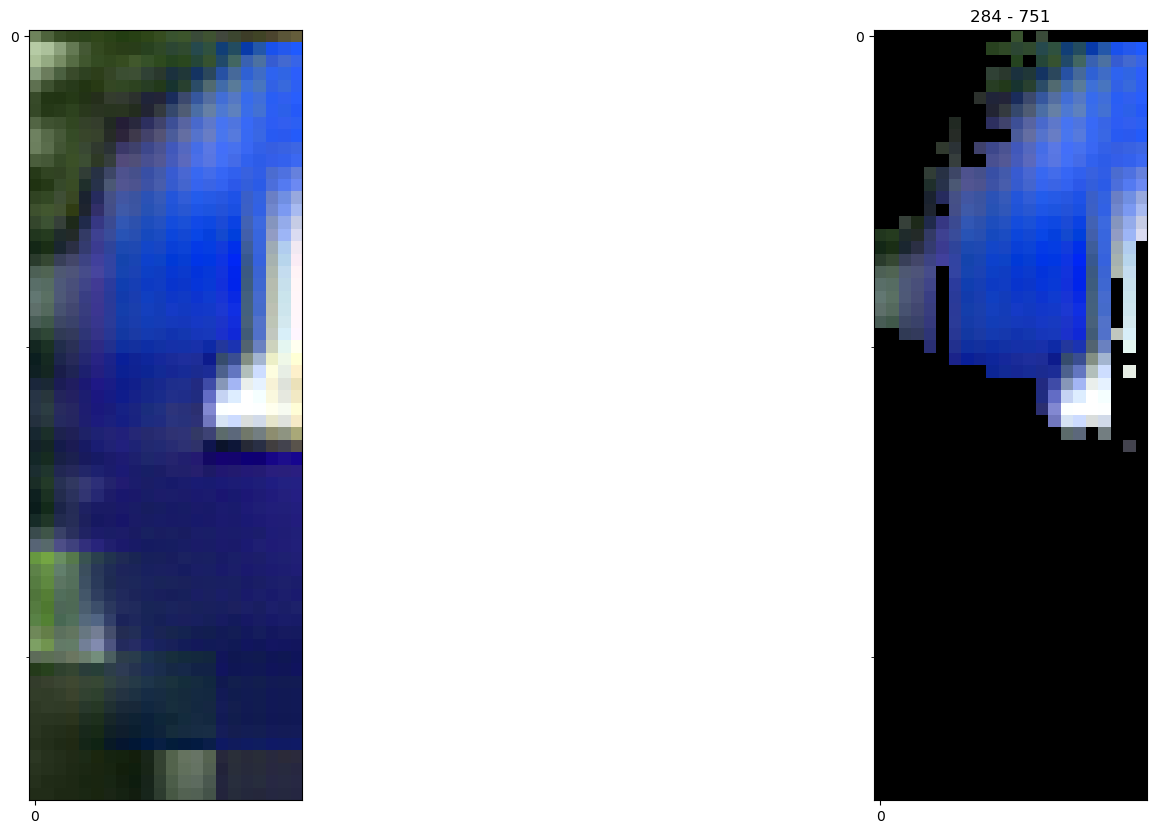

 12%|███████████████████████▋                                                                                                                                                                     | 1/8 [00:00<00:01,  3.78it/s]

pix size mean: width - 50.02938223946972, height - 44.78422619744597
pix size median: width - 50.13817027822684, height - 44.88160873381138
pix size mean filtered: width - 49.673064590907465, height - 45.36639587116863
pix size median filtered: width - 49.789980562171046, height - 45.47317519472529
margin 2: width - 28.163176029920578, height - 60.821808874607086
margin 5: width - 29.942113906145096, height - 60.75216457247734
margin 8: width - 32.35165774822235, height - 59.93031710386276
margin 2 filtered: width - 34.421514719724655, height - 58.86725336313248
margin 5 filtered: width - 34.47028622031212, height - 59.612344950437546
margin 8 filtered: width - 30.911432579159737, height - 59.93031710386276


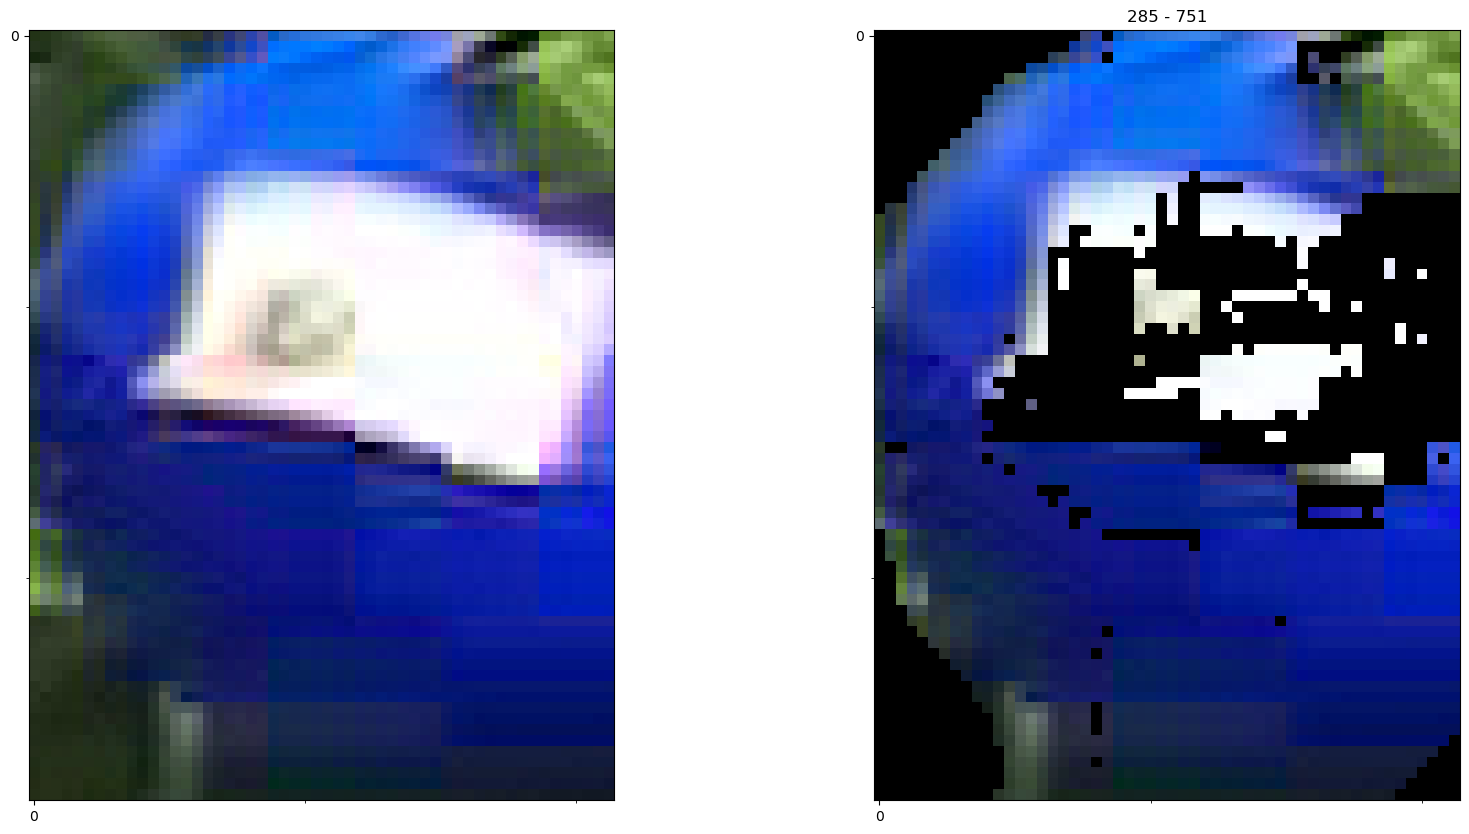

 25%|███████████████████████████████████████████████▎                                                                                                                                             | 2/8 [00:00<00:01,  4.52it/s]

pix size mean: width - 61.42249439606354, height - 64.42695063403185
pix size median: width - 61.74331277582682, height - 64.76346171386881
pix size mean filtered: width - 59.36194323945857, height - 65.23942580782779
pix size median filtered: width - 59.681874684427186, height - 65.59103397003739
margin 2: width - 46.6722697019577, height - 66.47296994924545
margin 5: width - 43.1906096637249, height - 65.82080572843552
margin 8: width - 40.40880501270294, height - 64.60780650377274
margin 2 filtered: width - 48.16683381795883, height - 67.15042144060135
margin 5 filtered: width - 48.10822382569313, height - 67.49384850263596
margin 8 filtered: width - 48.202093690633774, height - 64.96131420135498


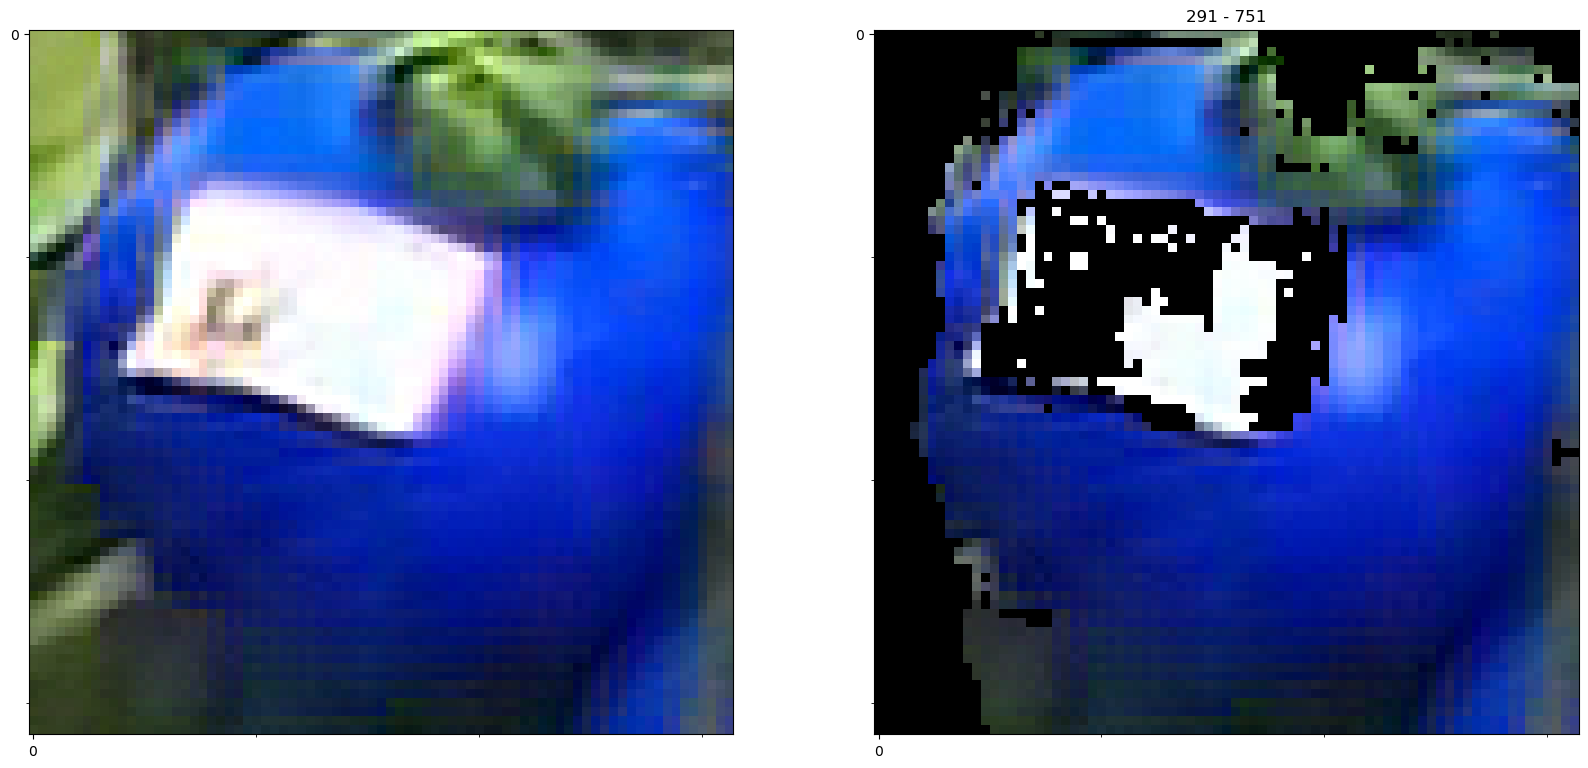

 38%|██████████████████████████████████████████████████████████████████████▉                                                                                                                      | 3/8 [00:00<00:01,  4.65it/s]

pix size mean: width - 54.98230300386587, height - 59.3625501465428
pix size median: width - 55.247433717293134, height - 59.64880289354225
pix size mean filtered: width - 53.69238218619542, height - 60.04694066873579
pix size median filtered: width - 53.977981908278096, height - 60.36634146394422
margin 2: width - 51.05181410908699, height - 57.49903991818428
margin 5: width - 53.65973711013794, height - 56.70047551393509
margin 8: width - 55.58960884809494, height - 56.65700510144234
margin 2 filtered: width - 54.957929998636246, height - 57.15397372841835
margin 5 filtered: width - 54.85529080033302, height - 57.130116969347
margin 8 filtered: width - 55.58960884809494, height - 56.97712302207947


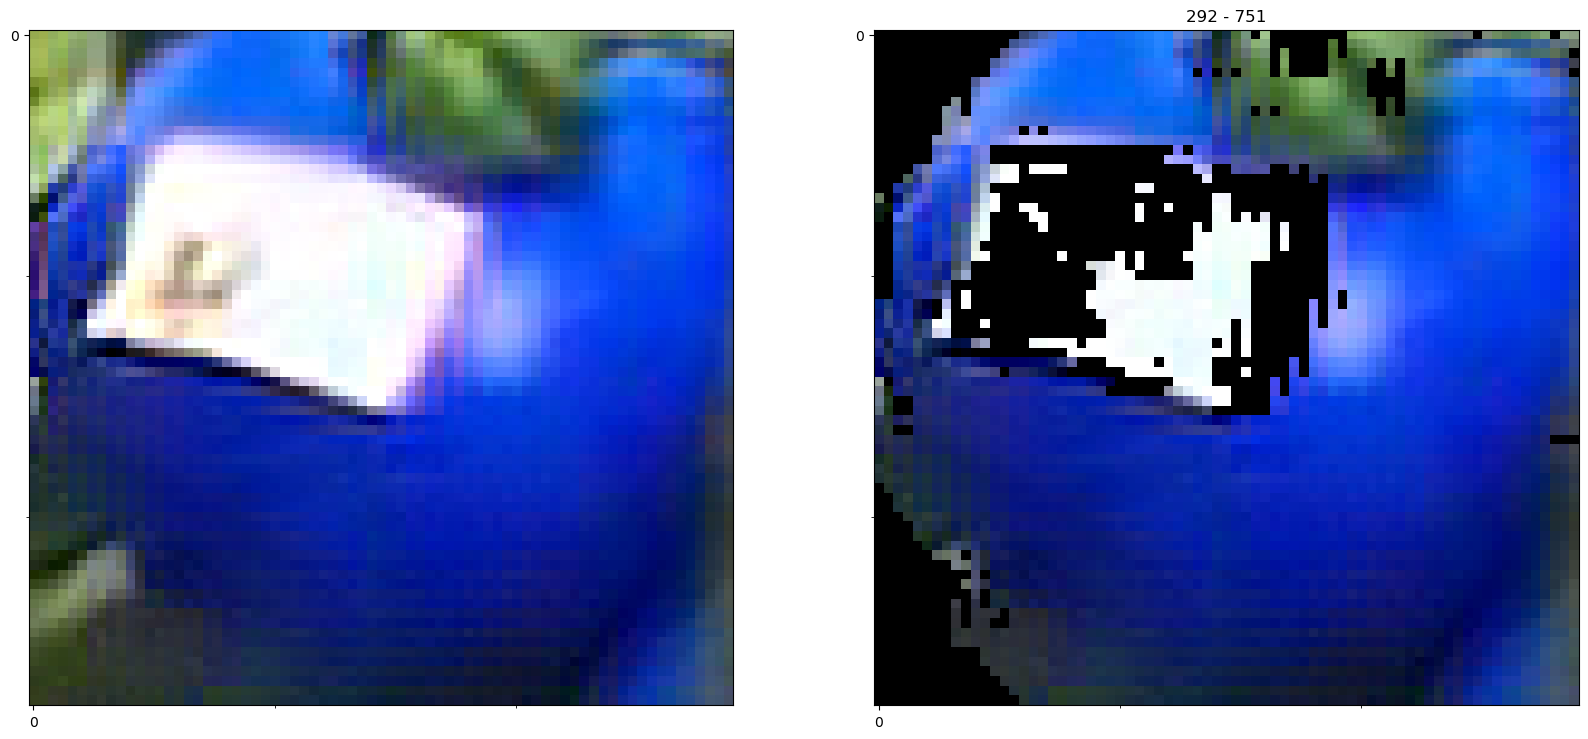

 50%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 4/8 [00:00<00:00,  4.50it/s]

pix size mean: width - 59.48021677997972, height - 60.794055019324865
pix size median: width - 59.5079541785043, height - 60.82240509979335
pix size mean filtered: width - 57.938175725897025, height - 61.565217580527566
pix size median filtered: width - 57.981219006384634, height - 61.610955453620676
margin 2: width - 52.129290997982025, height - 60.81300228834152
margin 5: width - 53.381048142910004, height - 60.001809149980545
margin 8: width - 55.9336319565773, height - 59.84116345643997
margin 2 filtered: width - 56.653670966625214, height - 61.69641390442848
margin 5 filtered: width - 57.04965069890022, height - 61.71046942472458
margin 8 filtered: width - 57.75027349591255, height - 60.12208014726639


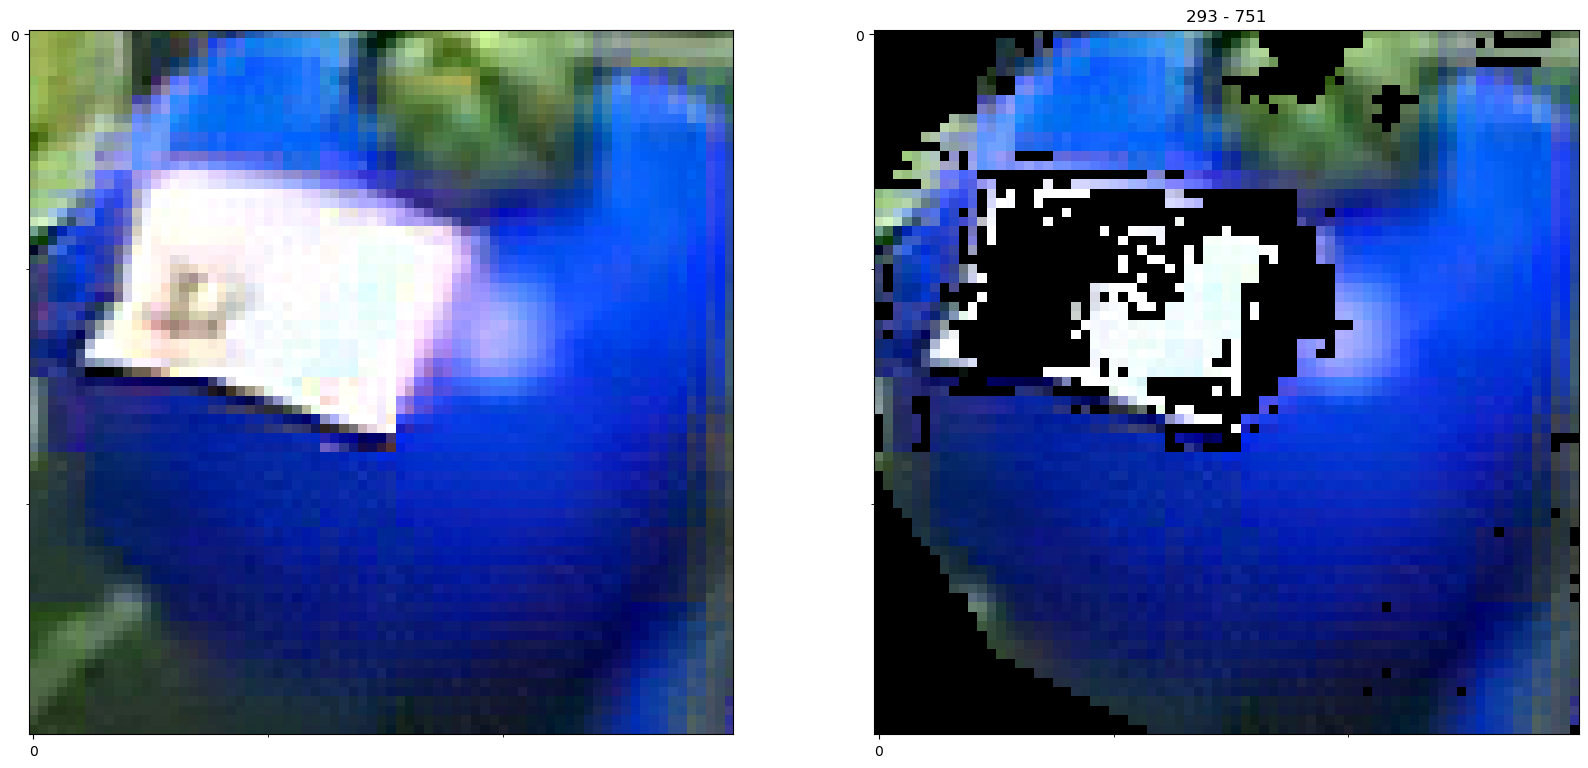

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5/8 [00:01<00:00,  4.47it/s]

pix size mean: width - 60.19825434211757, height - 58.062314392462476
pix size median: width - 60.31425529647245, height - 58.17419942891719
pix size mean filtered: width - 59.32581139607053, height - 58.915795874386134
pix size median filtered: width - 59.406110807789325, height - 58.9955403167853
margin 2: width - 48.20459708571434, height - 60.33272296190262
margin 5: width - 49.447908997535706, height - 59.52908471226692
margin 8: width - 51.58506706357002, height - 59.53996255993843
margin 2 filtered: width - 52.95632407069206, height - 59.95620787143707
margin 5 filtered: width - 52.96064540743828, height - 59.81249734759331
margin 8 filtered: width - 53.061261773109436, height - 59.671513736248016


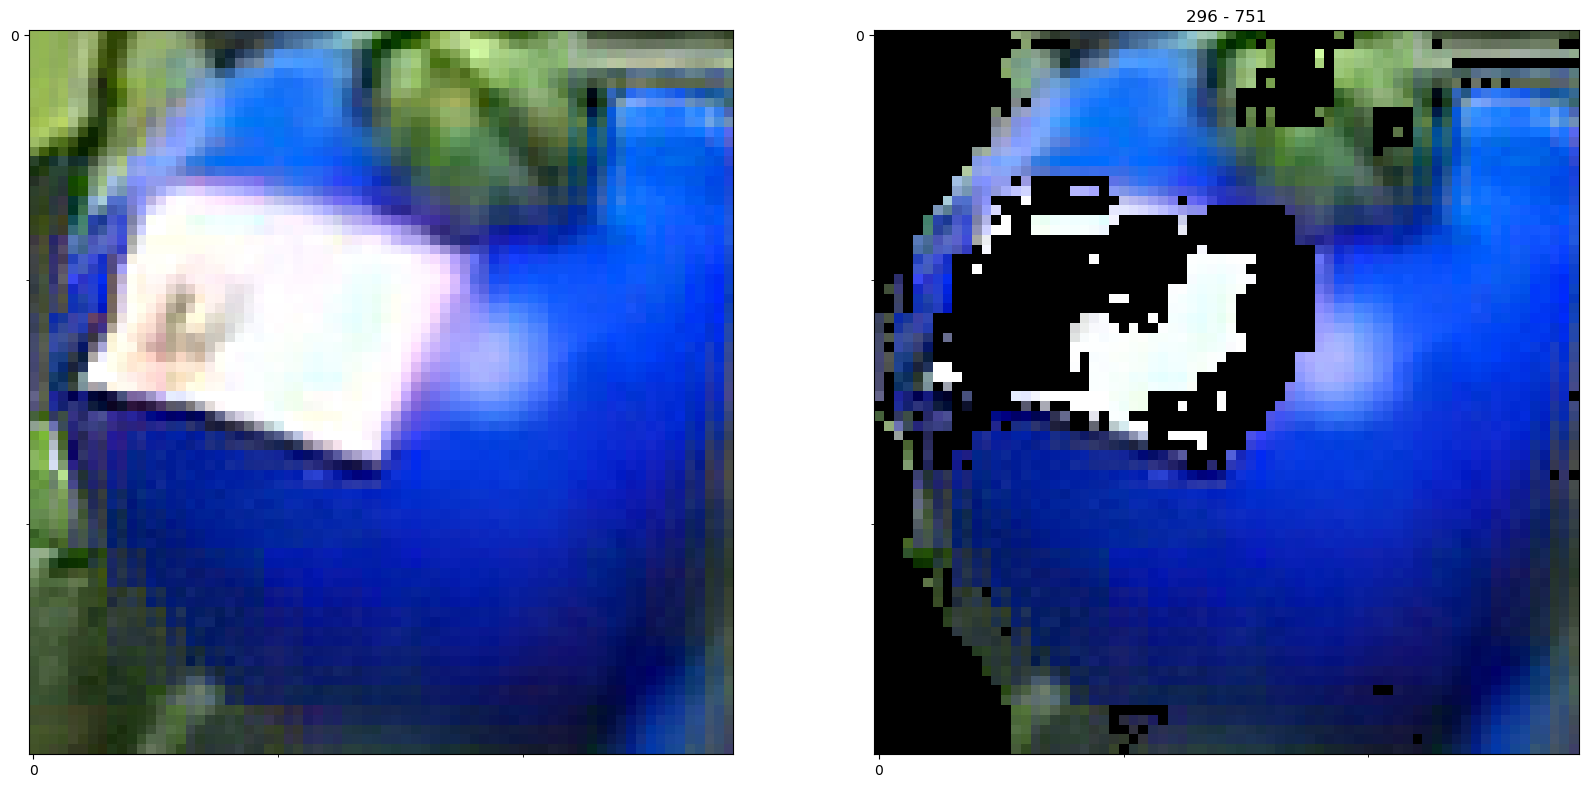

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6/8 [00:01<00:00,  4.51it/s]

pix size mean: width - 59.19578860312564, height - 55.88176583075756
pix size median: width - 59.28018571173425, height - 55.96143804344954
pix size mean filtered: width - 58.588519511839465, height - 56.55705128969033
pix size median filtered: width - 58.65342106282267, height - 56.61970247764187
margin 2: width - 51.45488679409027, height - 58.929119259119034
margin 5: width - 51.941920071840286, height - 58.403316885232925
margin 8: width - 53.38111147284508, height - 58.16231667995453
margin 2 filtered: width - 52.999503910541534, height - 58.804214000701904
margin 5 filtered: width - 52.82954499125481, height - 58.63293260335922
margin 8 filtered: width - 53.347304463386536, height - 58.352142572402954


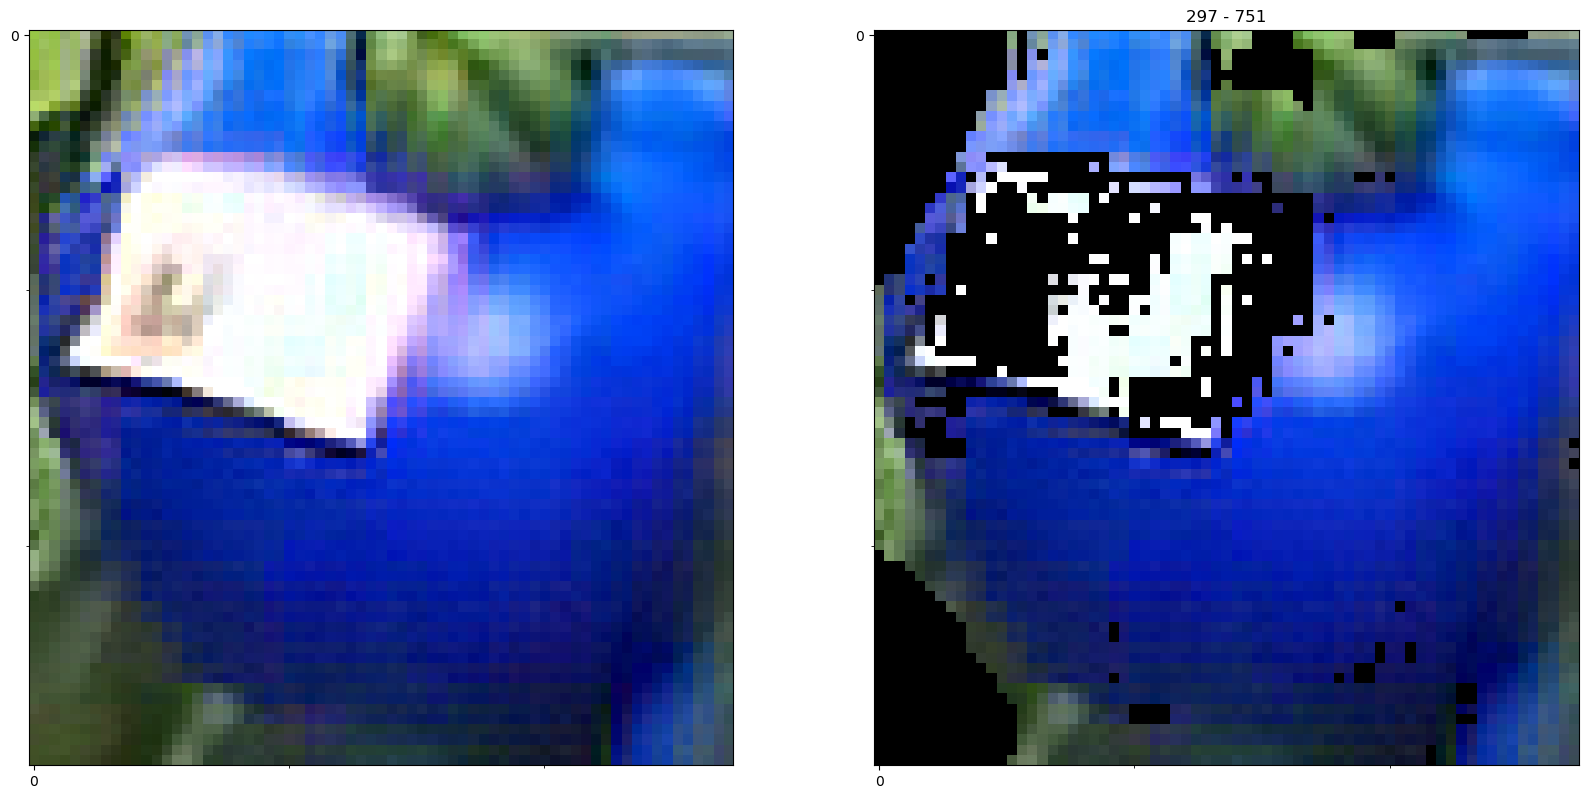

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 7/8 [00:01<00:00,  4.46it/s]

pix size mean: width - 58.59511164877611, height - 55.77637700273819
pix size median: width - 58.63733158975272, height - 55.816565941349
pix size mean filtered: width - 58.07830338360552, height - 56.42853019227949
pix size median filtered: width - 58.1134658712111, height - 56.46269385371399
margin 2: width - 51.10764130949974, height - 58.09817463159561
margin 5: width - 52.101511508226395, height - 57.48734250664711
margin 8: width - 53.37498337030411, height - 57.18804523348808
margin 2 filtered: width - 53.98845672607422, height - 57.72041901946068
margin 5 filtered: width - 53.88203263282776, height - 57.76705965399742
margin 8 filtered: width - 53.78781631588936, height - 57.29290097951889


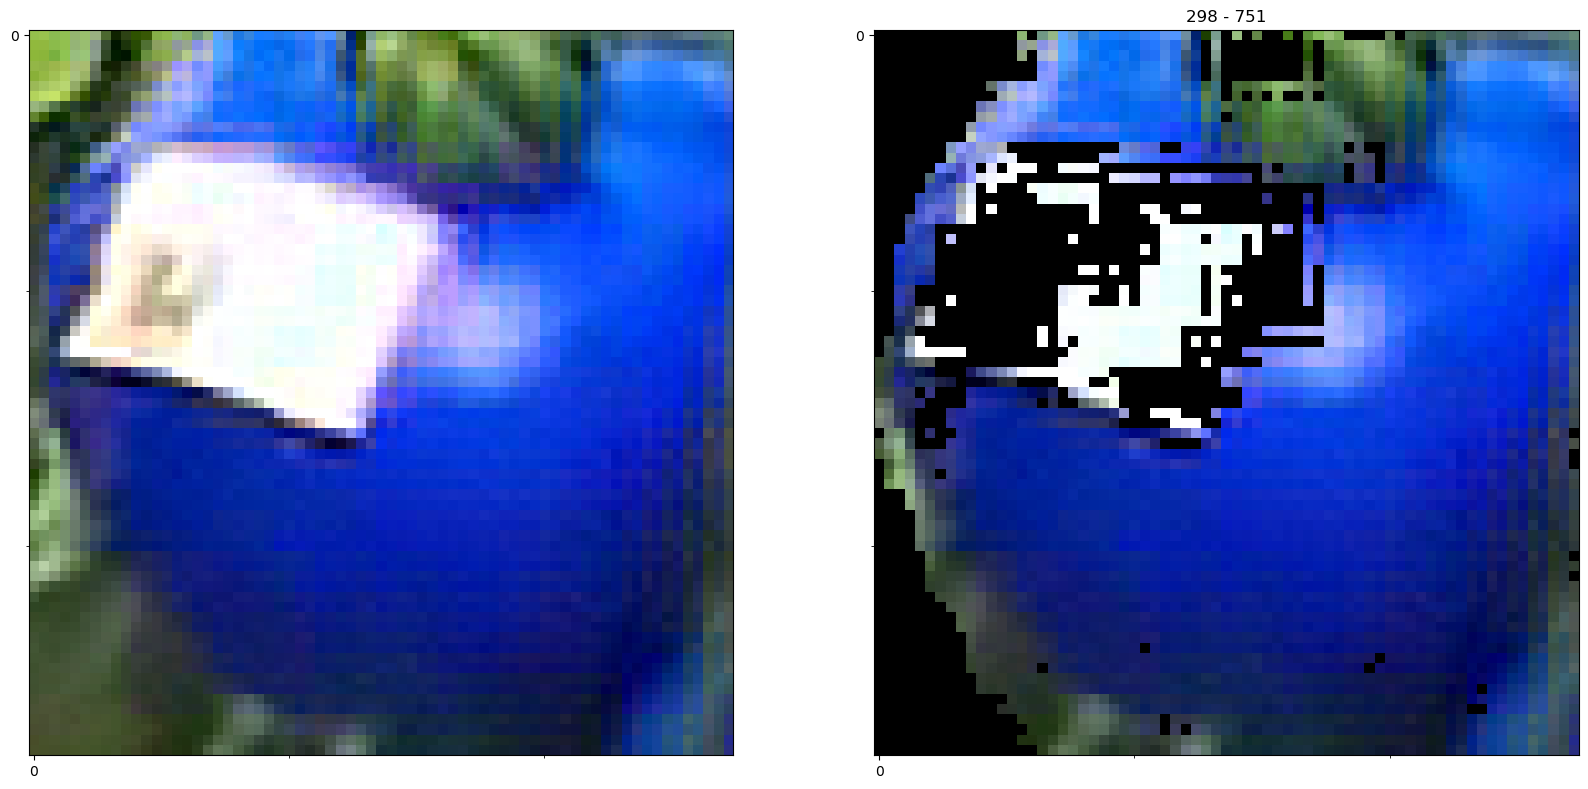

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.43it/s]

ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 56.39386733665372 4.849478287815928 52.41318109547417 13.289562857041933 
 pix med: 
 56.60185332901544 4.72378119613323 52.57308834038705 13.26130190962659 
 pix mean filtered: 
 55.43190806411112 4.536069243012061 53.07028188792703 13.464895289059324 
 pix med filtered: 
 55.71159215072382 4.259794594073421 53.265821649728224 13.35859357609359 
 margin 0.2: 
 42.30985546018928 14.367936637452605 57.14241415262222 9.056072333457012 
 margin 0.5: 
 43.33107499405742 13.676669000287598 56.11317395232618 10.13027874791364 
 margin 0.8: 
 45.95880210399628 11.109207045256824 55.85261946544051 9.704810401256868 
 margin_f0.2: 
 44.662244588835165 17.011714437372984 56.296912021934986 10.721934842952749 
 margin 0.5_f: 
 45.08281155722216 16.00035596375165 56.47420696914196 10.588795921419328 
 margin 0.8_f: 
 46.256304951384664 13.437054010030288 55.28765055350959 11.681754784667424



/tmp/ipykernel_14876/1550200791.py:97: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14876/1550200791.py:98: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_14876/1550200791.py:99: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


track_id  \
0   [306, 306, 306, 306, 306, 306, 306, 306, 306, ...   
1   [311, 311, 311, 311, 311, 311, 311, 311, 311, ...   
2   [312, 312, 312, 312, 312, 312, 312, 312, 312, ...   
3       [367, 367, 367, 367, 367, 367, 367, 367, 367]   
4                 [430, 430, 430, 430, 430, 430, 430]   
5                                [734, 734, 734, 734]   
6       [705, 705, 705, 705, 705, 705, 705, 705, 705]   
7   [721, 721, 721, 721, 721, 721, 721, 721, 721, ...   
8   [711, 711, 711, 711, 711, 711, 711, 711, 711, ...   
9                                     [778, 778, 778]   
10           [751, 751, 751, 751, 751, 751, 751, 751]   

                                                frame  \
0   [150, 151, 152, 156, 158, 159, 160, 161, 162, ...   
1   [146, 153, 159, 160, 161, 162, 166, 167, 170, ...   
2   [149, 151, 152, 153, 155, 156, 157, 158, 159, ...   
3       [154, 174, 175, 177, 178, 179, 181, 185, 187]   
4                 [172, 174, 175, 176, 177, 181, 187]   
5                                [280, 281, 285, 286]   
6       [279, 280, 281, 283, 284, 285, 286, 288, 292]   
7   [274, 280, 283, 284, 286, 287, 288, 289, 290, ...   
8   [273, 276, 277, 281, 282, 283, 285, 286, 287, ...   
9                                     [297, 298, 300]   
10           [284, 285, 291, 292, 293, 296, 297, 298]   

                                  pix_size_mean_width  \
0   [48.94715658889379, 45.859117340978685, 50.502...   
1   [47.34069693597371, 44.637586693727364, 46.856...   
2   [37.81765984177923, 38.325131943985916, 40.305...   
3   [52.7935543264875, 48.8755890561038, 49.325569...   
4   [53.26551074772935, 51.32839856960272, 51.5606...   
5   [46.14893199188601, 39.51455482034966, 29.8562...   
6   [57.11159748064101, 67.865623556254, 55.907693...   
7   [21.72659803856968, 26.03390517177343, 38.1269...   
8   [33.48859379073213, 30.916048759944413, 30.187...   
9   [40.13600624172311, 40.25072385687742, 45.4604...   
10  [47.247387679831625, 50.02938223946972, 61.422...   

                                 pix_size_mean_height  \
0   [38.84569880294546, 35.46477384749147, 53.3595...   
1   [54.60189496455864, 31.011141193048747, 40.468...   
2   [38.60088740551061, 36.63198349094646, 39.2241...   
3   [38.61261636408846, 53.22192002863848, 51.8870...   
4   [53.40026754901835, 51.730843057559674, 54.980...   
5   [44.5794924002176, 52.444648184232754, 35.9386...   
6   [54.31729927507667, 62.57340128172382, 57.1584...   
7   [30.15284384391131, 40.646449607829496, 49.331...   
8   [40.02258845373431, 35.684951621523915, 33.765...   
9   [28.249507064923264, 31.465584043194106, 42.42...   
10  [20.21720954048966, 44.78422619744597, 64.4269...   

                             pix_size_mean_filt_width  \
0   [48.30021521618975, 45.617382334120485, 50.123...   
1   [47.37847345464511, 44.39146852067262, 46.8312...   
2   [37.637566704369895, 37.88084808575275, 40.050...   
3   [52.42728397062846, 49.0056659996638, 49.32856...   
4   [53.46559490771207, 51.283258324961146, 51.872...   
5   [45.53866274588902, 38.78996583249171, 29.7847...   
6   [56.85138553129163, 67.44275142933944, 55.6253...   
7   [21.617905392132272, 25.659219009257743, 37.59...   
8   [32.91614518994607, 30.59025846677762, 29.9280...   
9   [39.97226076207381, 40.1308727253821, 45.39793...   
10  [46.79706447891496, 49.673064590907465, 59.361...   

                            pix_size_mean_filt_height  \
0   [38.406281206510364, 35.14506001343196, 53.184...   
1   [54.38523614088333, 30.744277666340693, 40.308...   
2   [38.52278888674064, 36.38966334723241, 39.0635...   
3   [38.65035763034331, 52.98939599004851, 51.7220...   
4   [53.0603114240344, 51.36995748307655, 54.49039...   
5   [44.55155331173922, 52.39992496243017, 35.9231...   
6   [53.93860452300382, 62.30056346109988, 56.8039...   
7   [30.145641659934746, 40.57786327944042, 49.121...   
8   [39.970086056337294, 35.66206154747092, 33.751...   
9   [28.156388560033307, 31.240290502744244, 42.03

In [15]:
# for track_id in [6,7,12,28]: #0.8sts
res = []
for track_id in [306,311,312,367,430,734,705,721,711,778,751]: #0.8stm
# for track_id in range(30):
    cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
    frame_numbers = get_track_id_frames(measures_frame, track_id)
    boxes = get_track_id_boxes(measures_frame, track_id)
    ellps_w, ellps_h, ellps_z = [], [], []
    pix_size_w_mean, pix_size_h_mean = [], []
    pix_size_w_med, pix_size_h_med = [], []
    pix_size_w_mean_f, pix_size_h_mean_f = [], []
    pix_size_w_med_f, pix_size_h_med_f = [], []
    margin_h_2, margin_w_2 = [], []
    margin_h_5, margin_w_5 = [], []
    margin_h_8, margin_w_8 = [], []
    margin_h_2_f, margin_w_2_f = [], []
    margin_h_5_f, margin_w_5_f = [], []
    margin_h_8_f, margin_w_8_f = [], []
    for i in tqdm(range(len(frame_numbers))):
        frame, box = frame_numbers[i], boxes[i]
        rgb_img, _, pc_img = cam.get_zed(frame)
        x1,y1,x2,y2 = validate_bbox(box, rgb_img)
        pc_crop = pc_img[y1:y2, x1:x2,:3]
        rgb_crop = rgb_img[y1:y2, x1:x2]
#         filtered_center = kde_filtering(pc_crop[:,:,:3].reshape(-1,3))
#         _, width, height, z_w = ellipsoid_fit_ransac(filtered_center)
#         if width > 200 or height > 200 or z_w > 200: #if fruits are too big its probably due to noise
#             width, height, z_w = np.nan, np.nan, np.nan
#         ellps_w.append(width*100), ellps_h.append(height*100), ellps_z.append(z_w*100)


        width, height = get_dims_w_pixel_size(pc_crop, [x1,y1,x2,y2], "mean")
        pix_size_w_mean.append(width*100), pix_size_h_mean.append(height*100)
        print(f"pix size mean: width - {width*100}, height - {height*100}")
        width, height = get_dims_w_pixel_size(pc_crop, [x1,y1,x2,y2], "median")
        pix_size_w_med.append(width*100), pix_size_h_med.append(height*100)
        print(f"pix size median: width - {width*100}, height - {height*100}")
        
        pc_crop_f = pc_crop.copy()
        rgb_crop_c = rgb_crop.copy()
        filter_vec = hue_filtering(rgb_crop, nstds = 1.5)
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        filter_vec = np.isnan(filter_xyz_outliers(pc_crop, 2, False))
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        
        width, height = get_dims_w_pixel_size(pc_crop_f, [x1,y1,x2,y2], "mean")
        pix_size_w_mean_f.append(width*100), pix_size_h_mean_f.append(height*100)
        print(f"pix size mean filtered: width - {width*100}, height - {height*100}")
        width, height = get_dims_w_pixel_size(pc_crop_f, [x1,y1,x2,y2], "median")
        pix_size_w_med_f.append(width*100), pix_size_h_med_f.append(height*100)
        print(f"pix size median filtered: width - {width*100}, height - {height*100}")
        

        width = get_width(pc_crop, 0.2, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.2, fixed_z=True, max_z=1)
        margin_h_2.append(height)
        margin_w_2.append(width)
        print(f"margin 2: width - {width}, height - {height}")
        width = get_width(pc_crop, 0.5, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.5, fixed_z=True, max_z=1)
        margin_h_5.append(height)
        margin_w_5.append(width)
        print(f"margin 5: width - {width}, height - {height}")
        width = get_width(pc_crop, 0.8, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.8, fixed_z=True, max_z=1)
        margin_h_8.append(height)
        margin_w_8.append(width)
        print(f"margin 8: width - {width}, height - {height}")
        pc_crop_f = pc_crop.copy()
        rgb_crop_c = rgb_crop.copy()
        
        filter_vec = hue_filtering(rgb_crop, nstds = 1.5)
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        filter_vec = np.isnan(filter_xyz_outliers(pc_crop, 2, False))
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        
        width = get_width(pc_crop_f, 0.2, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.2, fixed_z=True, max_z=1)
        margin_h_2_f.append(height)
        margin_w_2_f.append(width)
        print(f"margin 2 filtered: width - {width}, height - {height}")
        width = get_width(pc_crop_f, 0.5, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.5, fixed_z=True, max_z=1)
        margin_h_5_f.append(height)
        margin_w_5_f.append(width)
        print(f"margin 5 filtered: width - {width}, height - {height}")
        width = get_width(pc_crop_f, 0.8, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.8, fixed_z=True, max_z=1)
        margin_h_8_f.append(height)
        margin_w_8_f.append(width)
        print(f"margin 8 filtered: width - {width}, height - {height}")
        plot_2_imgs(rgb_crop, rgb_crop_c, f"{frame} - {track_id}")
    print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
          np.nanmean(ellps_h), np.nanstd(ellps_h),
          np.nanmean(ellps_z), np.nanstd(ellps_z),
          "\n pix mean: \n",
         np.nanmean(pix_size_w_mean), np.nanstd(pix_size_w_mean),
          np.nanmean(pix_size_h_mean), np.nanstd(pix_size_h_mean),
          "\n pix med: \n"
        ,np.nanmean(pix_size_w_med), np.nanstd(pix_size_w_med),
          np.nanmean(pix_size_h_med), np.nanstd(pix_size_h_med),
          
        "\n pix mean filtered: \n",
         np.nanmean(pix_size_w_mean_f), np.nanstd(pix_size_w_mean_f),
          np.nanmean(pix_size_h_mean_f), np.nanstd(pix_size_h_mean_f),
          "\n pix med filtered: \n"
        ,np.nanmean(pix_size_w_med_f), np.nanstd(pix_size_w_med_f),
          np.nanmean(pix_size_h_med_f), np.nanstd(pix_size_h_med_f),
          
          
         "\n margin 0.2: \n", 
        np.nanmean(margin_w_2), np.nanstd(margin_w_2),
          np.nanmean(margin_h_2), np.nanstd(margin_h_2),
                  "\n margin 0.5: \n", 
        np.nanmean(margin_w_5), np.nanstd(margin_w_5),
          np.nanmean(margin_h_5), np.nanstd(margin_h_5),
                  "\n margin 0.8: \n", 
        np.nanmean(margin_w_8), np.nanstd(margin_w_8),
          np.nanmean(margin_h_8), np.nanstd(margin_h_8),
          
                  "\n margin_f0.2: \n", 
        np.nanmean(margin_w_2_f), np.nanstd(margin_w_2_f),
          np.nanmean(margin_h_2_f), np.nanstd(margin_h_2_f),
                  "\n margin 0.5_f: \n", 
        np.nanmean(margin_w_5_f), np.nanstd(margin_w_5_f),
          np.nanmean(margin_h_5_f), np.nanstd(margin_h_5_f),
                  "\n margin 0.8_f: \n", 
        np.nanmean(margin_w_8_f), np.nanstd(margin_w_8_f),
          np.nanmean(margin_h_8_f), np.nanstd(margin_h_8_f))
    res.append([[track_id]*len(frame_numbers),frame_numbers , pix_size_w_mean, pix_size_h_mean,
                pix_size_w_mean_f, pix_size_h_mean_f,
                pix_size_w_med, pix_size_h_med,
                pix_size_w_med_f, pix_size_h_med_f,
               margin_w_2, margin_h_2,
               margin_w_2_f, margin_h_2_f,
                margin_w_5, margin_h_5,
               margin_w_5_f, margin_h_5_f,
                margin_w_8, margin_h_8,
               margin_w_8_f, margin_h_8_f])
col_names = ["track_id","frame",
             "pix_size_mean_width" , "pix_size_mean_height", "pix_size_mean_filt_width" , "pix_size_mean_filt_height",
            "pix_size_med_width" , "pix_size_med_height", "pix_size_med_filt_width" , "pix_size_med_filt_height",
            "margin_2_width" , "margin_2_height", "margin_2_filt_width" , "margin_2_filt_height",
            "margin_5_width" , "margin_5_height", "margin_5_filt_width" , "margin_5_filt_height",
            "margin_8_width" , "margin_8_height", "margin_8_filt_width" , "margin_8_filt_height",]
pd.DataFrame(res, columns=col_names)



In [35]:
x = [np.array(res_) for res_ in res]


array([[306.        , 306.        , 306.        , ..., 751.        ,
        751.        , 751.        ],
       [150.        , 151.        , 152.        , ..., 296.        ,
        297.        , 298.        ],
       [ 48.94715659,  45.85911734,  50.50202314, ...,  60.19825434,
         59.1957886 ,  58.59511165],
       ...,
       [         nan,  38.76630217,  53.14232036, ...,  59.53996256,
         58.16231668,  57.18804523],
       [  4.55308566,  24.21651222,  50.81507936, ...,  53.06126177,
         53.34730446,  53.78781632],
       [         nan,  38.76630217,  53.14232036, ...,  59.67151374,
         58.35214257,  57.29290098]])

In [40]:
out_df = pd.DataFrame(np.concatenate(x,axis = 1).T, columns=col_names)
out_df.round(2).to_csv("/home/fruitspec-lab/Downloads/0.8m1stm/output/size_measures.csv")

In [13]:
s

NameError: name 's' is not defined

In [ ]:
    print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
          np.nanmean(ellps_h), np.nanstd(ellps_h),
          np.nanmean(ellps_z), np.nanstd(ellps_z),
          "\n pix mean: \n",
         np.nanmean(pix_size_w_mean), np.nanstd(pix_size_w_mean),
          np.nanmean(pix_size_h_mean), np.nanstd(pix_size_h_mean),
          "\n pix med: \n"
        ,np.nanmean(pix_size_w_med), np.nanstd(pix_size_w_med),
          np.nanmean(pix_size_h_med), np.nanstd(pix_size_h_med),
         "\n margin 0.2: \n", 
        np.nanmean(margin_w_2), np.nanstd(margin_w_2),
          np.nanmean(margin_h_2), np.nanstd(margin_h_2),
                  "\n margin 0.5: \n", 
        np.nanmean(margin_w_5), np.nanstd(margin_w_5),
          np.nanmean(margin_h_5), np.nanstd(margin_h_5),
                  "\n margin 0.8: \n", 
        np.nanmean(margin_w_8), np.nanstd(margin_w_8),
          np.nanmean(margin_h_8), np.nanstd(margin_h_8))

In [ ]:
track_id = 5
cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
frame_numbers = get_track_id_frames(measures_frame, track_id)
boxes = get_track_id_boxes(measures_frame, track_id)
ellps_w, ellps_h, ellps_z = [], [], []
pix_size_w_mean, pix_size_h_mean = [], []
pix_size_w_med, pix_size_h_med = [], []
i = len(frame_numbers) -1
frame, box = frame_numbers[i], boxes[i]
rgb_img, _, pc_img = cam.get_zed(frame)
x1,y1,x2,y2 = validate_bbox(box, rgb_img)
pc_crop = pc_img[y1:y2, x1:x2,:3]
plt.imshow(rgb_img[y1:y2, x1:x2])
plt.title(track_id)
plt.show()

In [ ]:
cut_box_pc = cut_center_of_box(pc_crop, 0.1)
cut_box_rgb = cut_center_of_box(rgb_img[y1:y2, x1:x2], 0.1)
plot_2_imgs(cut_box_pc[:, :, 2], cut_box_rgb)

In [ ]:
def apply_sobol(det_crop, plot_change=False):
    """
    applies sobol filterning on image
    :param det_crop: image to apply filter on
    :param plot_change: flag to show the image after applying sobol
    :return: image after sobol filtering
    """
    torch_img = K.utils.image_to_tensor(det_crop)
    torch_img = torch_img[None, ...].float() / 255.
    torch_img = K.enhance.adjust_contrast(torch_img, 0.5)
    torch_img_gray = K.color.rgb_to_grayscale(torch_img)
    processed_img = K.filters.sobel(torch_img_gray, True, 1e-3) 
    if plot_change:
        plot_2_imgs(det_crop, processed_img.detach().numpy()[0, 0] > 0.05)
    return processed_img.detach().numpy()[0, 0]
out_img = apply_sobol(rgb_img[y1:y2, x1:x2], True)

In [ ]:
min_area = 5
out_img = out_img > 0.04
rgb_crop = rgb_img[y1:y2, x1:x2].copy()
contours, _ = cv2.findContours(out_img.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = []
for c in contours:
    if cv2.contourArea(c) >= min_area:
        filtered_contours.append(c)

mask = np.zeros_like(out_img).astype(np.uint8)
hull = cv2.convexHull(np.concatenate(filtered_contours))
cv2.drawContours(mask, [hull], 0, (255, 255, 255), -1)
plot_2_imgs(out_img, mask)

rgb_c = rgb_crop.copy()
rgb_c[np.logical_not(mask)] = 0
plot_2_imgs(rgb_crop, rgb_c)

In [ ]:
plot_2_imgs(rgb_crop, hue_filtering(rgb_crop))

In [ ]:
# rgb_images, pc_images = get_track_id_images(measures_frame, 0, args)
# hue_filtered = [hue_filtering(rgb_c) for rgb_c in rgb_images]
# plot_image_grid(hue_filtered, 5, np.ceil(hue_filtered/5))

In [ ]:
plt.imshow(rgb_c)

In [ ]:
hist_bins[np.argmax(hist_vals)] + 1*np.std(hue)

In [ ]:
hsv = cv2.cvtColor(rgb_c, cv2.COLOR_BGR2HSV)
hue, sat, v = cv2.split(hsv.copy())
rgb_crop = rgb_c.copy()
plot_2_imgs(rgb_c, hue)
rgb_crop[hue > 200] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 150] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 100] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 50] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 25] = 0
plot_2_imgs(rgb_c, rgb_crop)

In [ ]:
d2_border_points = np.where(out_img> 0.05)
spX=d2_border_points[0]
spY=d2_border_points[1]

A = np.zeros((len(spX),3))
A[:,0] = spX*2
A[:,1] = spY*2
A[:,2] = 1

#   Assemble the f matrix
f = np.zeros((len(spX),1))
f[:,0] = (spX*spX) + (spY*spY)
C, residules, rank, singval = np.linalg.lstsq(A,f)
C = np.abs(C)
#   solve for the radius
t = (C[0]*C[0])+(C[1]*C[1])+C[2]
radius = np.sqrt(t)/2
# channels are switched
radius, np.sqrt(C[1]), np.sqrt(C[0])

In [ ]:
radius[0]**2 - x**2

In [ ]:
circle_img = np.full(out_img.shape,0)
for x in range(out_img.shape[1]):
    y = int(np.sqrt(np.abs(radius[0]**2 - (x+C[0][0])**2)) + C[1][0])
    if y < out_img.shape[0]:
        circle_img[x,y] = 1
plt.imshow(circle_img)
plt.show()

In [ ]:
stop

In [ ]:
rgb_images, pc_images = get_track_id_images(measures_frame, 5, args)

In [ ]:
w = []
h = []
for track_id in range(len(pc_images)):
    pc_img = pc_images[track_id]
    box = get_track_id_boxes(measures_frame, 5)[track_id]
    wid,hei = get_dims_w_pixel_size(pc_img, box, "mean")
    w.append(wid), h.append(hei)
np.mean(w), np.mean(h), np.std(w), np.std(h)

In [ ]:
pc_images[-1][30,:,0]

In [ ]:
pc_images[-1][30,:,1]

In [ ]:
arr = pc_images[-1][30,:,2].flatten()
sns.kdeplot(arr)
plt.vlines(np.nanmedian(arr), 0,17.5,color = "black")
plt.vlines(np.nanmedian(arr) + 2*arr.std(),0,17.5,color = "green")

In [ ]:
centers = pc_crop.reshape(-1,3)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(-centers[:, 2], -centers[:, 0], -centers[:, 1])
# for i, label in enumerate(fruit_3d_space.keys()):
#     ax.text(-centers[i, 2], -centers[i, 0], -centers[i, 1], '%s' % (str(label)), size=10, zorder=1,
#             color='k')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.view_init(0,15)
plt.show()

In [ ]:
import numpy as np
from scipy import stats
def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2
m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
values.shape

In [ ]:
values

In [ ]:
finite_centers = centers[np.all(np.isfinite(centers),axis = 1)]
kernel = gaussian_kde(finite_centers.T)

In [ ]:
plt.hist(kernel(finite_centers.T)/np.sum(kernel(finite_centers.T)))

In [ ]:
0.0001*len(finite_centers)

In [ ]:
for i in range(len(rgb_images)):
    rgb_img = rgb_images[i]
    # plt.imshow(rgb_img)
    centers = pc_images[i][:,:,:3].reshape(-1,3)
    filtered_center = kde_filtering(centers)
    # max_z = min(np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2])),1.1)
    # filtered_center[np.abs(centers[:,2]) > max_z] = np.nan
    # filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
    # filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
    filtere_rgb = rgb_img.copy()
    filtere_rgb[np.isnan(filtered_center.reshape(rgb_img.shape))] = 0
    plot_2_imgs(rgb_img, filtere_rgb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
rgb_img = rgb_images[-4]
# plt.imshow(rgb_img)
centers = pc_images[-4][:,:,:3].reshape(-1,3)
finite_centers = centers[np.all(np.isfinite(centers),axis = 1)].copy()
kernel = gaussian_kde(finite_centers.T)
points_density = np.array([])
for point in centers:
    if not np.sum(np.isnan(point)):
        points_density = np.append(points_density, kernel(point))
    else:
        points_density = np.append(points_density, np.nan)

points_density = points_density/np.nansum(points_density)
filtered_center = finite_centers.copy()
filtered_center[points_density <0.5/ len(finite_centers)] = np.nan
# max_z = min(np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2])),1.1)
# filtered_center[np.abs(centers[:,2]) > max_z] = np.nan
# filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
# filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
filtere_rgb = rgb_img.copy()
filtere_rgb[np.isnan(filtered_center.reshape(rgb_img.shape))] = 0
plot_2_imgs(rgb_img, filtere_rgb)
def plot_3d_scatter(angle1, angle2, angle3):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter3D(-filtered_center[:, 2], -filtered_center[:, 1], -filtered_center[:, 0],s = 1)
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    ax.view_init(angle1, angle2, angle3)
    plt.show()
    
# define the sliders for the viewing angles
angle1_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)
angle2_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)
angle3_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)

# create the interactive plot
interactive_plot = interact(plot_3d_scatter, angle1=angle1_slider, angle2=angle2_slider, angle3 = angle3_slider)

# display the interactive plot
display(interactive_plot)


In [ ]:
import math
def ellipsoid_fit(filtered_center):
    spX=filtered_center[:,0]
    spY=filtered_center[:,1]
    spZ=filtered_center[:,2]
    falut_rows = np.any(np.isnan(np.column_stack([spX,spY,spZ])), axis=1)
    spX,spY,spZ = spX[~falut_rows],spY[~falut_rows],spZ[~falut_rows]

    A = np.zeros((len(spX),4))
    A[:,0] = spX*2
    A[:,1] = spY*2
    A[:,2] = spZ*2
    A[:,3] = 1

    #   Assemble the f matrix
    f = np.zeros((len(spX),1))
    f[:,0] = (spX*spX) + (spY*spY) + (spZ*spZ)
    C, residules, rank, singval = np.linalg.lstsq(A,f)
    C = np.abs(C)
    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)
    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2])

rgb_img = rgb_images[-1]
plt.imshow(rgb_img)
plt.show()
r = []
w = []
h = []
z = []
for i in range(len(pc_images)):
    centers = pc_images[i][:,:,:3].reshape(-1,3)
    filtered_center = centers.copy()
    filtered_center[np.abs(centers[:,2]) > np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2]))] = np.nan
    filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
    filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
    r_t, w_t, h_t, z_t = ellipsoid_fit(filtered_center)
    r.append(r_t)
    w.append(w_t)
    h.append(h_t)
    z.append(z_t)
np.mean(r), np.mean(w),np.mean(h),np.mean(z)

In [ ]:
np.std(r), np.std(w),np.std(h)

In [ ]:
x,y,z = filtered_center[:,1][~falut_rows],filtered_center[:,0][~falut_rows],filtered_center[:,2][~falut_rows]
A = np.array([x**2, y**2, z**2]).T

# vector of ones
O = np.ones(len(x))

# least squares solver
B, resids, rank, s = np.linalg.lstsq(A, O)

# solving for a, b, c
a_ls = np.sqrt(1.0/B[0])
b_ls = np.sqrt(1.0/B[1])
c_ls = np.sqrt(1.0/B[2])
a_ls, b_ls, c_ls